# Data Cleaning and LASSO

In this notebook, we will apply sophisticated methods to clean the training dataset, and retrain the LASSO model with several L1 penalty rates to aim to improve the model performance.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from numpy import mean, std, absolute

import random

In [2]:
# Load data
data_dirpath = 'C:\\Users\\yixin\\Desktop\\Workspace\\Personal GitHub Repos\\House-Prices\\Projects\\House price prediction\\data'

train_csv = pd.read_csv(os.path.join(data_dirpath, "train.csv"))
test_csv = pd.read_csv(os.path.join(data_dirpath, "test.csv"))

In [3]:
train_csv.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [4]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
feature_map = dict()

for idx, col_name in enumerate(train_csv.columns):
    feature_map.setdefault(idx, col_name)

## Data Cleaning
###### What to clean?
- Outliers: remove them
- Multicollinearity: Remove by LASSO
- Homoscedasity: Adjust the data to make each independent variable homoscedasous
- Missing Value: Fill in with forward or backward fill

### Missing Value imputation



It is crucial to consider how, and what to fill in. As we can see that each features behave differently.<br>

We consider the following approach:

- *Categorical data:* treat missing value (nan) as a separate, independent value, because:

  - Some categorical feature have lots of missing values (e.g.: *PoolQC*), the information is too little to construct a reliable, unbiased imputor. For example, we cannot "guess or predict" what kind of swimming pool a house would have, **a house without a swimming pool shall be considered as a different type**
  - Category are restricted when converted to numerical labels, it does not make sense to predict a "value" for it
  - Avoid artificially generated bias, keep the integrity of data
- *Numerical data*: KNN or multivariate imputor


In [6]:
datatype = dict()

for index, feature in enumerate(train_csv.columns[1:]):
    datatype.setdefault(index + 1,str(train_csv[feature].dtype))

In [7]:
datatype

{1: 'int64',
 2: 'object',
 3: 'float64',
 4: 'int64',
 5: 'object',
 6: 'object',
 7: 'object',
 8: 'object',
 9: 'object',
 10: 'object',
 11: 'object',
 12: 'object',
 13: 'object',
 14: 'object',
 15: 'object',
 16: 'object',
 17: 'int64',
 18: 'int64',
 19: 'int64',
 20: 'int64',
 21: 'object',
 22: 'object',
 23: 'object',
 24: 'object',
 25: 'object',
 26: 'float64',
 27: 'object',
 28: 'object',
 29: 'object',
 30: 'object',
 31: 'object',
 32: 'object',
 33: 'object',
 34: 'int64',
 35: 'object',
 36: 'int64',
 37: 'int64',
 38: 'int64',
 39: 'object',
 40: 'object',
 41: 'object',
 42: 'object',
 43: 'int64',
 44: 'int64',
 45: 'int64',
 46: 'int64',
 47: 'int64',
 48: 'int64',
 49: 'int64',
 50: 'int64',
 51: 'int64',
 52: 'int64',
 53: 'object',
 54: 'int64',
 55: 'object',
 56: 'int64',
 57: 'object',
 58: 'object',
 59: 'float64',
 60: 'object',
 61: 'int64',
 62: 'int64',
 63: 'object',
 64: 'object',
 65: 'object',
 66: 'int64',
 67: 'int64',
 68: 'int64',
 69: 'int64',

In [8]:
label_encoder = LabelEncoder()

for feature in train_csv.columns:
    if train_csv[feature].dtype == "O":
        train_csv[feature] = label_encoder.fit_transform(train_csv[feature])

In [9]:
imp = IterativeImputer(max_iter=100, random_state=0, verbose=True)

train_csv = imp.fit_transform(train_csv)
train_csv = pd.DataFrame(train_csv)

[IterativeImputer] Completing matrix with shape (1460, 81)
[IterativeImputer] Change: 269.4833338211819, scaled tolerance: 755.0 
[IterativeImputer] Early stopping criterion reached.


### Create a transformed dataset


In [10]:
def data_transform(df, mode="min-max"):

    assert any([mode=="min-max", mode == "abs-max", mode == "z-score", mode == "log"]), "Invalid mode name. \
        Please enter 'min-max', 'abs-max', 'z-score', 'log'."

    df_transformed = df.copy()

    for column in df_transformed.columns[1:-1]:

        # min-max scale
        if mode == "min-max":
            df_transformed[column] = (df_transformed[column] - df_transformed[column].min()) / (df_transformed[column].max() - df_transformed[column].min())
    
        # Absolute max value
        elif mode == "abs-max":
            df_transformed[column] = df_transformed[column] / df_transformed[column].abs().max()
    
        # z-score
        elif mode == "z-score":
            df_transformed[column] = (df_transformed[column] - df_transformed[column].mean()) / df_transformed[column].std()
    
        # log normalization
        elif mode == "log":
            df_transformed[column] = np.log(df_transformed[column] + 1)

    return df_transformed

In [11]:
train_minmax_transformed = data_transform(train_csv, "min-max")
train_absmax_transformed = data_transform(train_csv, "abs-max")
train_zscore_transformed = data_transform(train_csv, "z-score")
train_log_transformed = data_transform(train_csv, "log")


### Outlier removal of all dataframes

In [12]:
def display_boxplot(df):
    
    for col_nr in df.columns[1:]:
    
        if datatype[col_nr] != "object":
            sns.barplot(x=col_nr, data=df)
        plt.title(f"boxplot of {feature_map[col_nr]}")    
        plt.show()

In [13]:
def display_distplot(df):
    
    for col_nr in df.columns[1:]:
    
        if datatype[col_nr] != "object":
            sns.distplot(df[col_nr])
        plt.title(f"boxplot of {feature_map[col_nr]}")    
        plt.show()

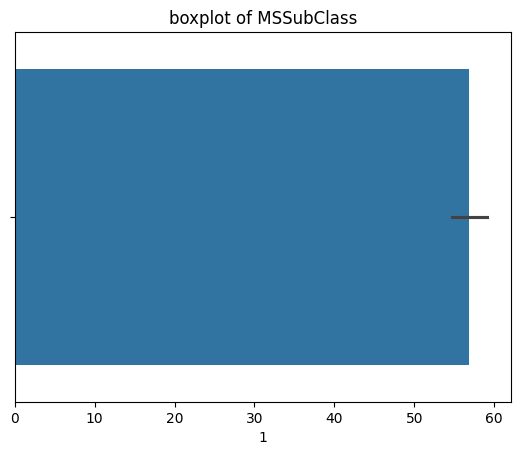

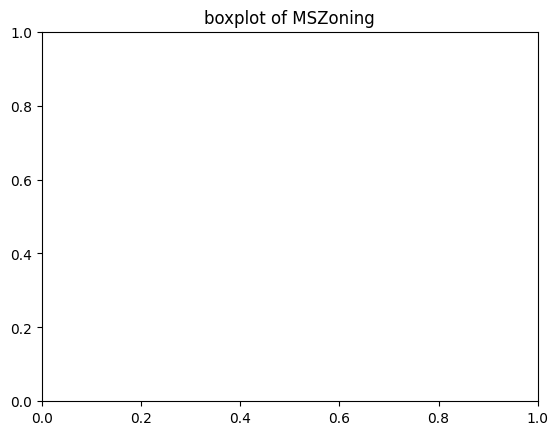

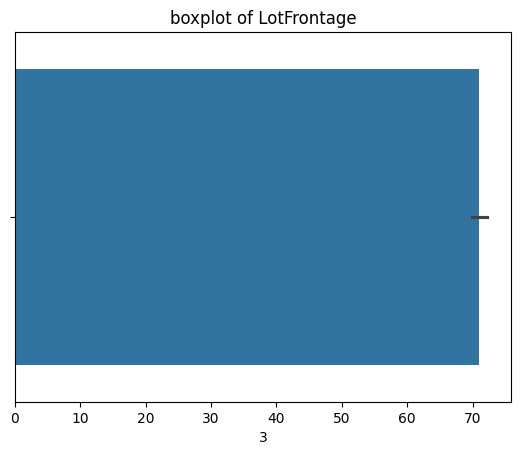

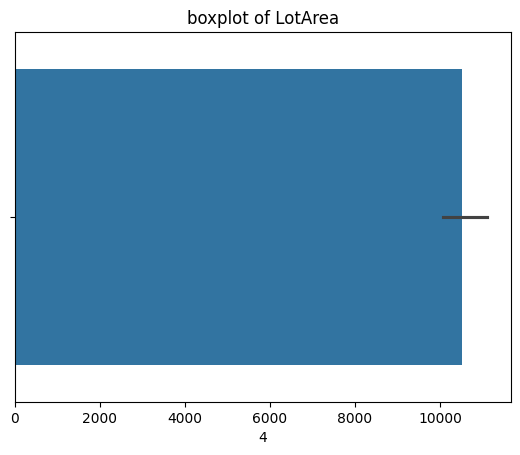

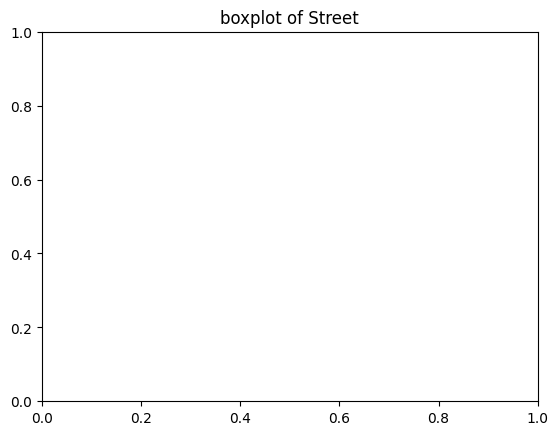

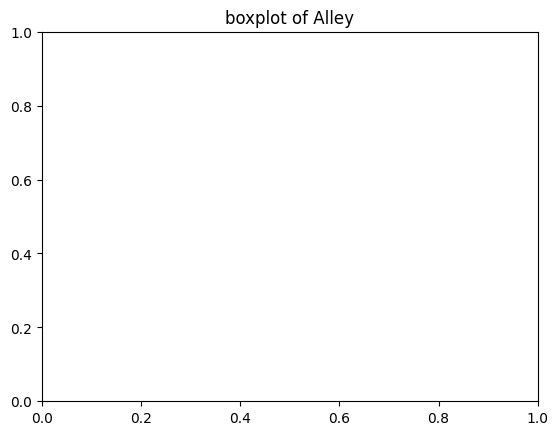

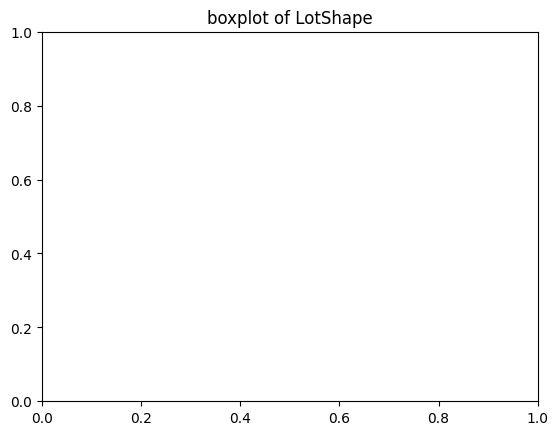

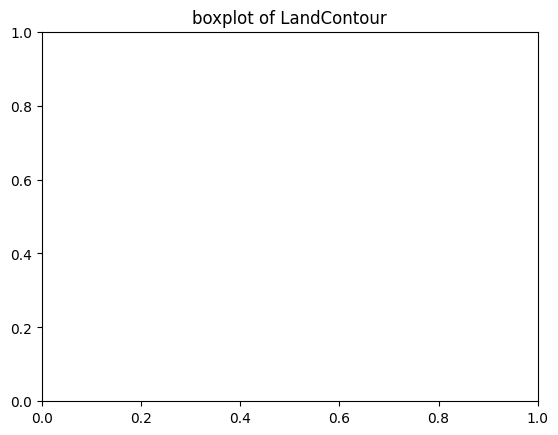

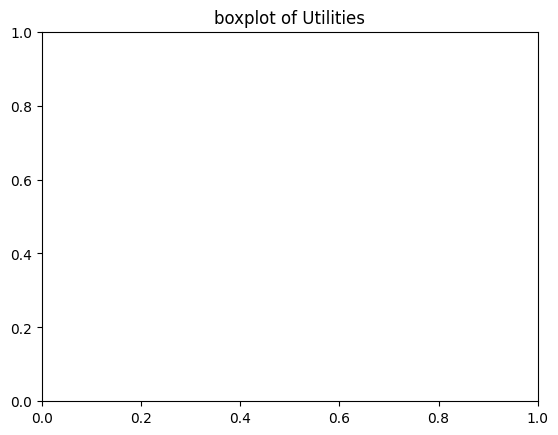

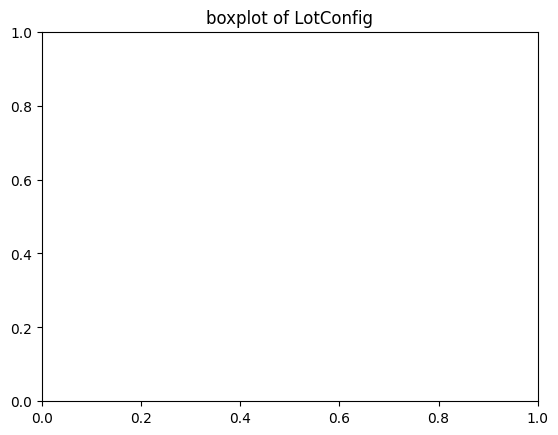

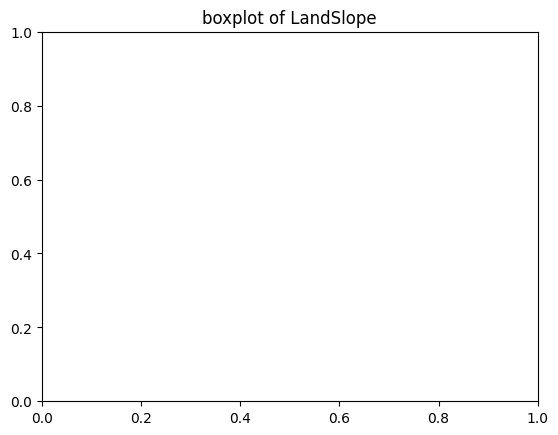

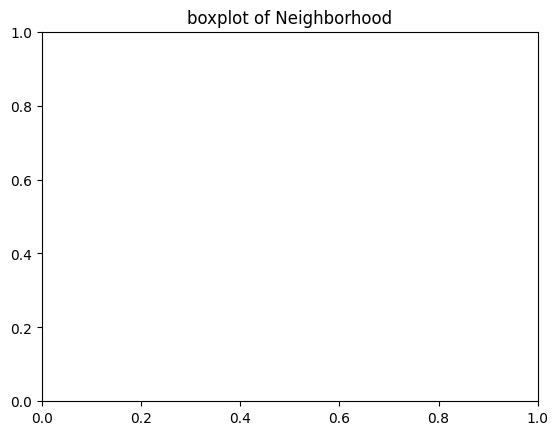

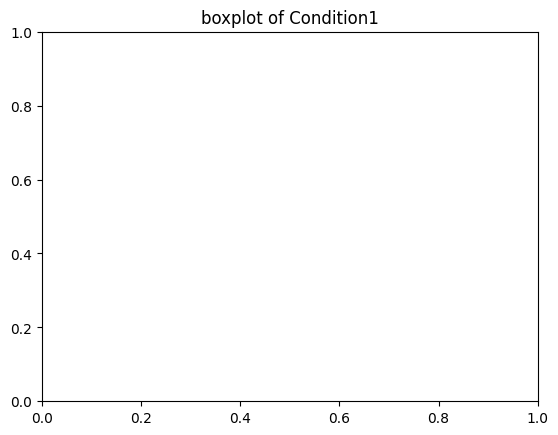

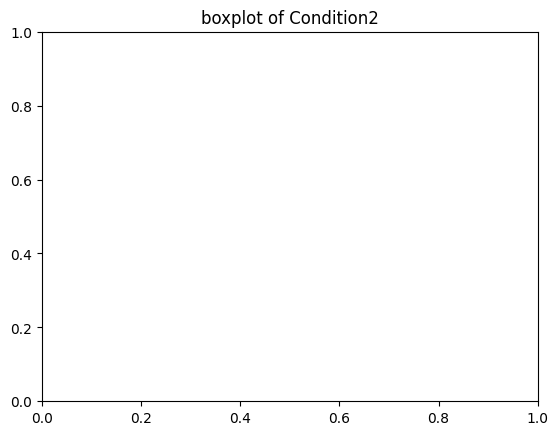

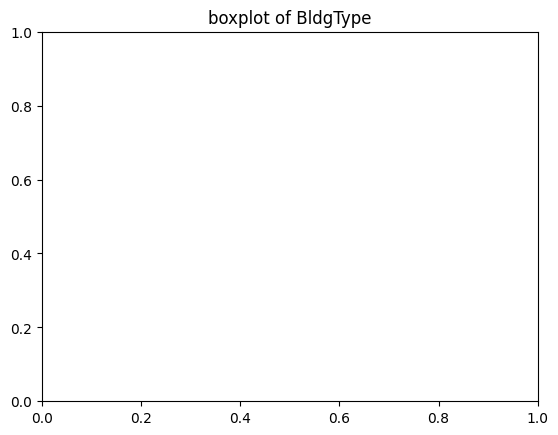

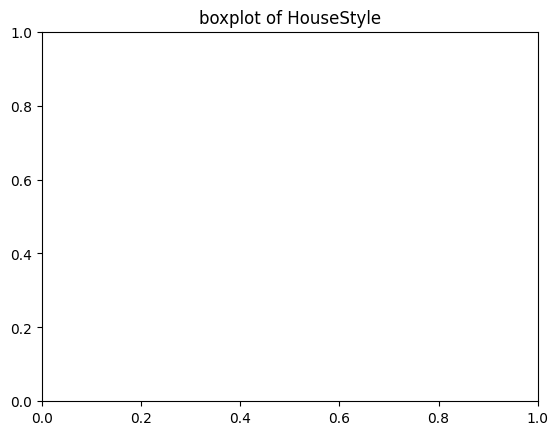

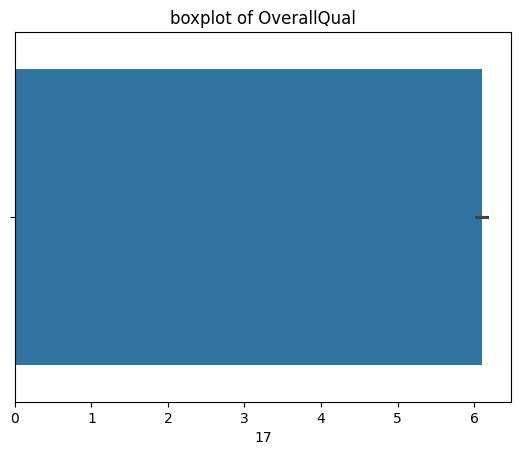

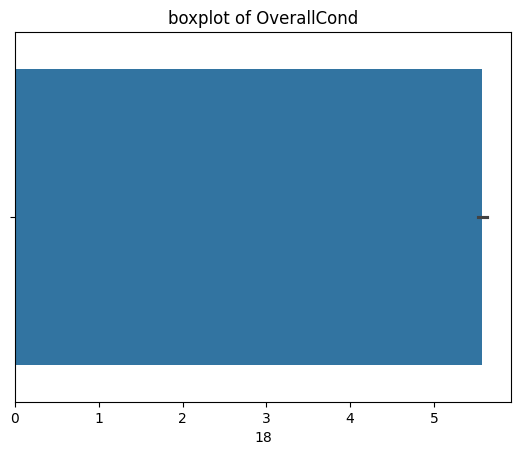

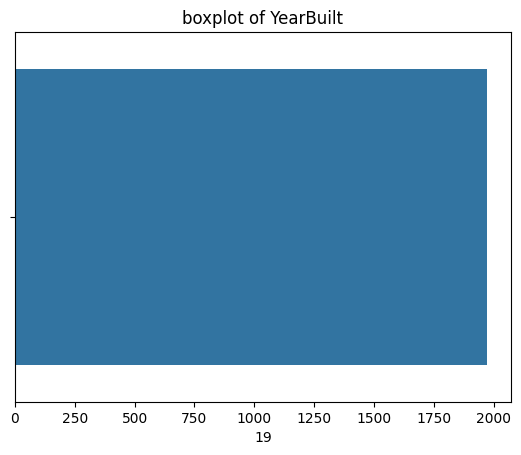

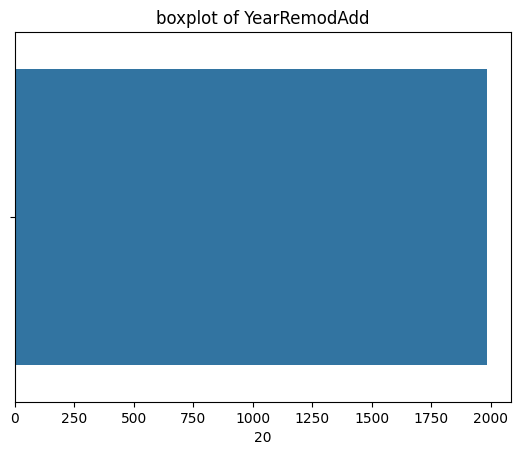

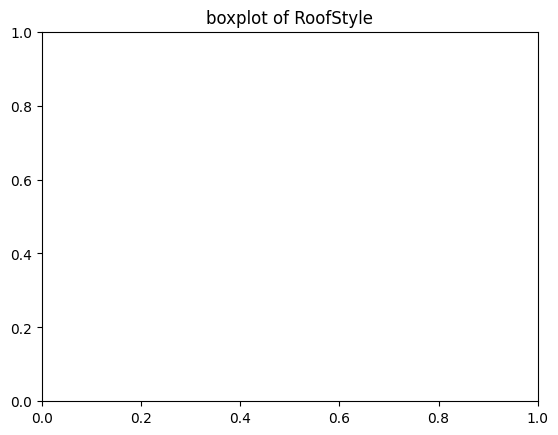

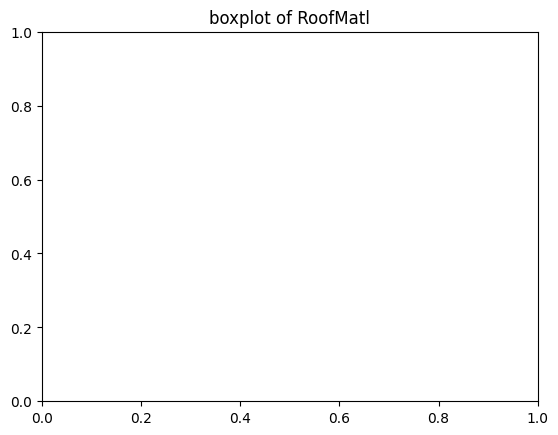

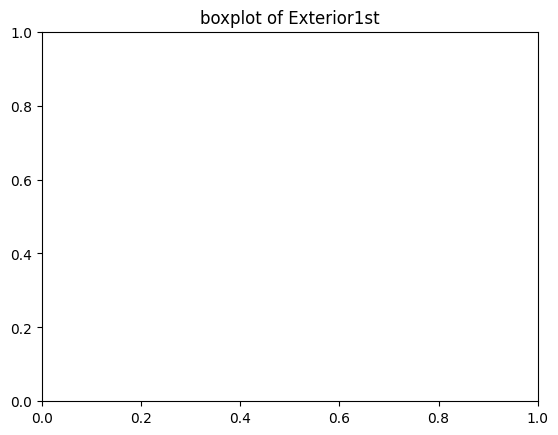

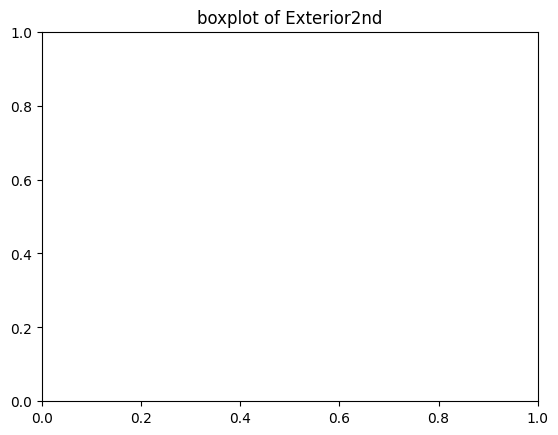

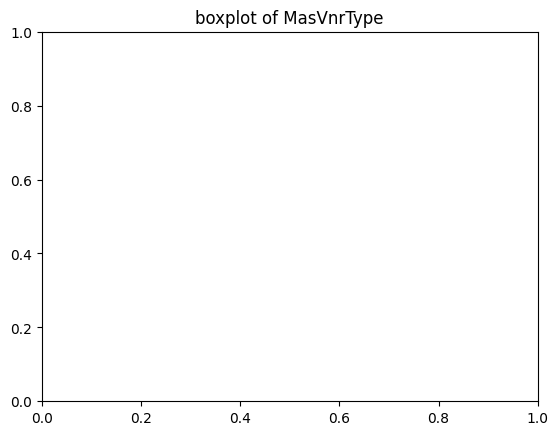

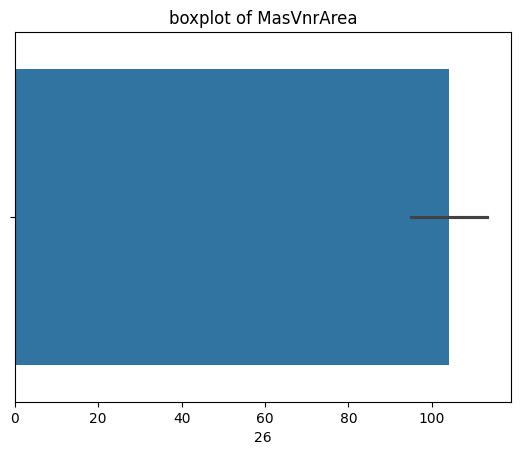

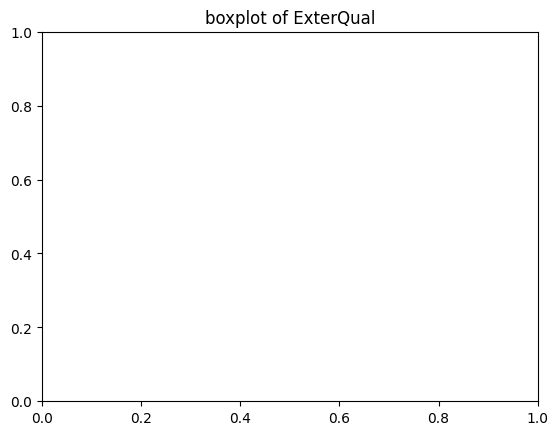

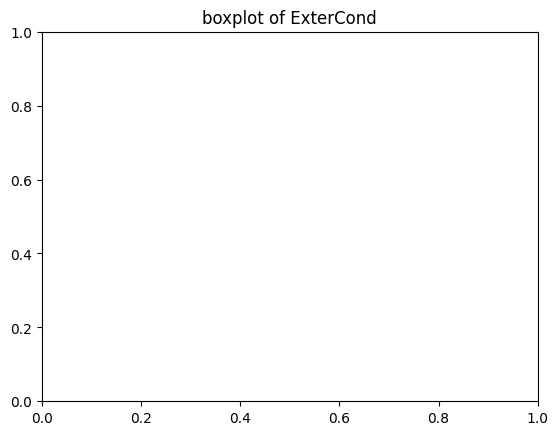

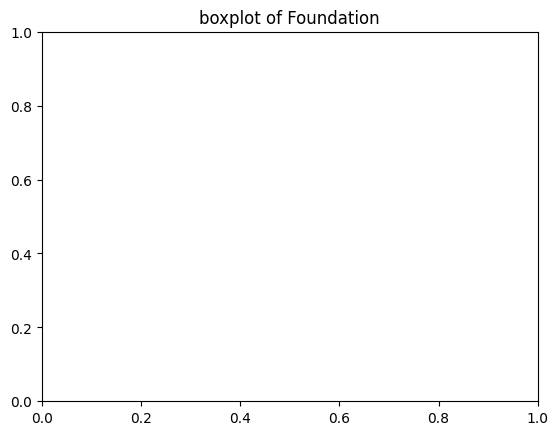

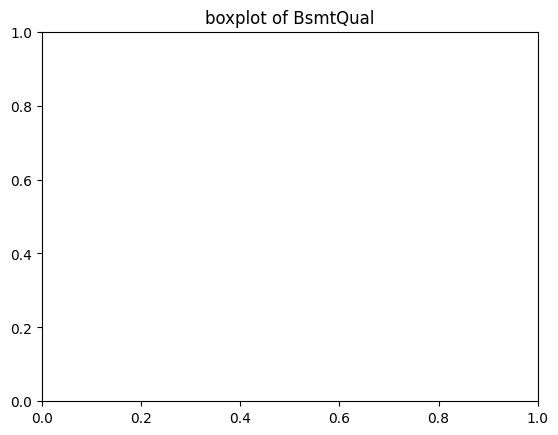

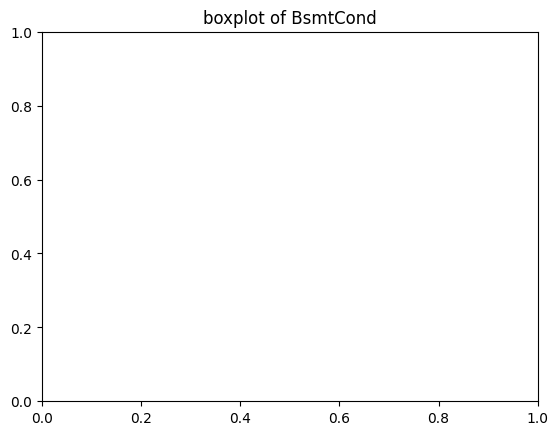

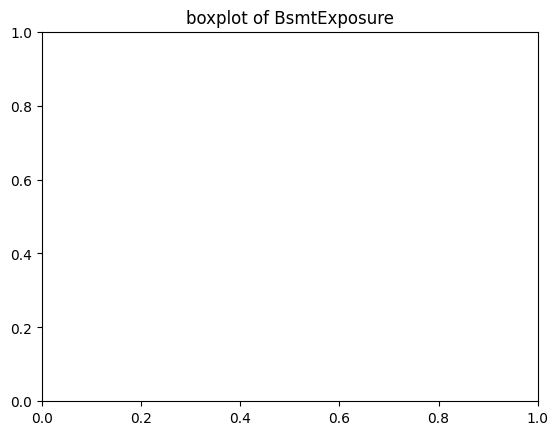

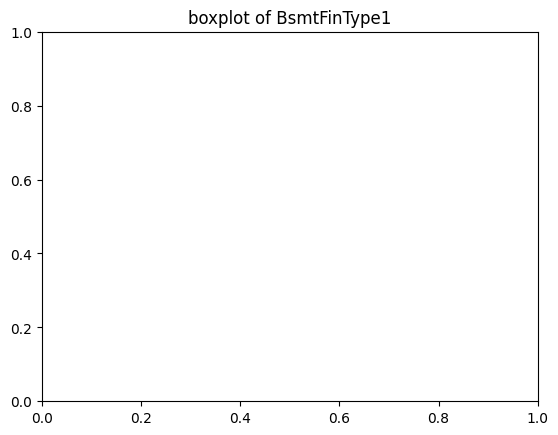

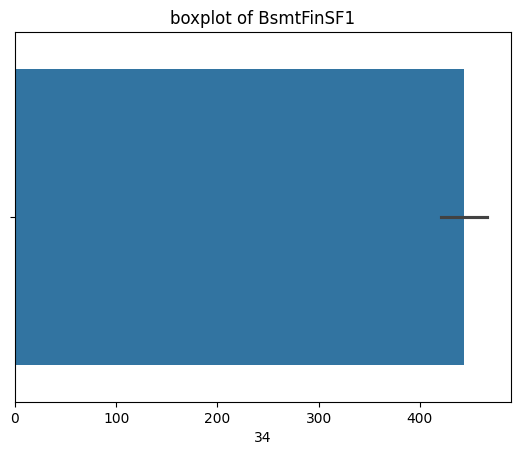

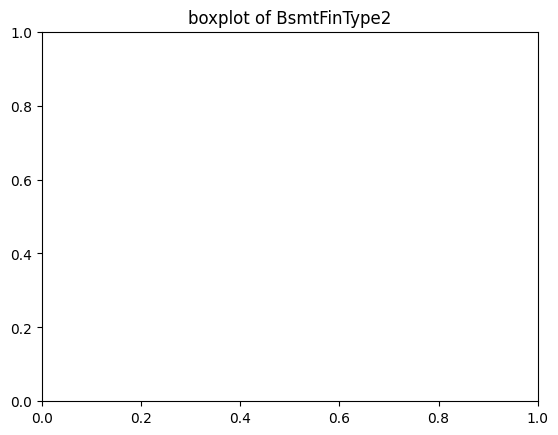

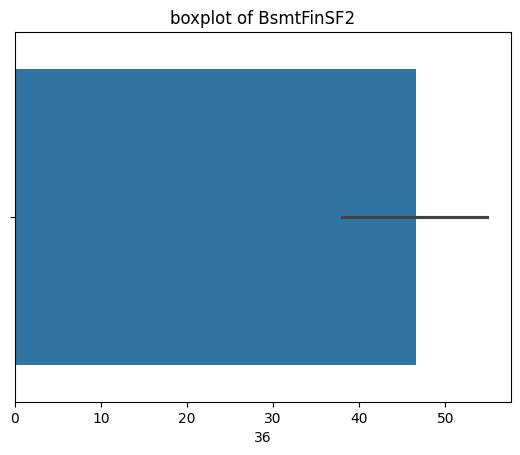

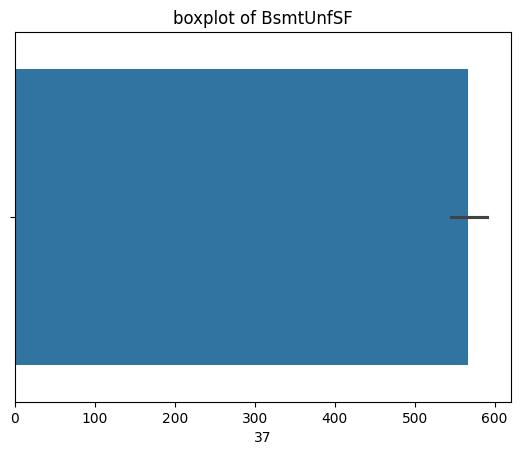

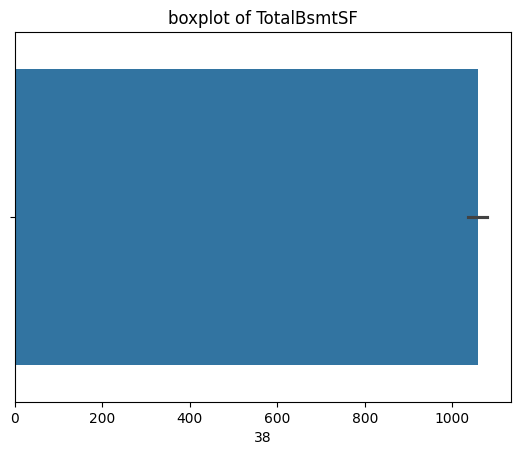

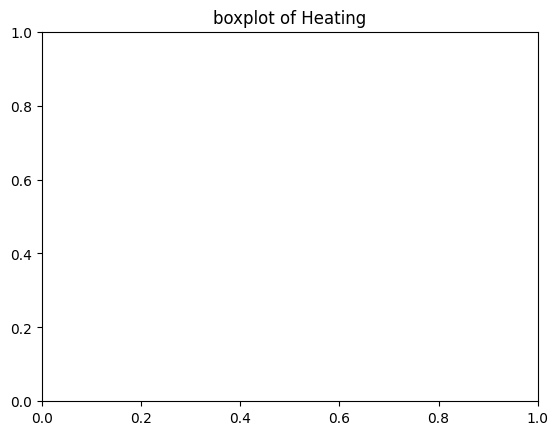

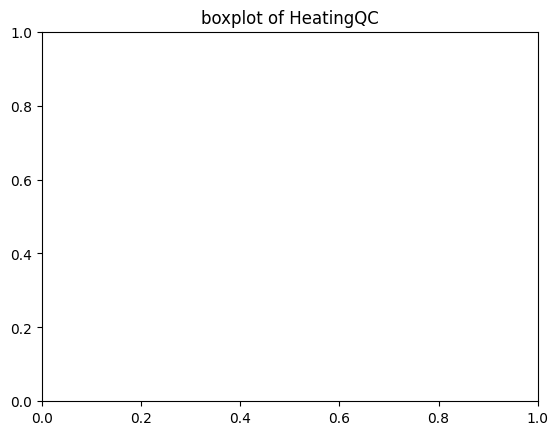

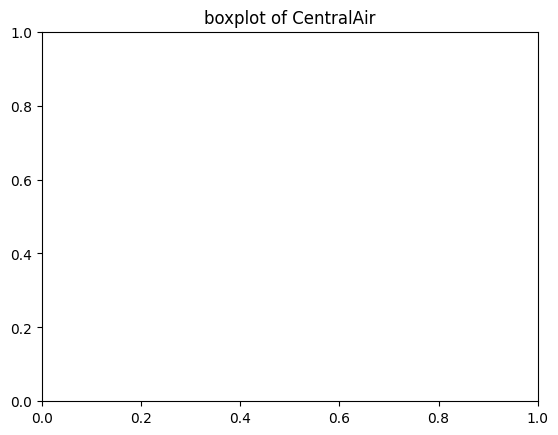

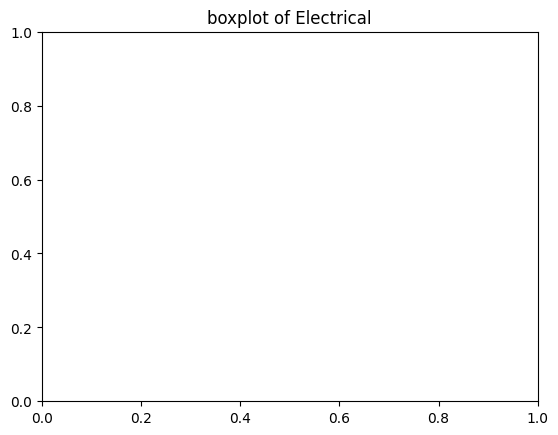

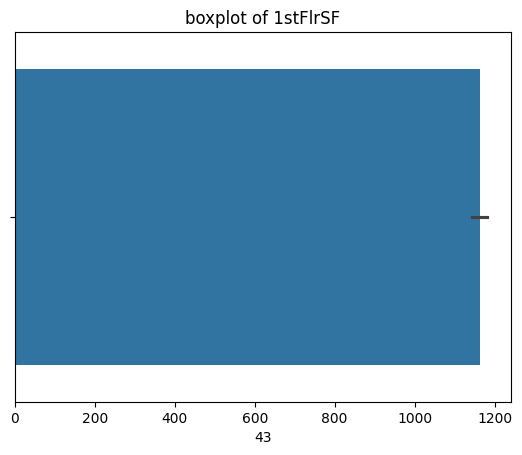

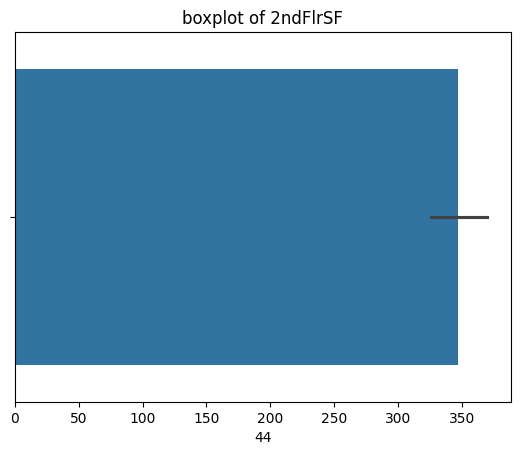

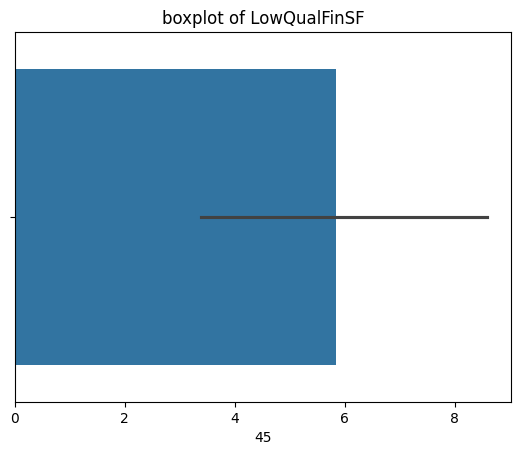

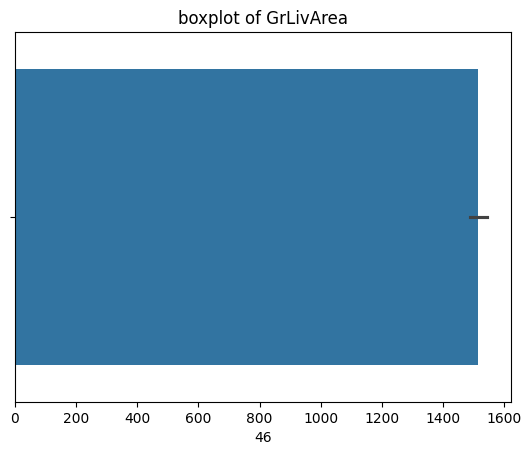

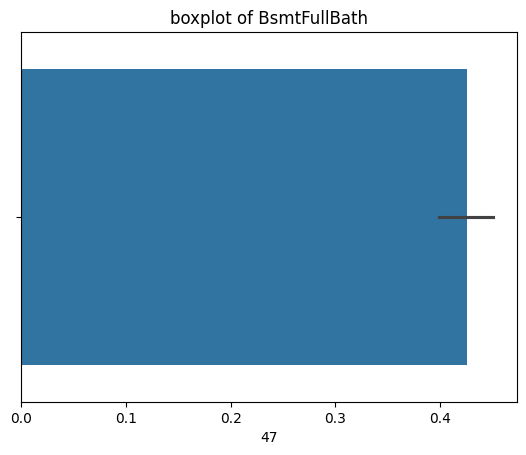

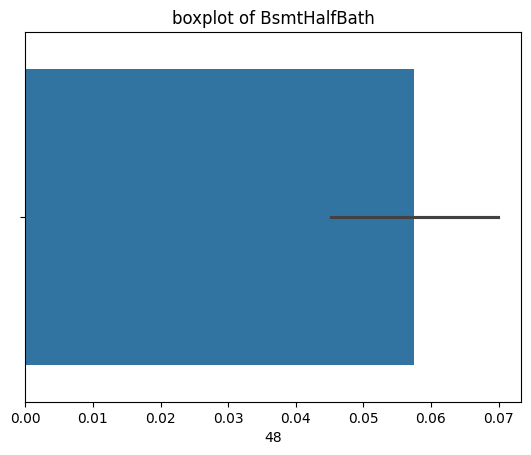

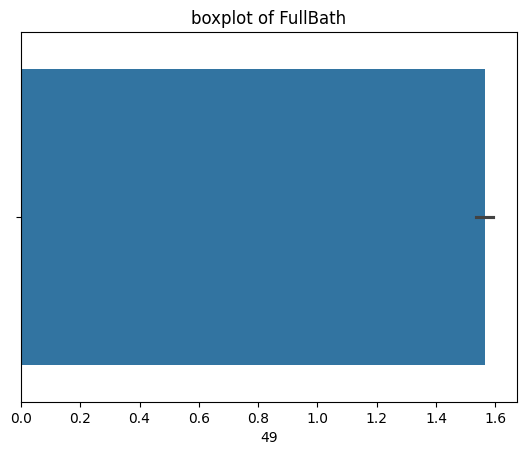

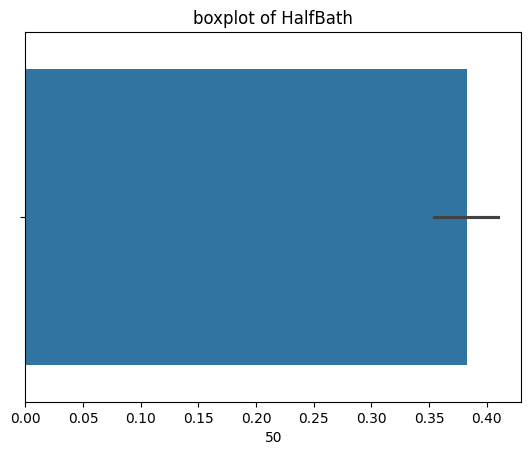

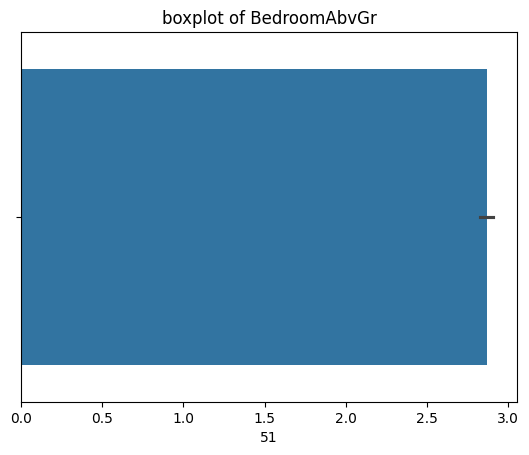

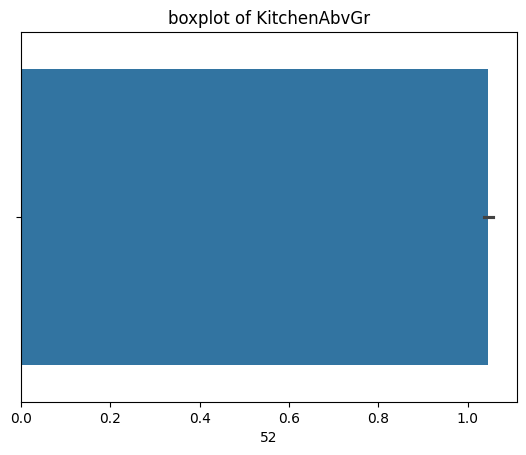

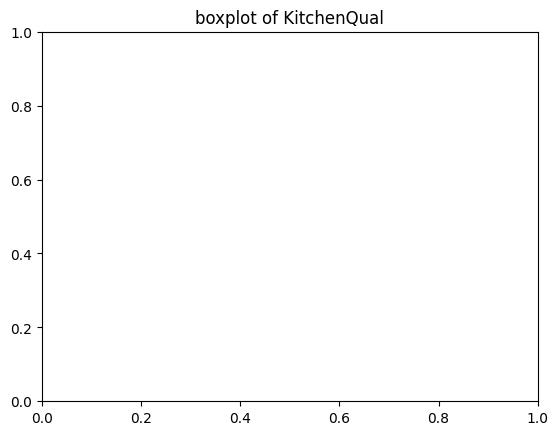

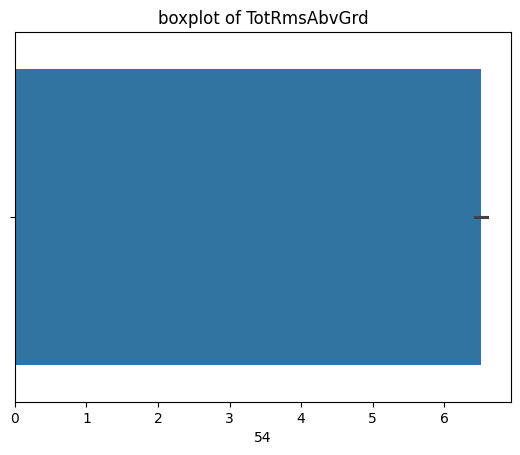

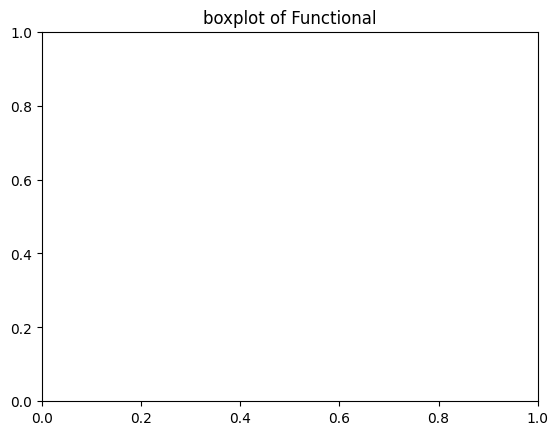

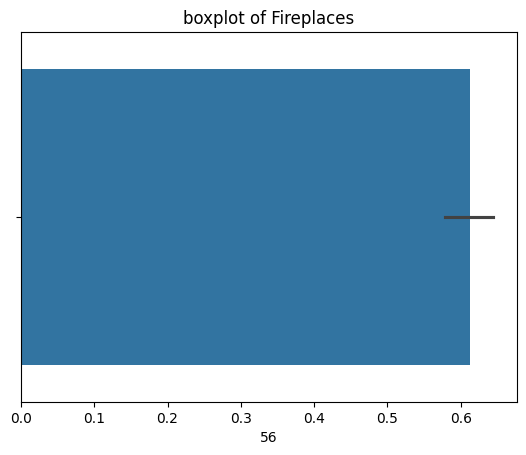

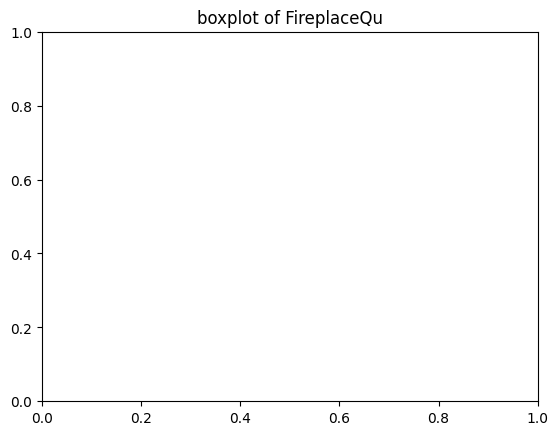

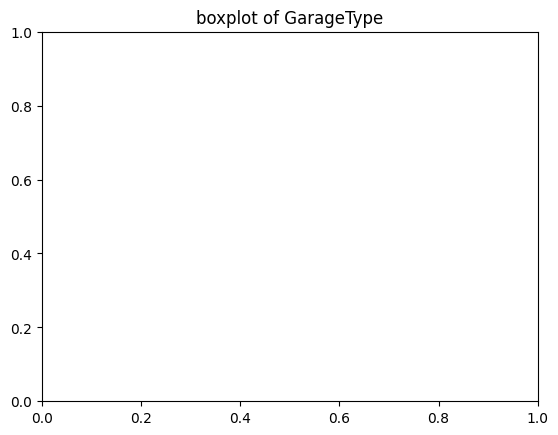

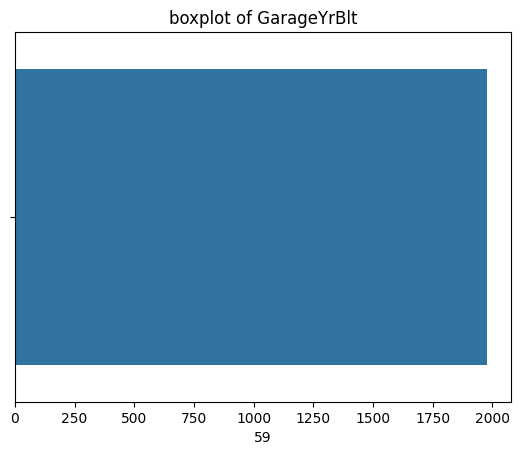

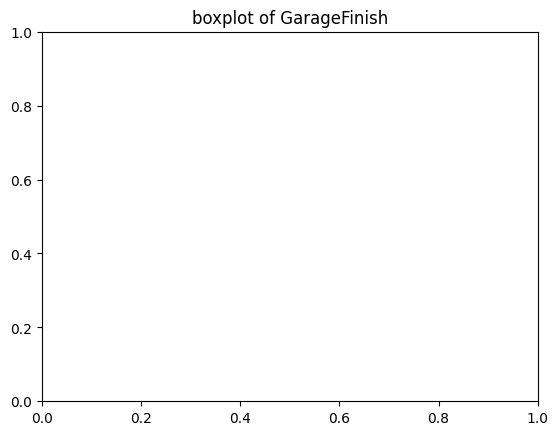

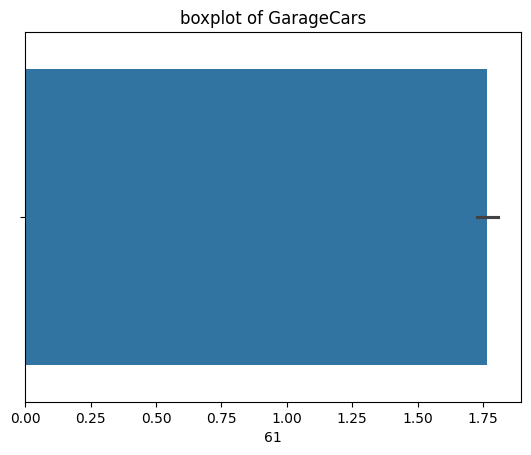

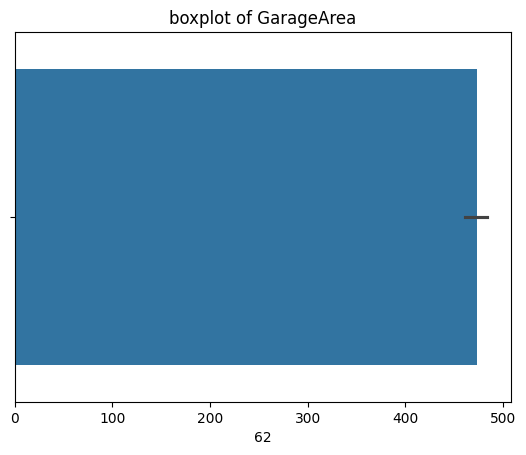

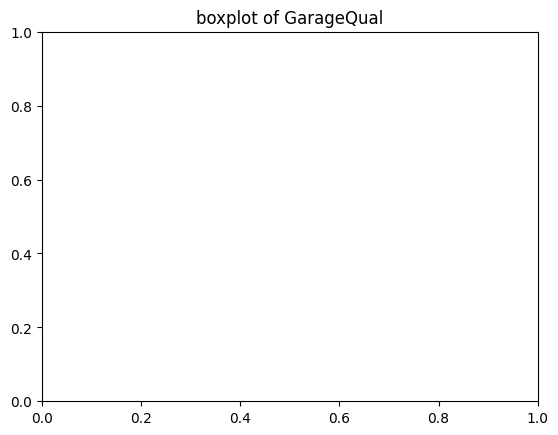

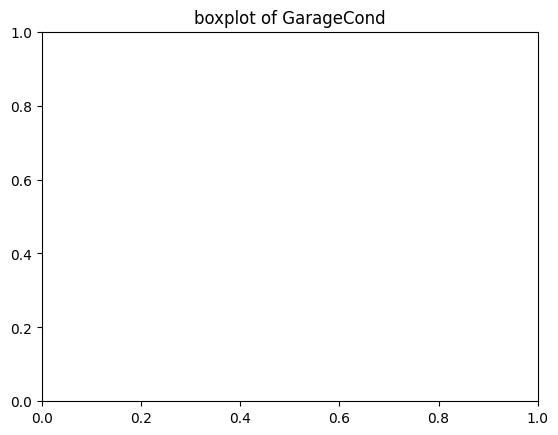

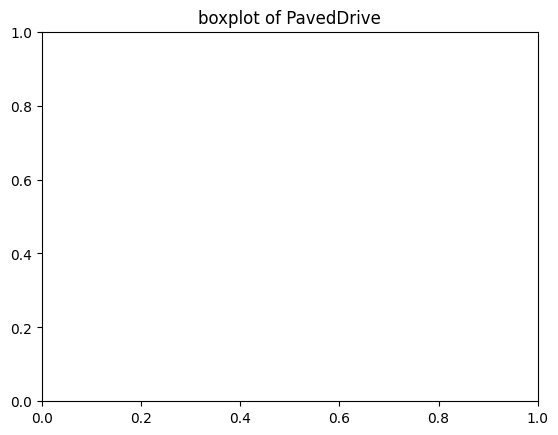

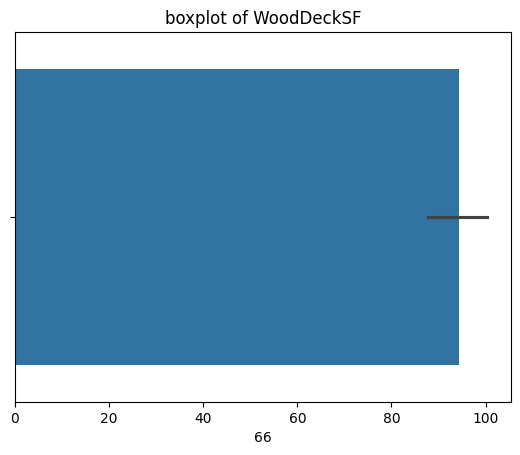

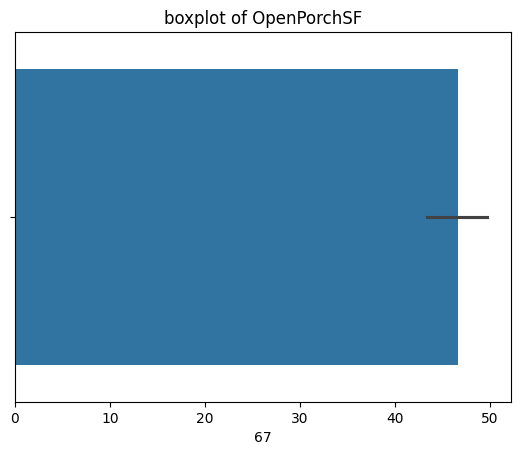

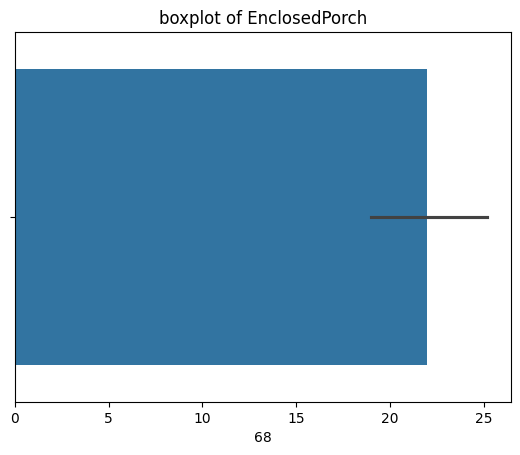

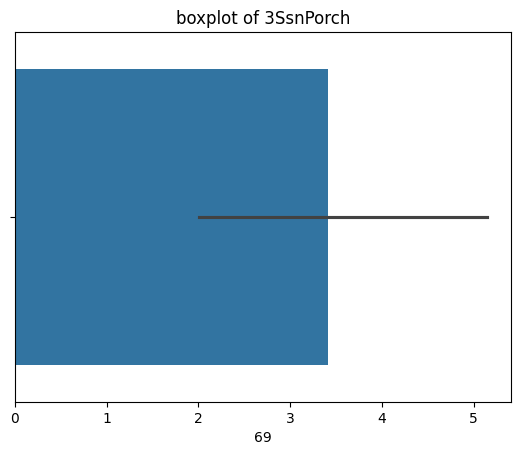

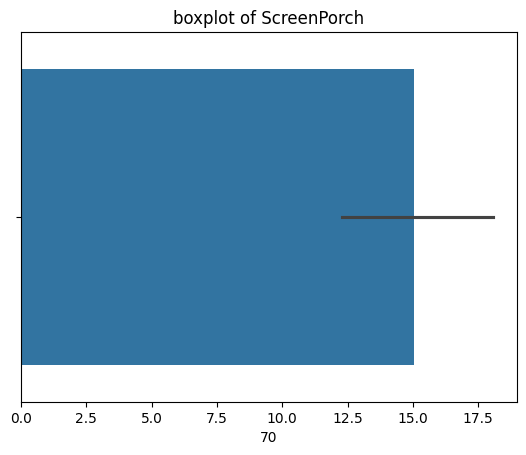

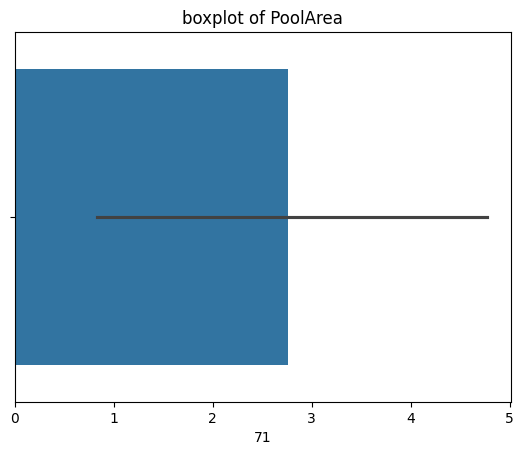

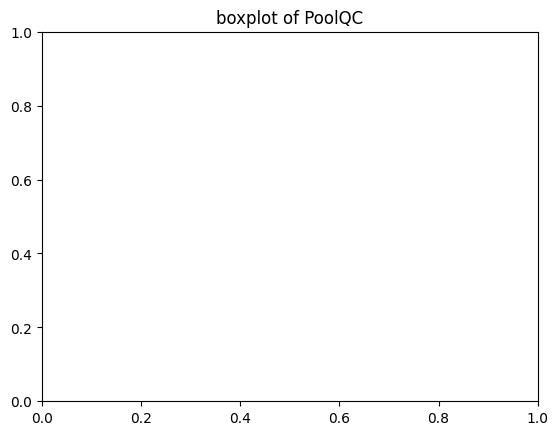

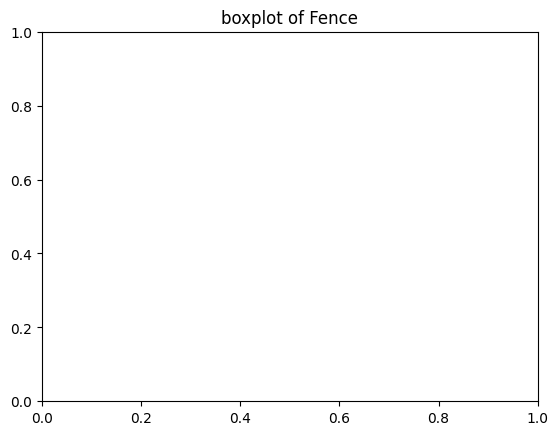

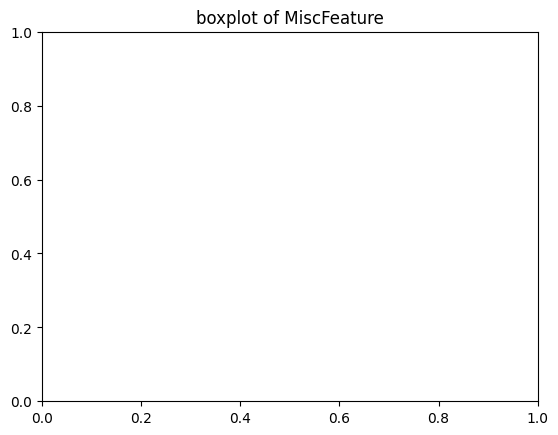

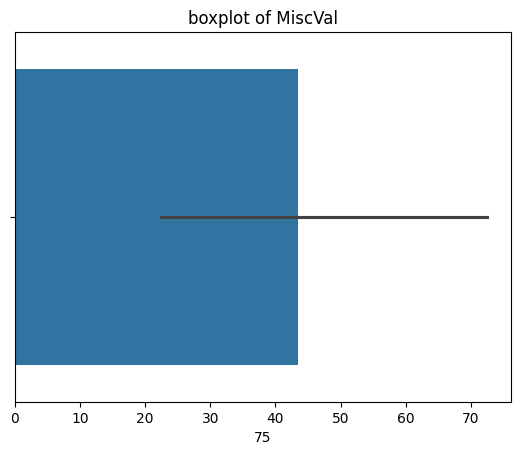

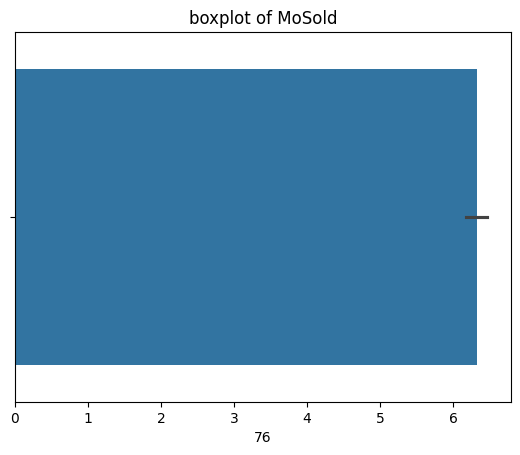

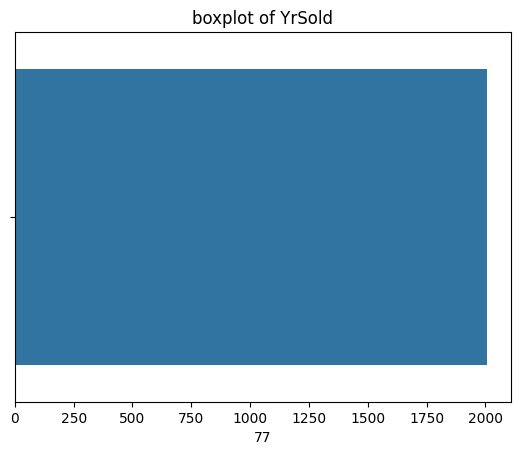

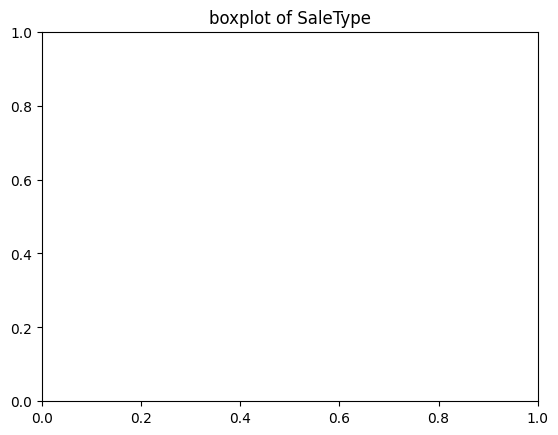

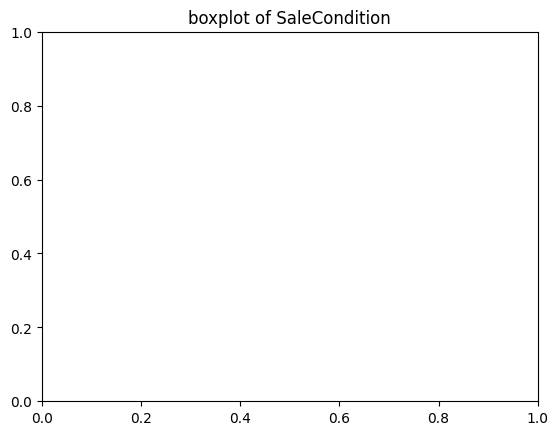

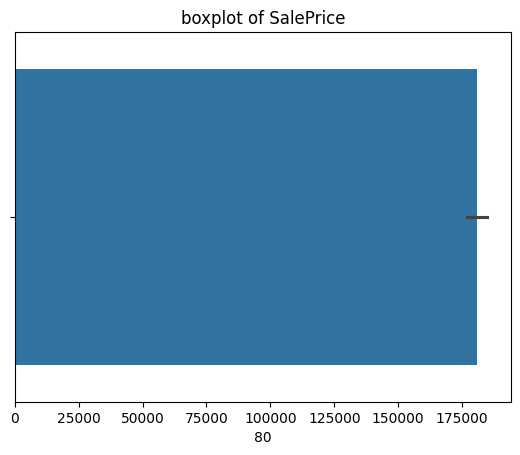

In [14]:
display_boxplot(train_csv)

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


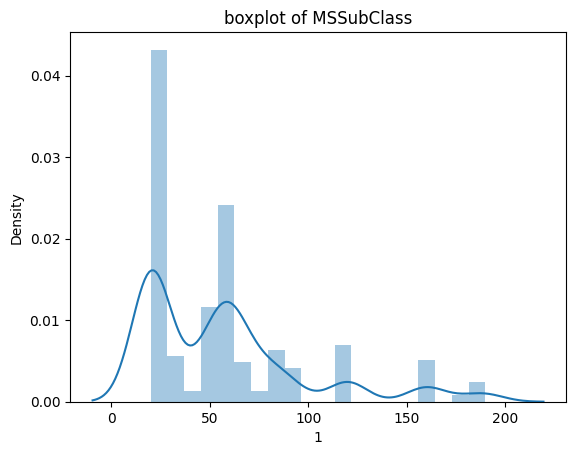

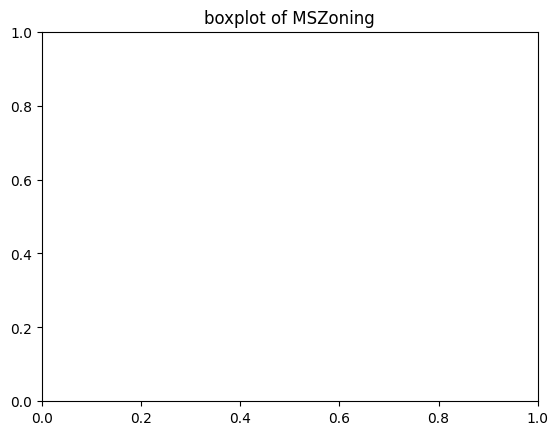

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


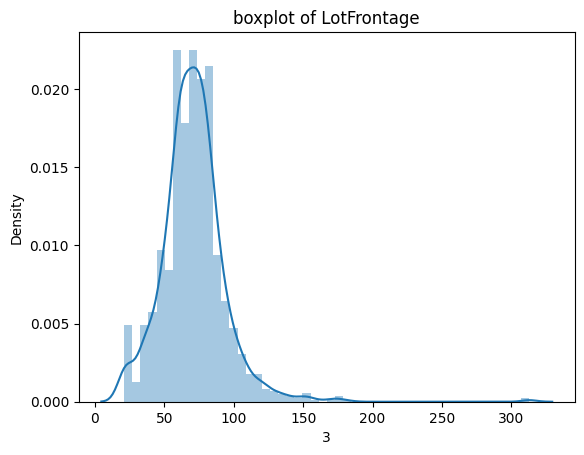

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


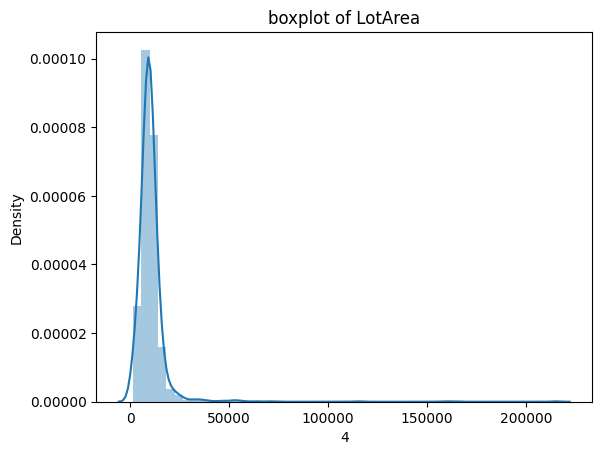

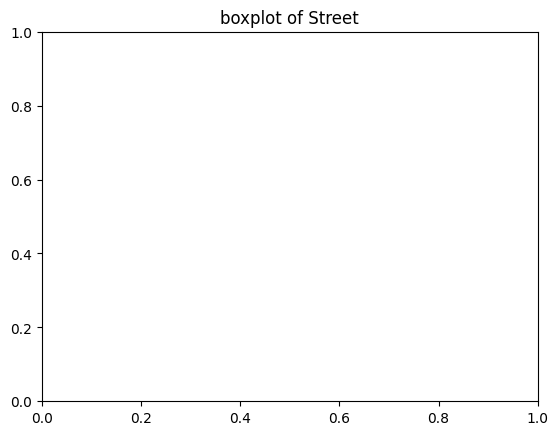

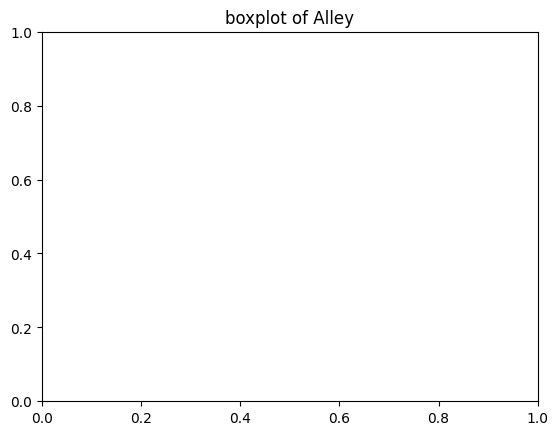

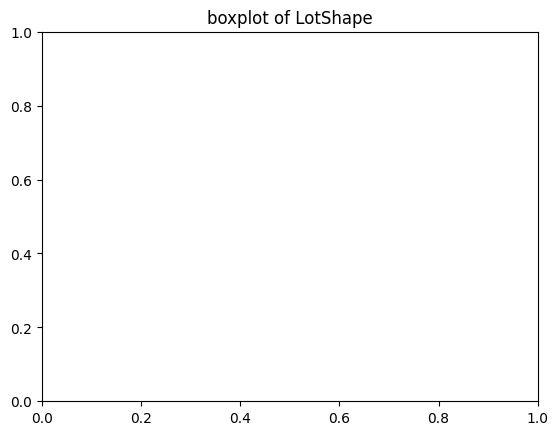

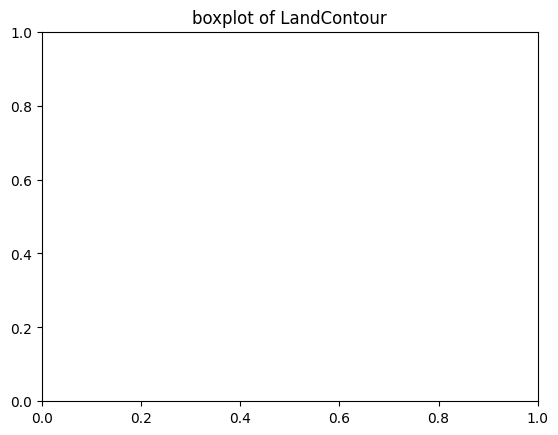

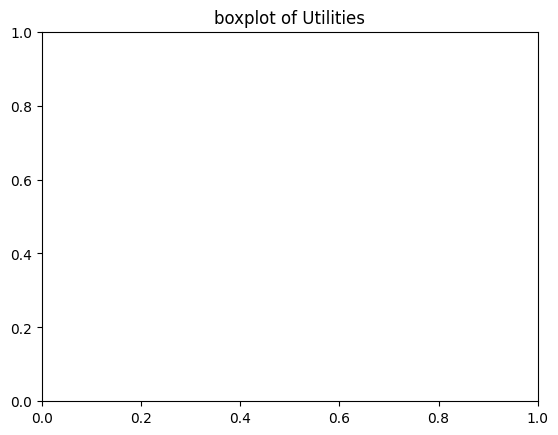

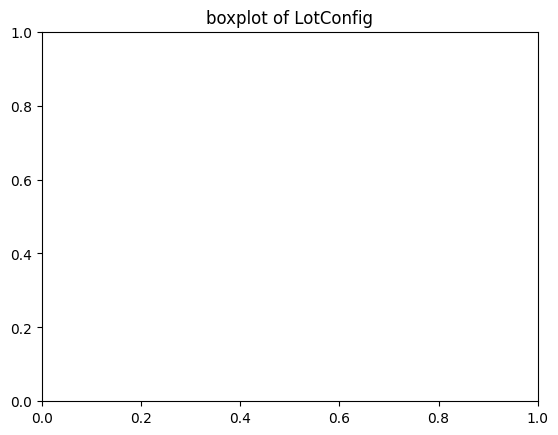

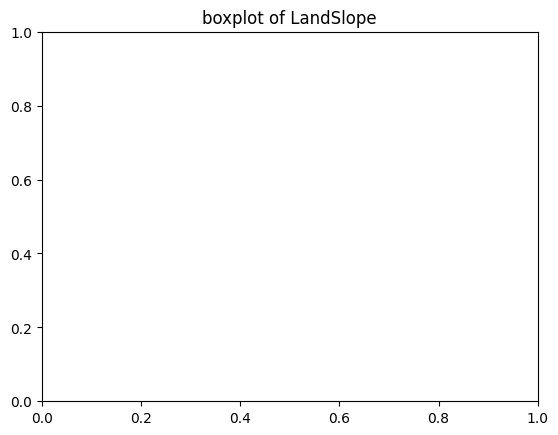

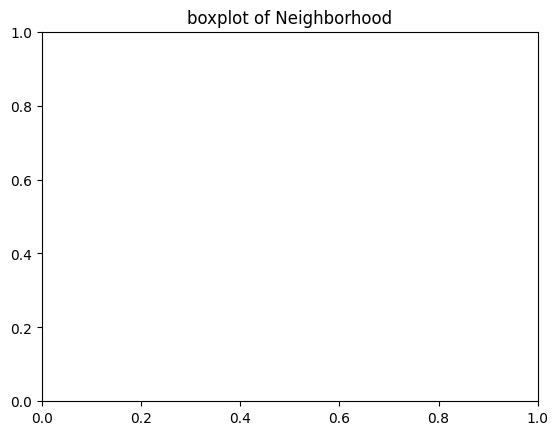

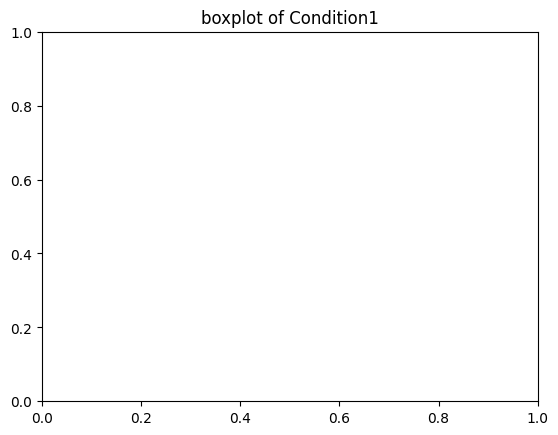

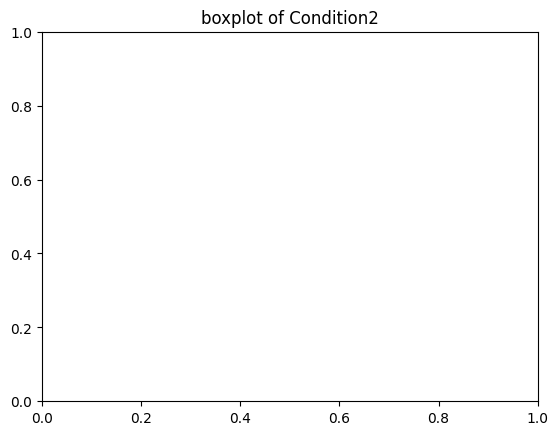

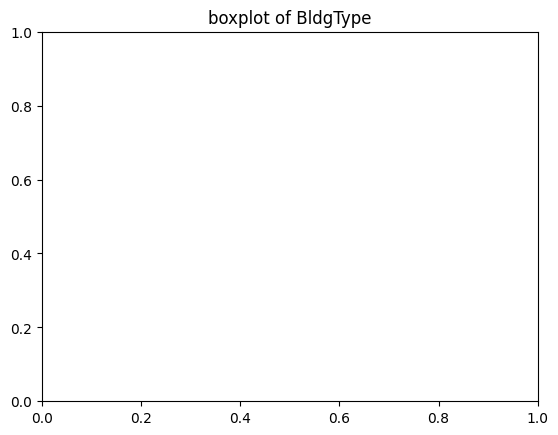

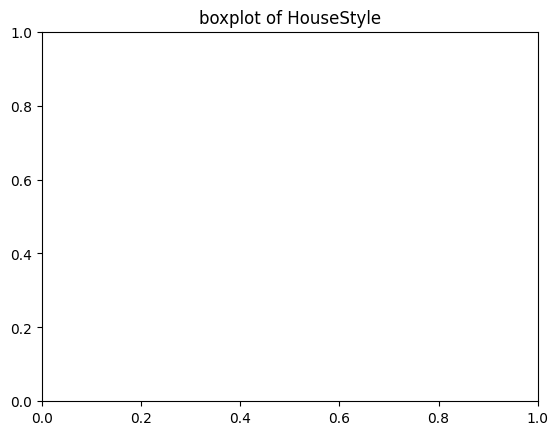

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


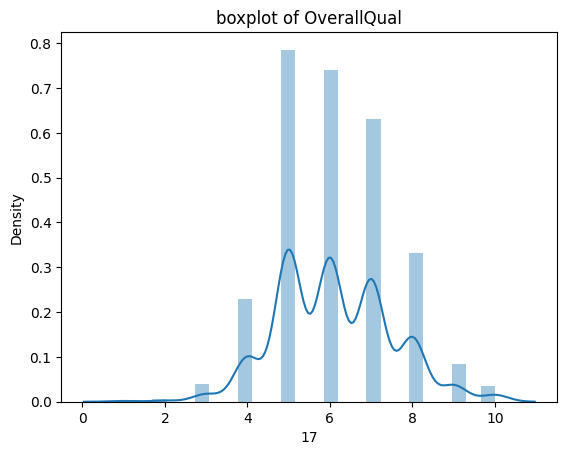

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


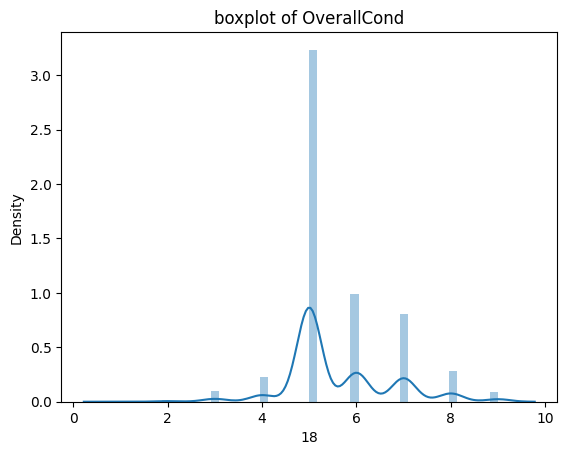

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


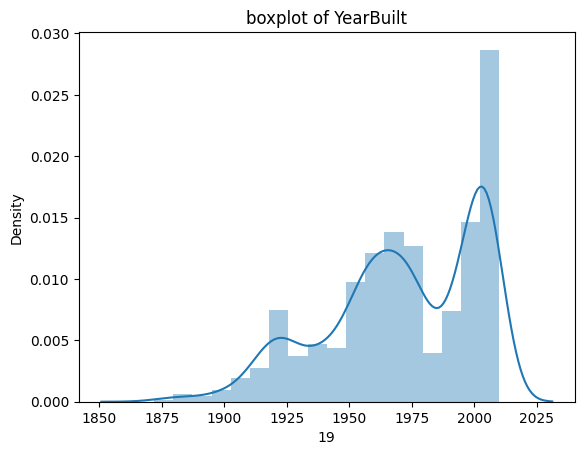

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


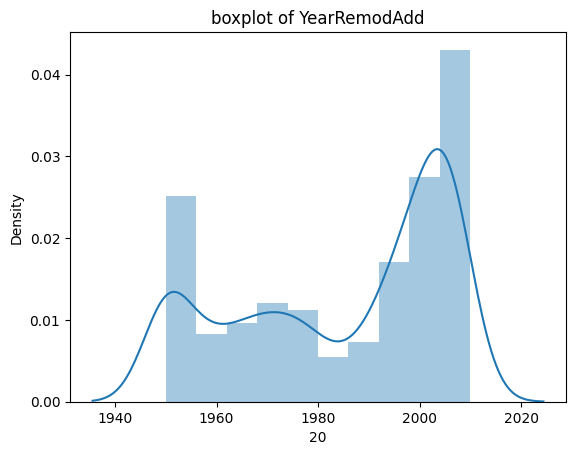

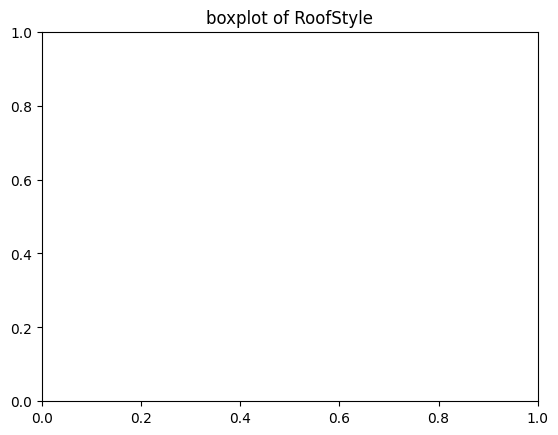

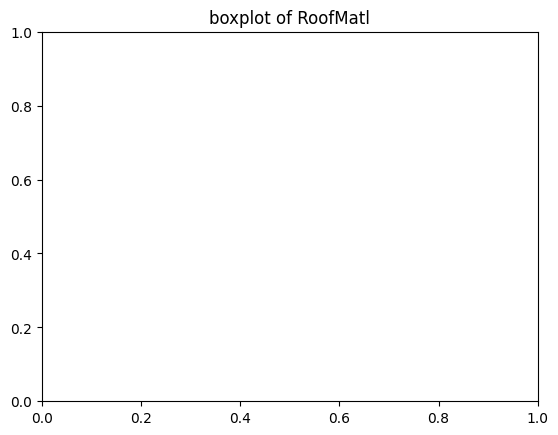

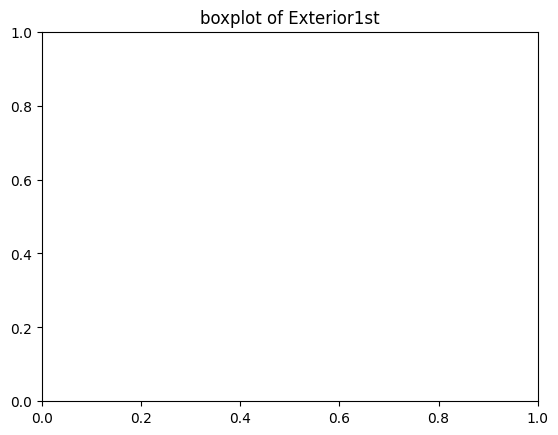

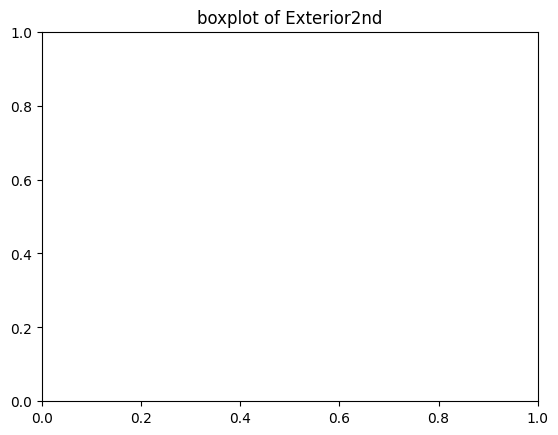

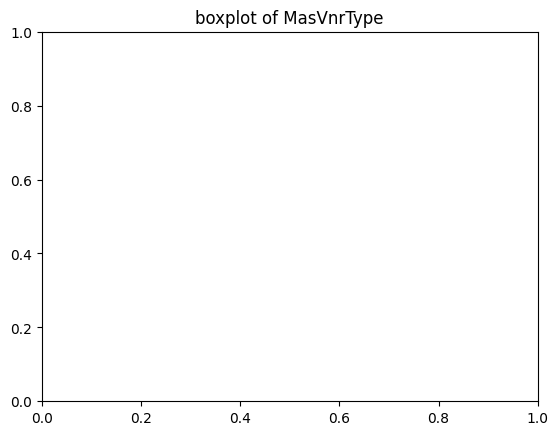

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


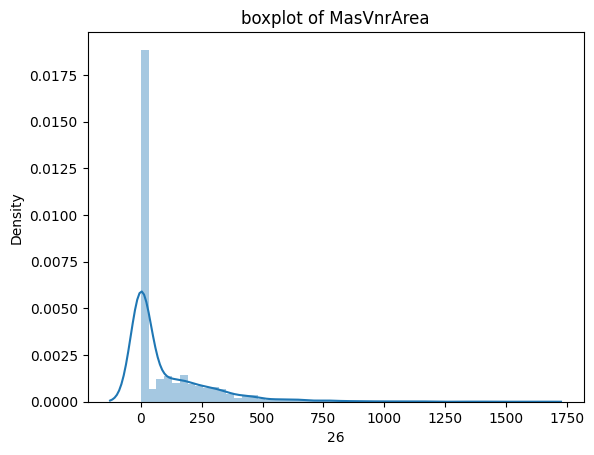

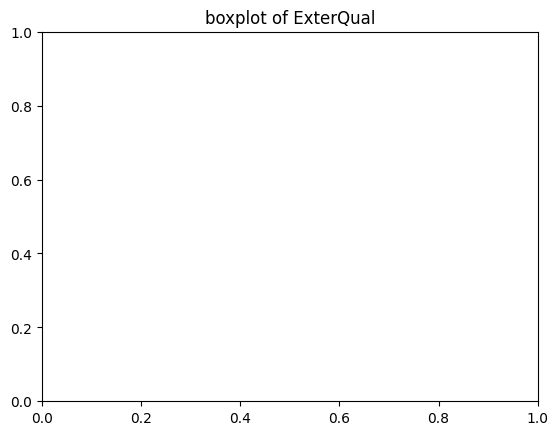

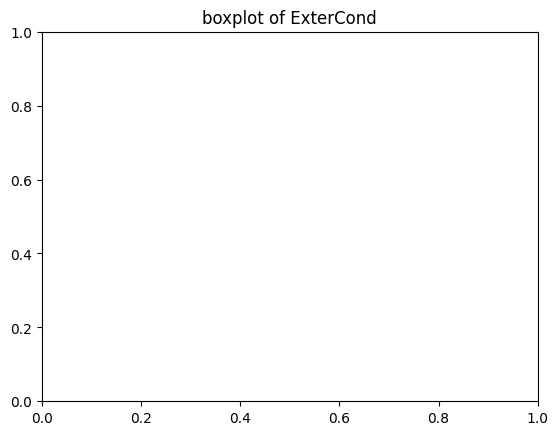

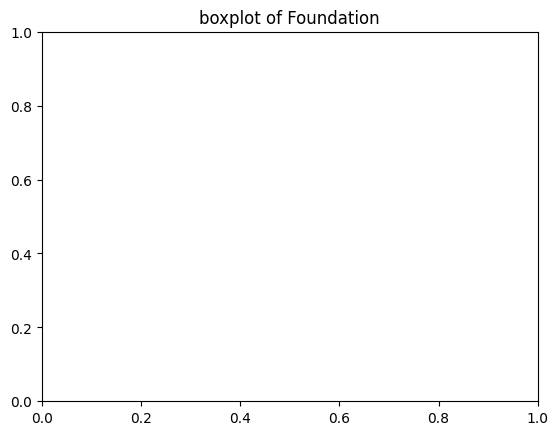

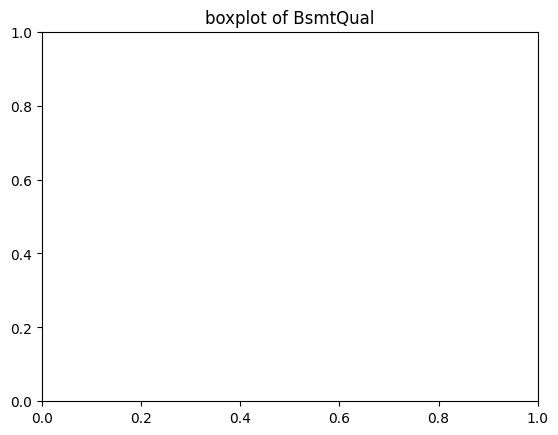

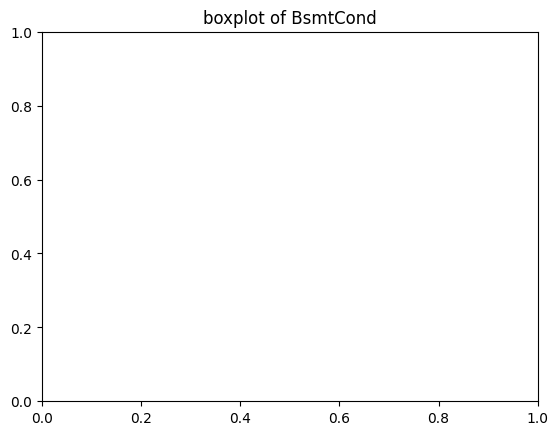

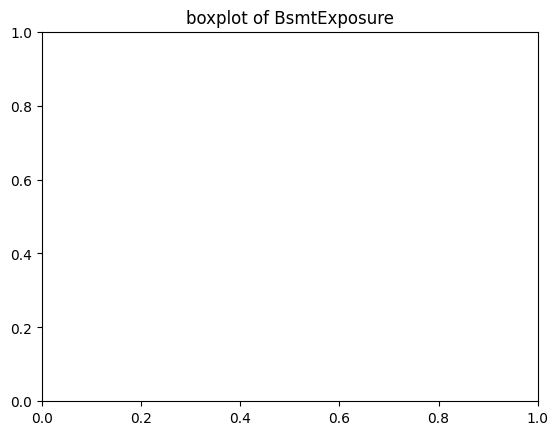

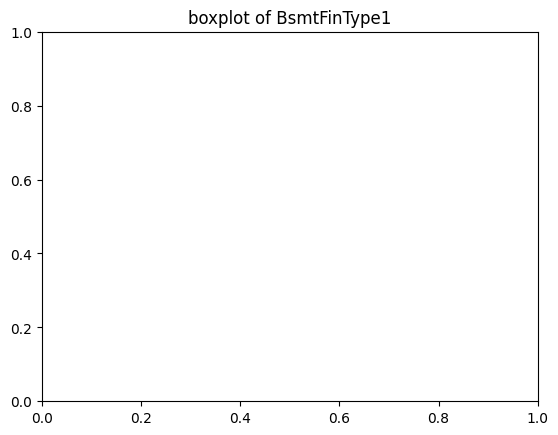

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


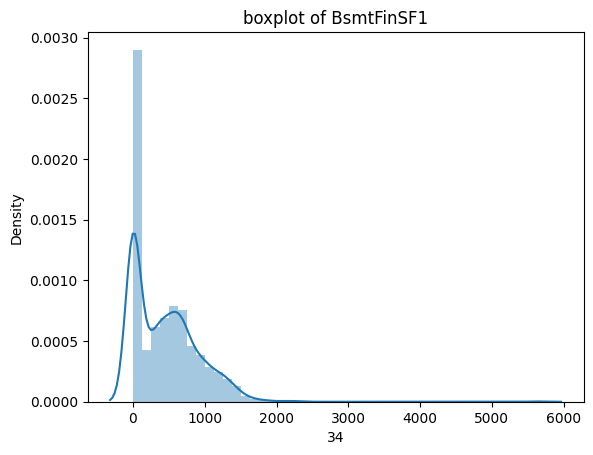

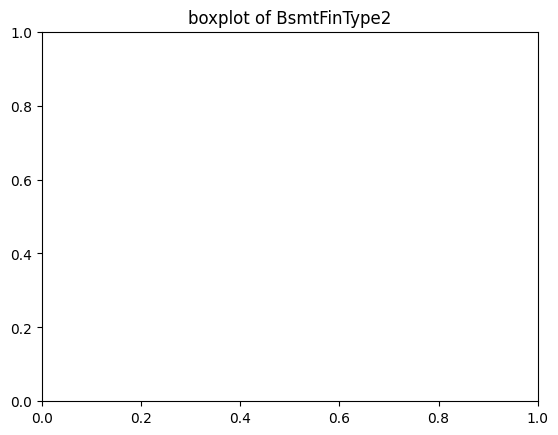

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


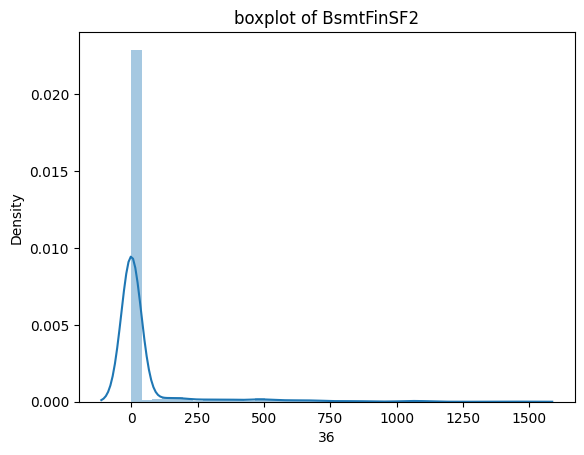

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


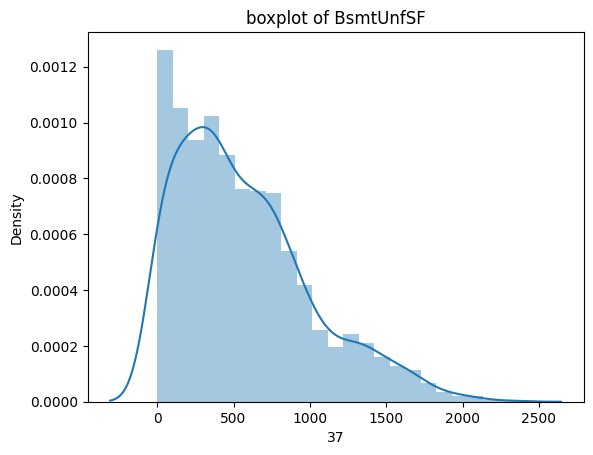

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


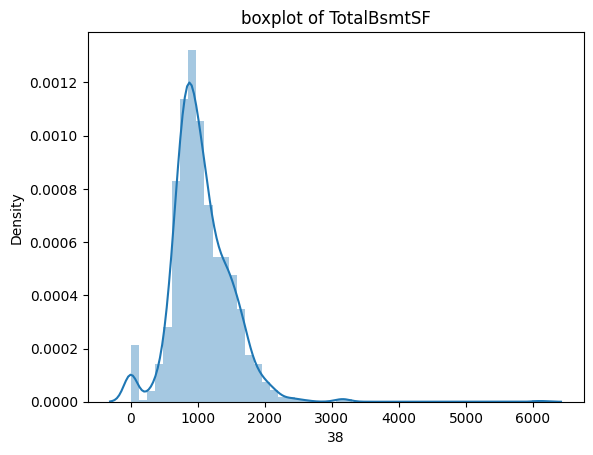

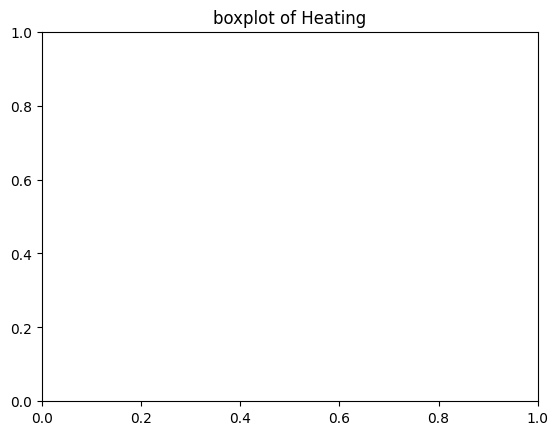

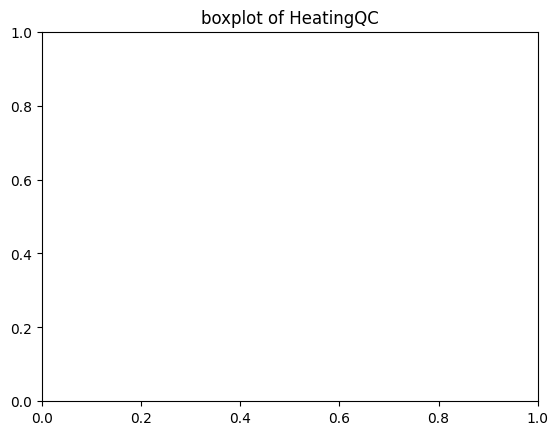

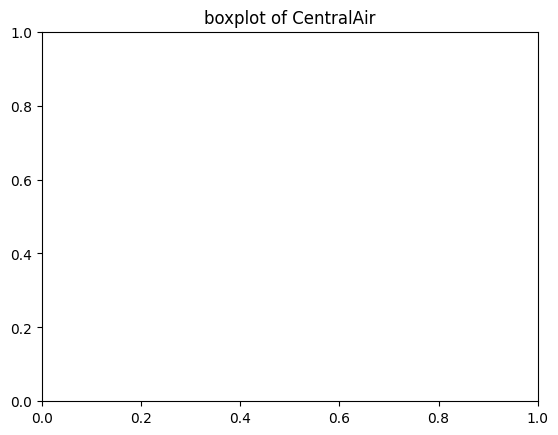

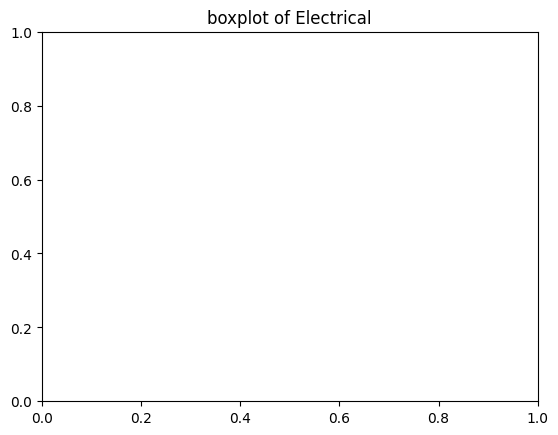

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


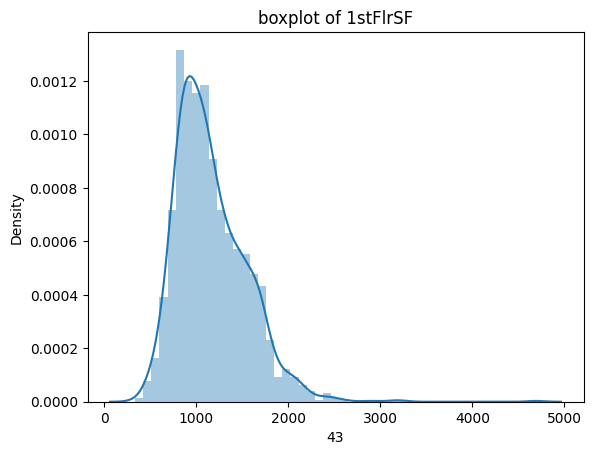

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


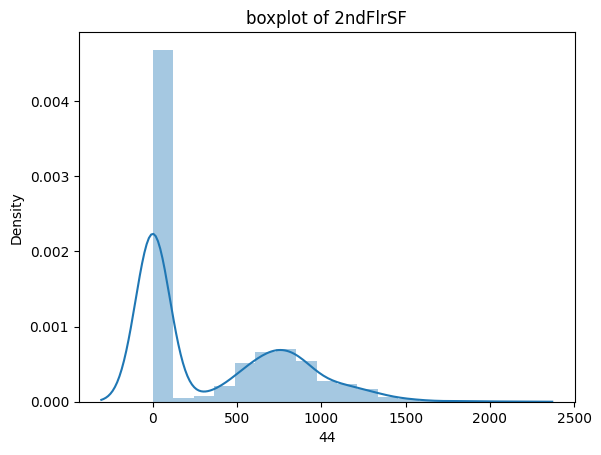

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


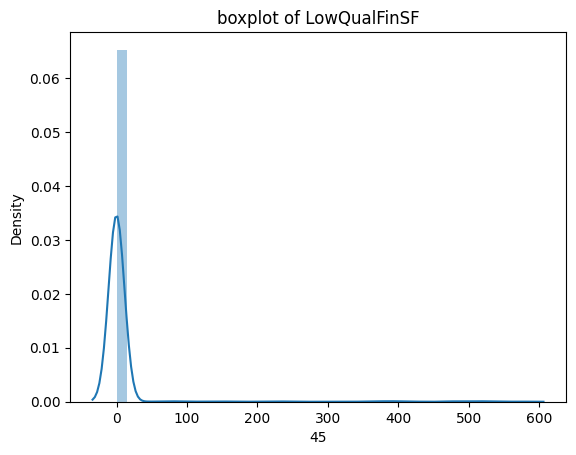

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


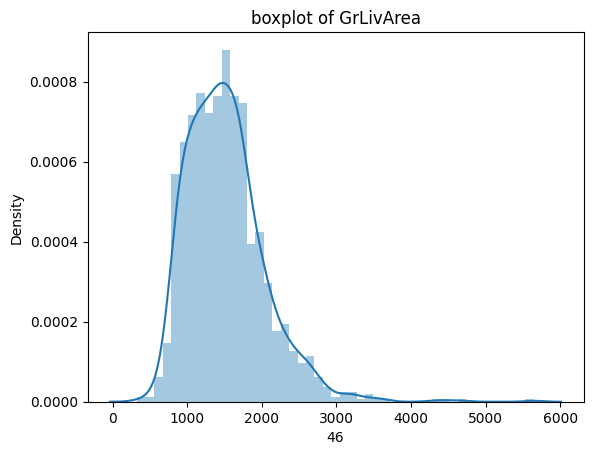

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


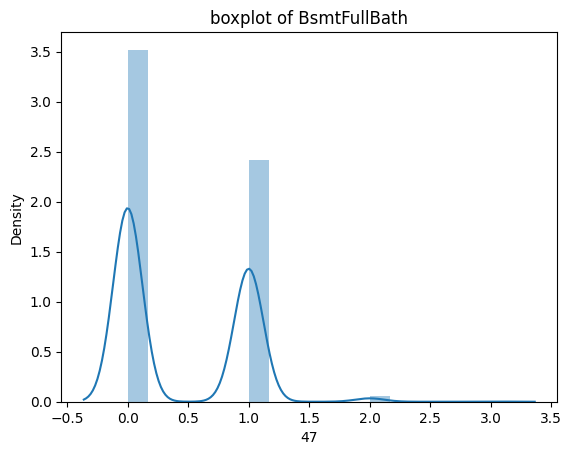

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


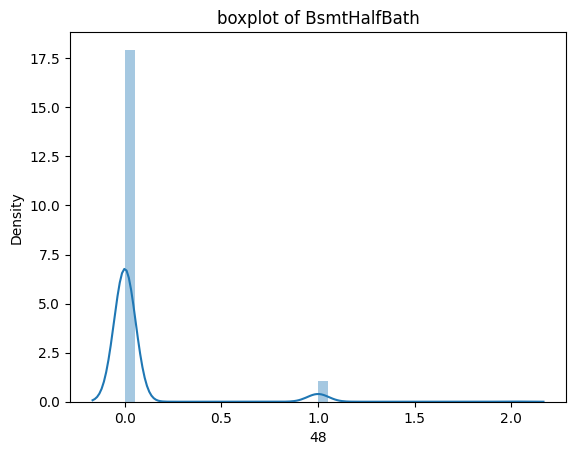

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


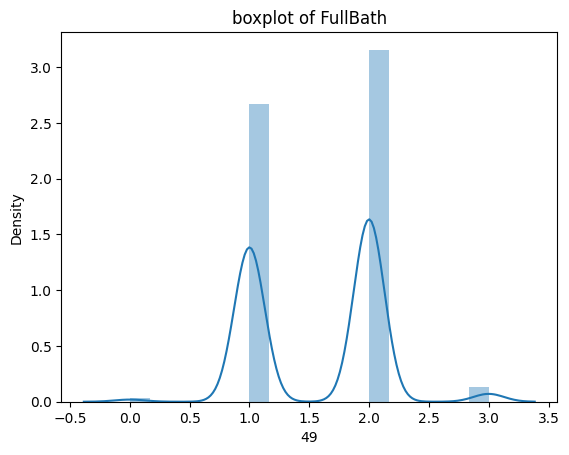

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


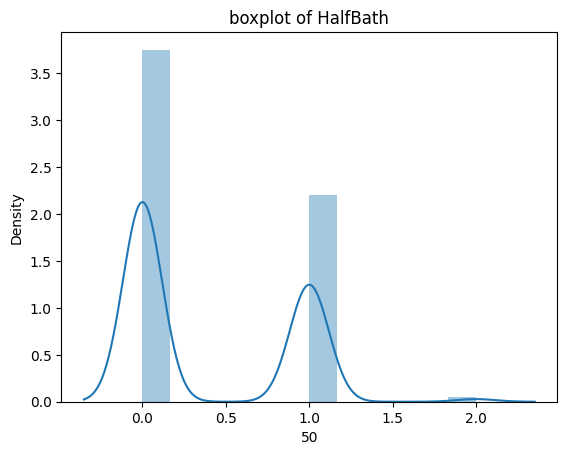

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


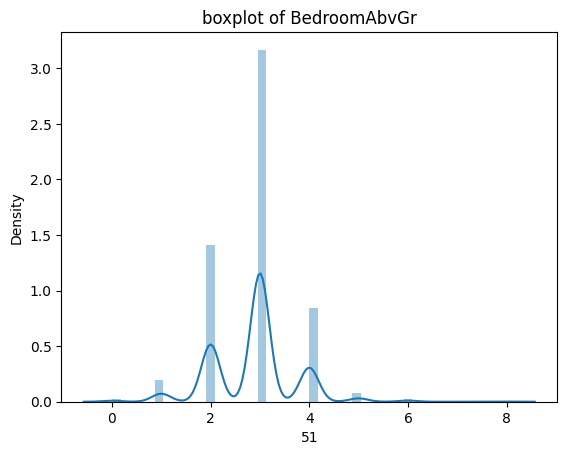

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


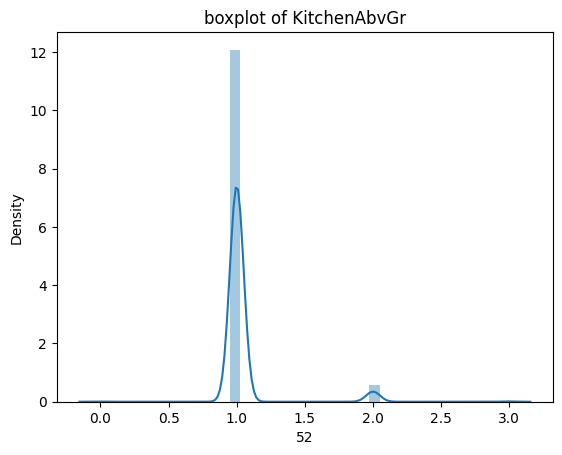

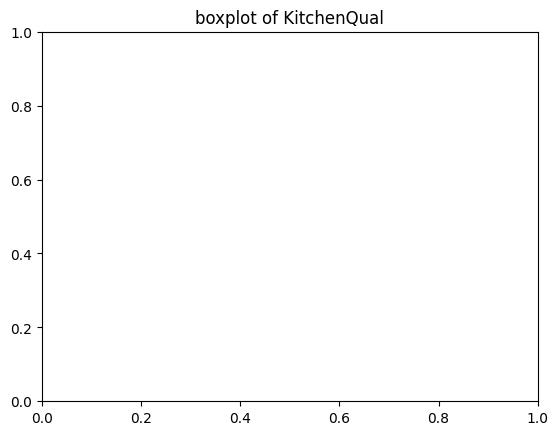

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


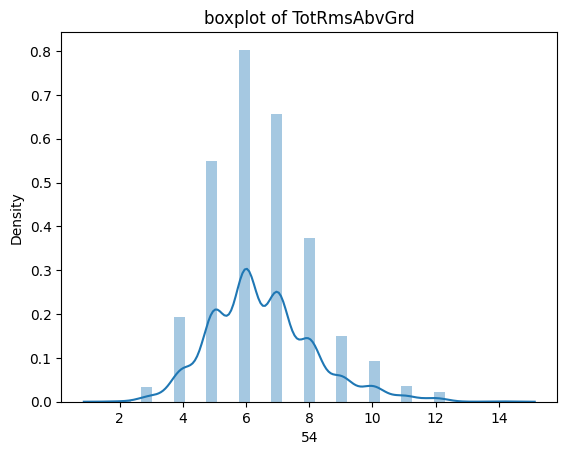

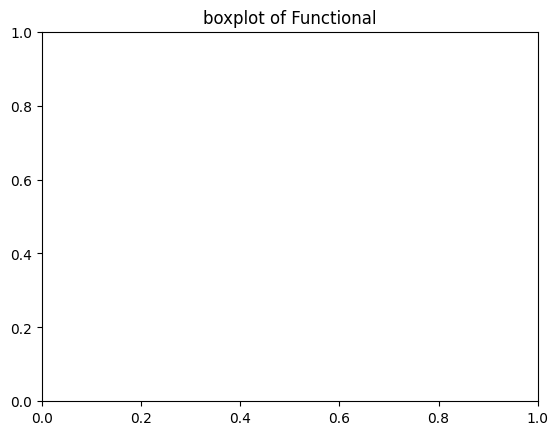

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


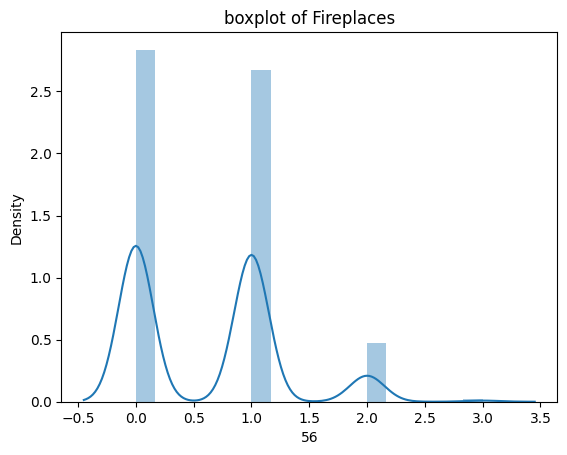

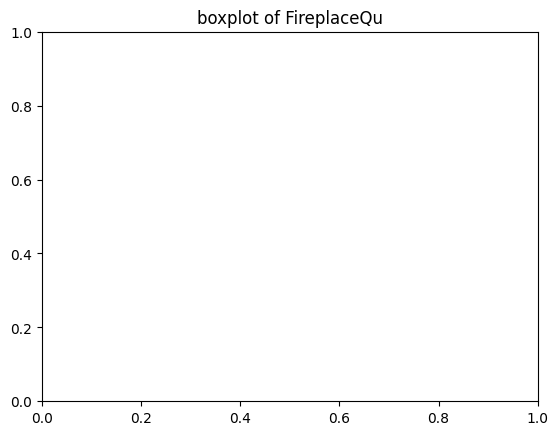

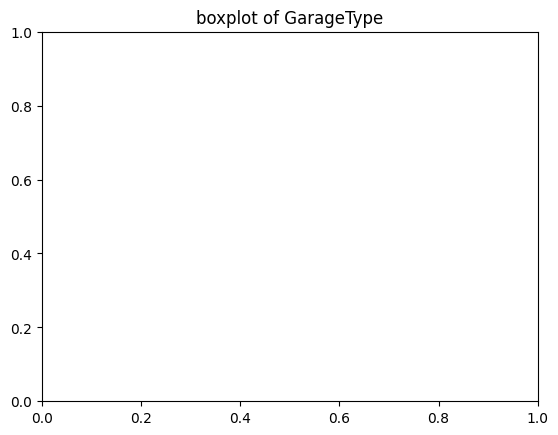

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


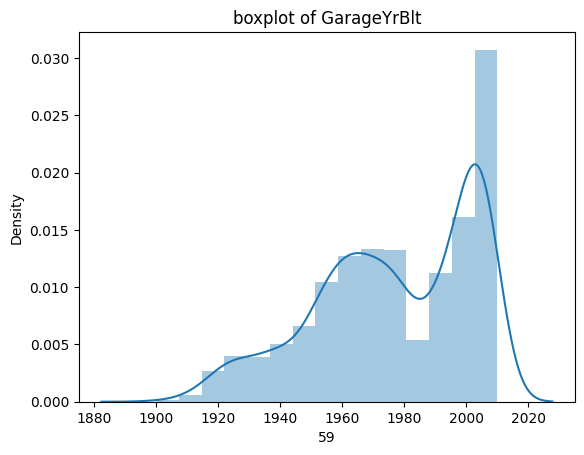

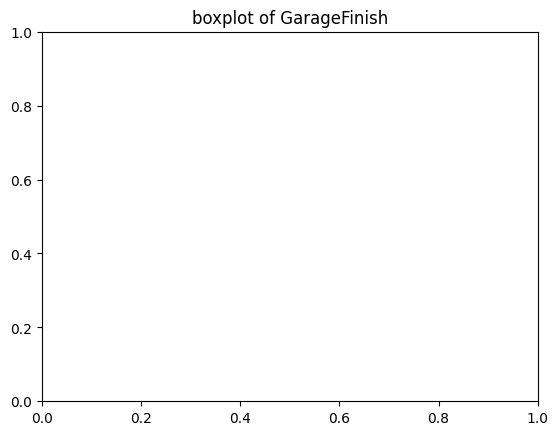

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


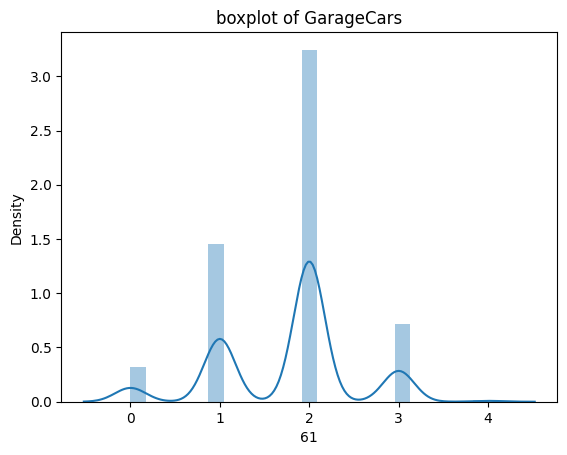

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


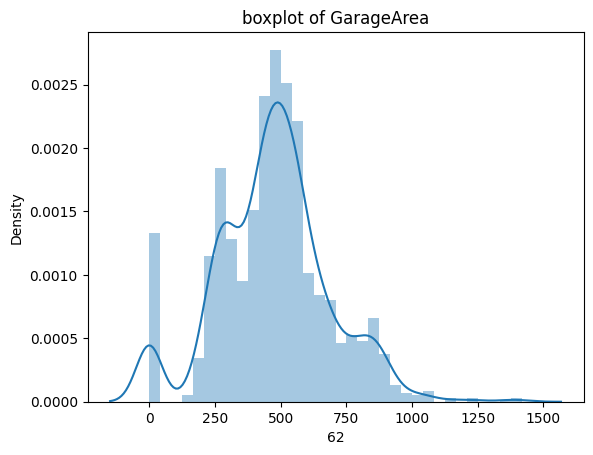

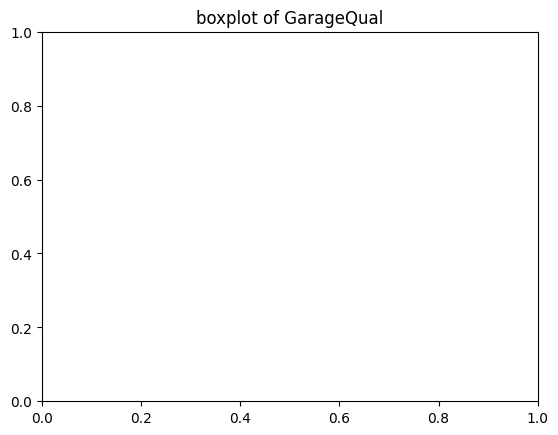

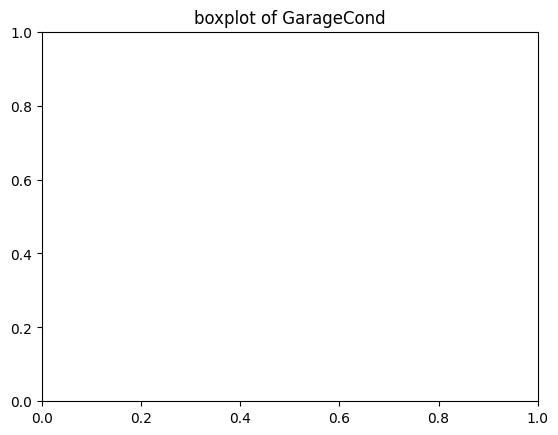

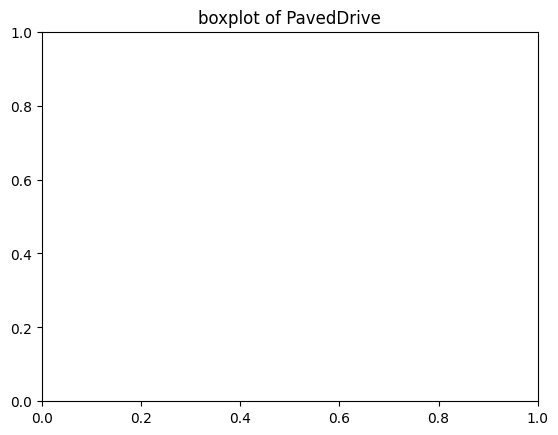

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


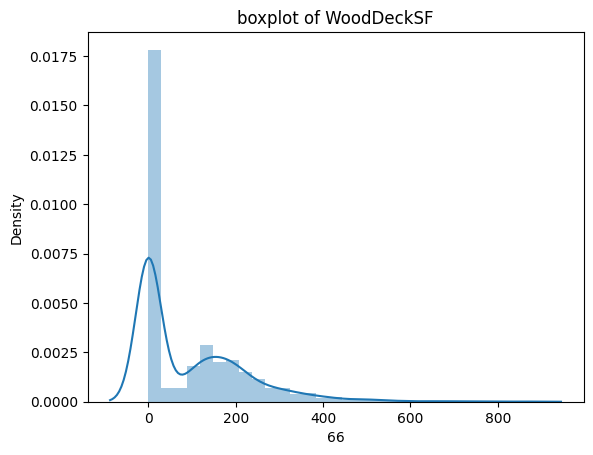

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


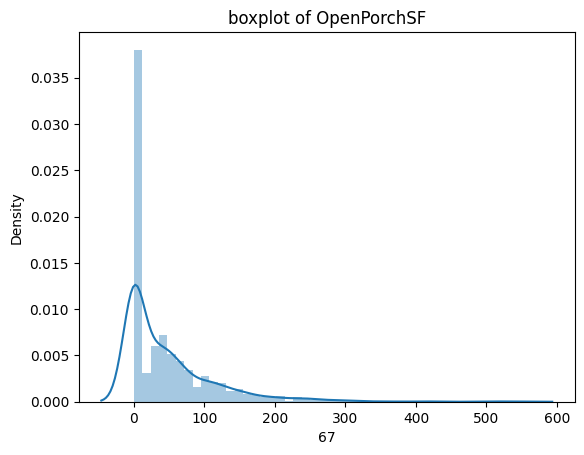

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


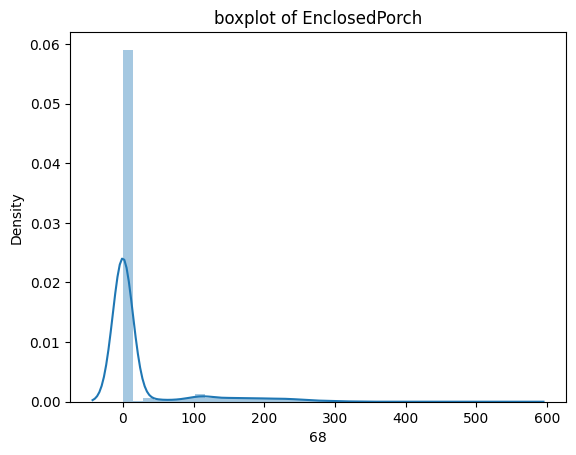

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


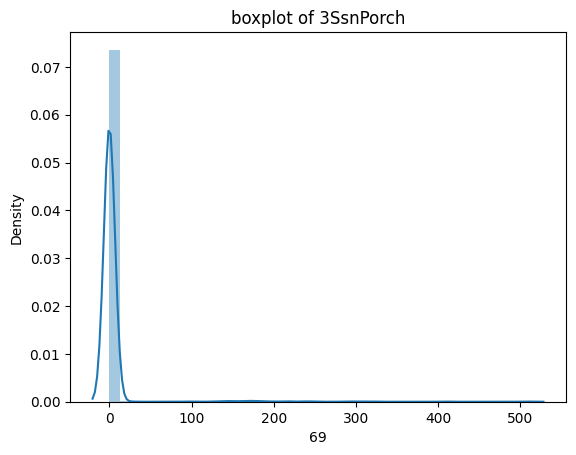

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


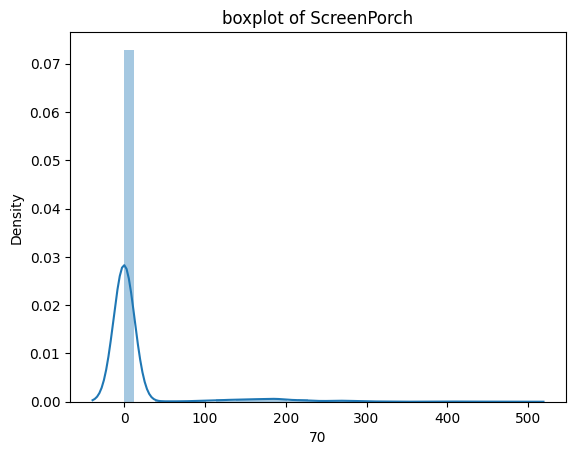

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


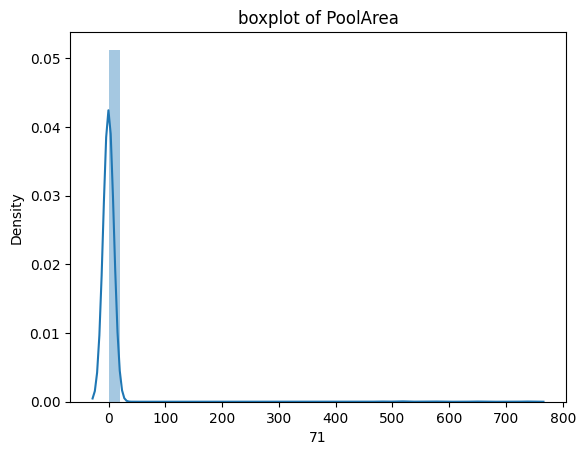

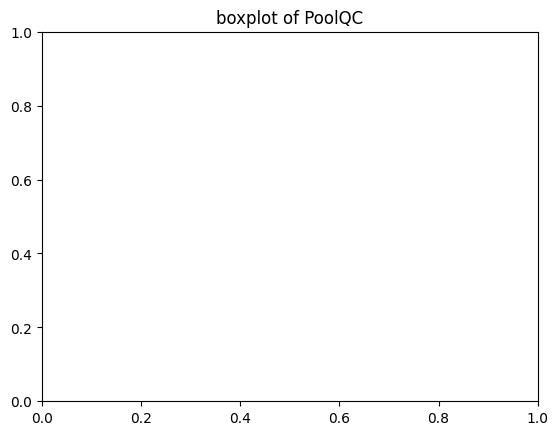

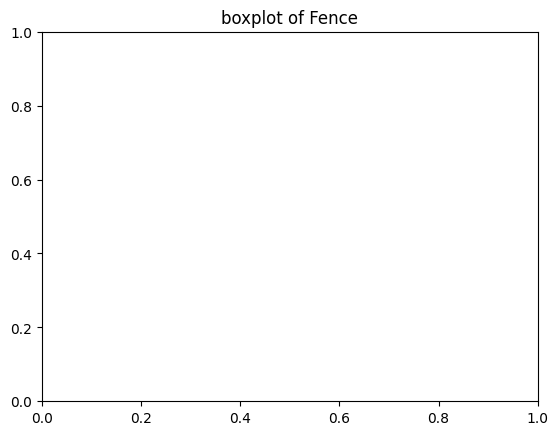

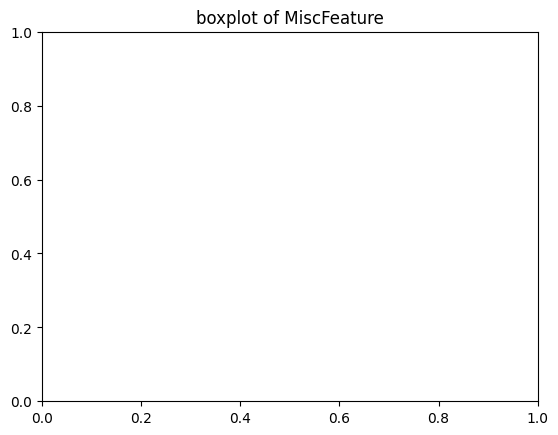

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


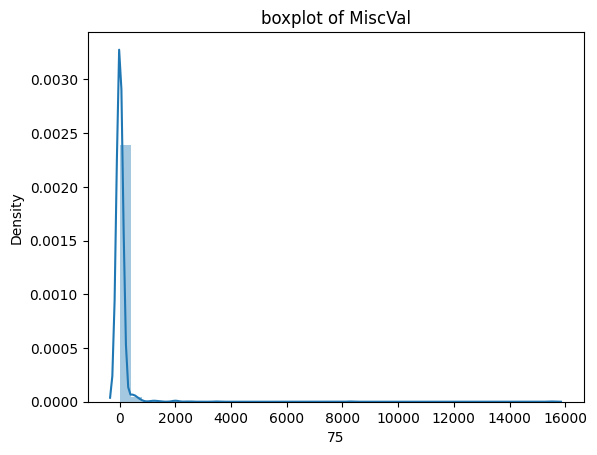

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


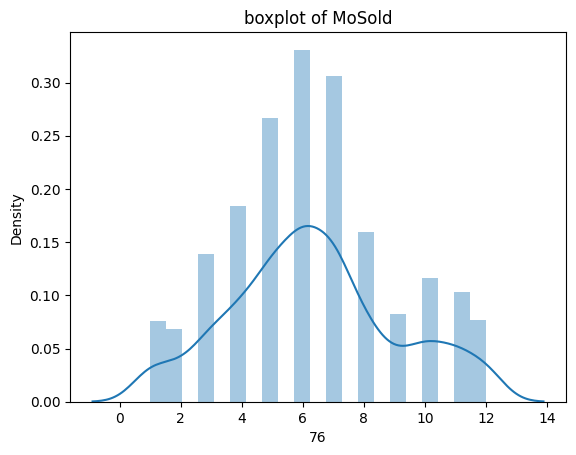

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


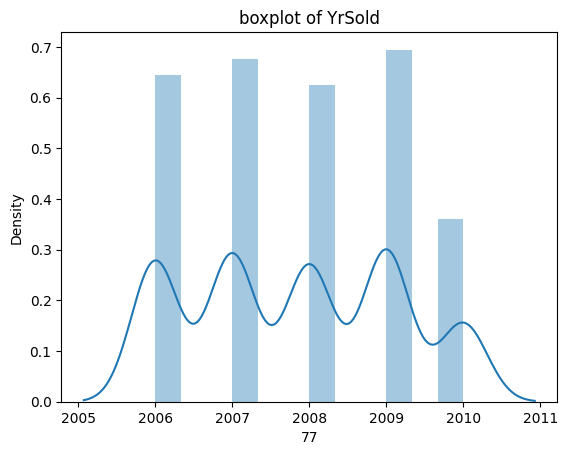

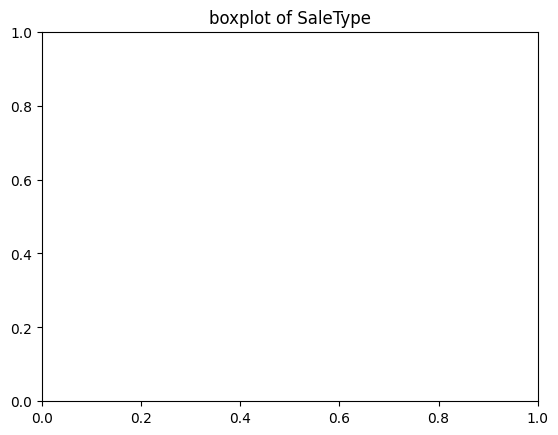

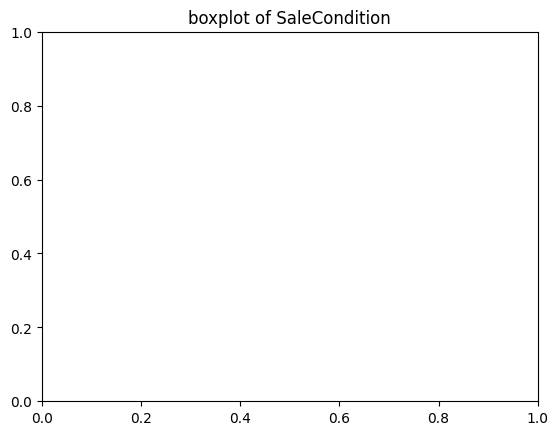

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


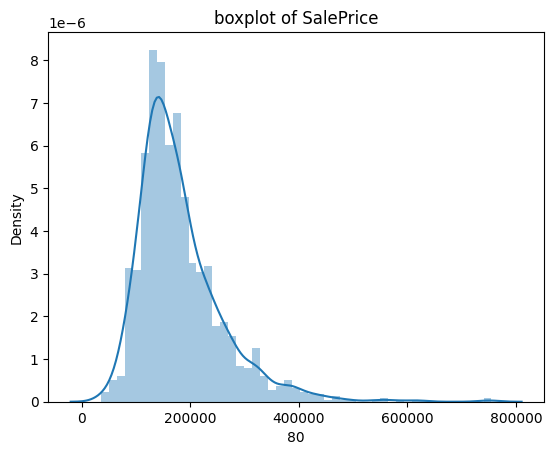

In [15]:
display_distplot(train_csv)

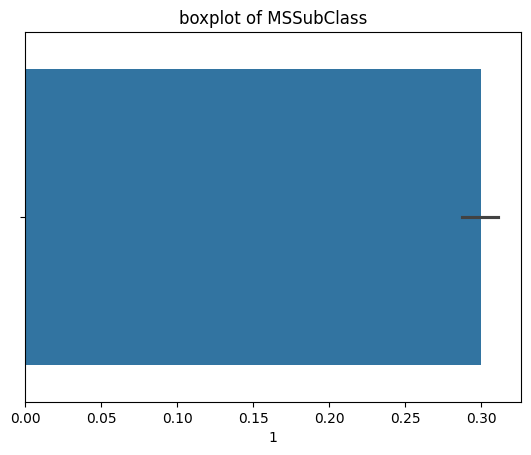

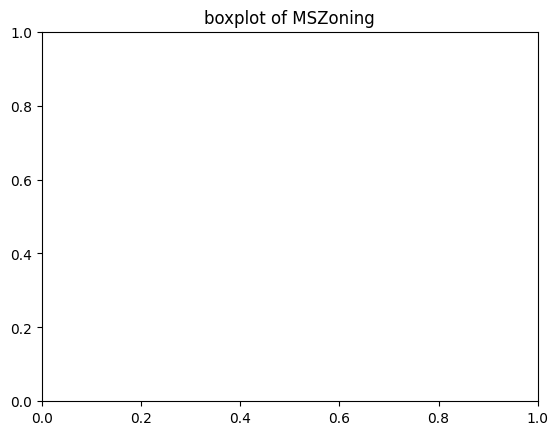

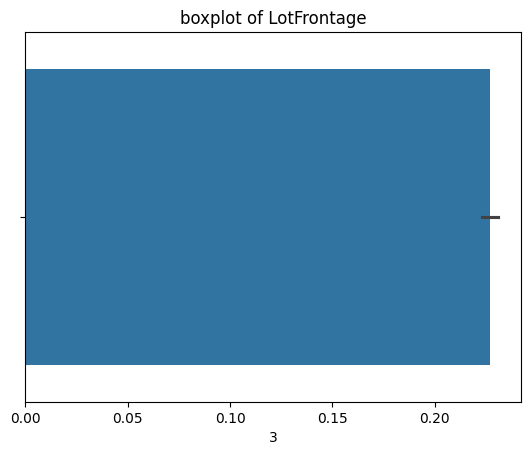

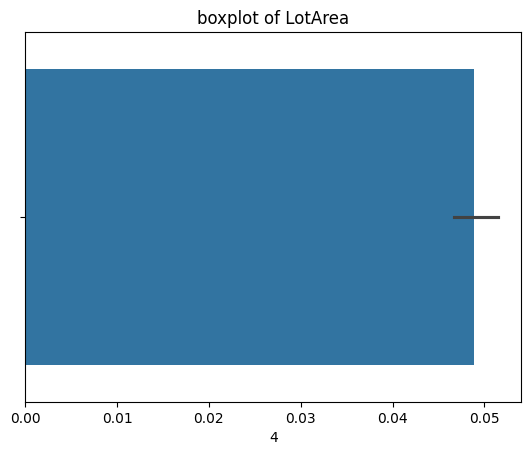

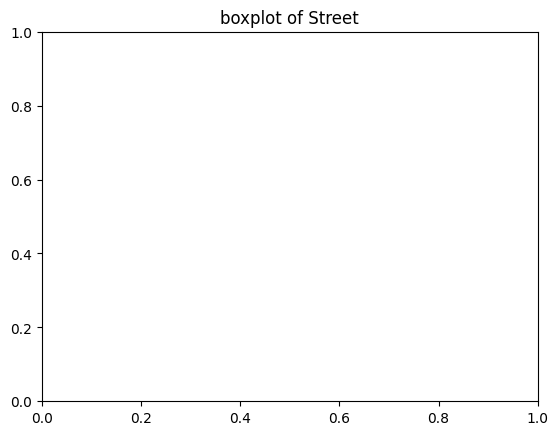

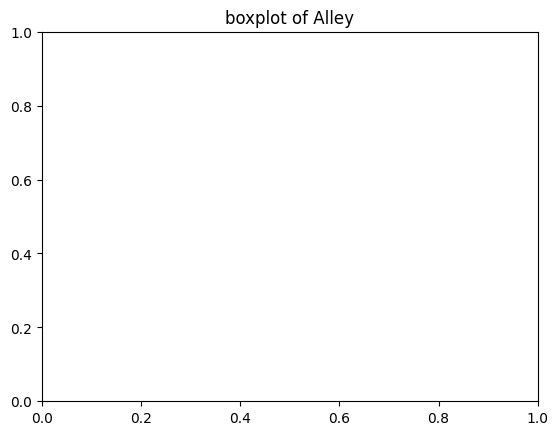

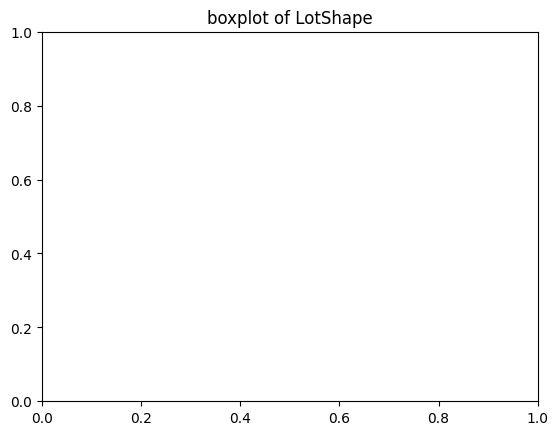

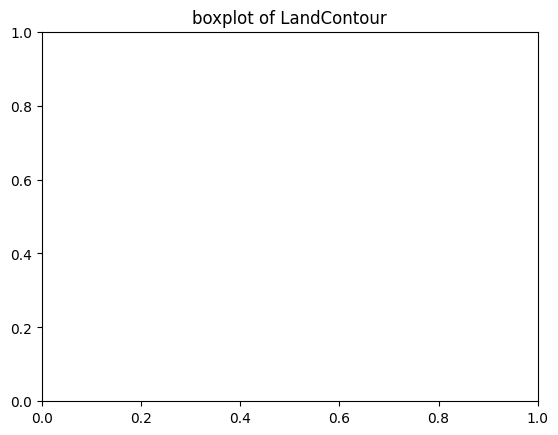

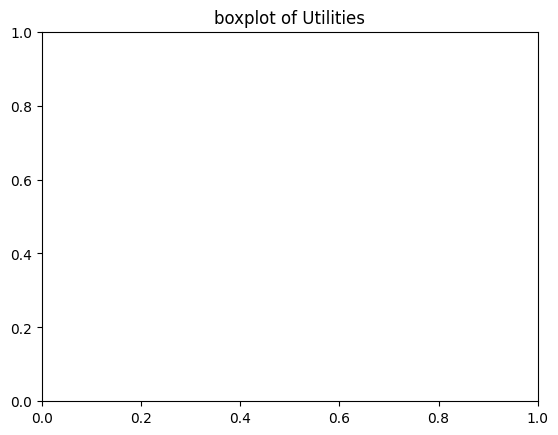

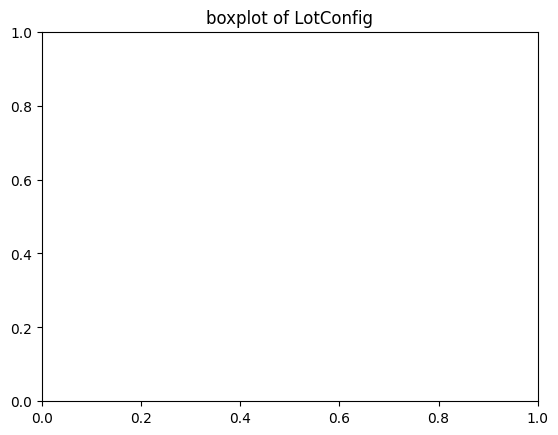

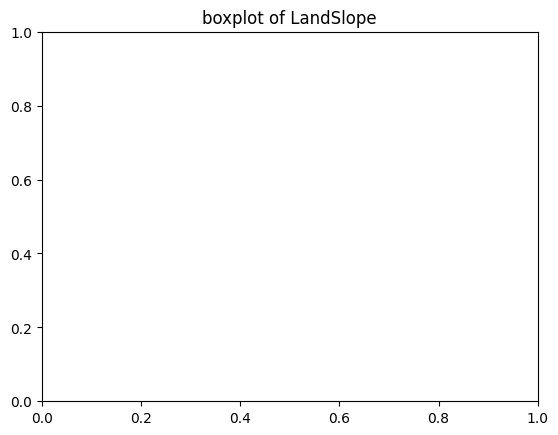

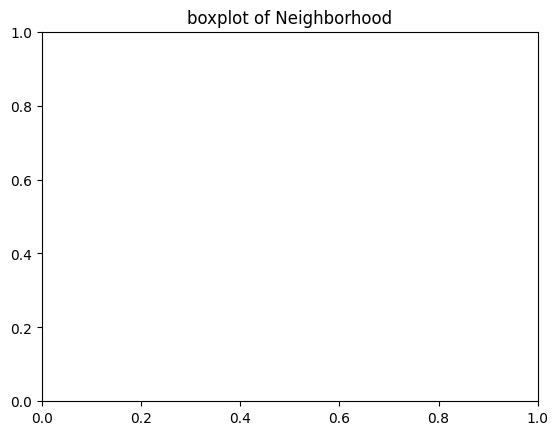

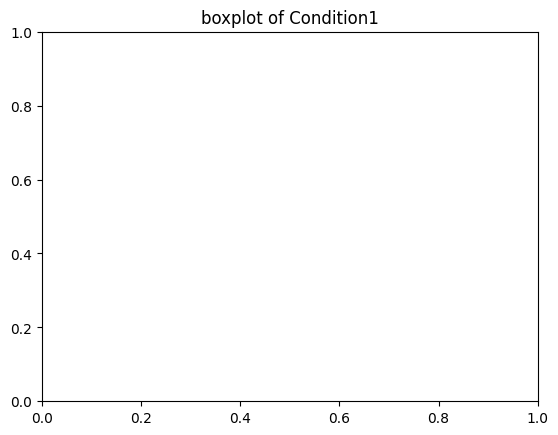

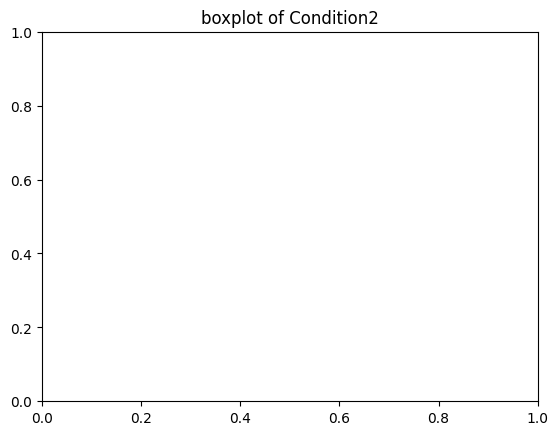

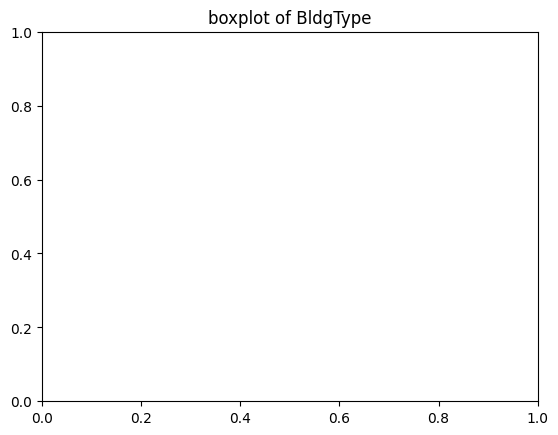

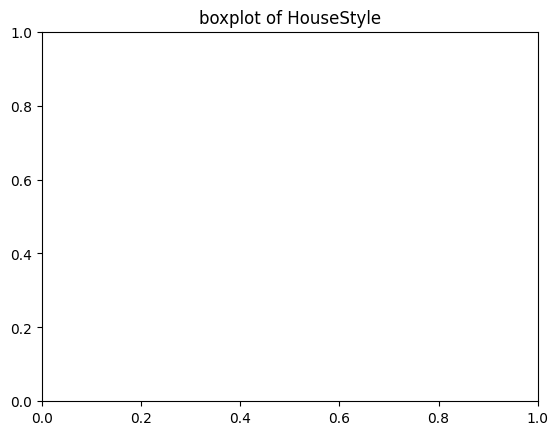

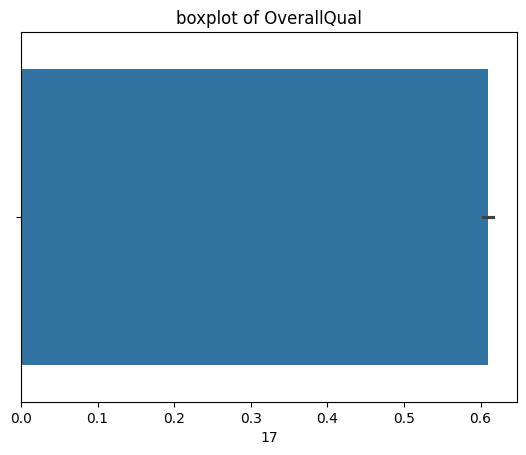

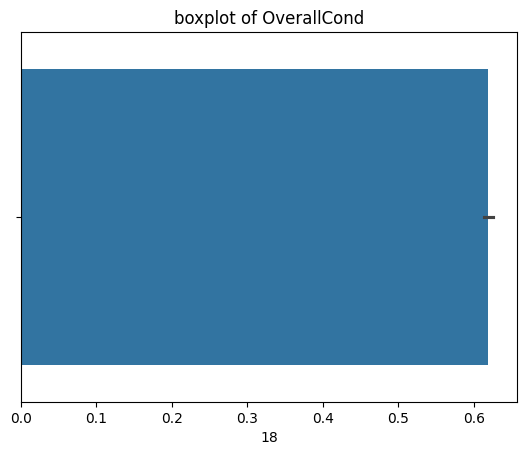

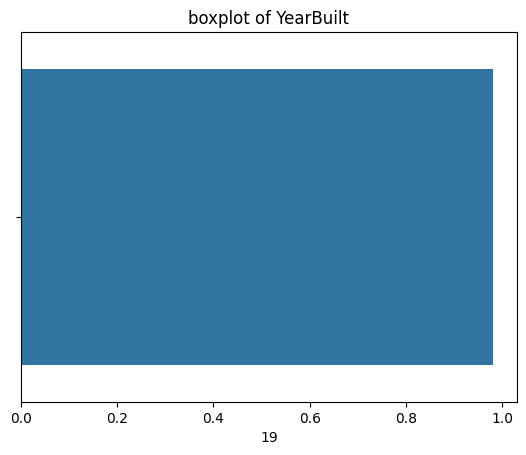

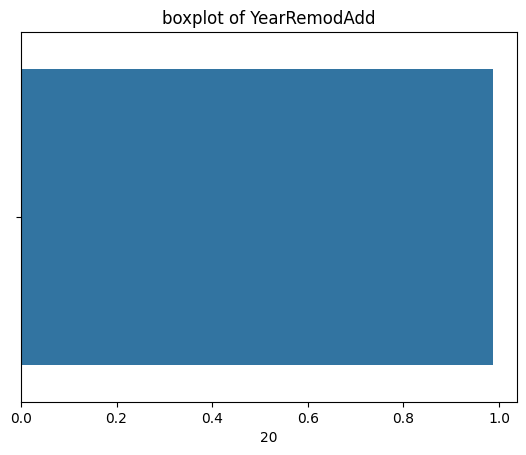

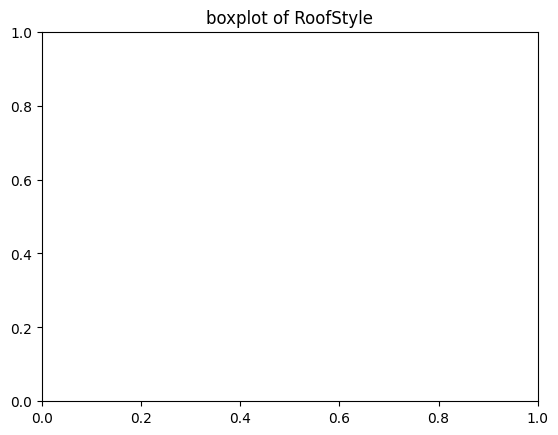

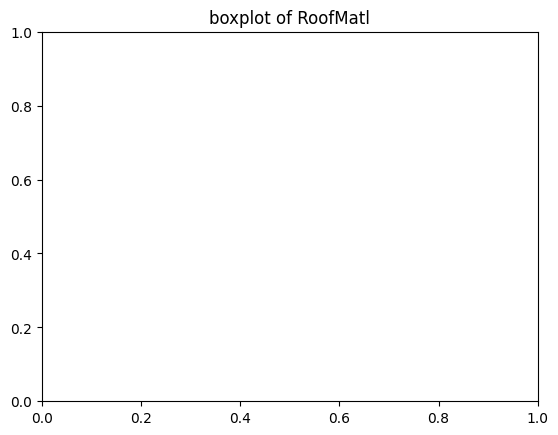

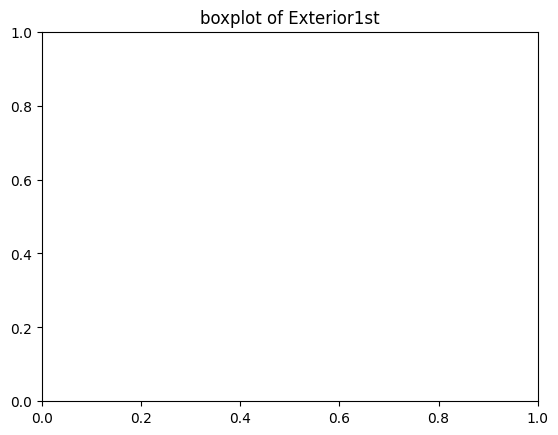

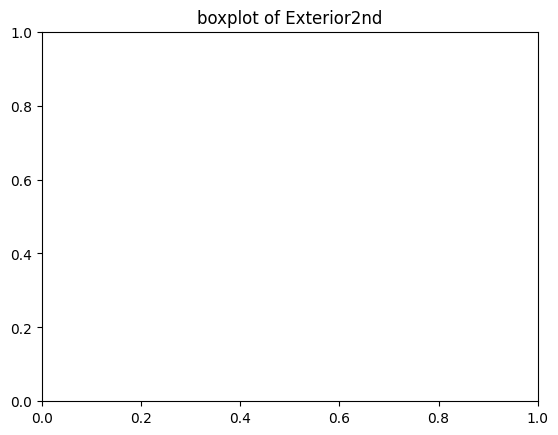

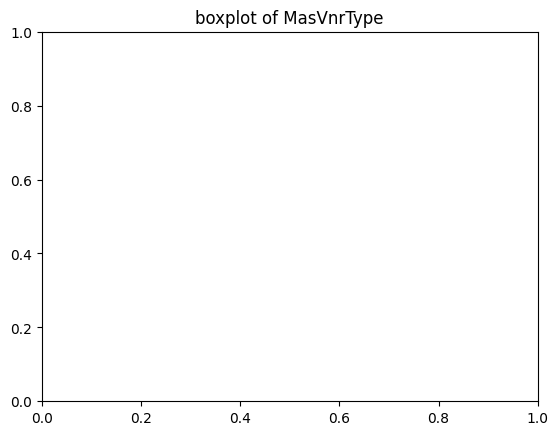

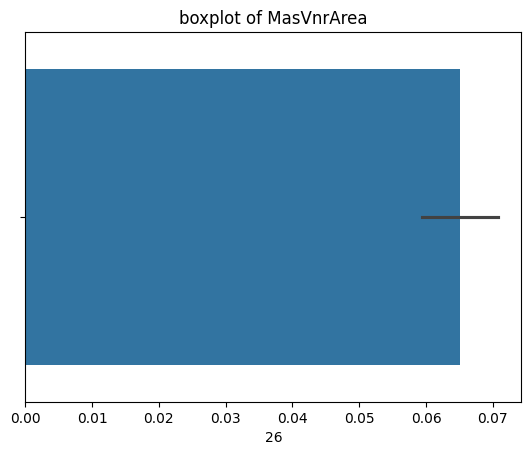

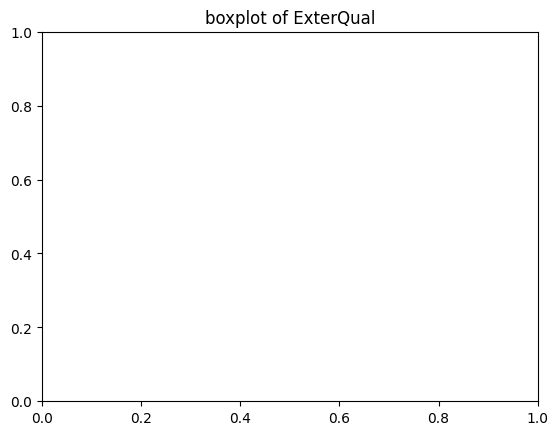

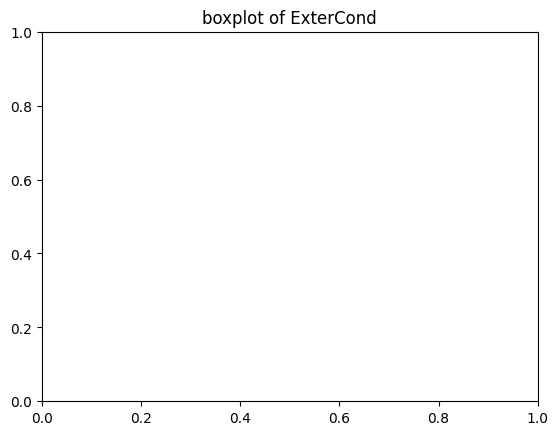

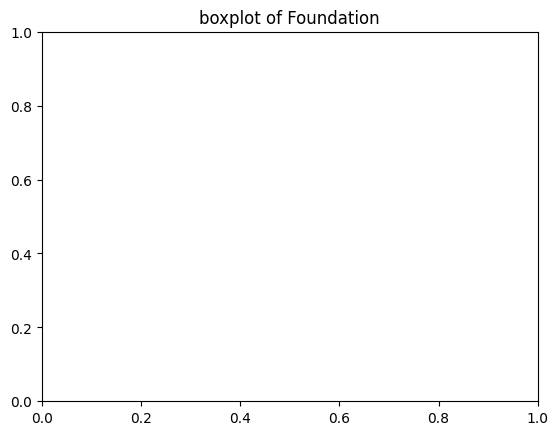

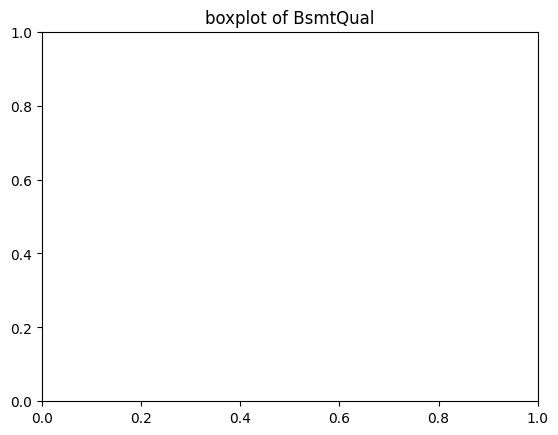

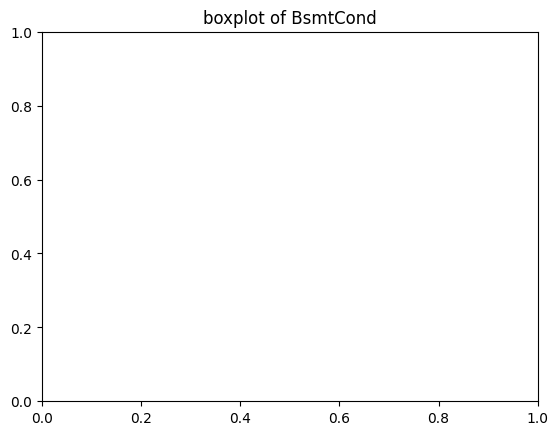

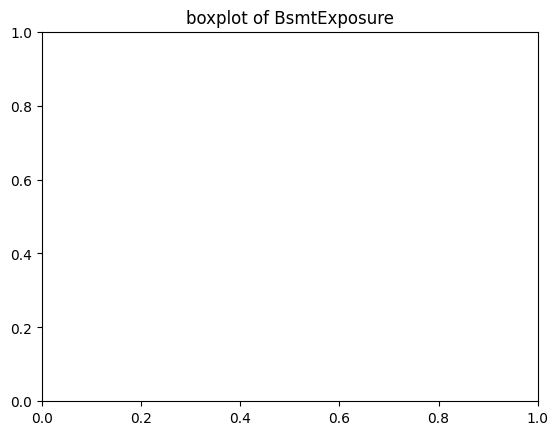

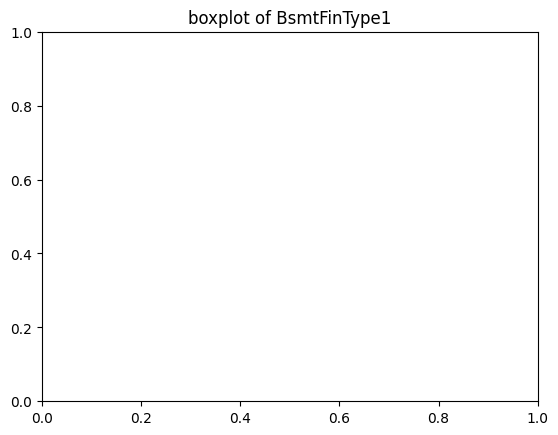

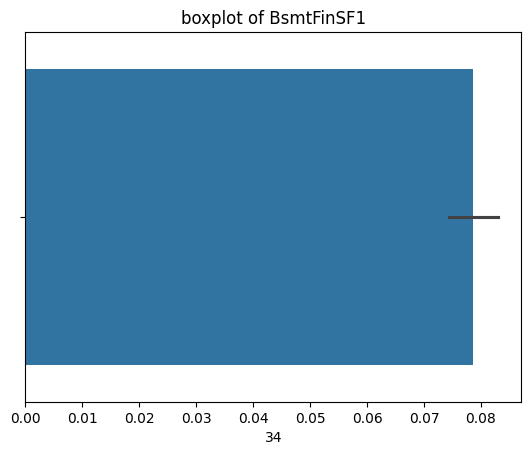

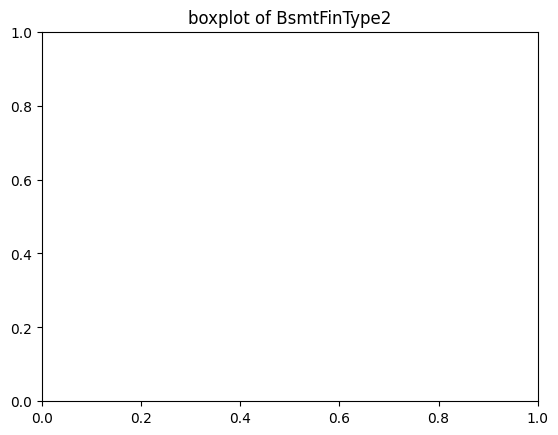

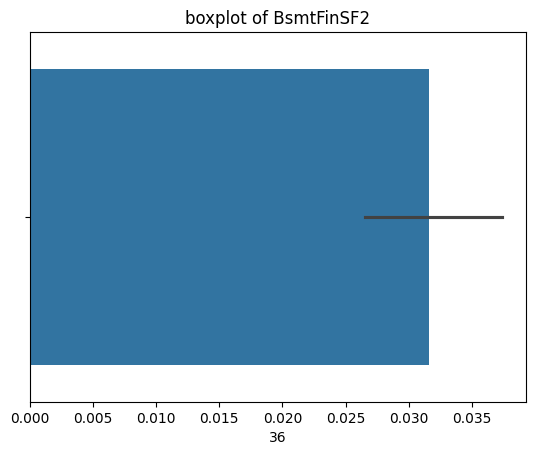

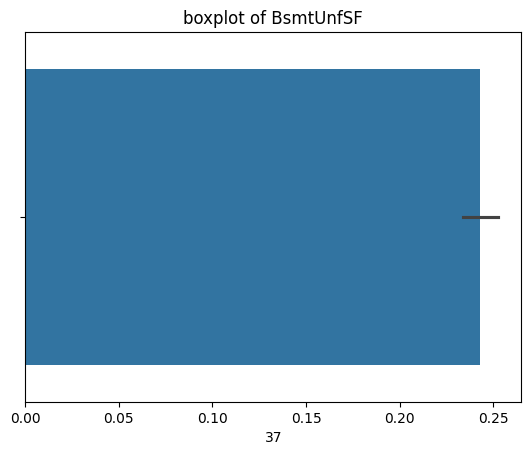

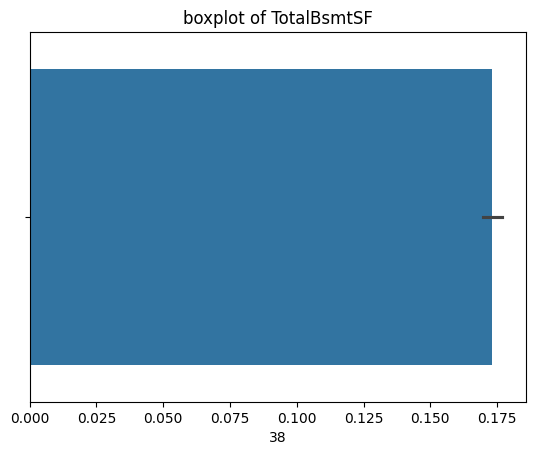

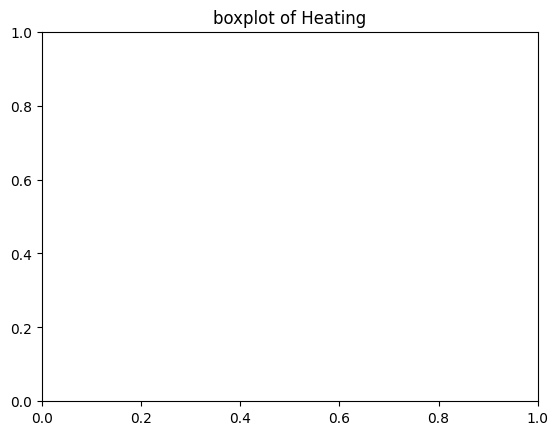

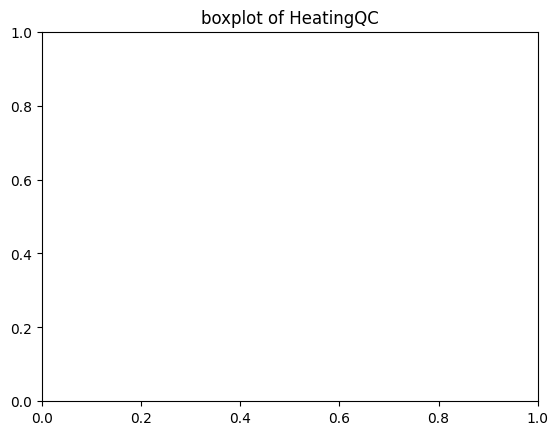

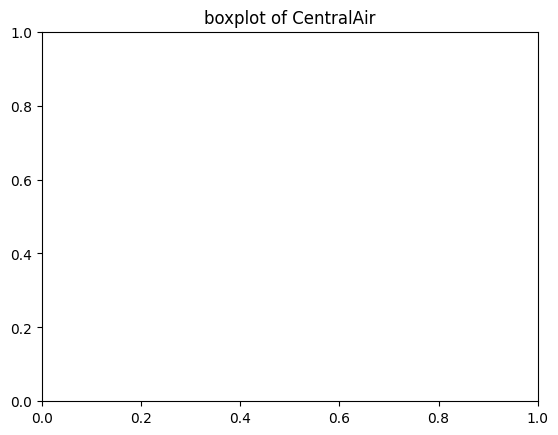

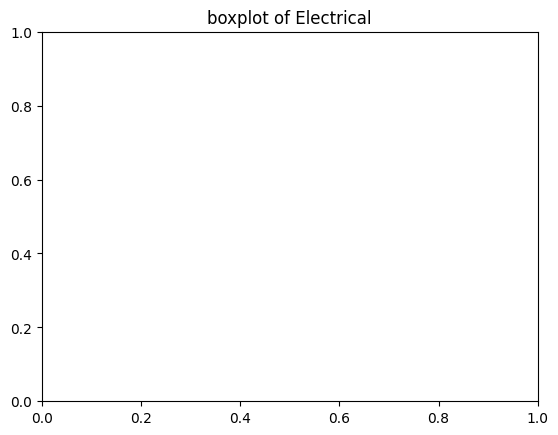

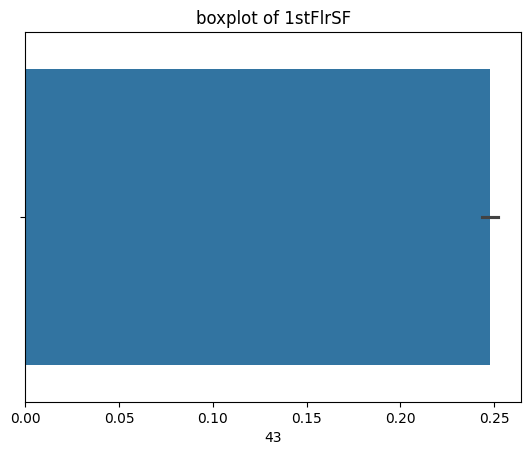

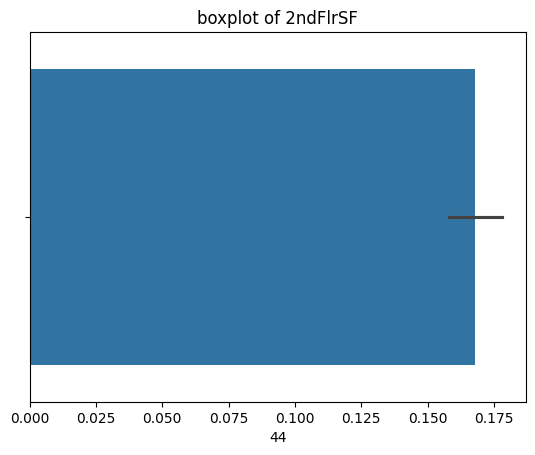

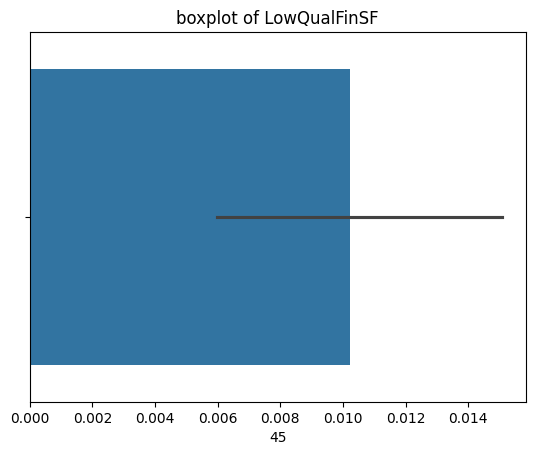

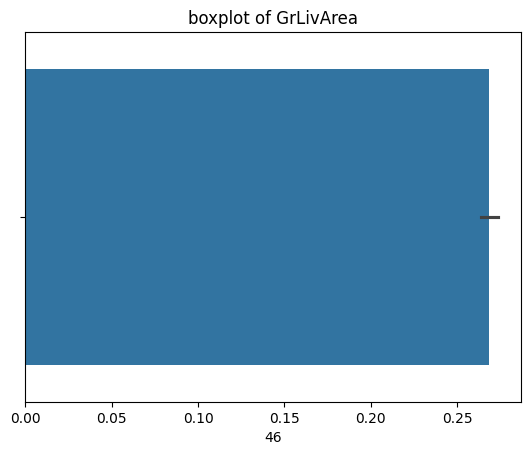

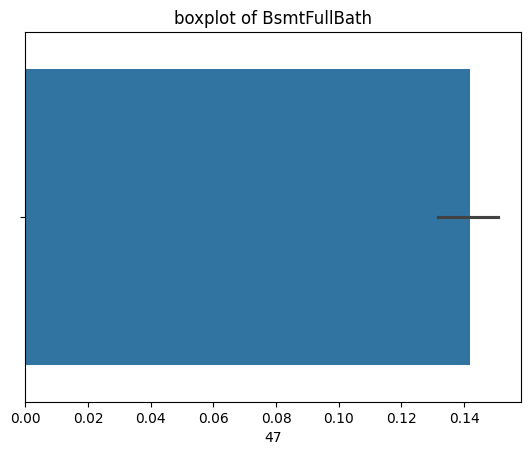

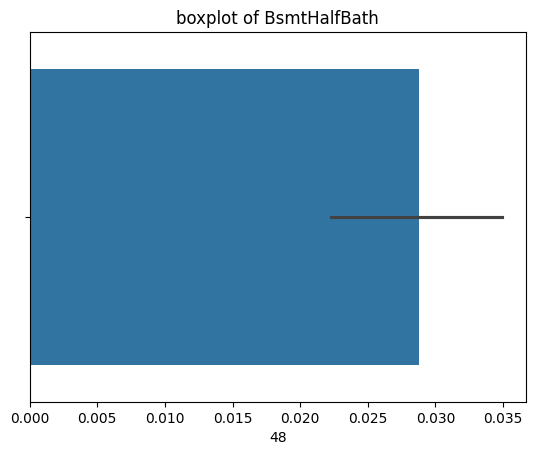

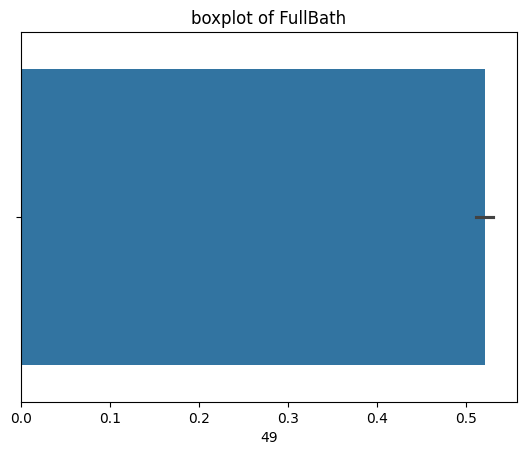

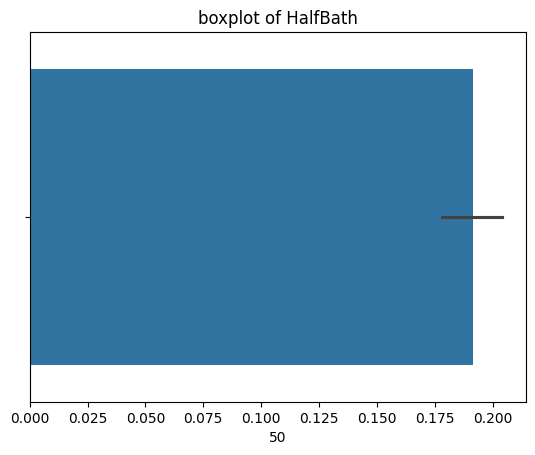

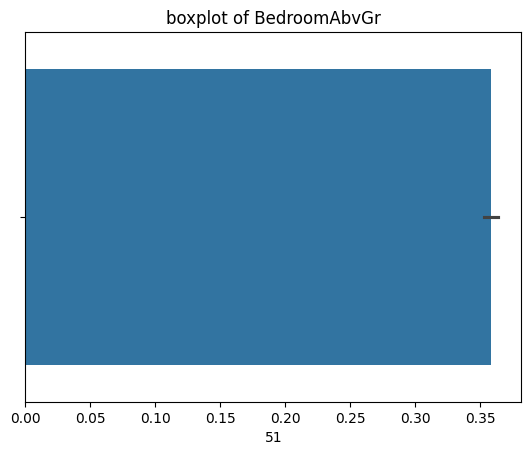

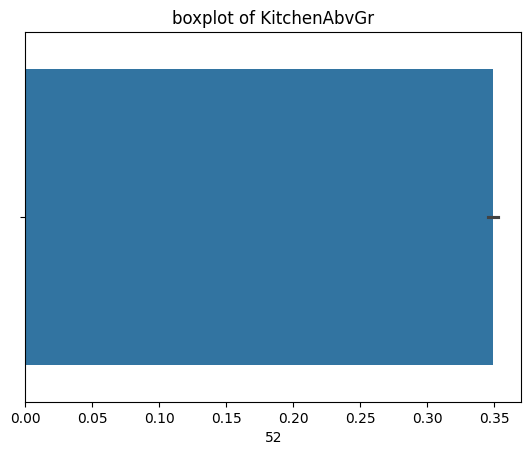

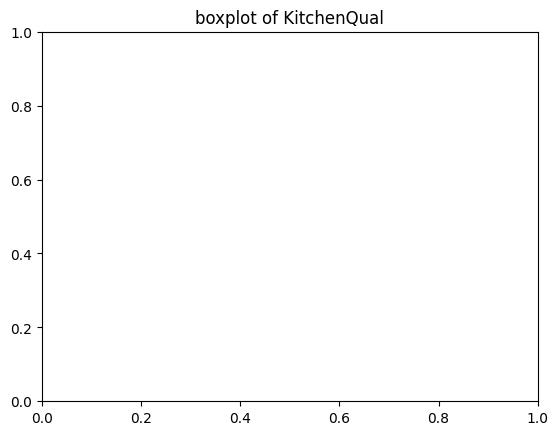

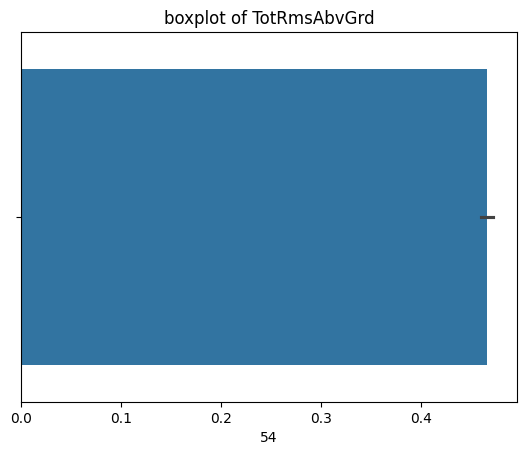

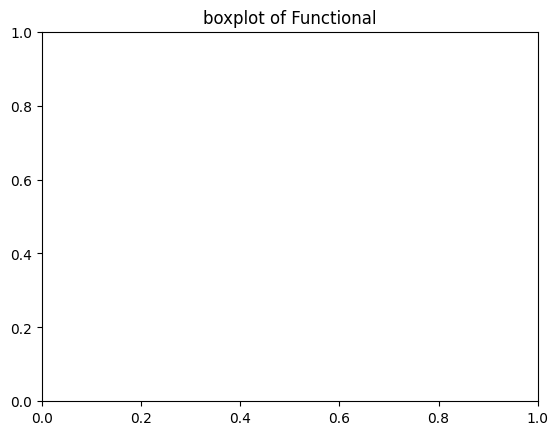

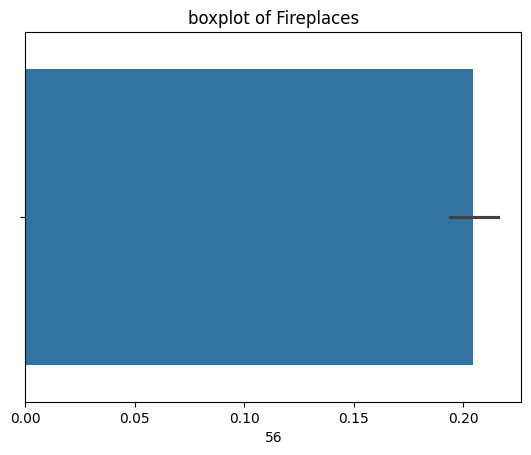

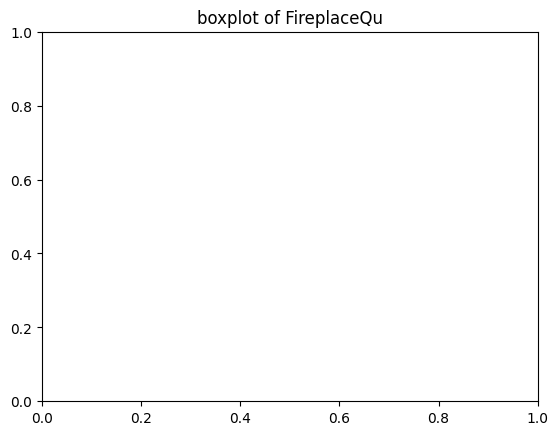

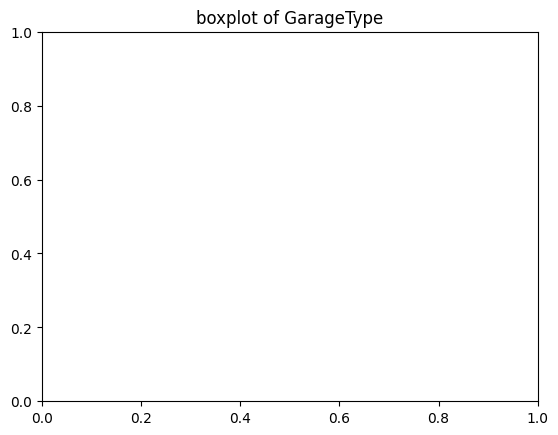

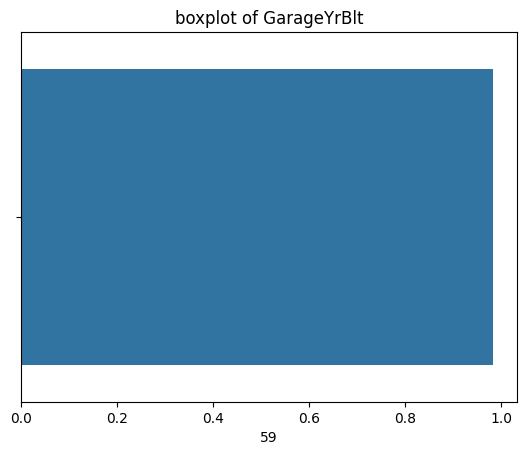

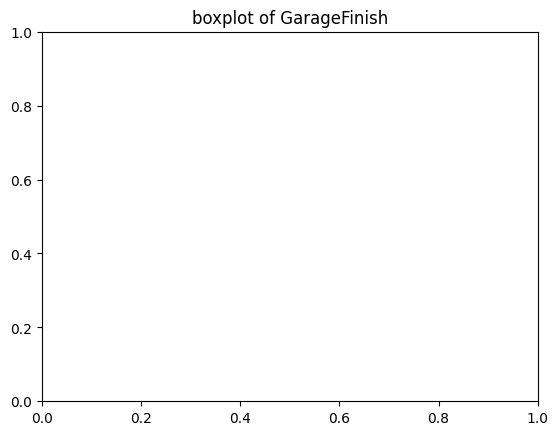

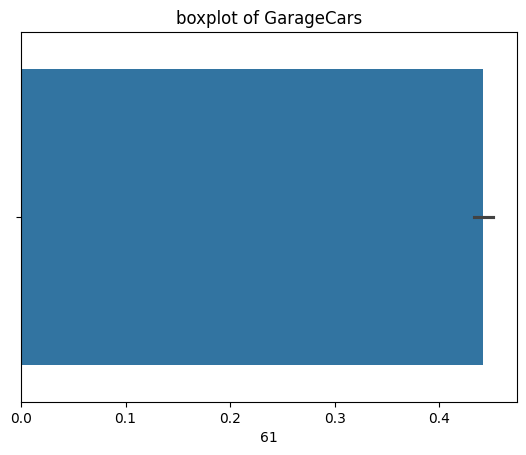

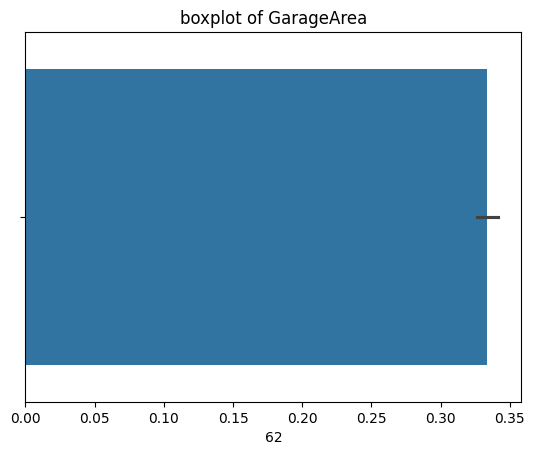

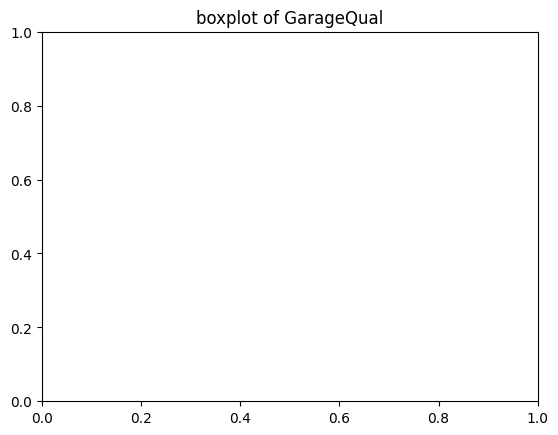

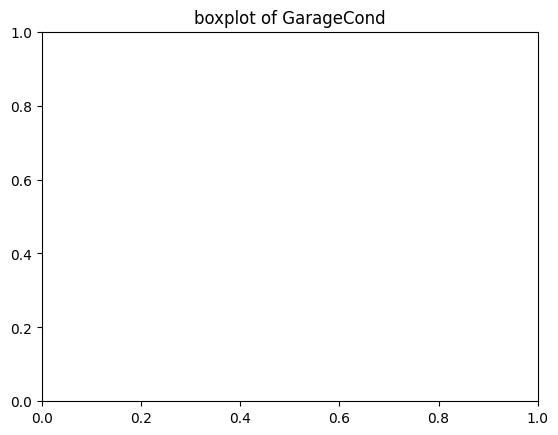

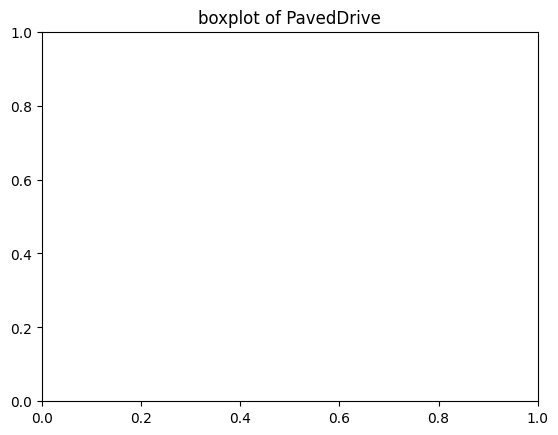

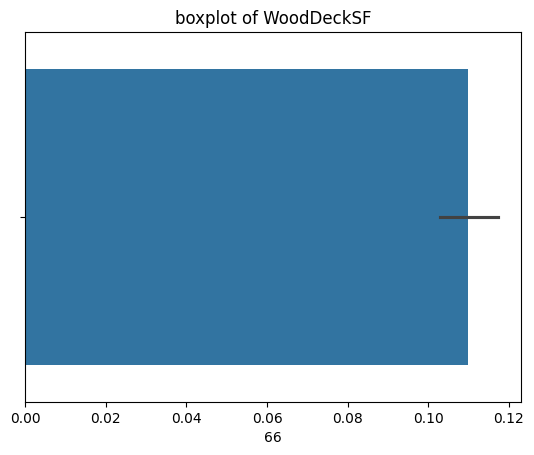

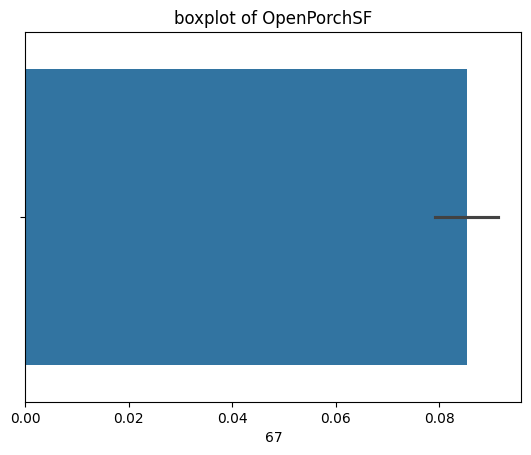

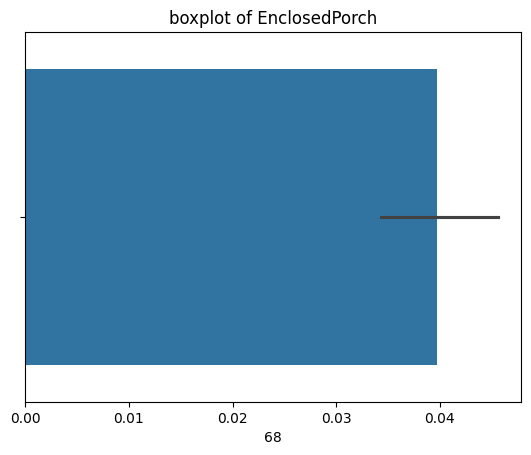

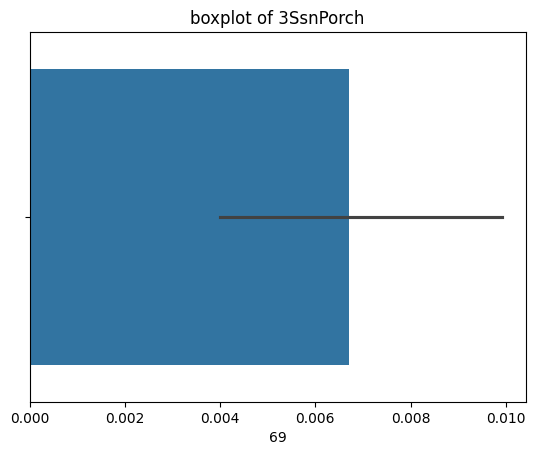

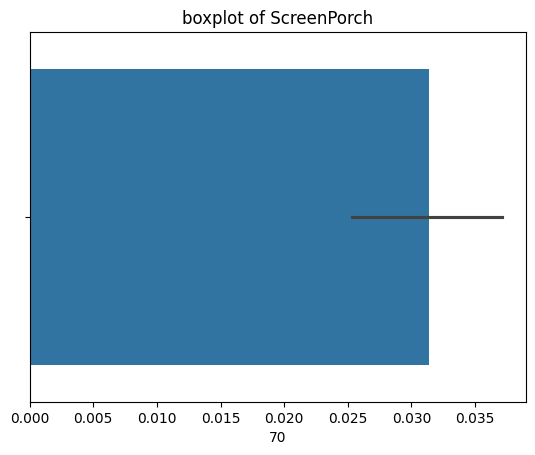

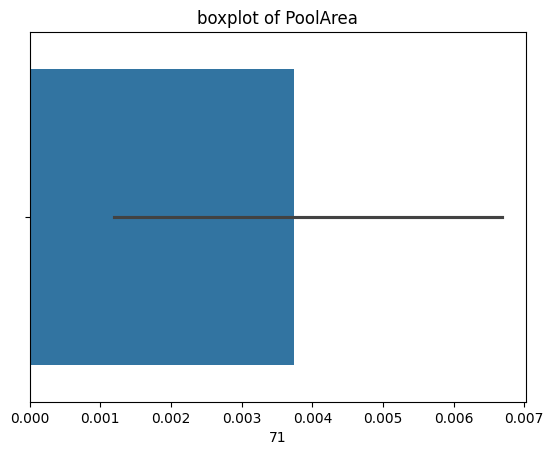

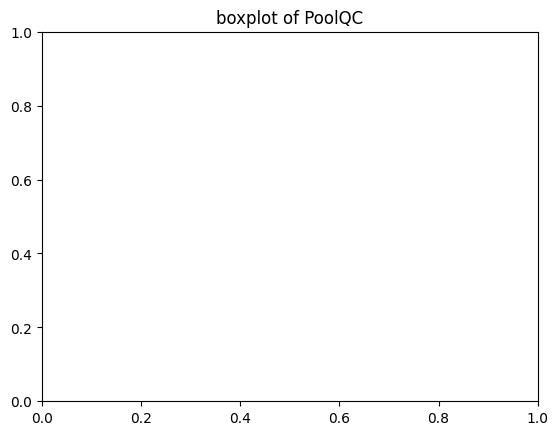

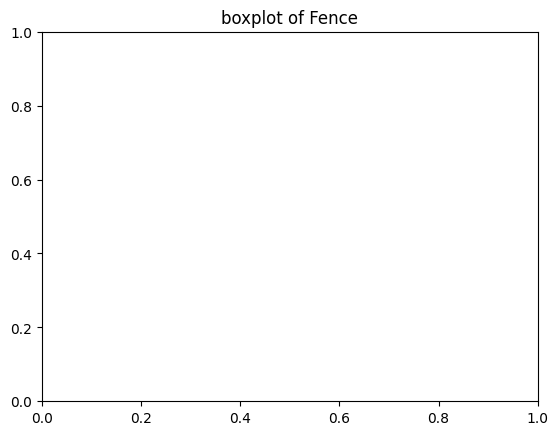

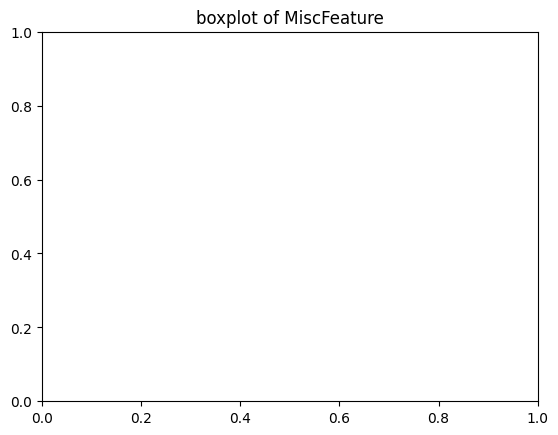

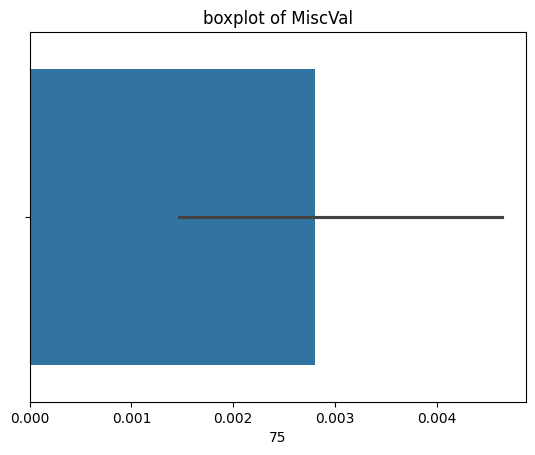

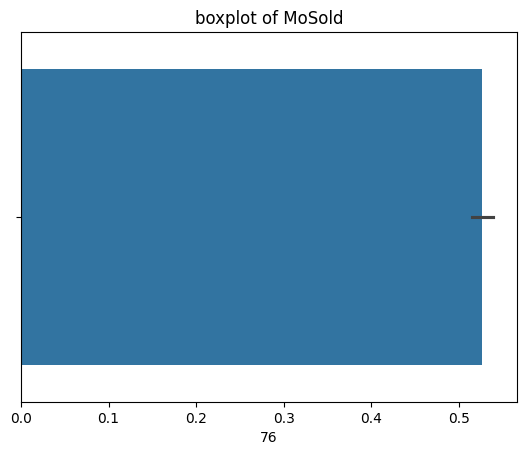

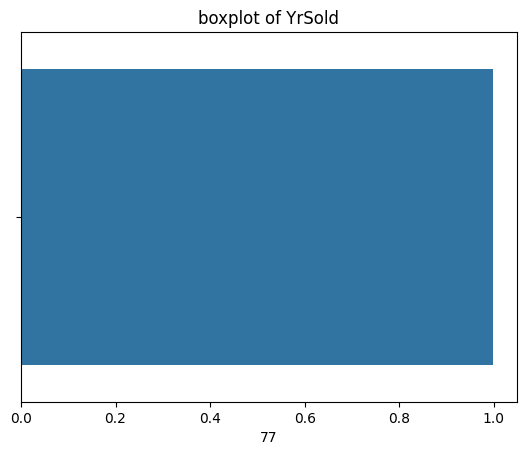

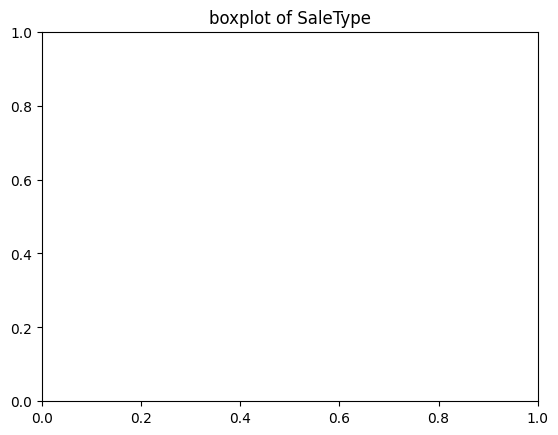

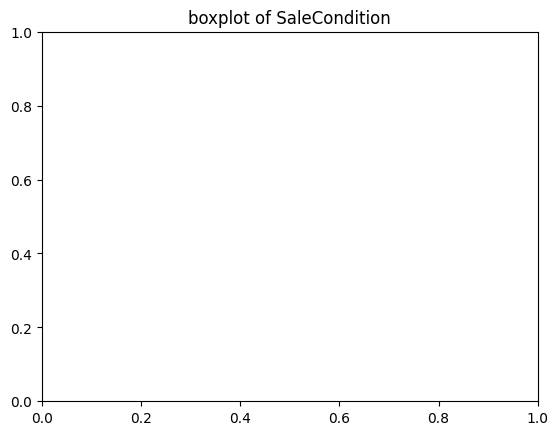

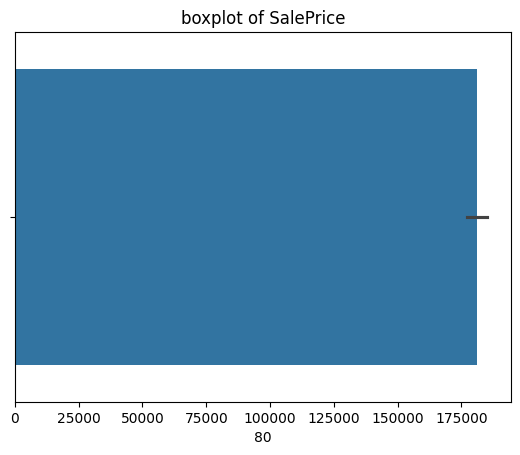

In [16]:
display_boxplot(train_absmax_transformed)

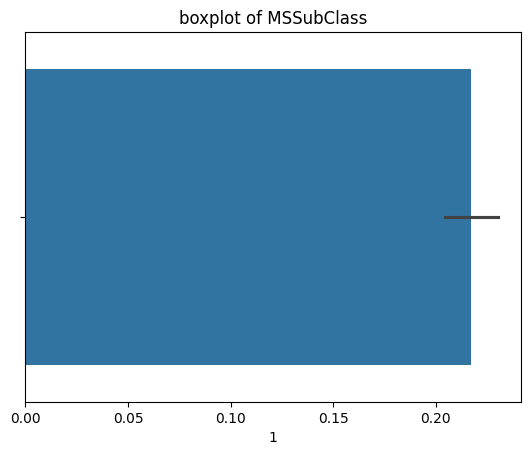

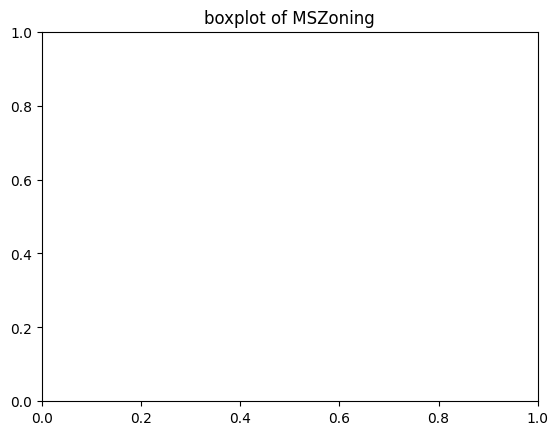

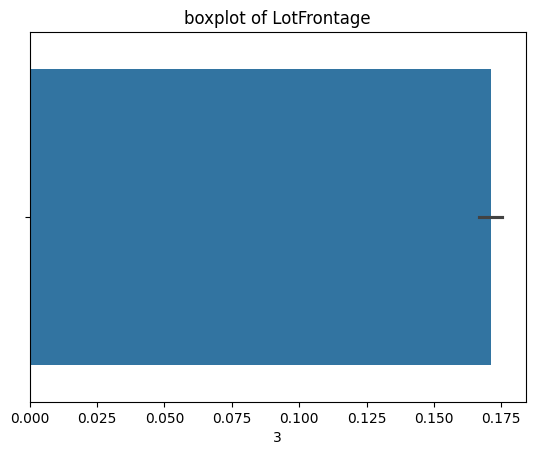

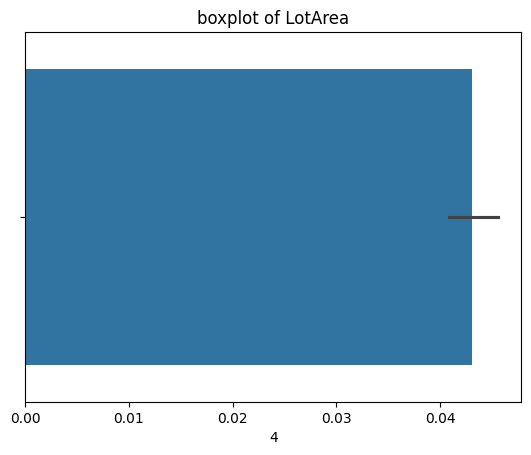

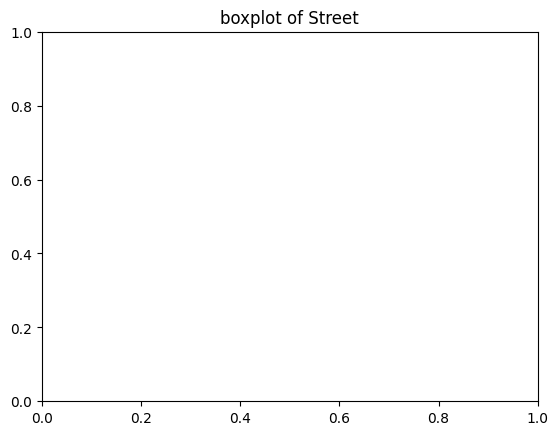

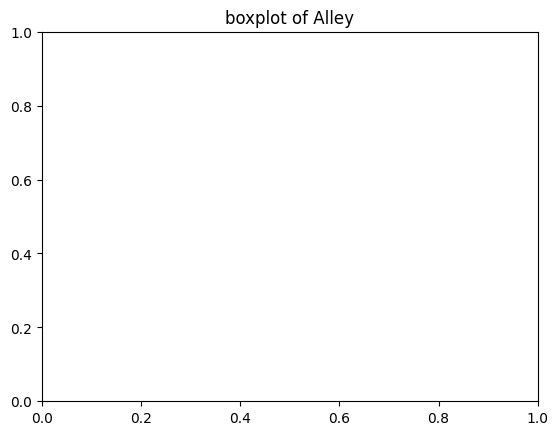

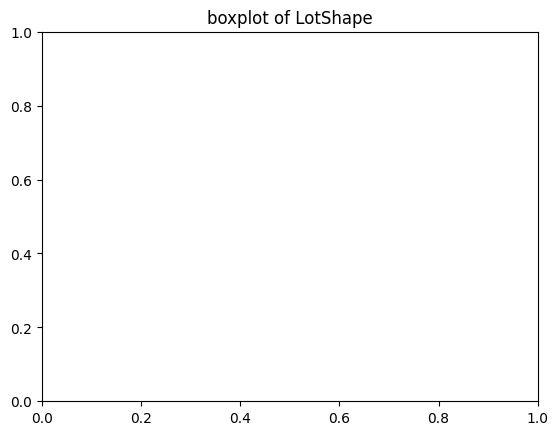

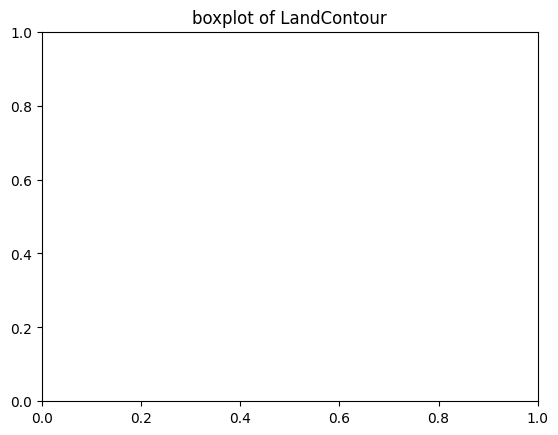

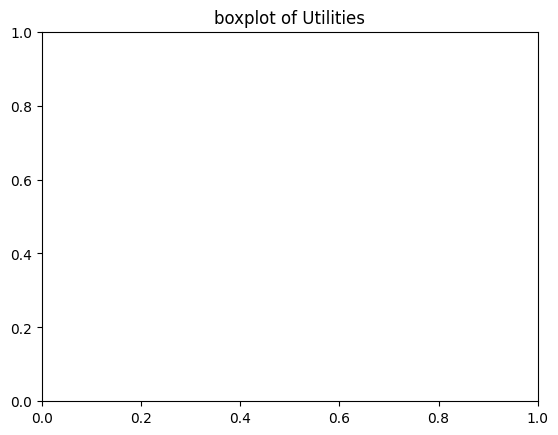

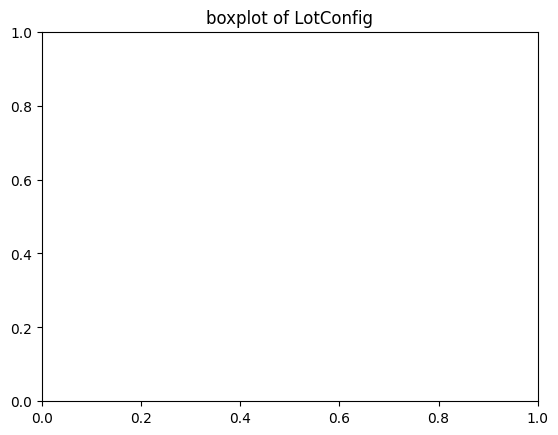

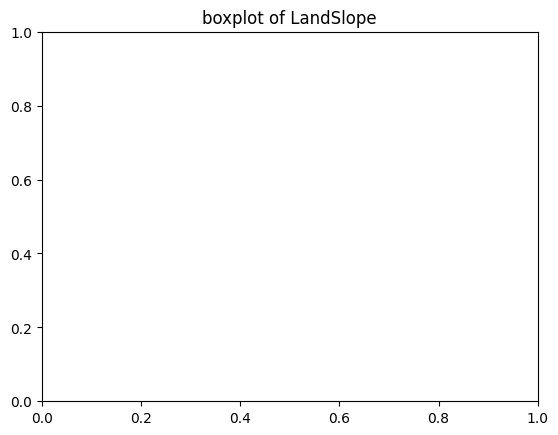

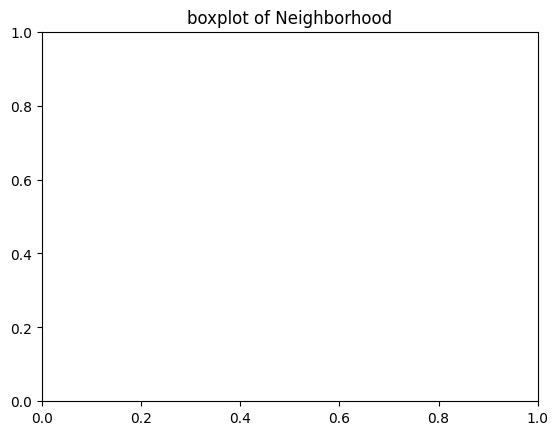

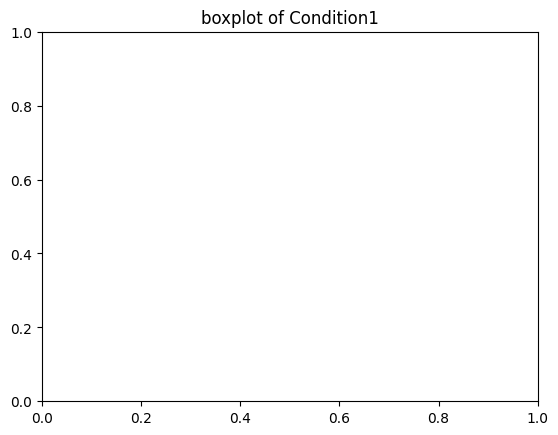

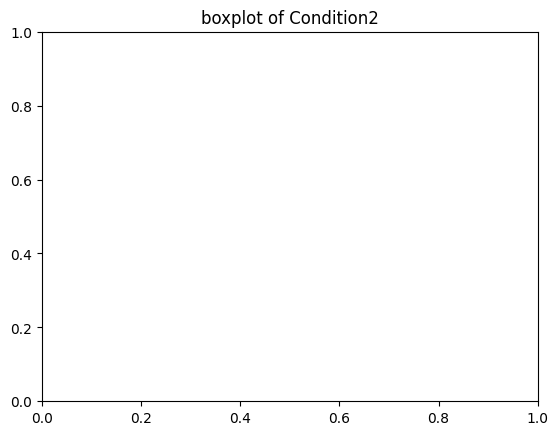

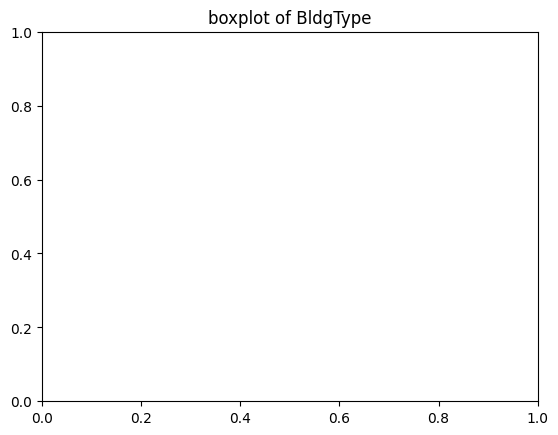

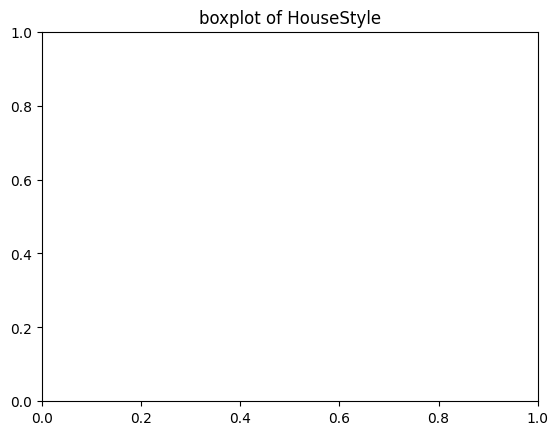

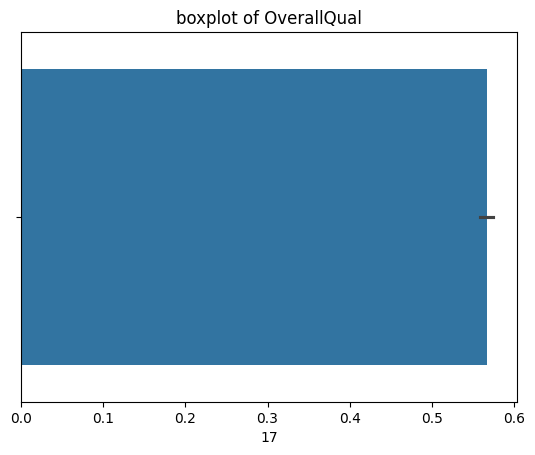

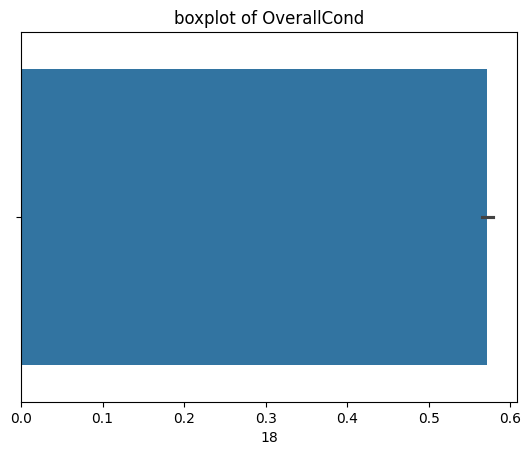

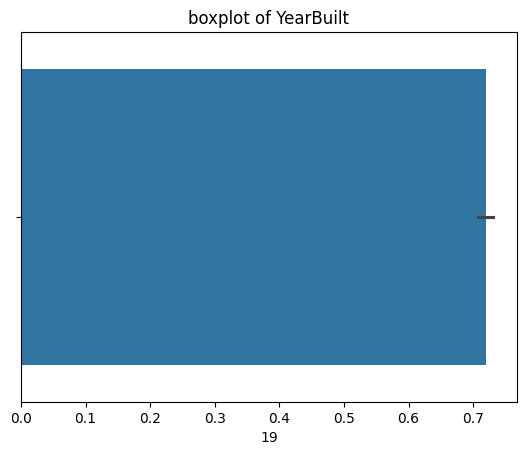

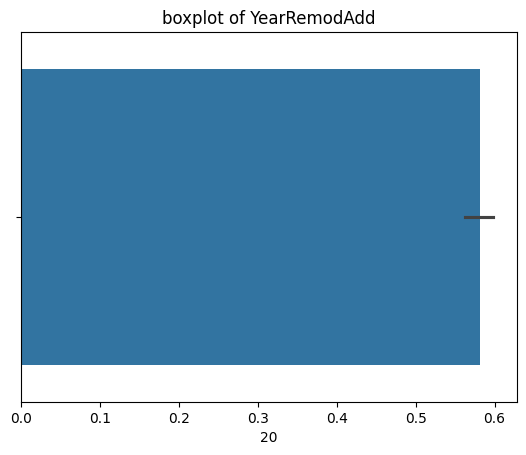

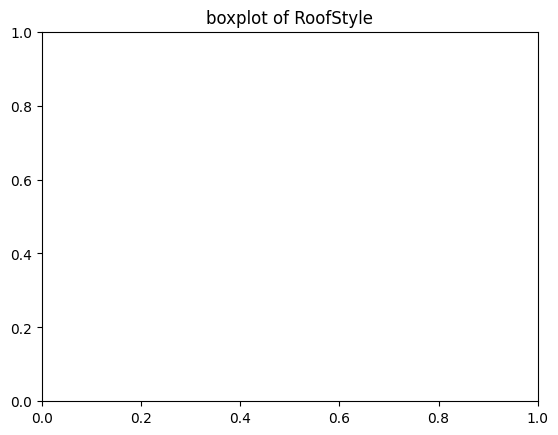

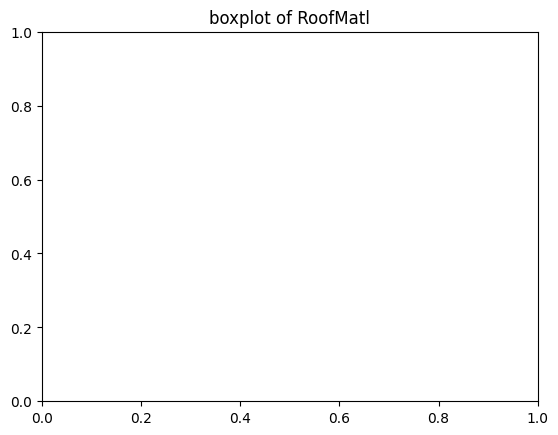

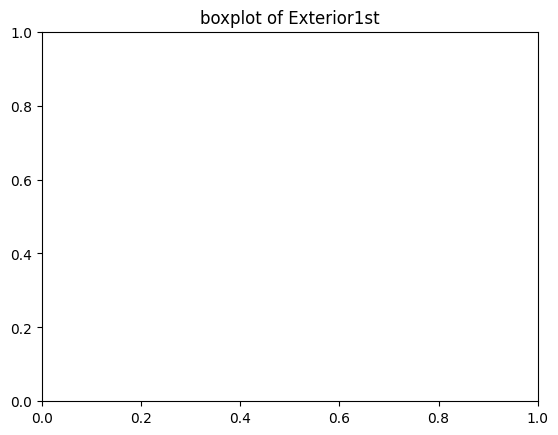

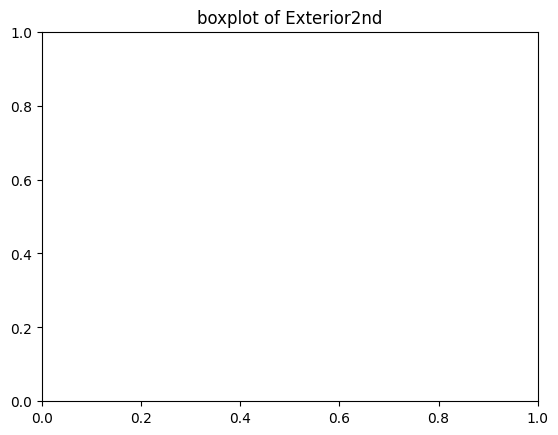

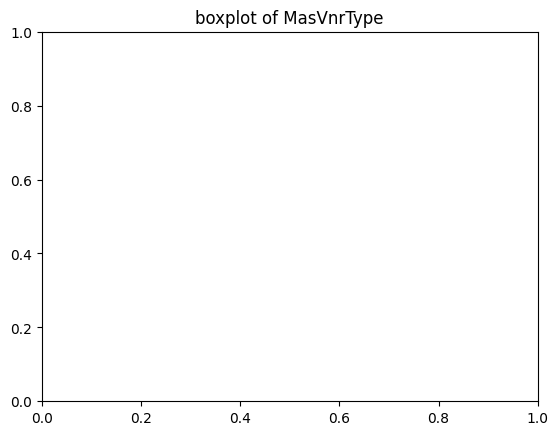

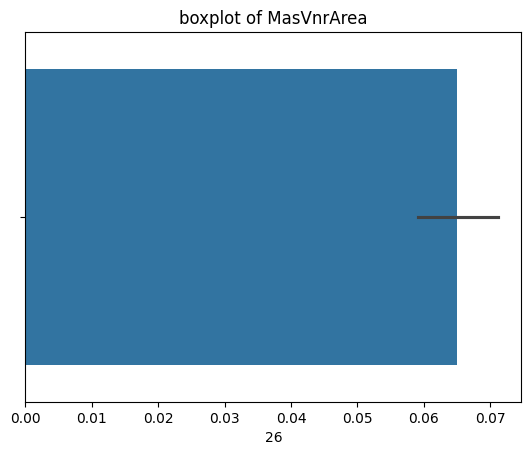

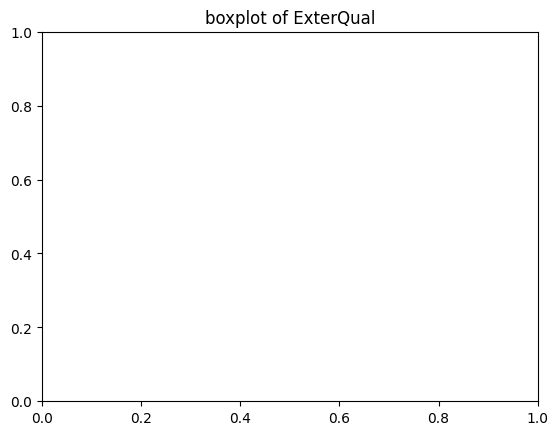

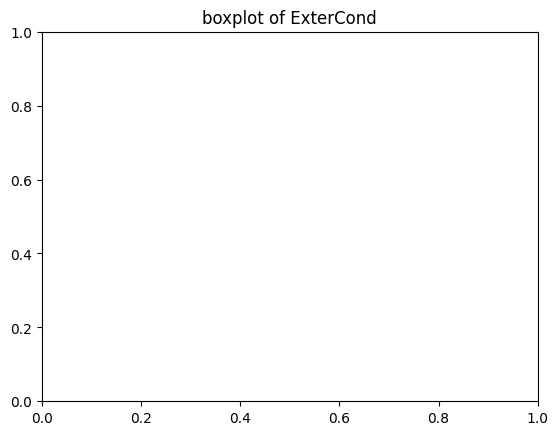

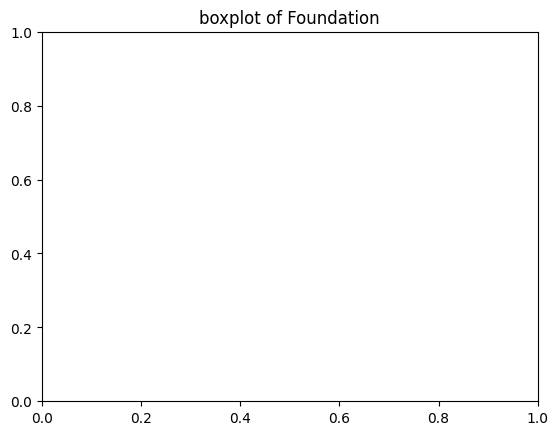

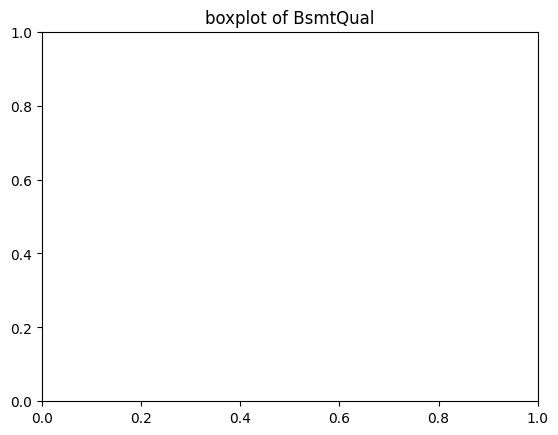

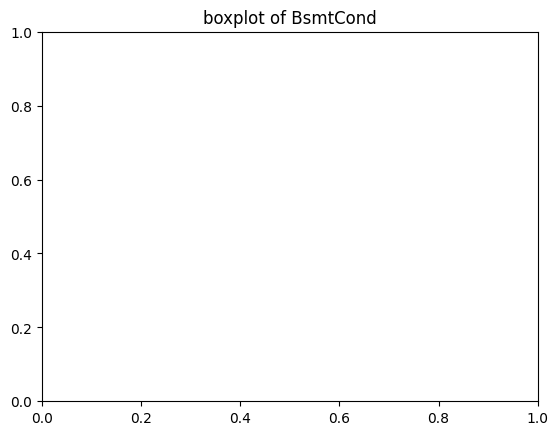

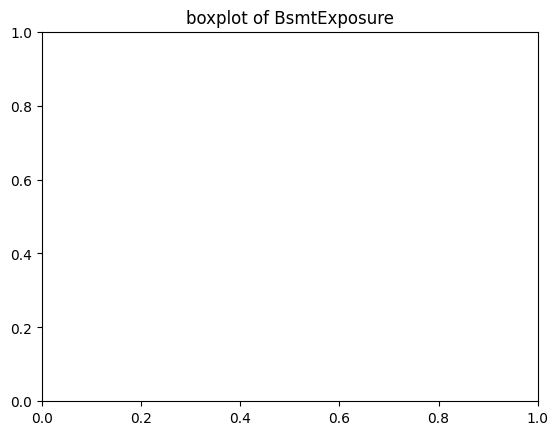

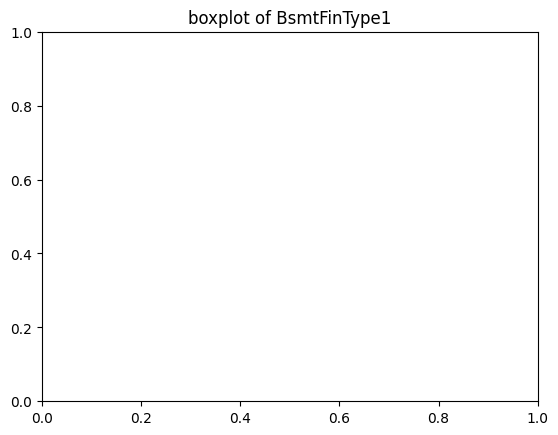

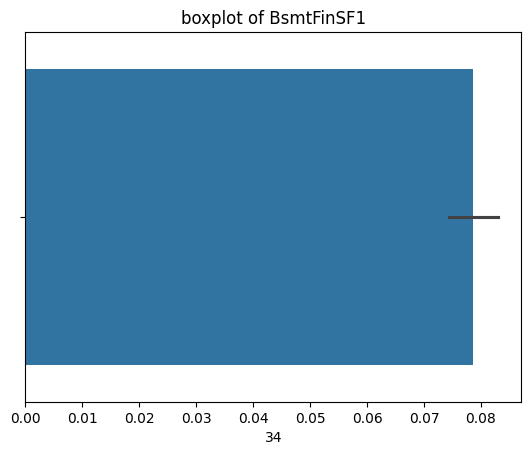

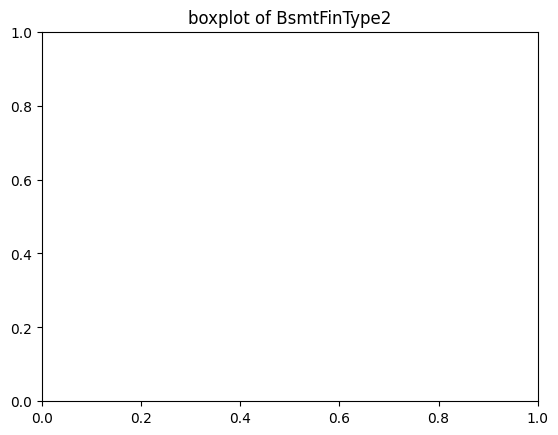

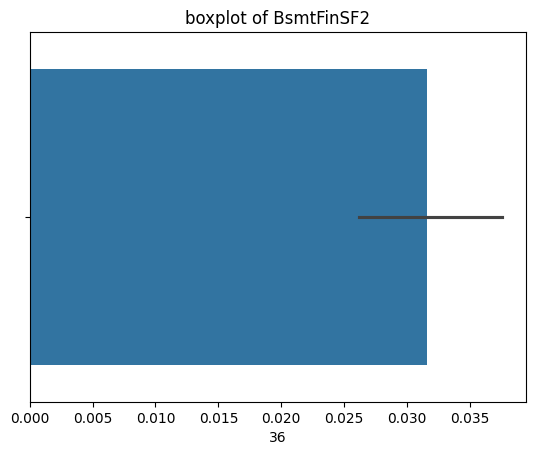

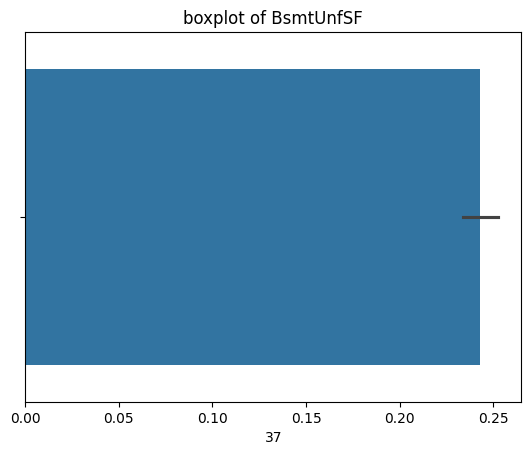

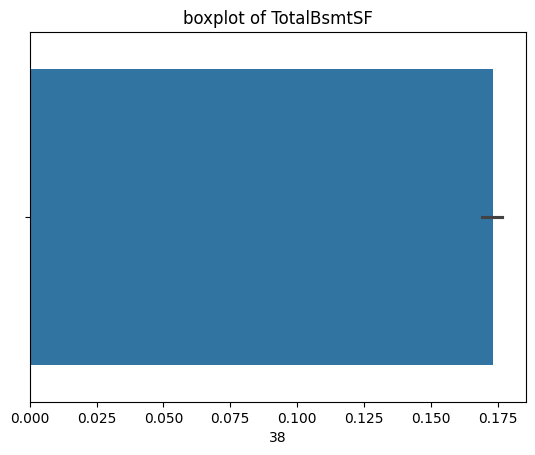

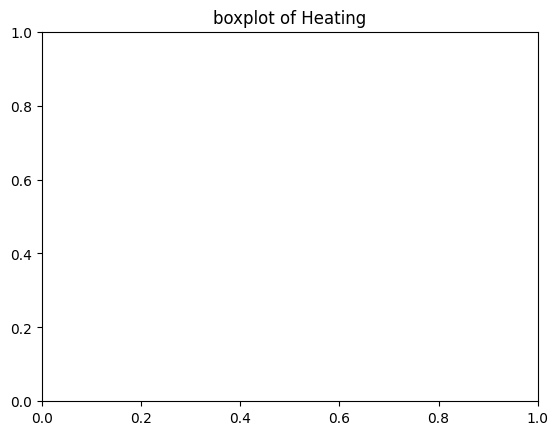

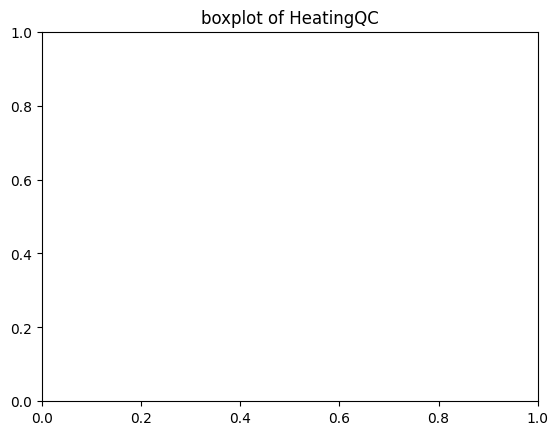

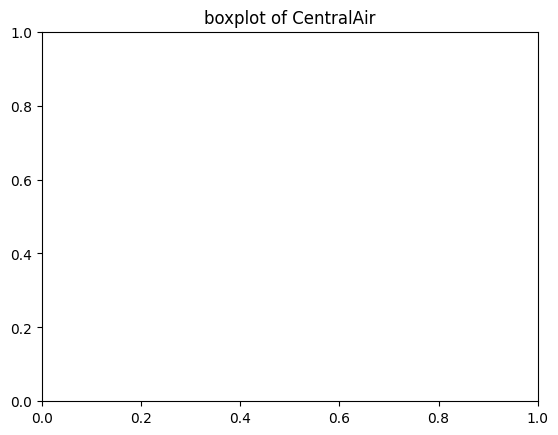

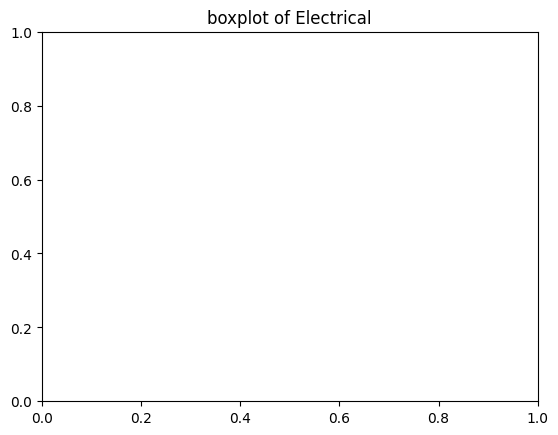

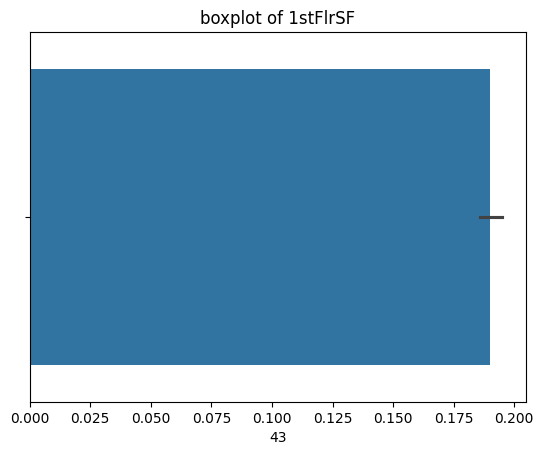

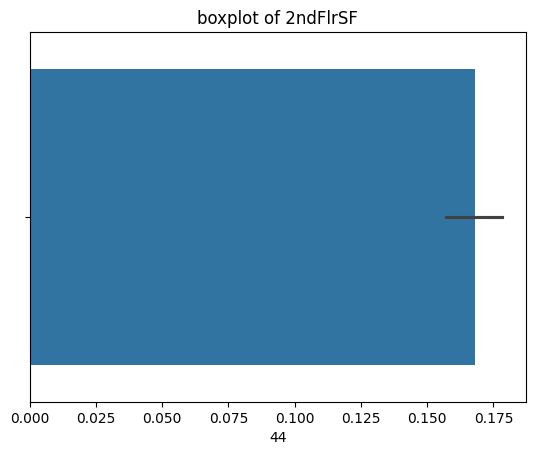

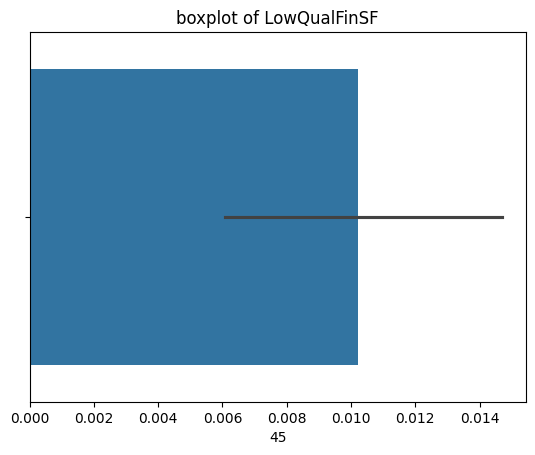

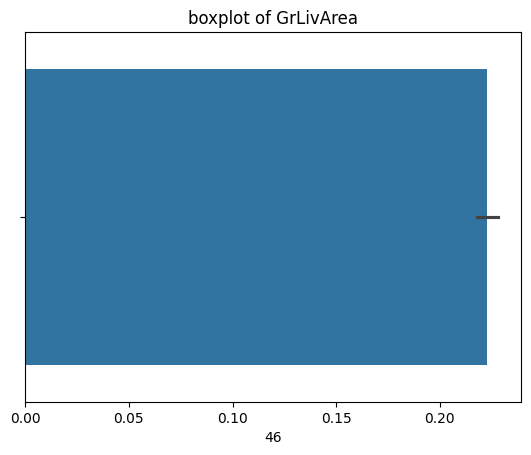

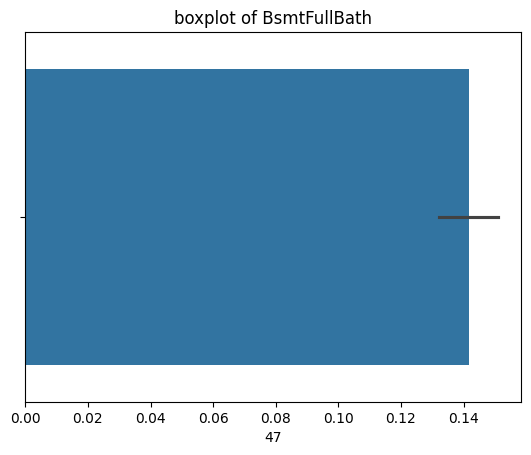

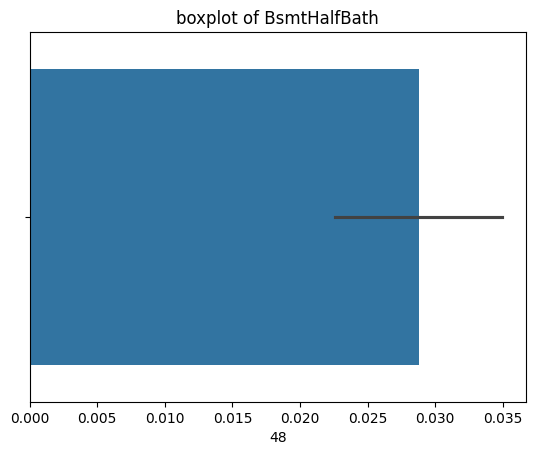

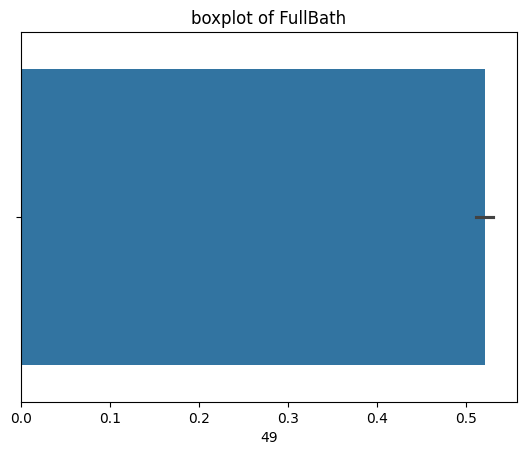

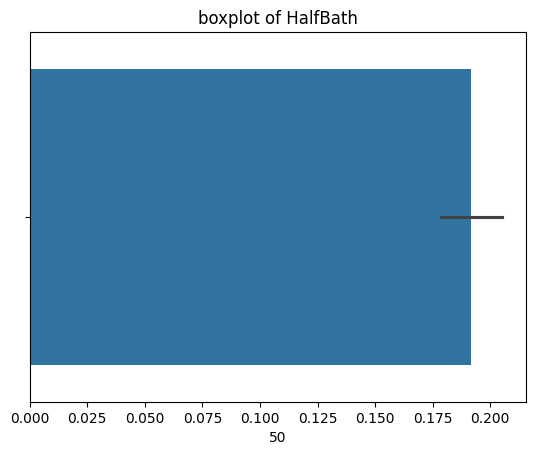

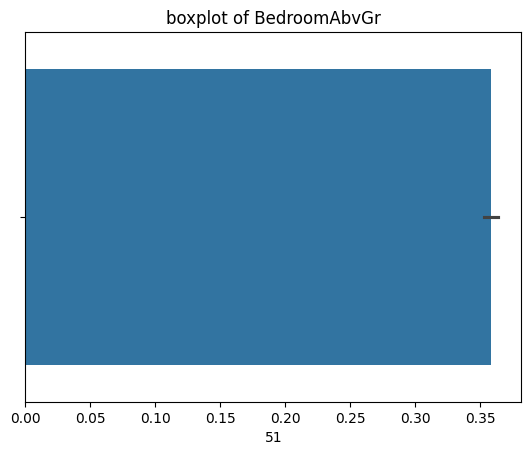

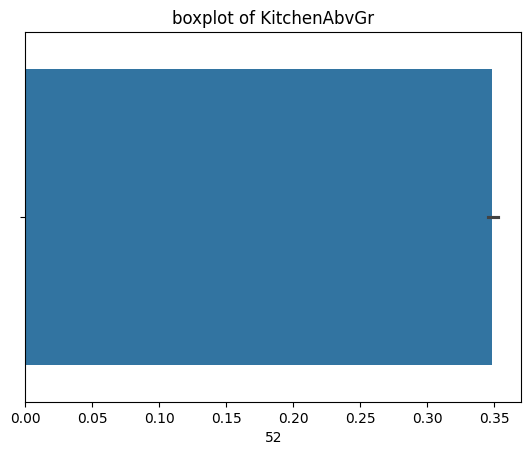

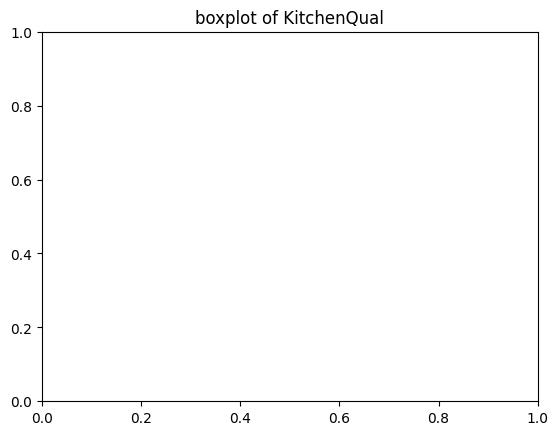

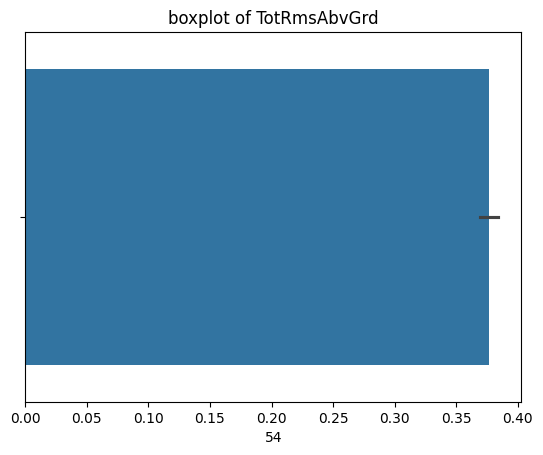

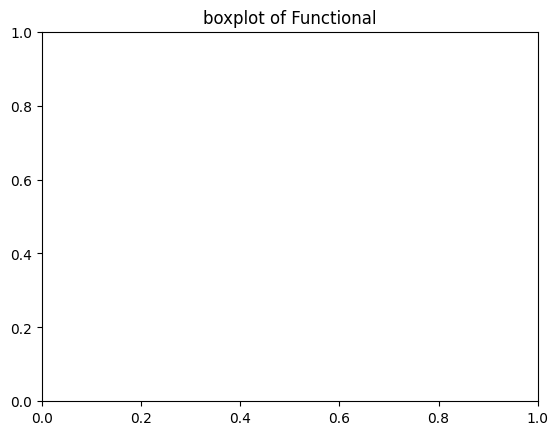

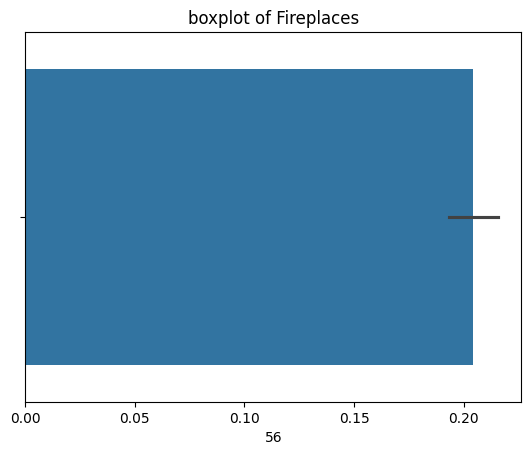

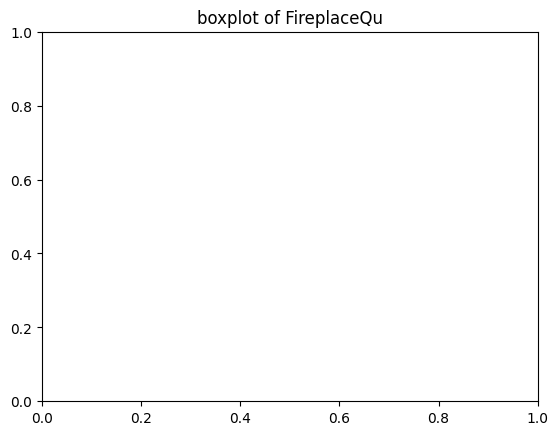

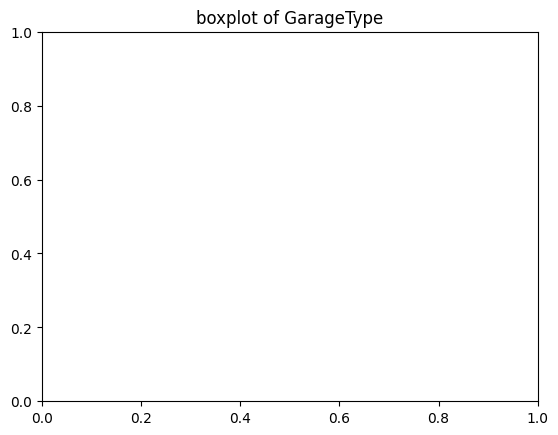

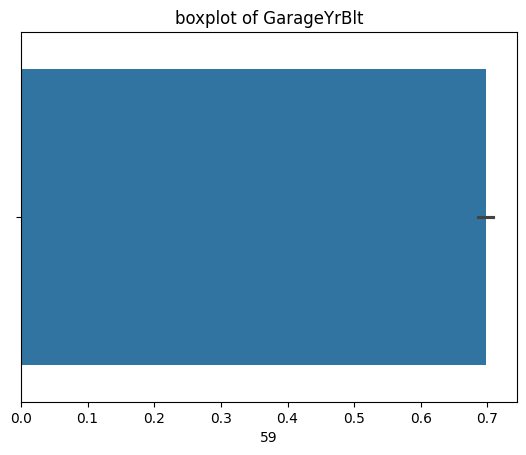

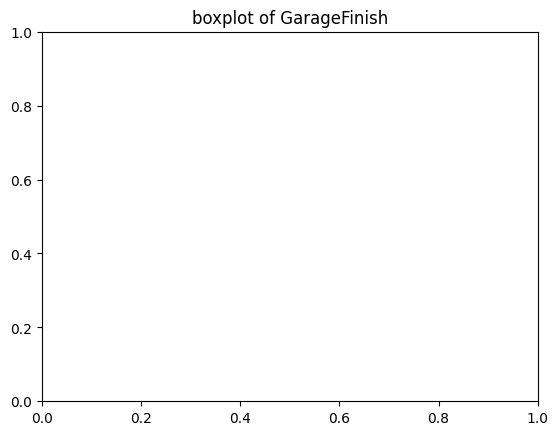

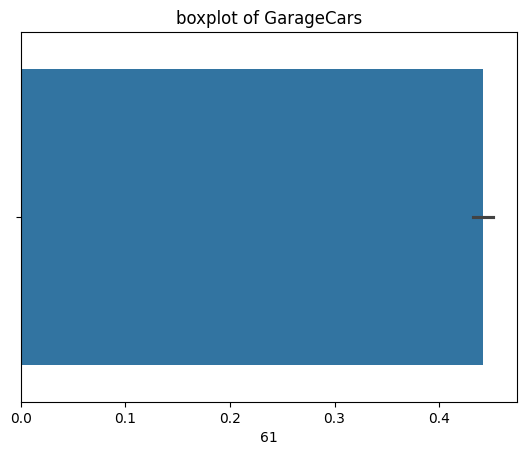

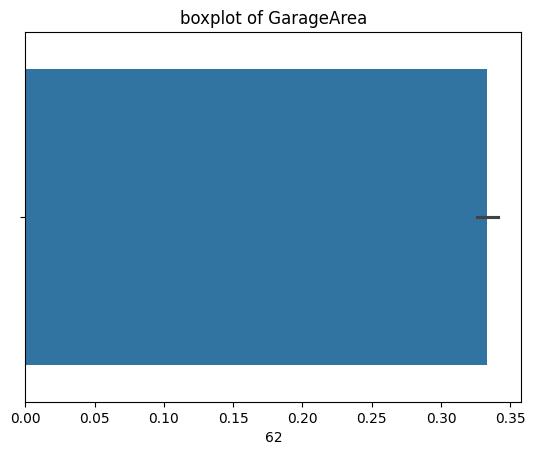

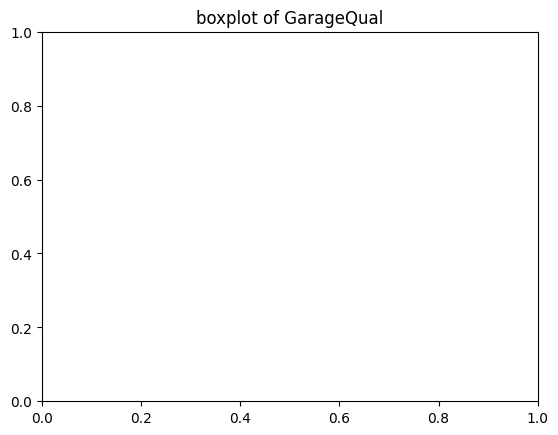

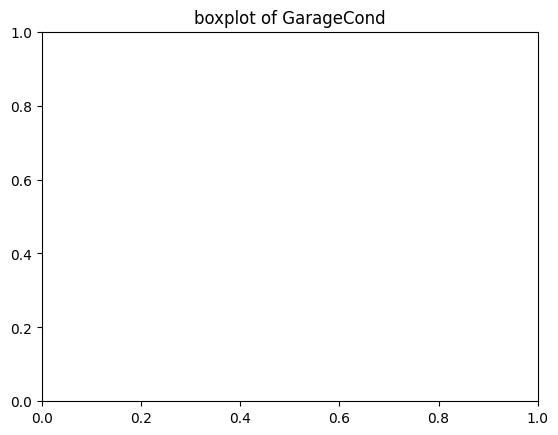

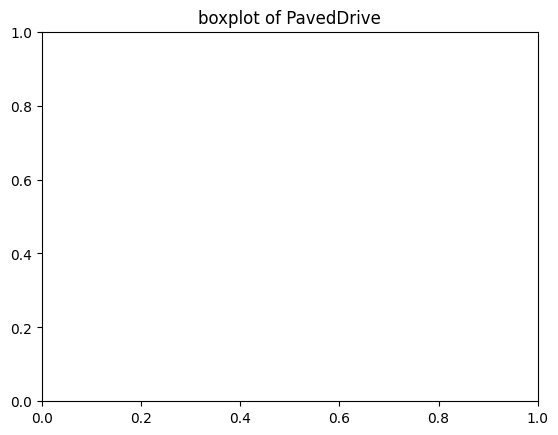

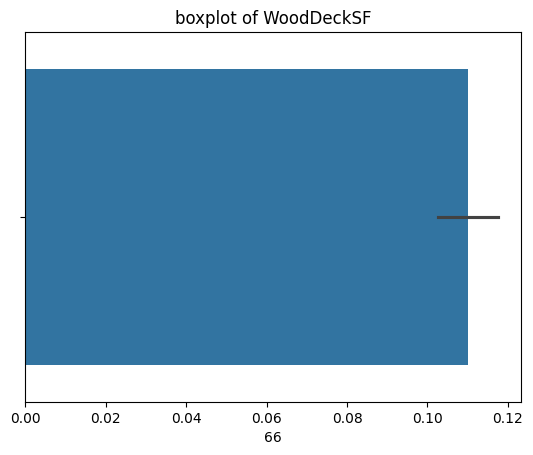

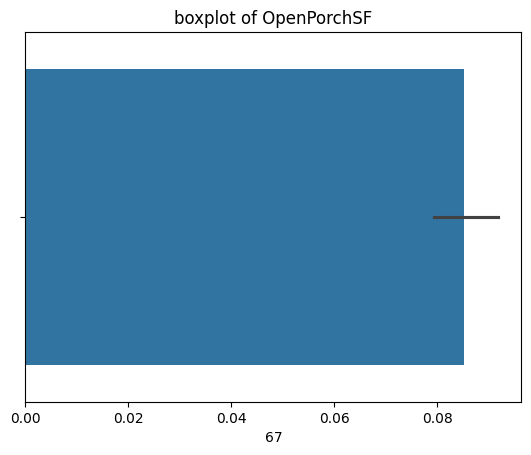

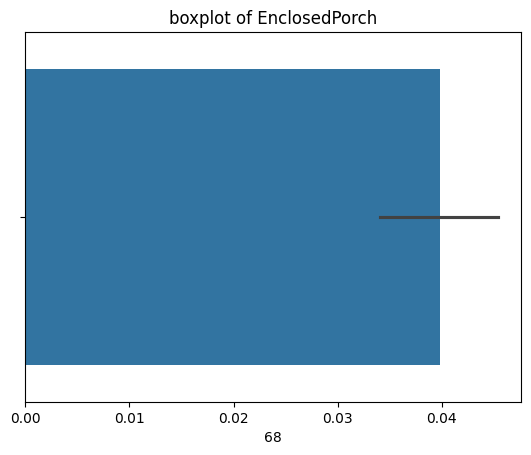

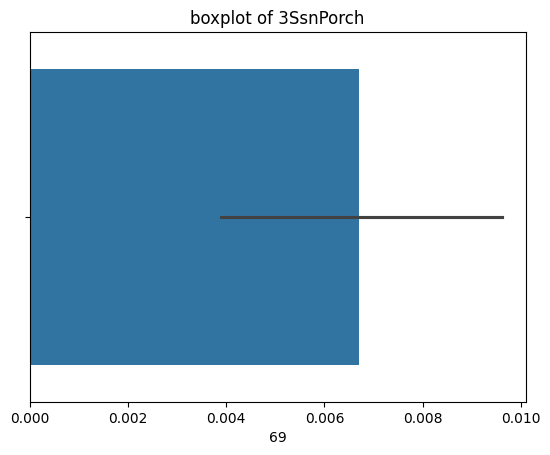

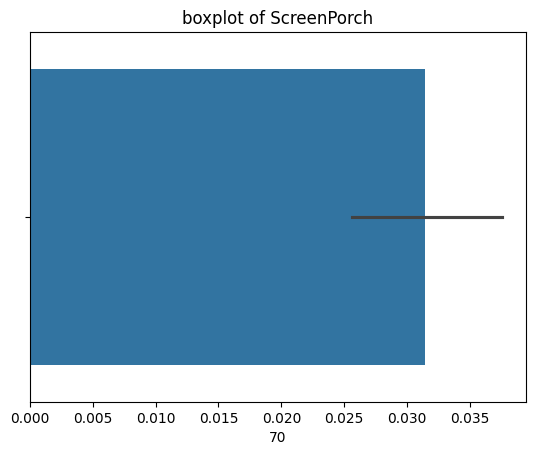

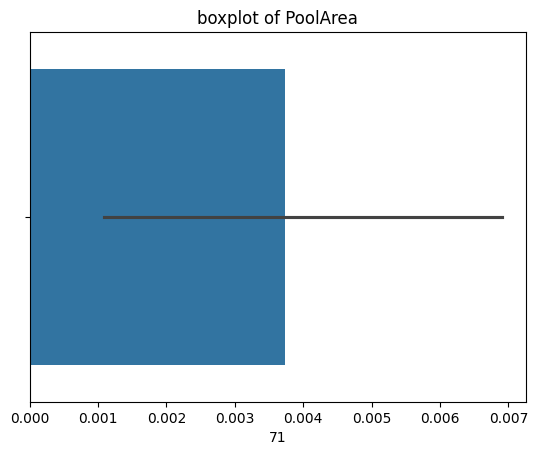

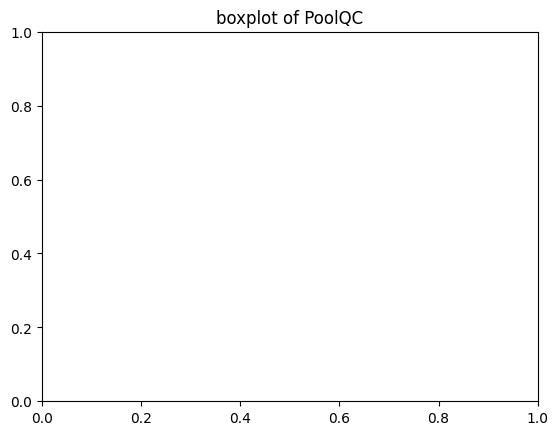

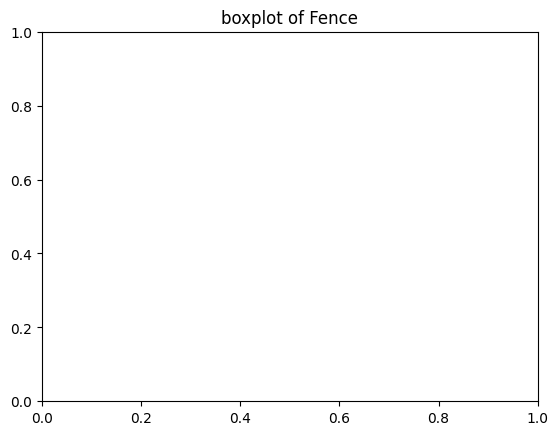

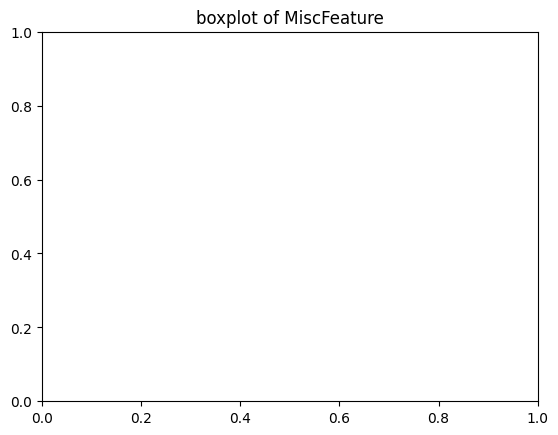

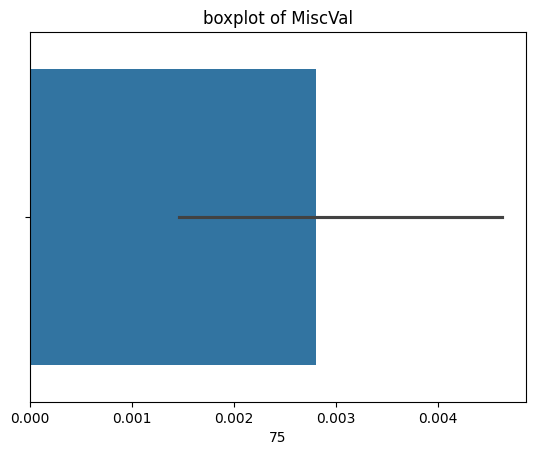

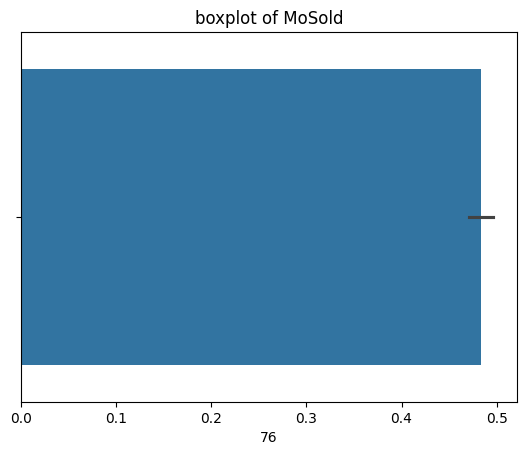

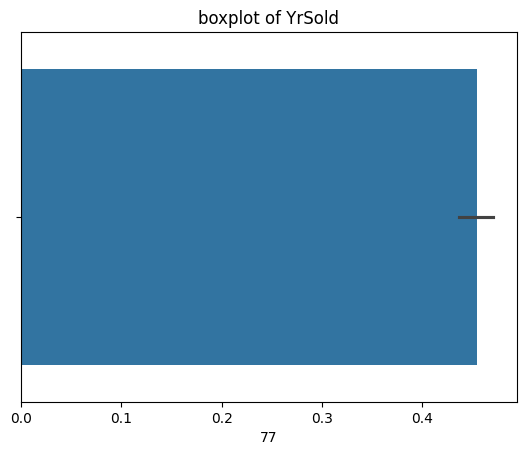

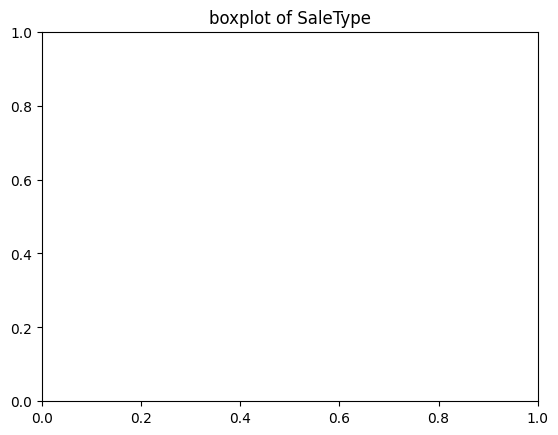

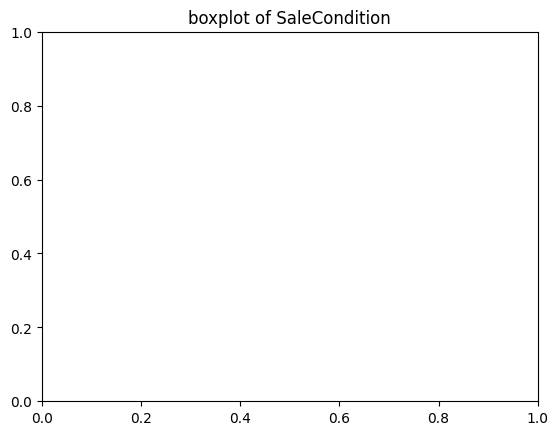

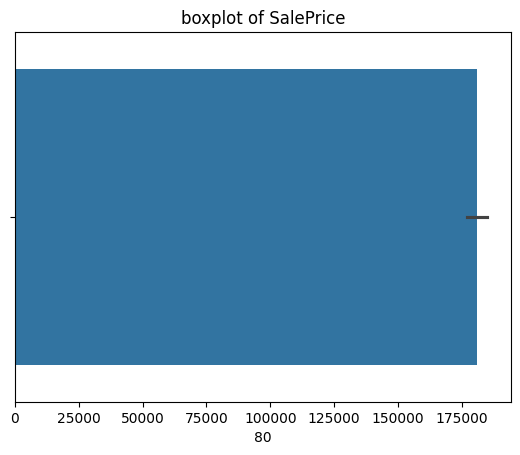

In [17]:
display_boxplot(train_minmax_transformed)

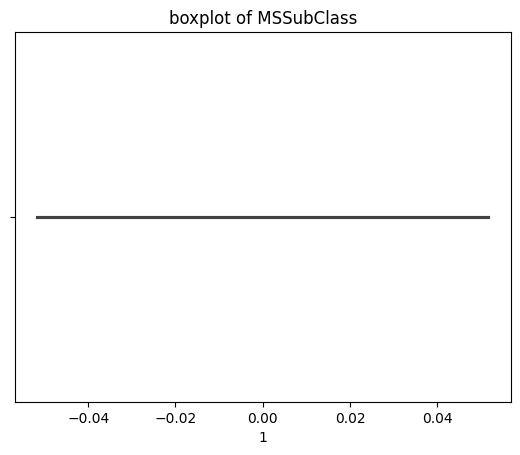

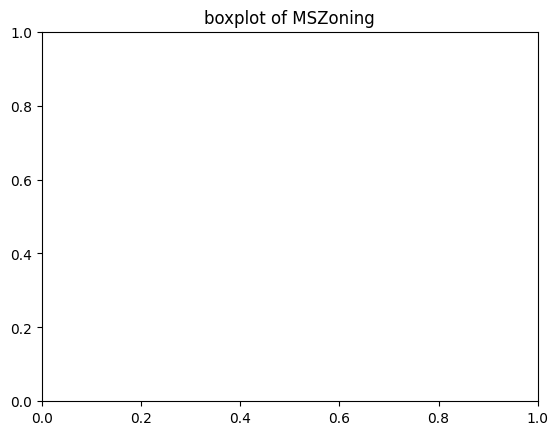

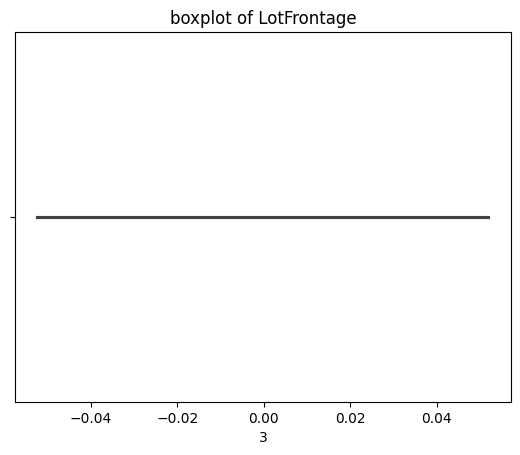

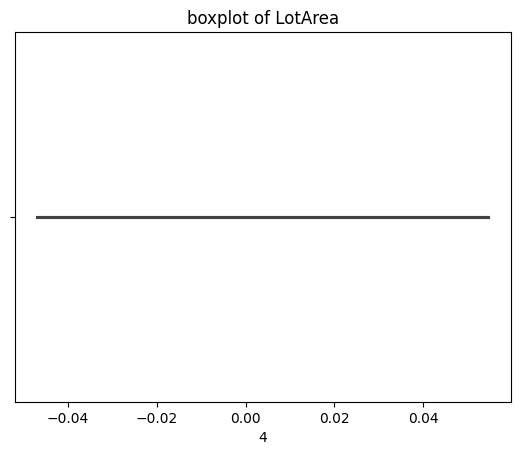

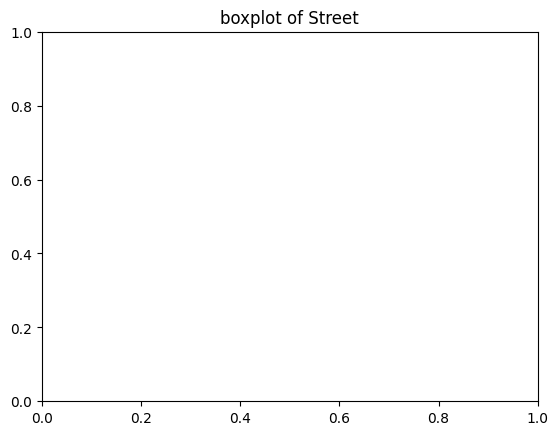

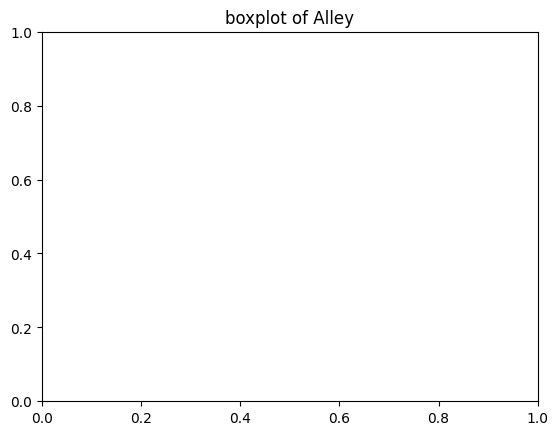

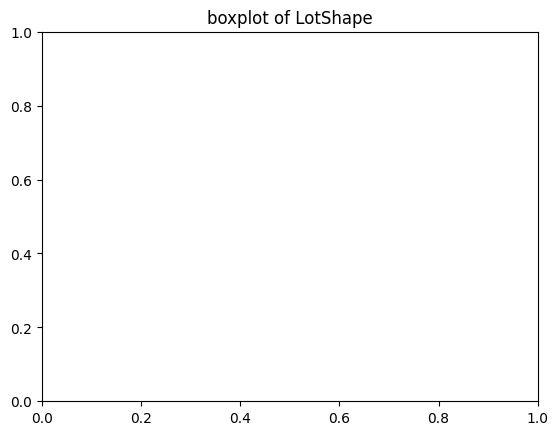

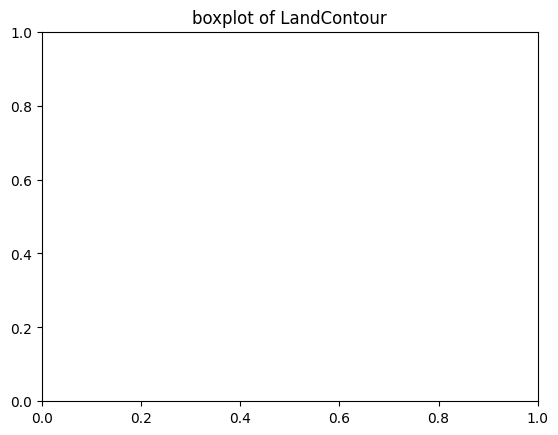

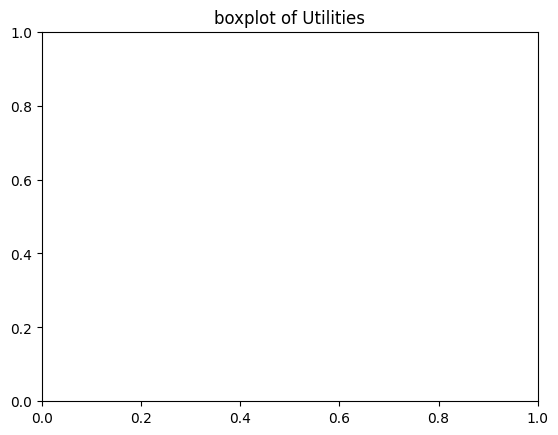

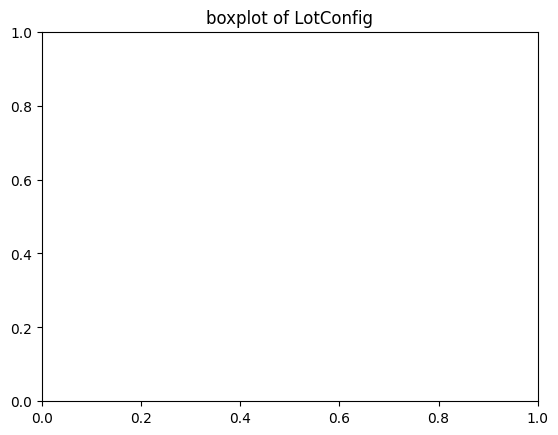

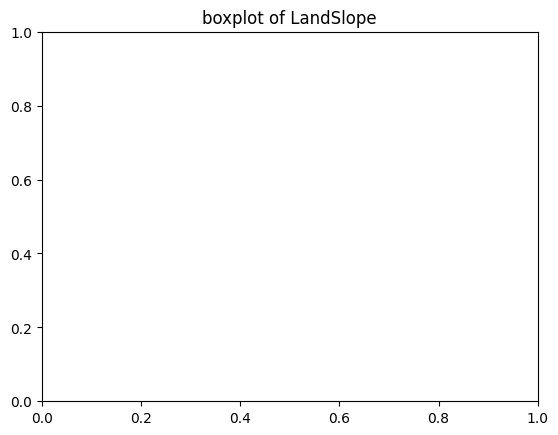

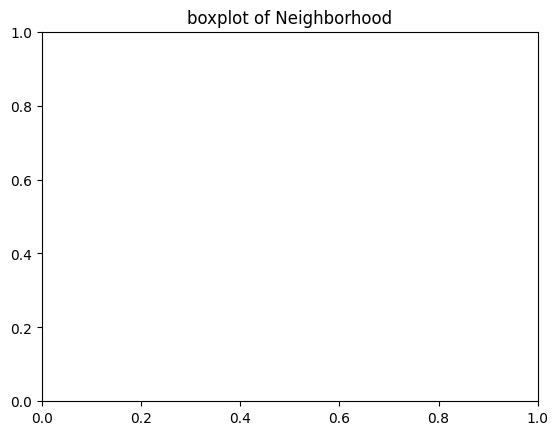

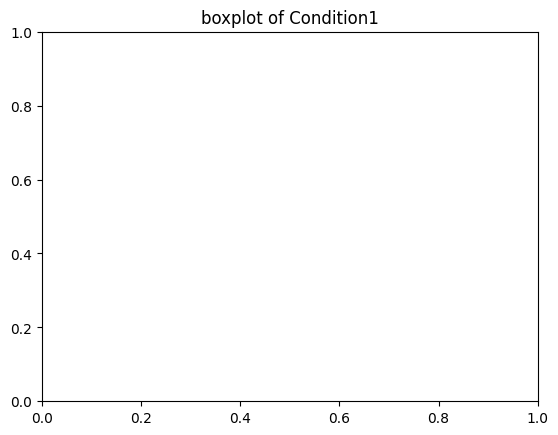

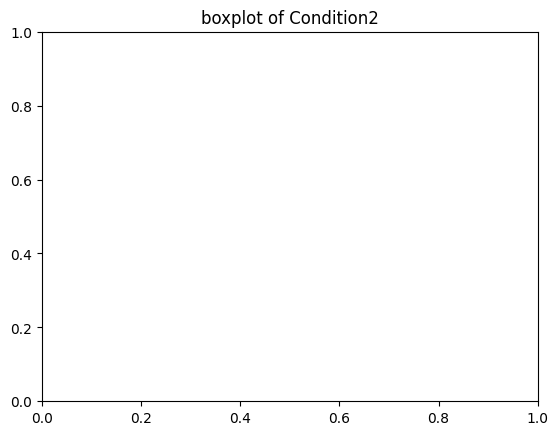

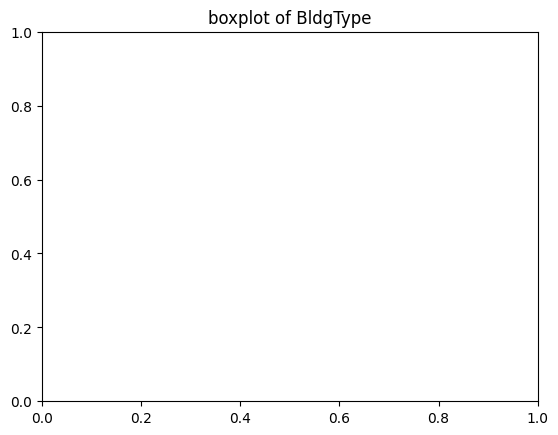

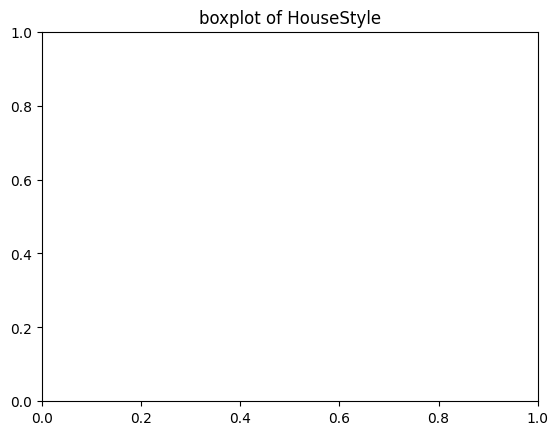

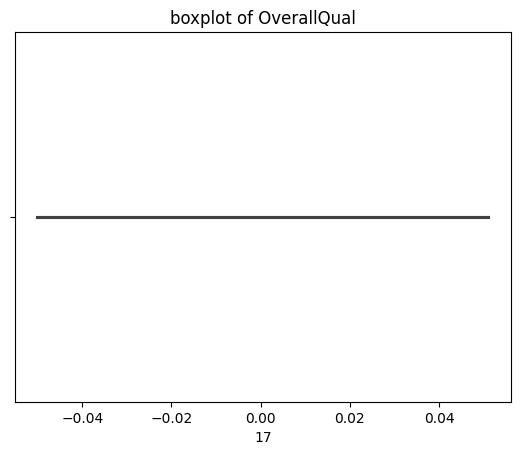

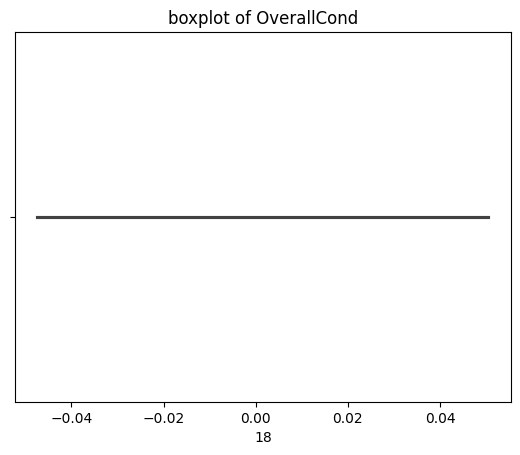

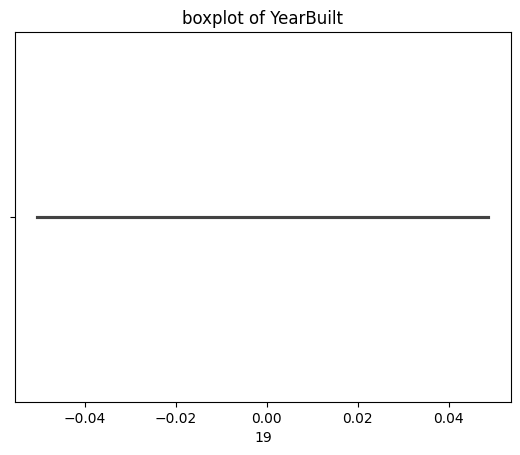

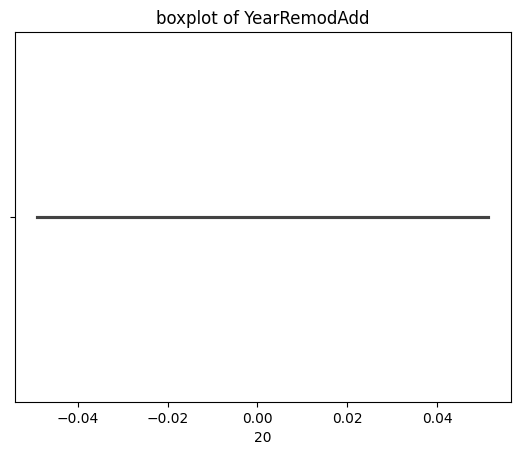

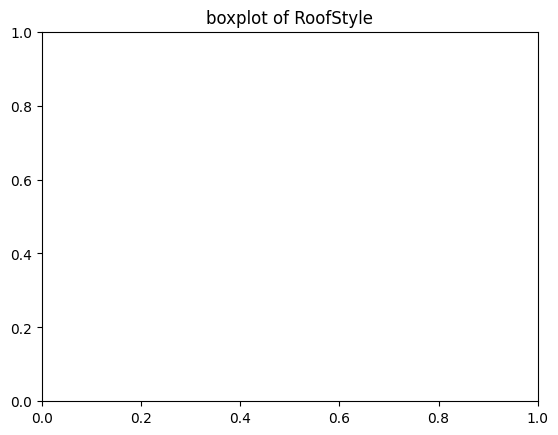

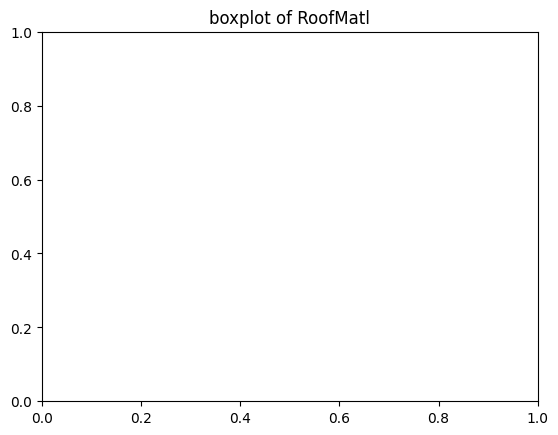

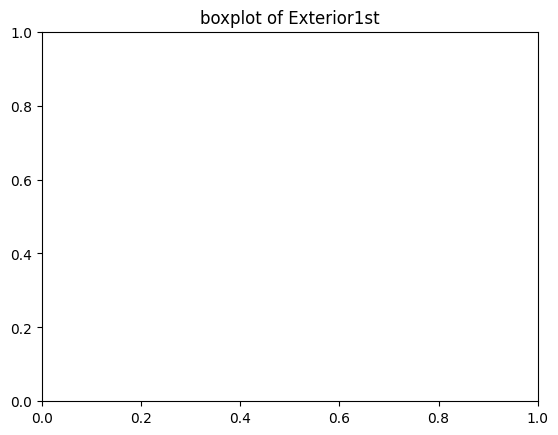

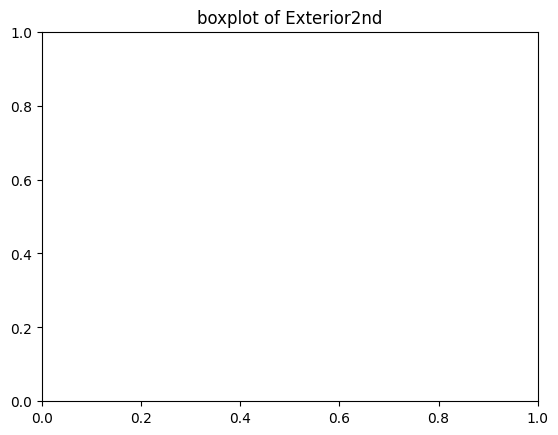

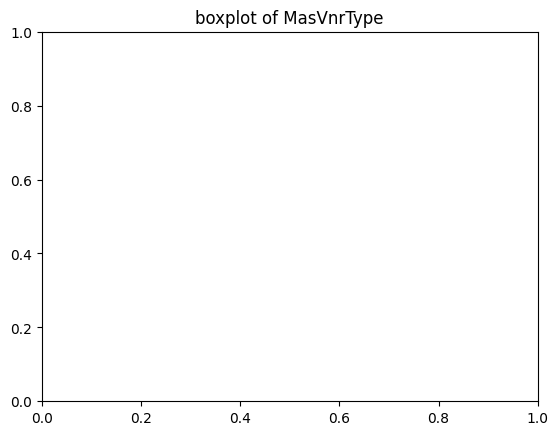

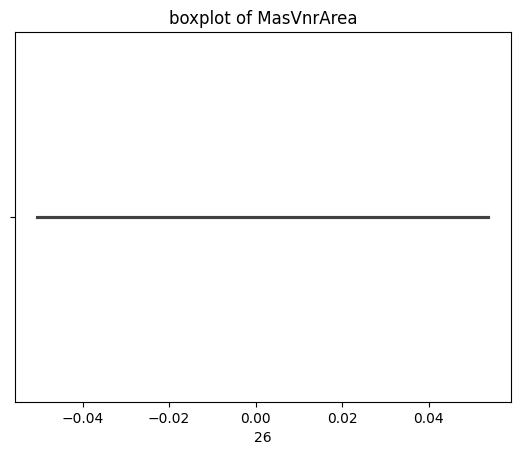

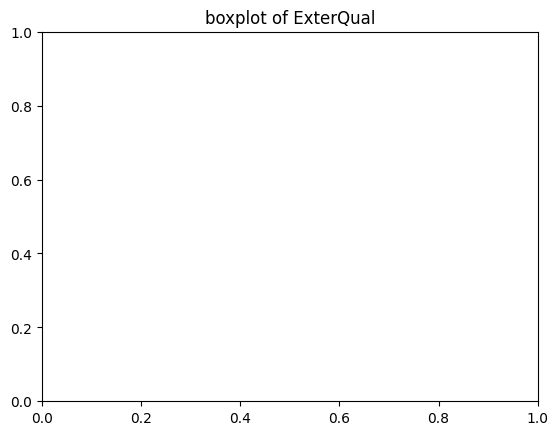

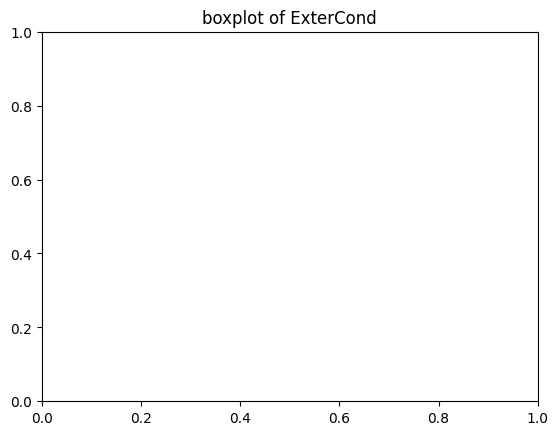

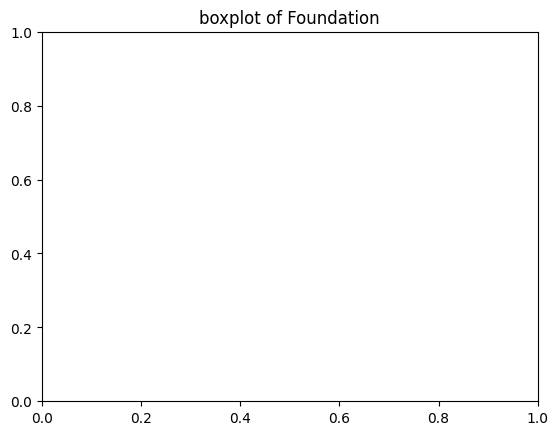

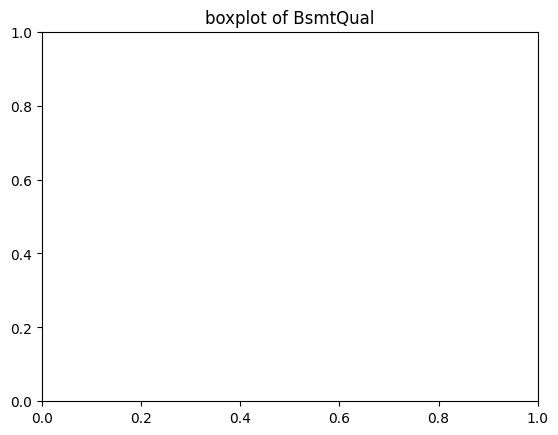

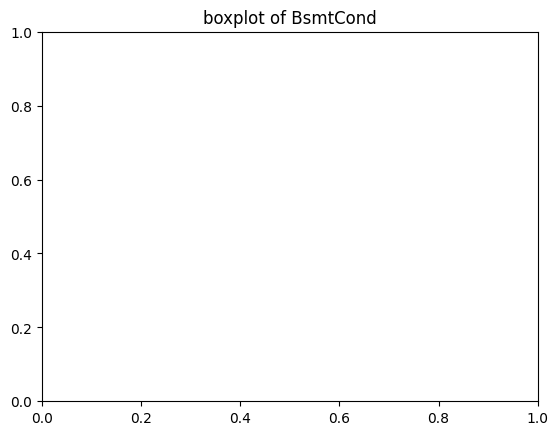

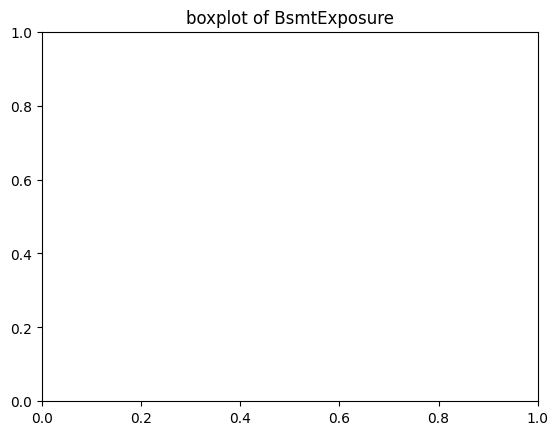

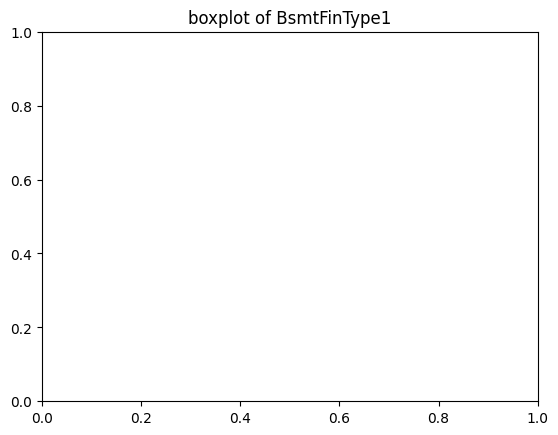

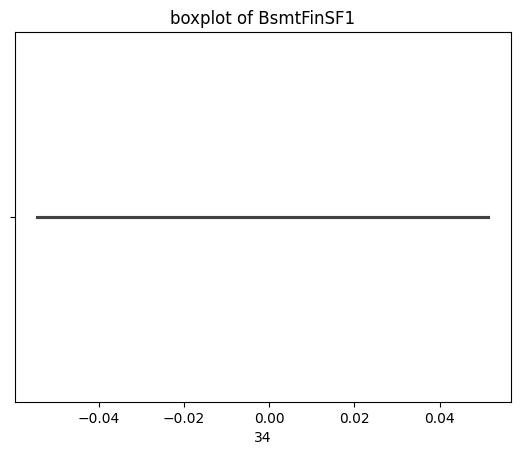

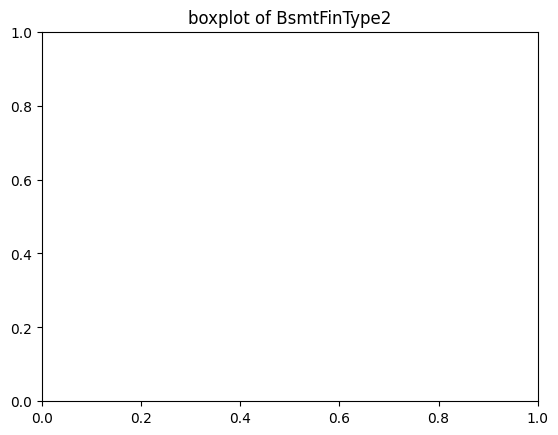

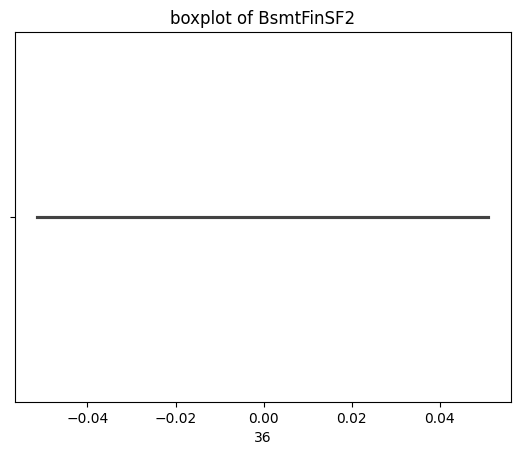

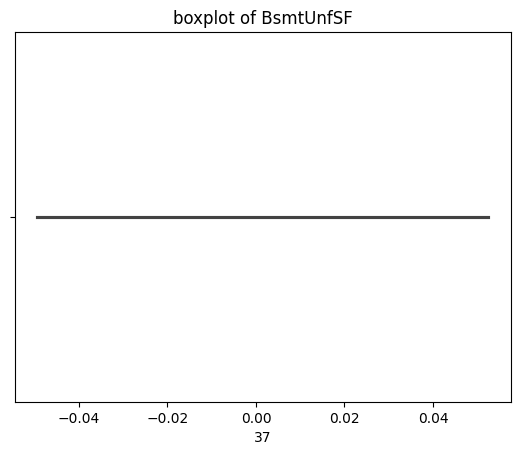

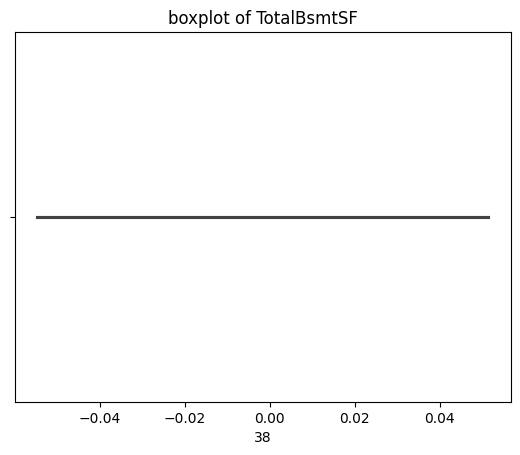

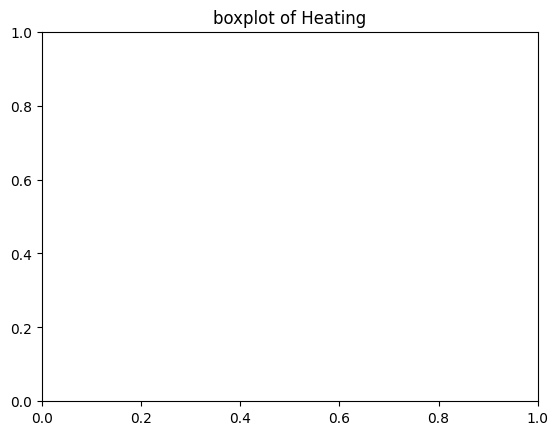

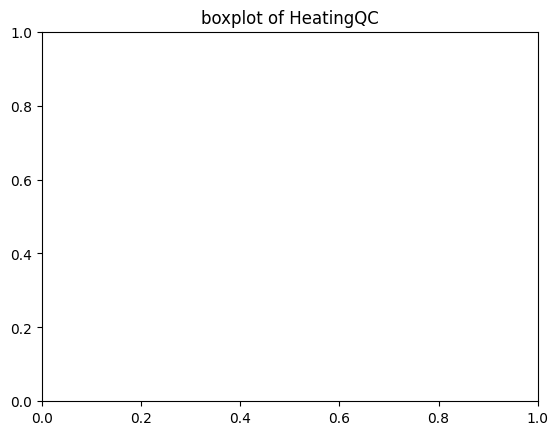

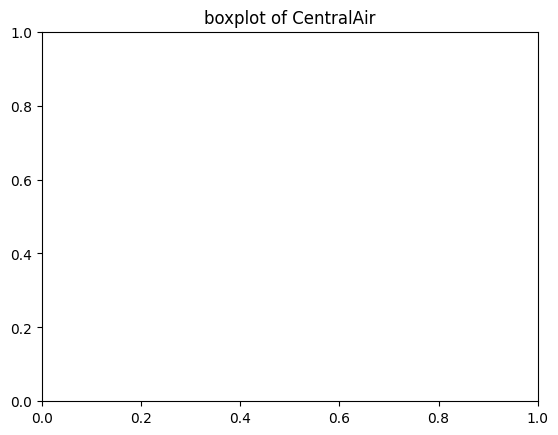

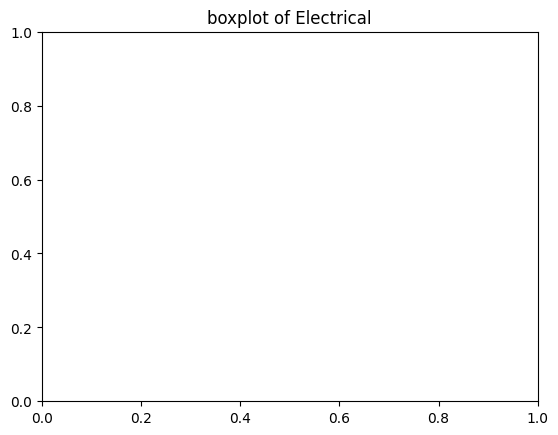

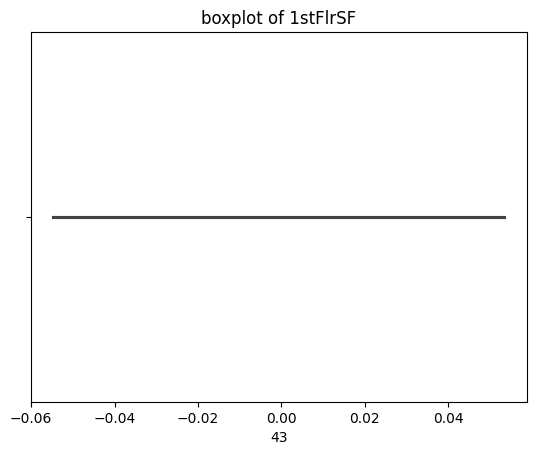

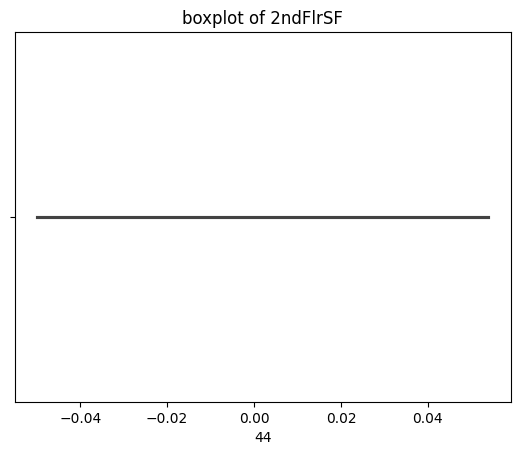

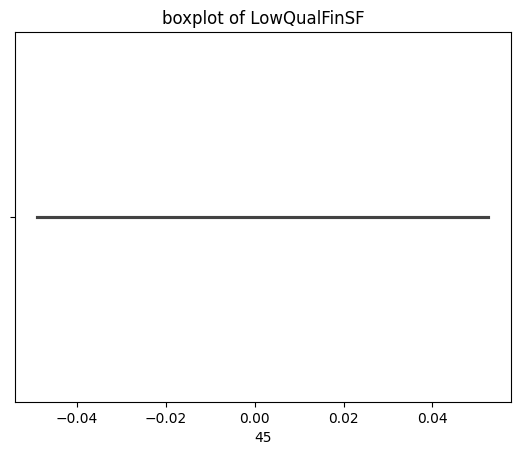

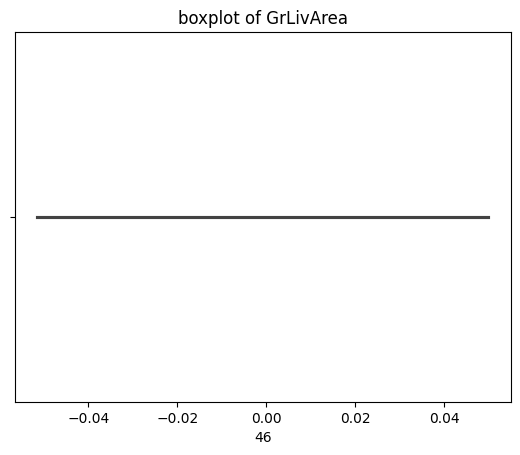

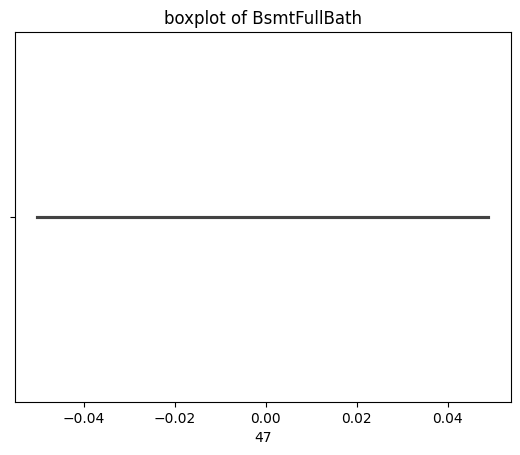

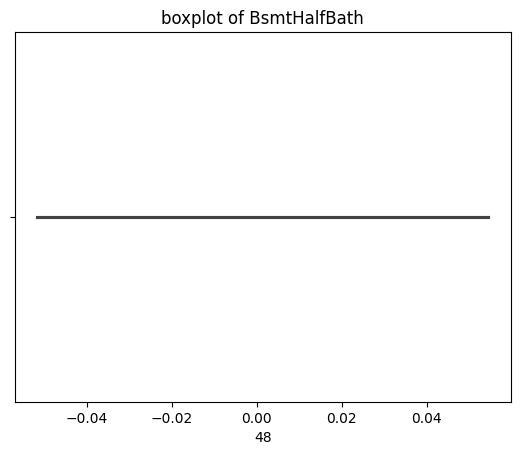

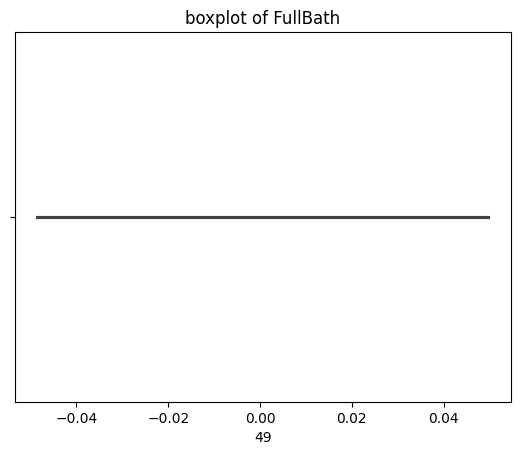

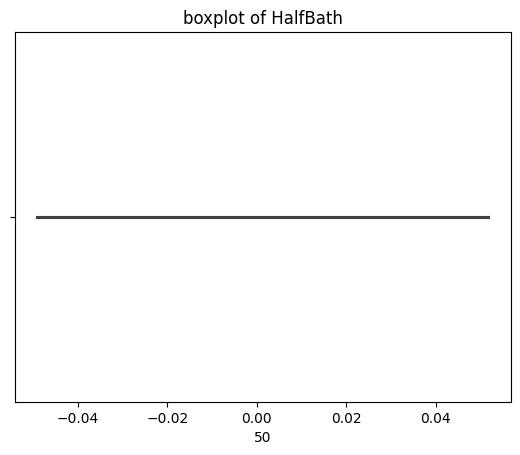

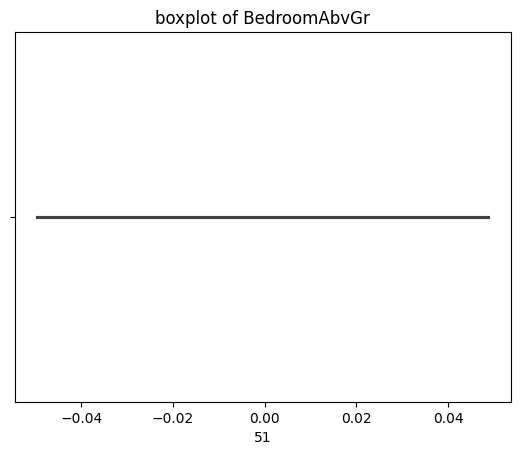

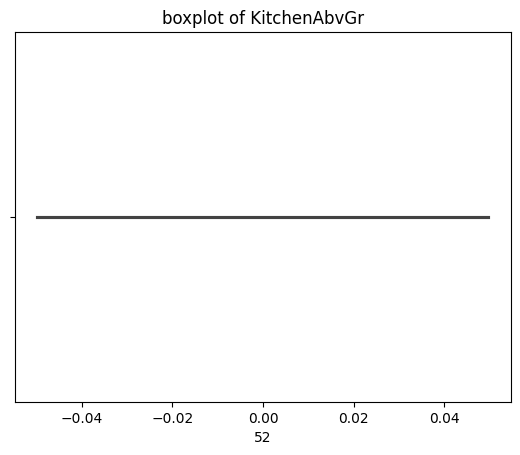

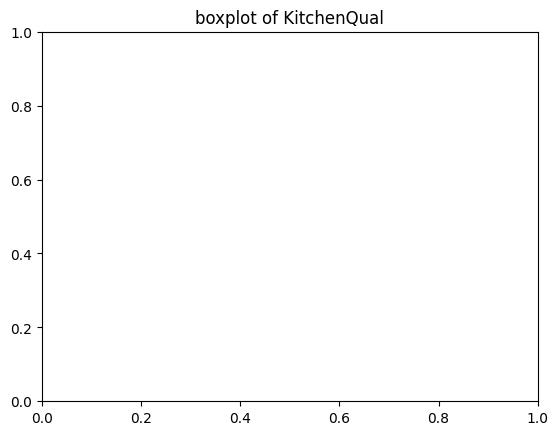

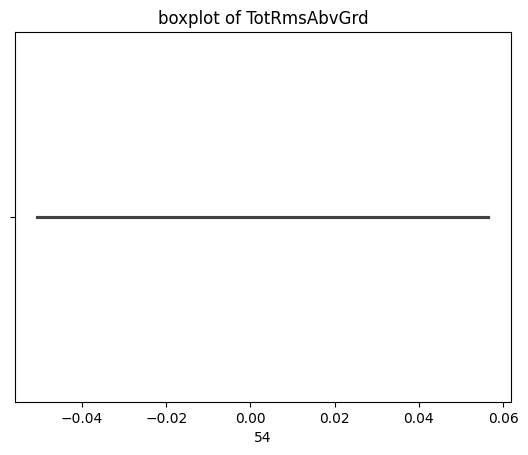

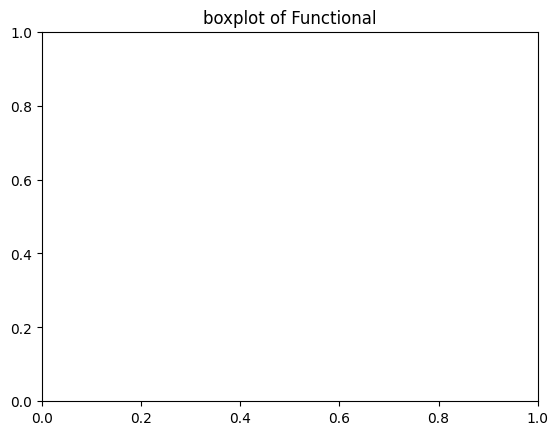

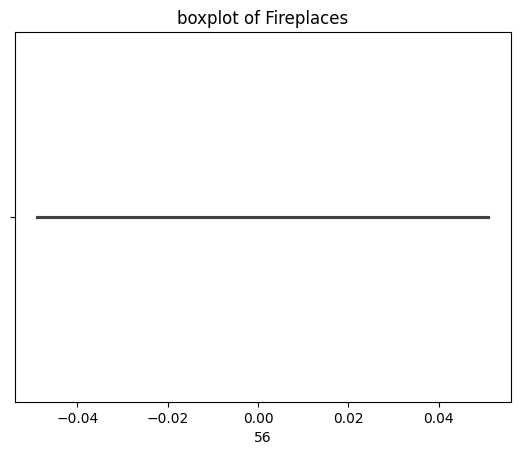

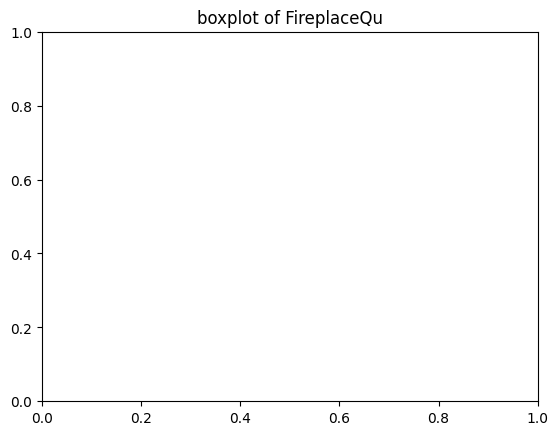

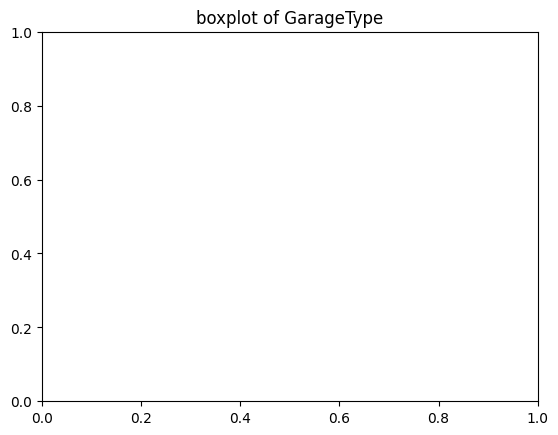

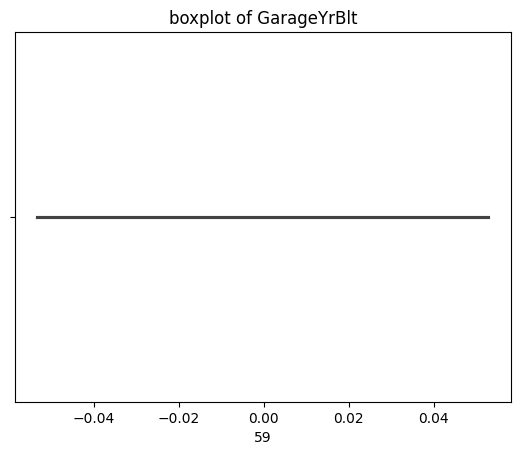

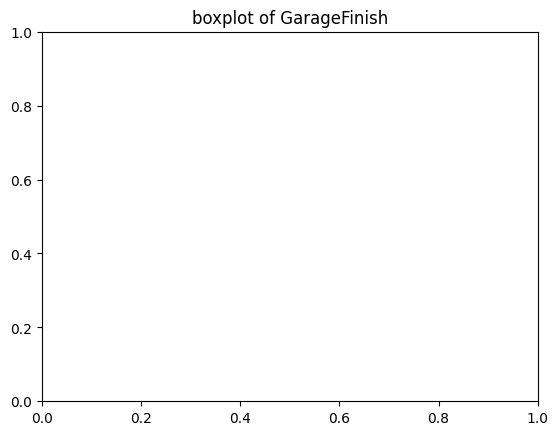

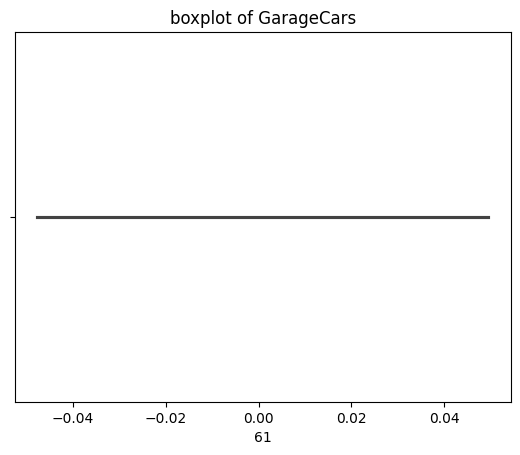

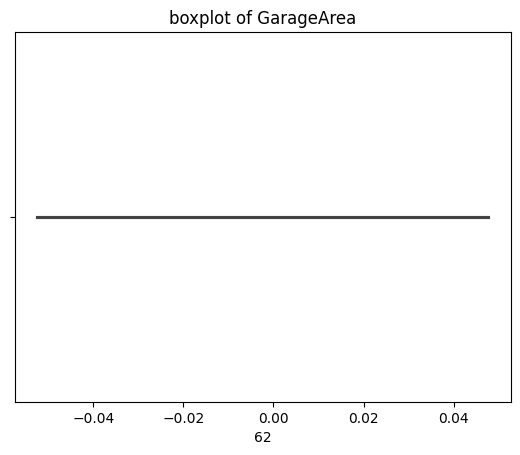

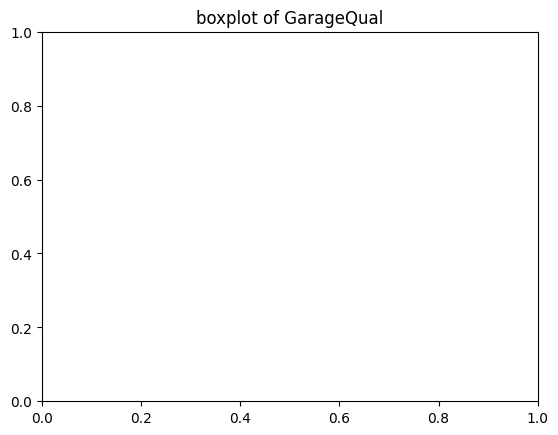

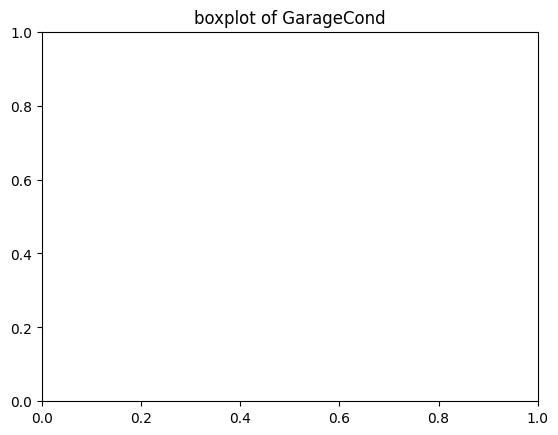

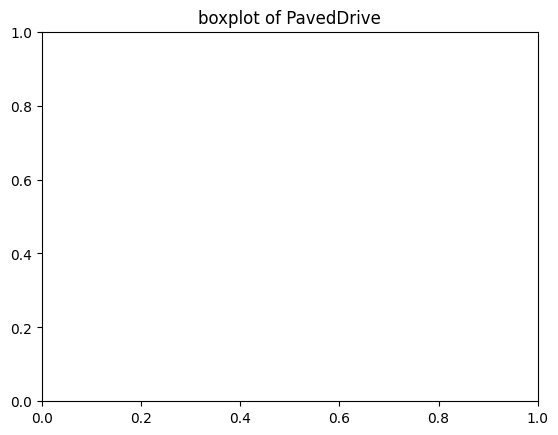

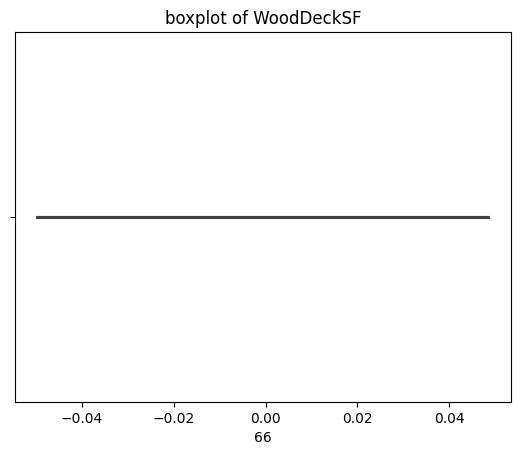

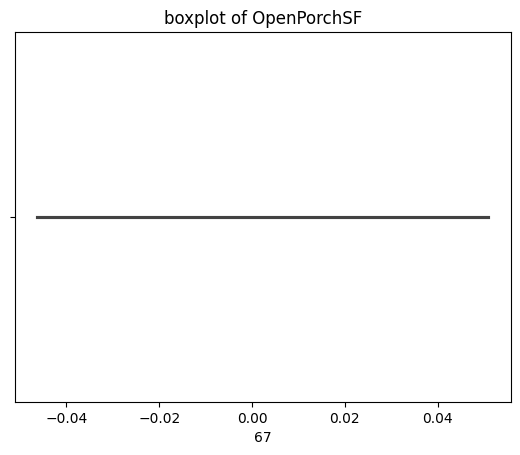

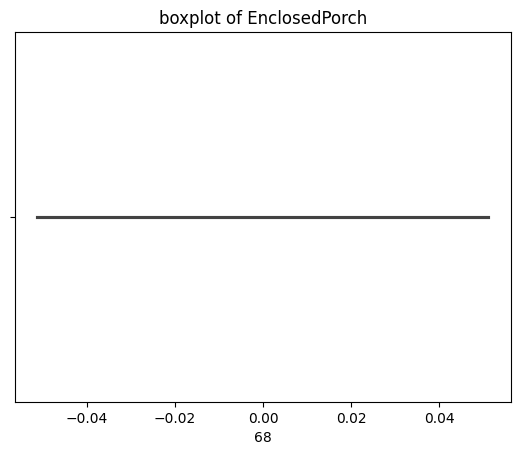

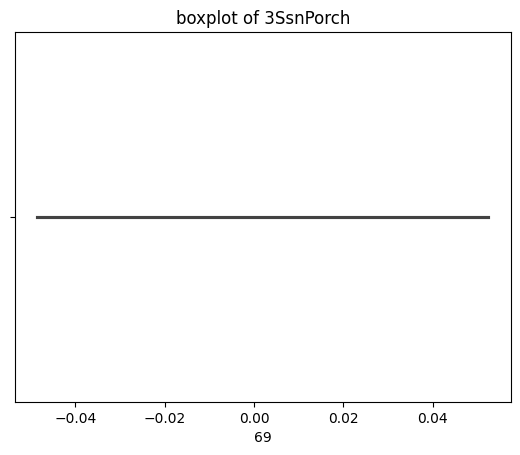

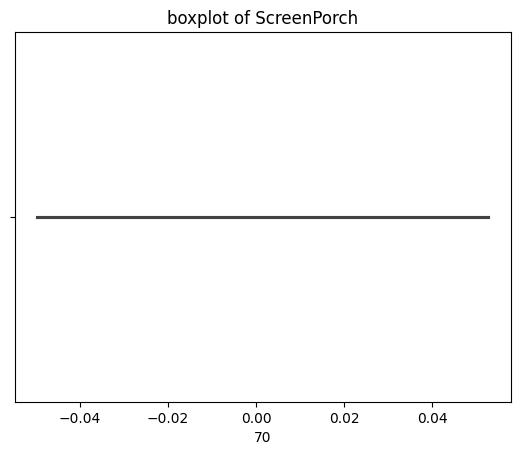

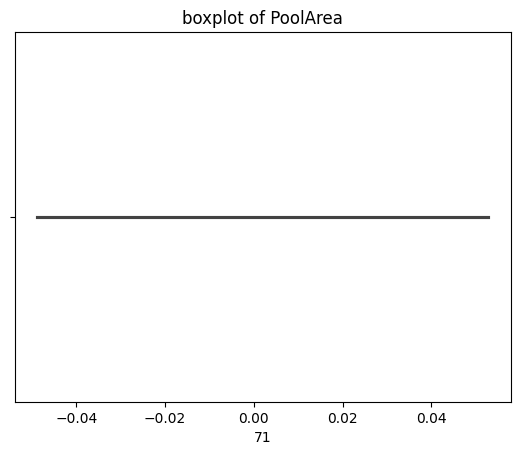

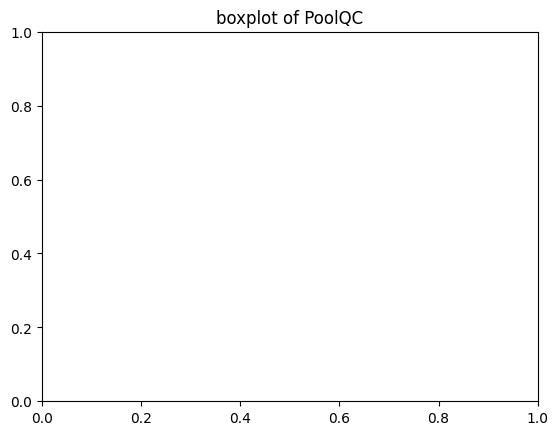

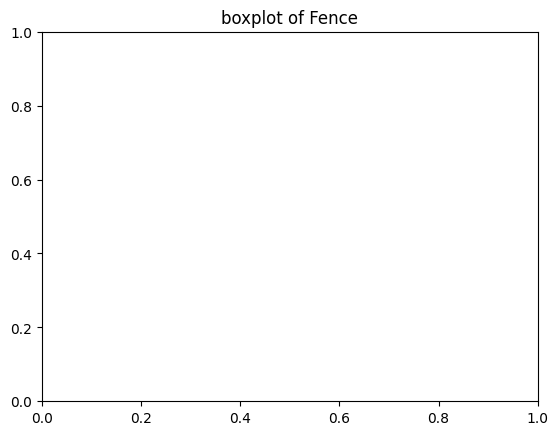

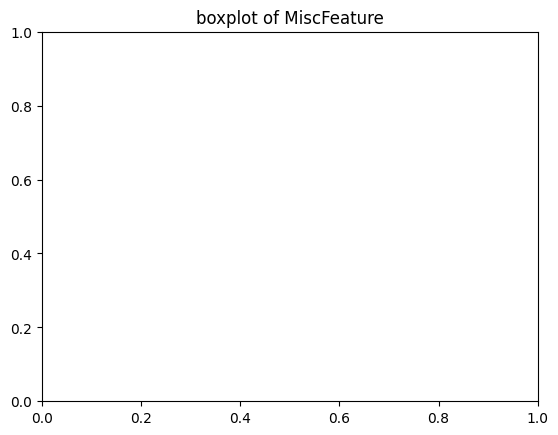

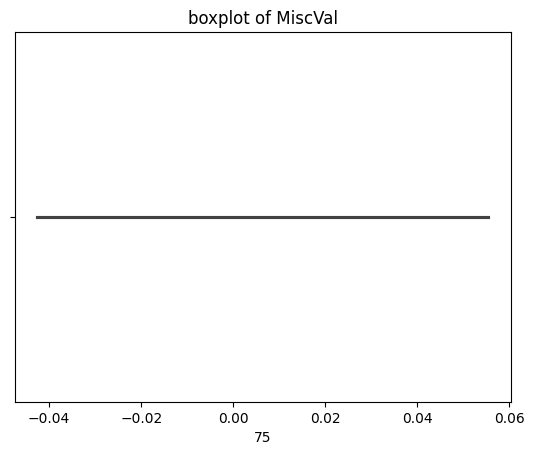

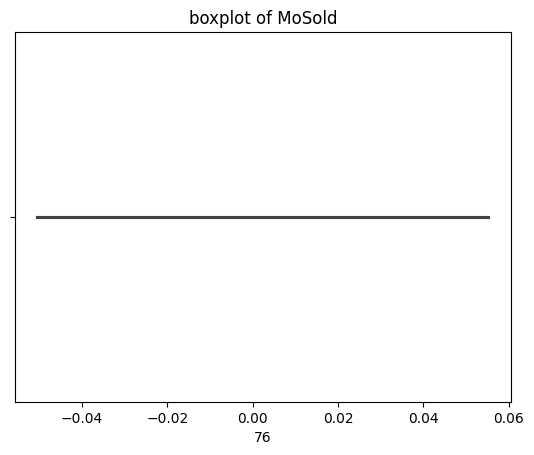

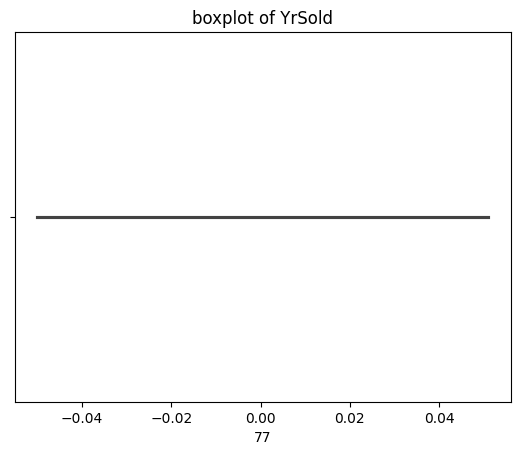

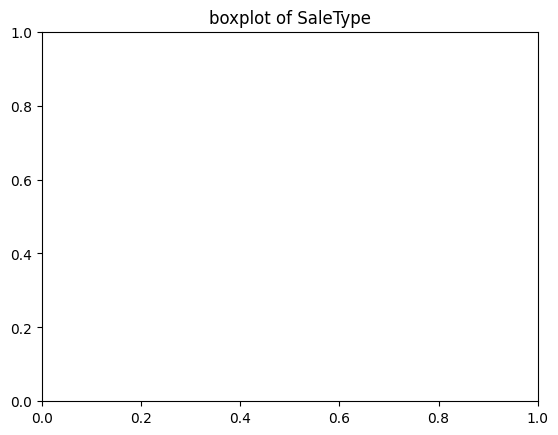

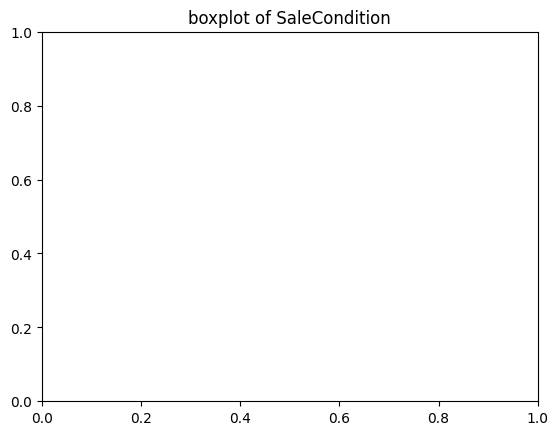

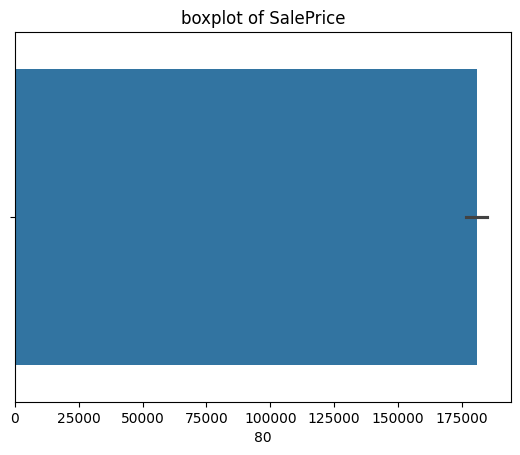

In [18]:
display_boxplot(train_zscore_transformed)

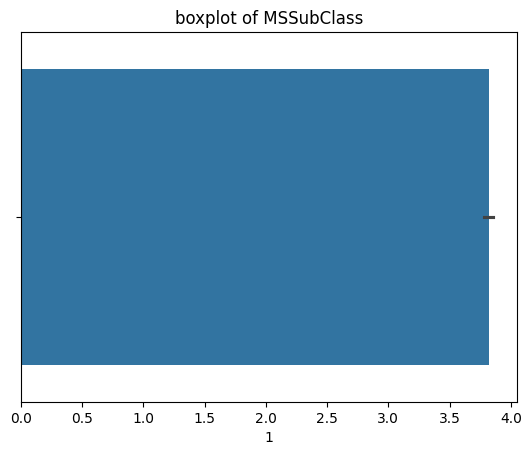

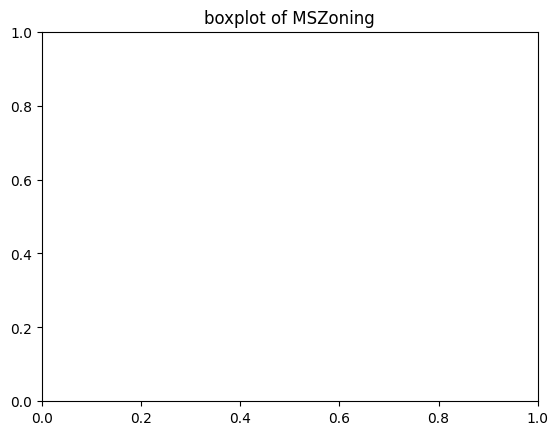

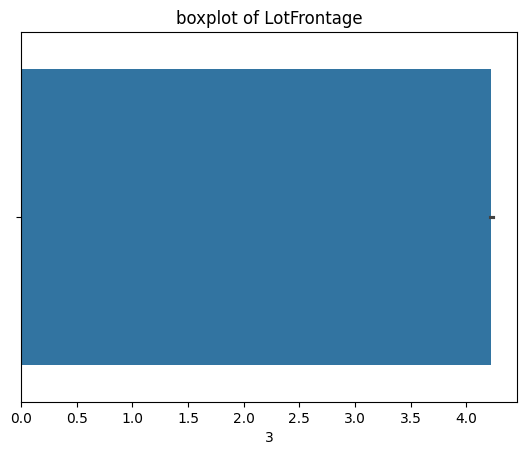

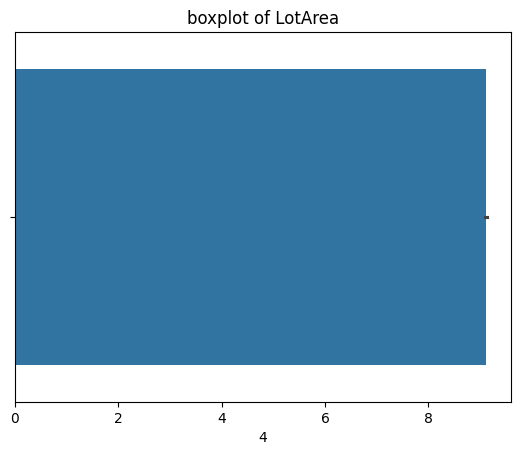

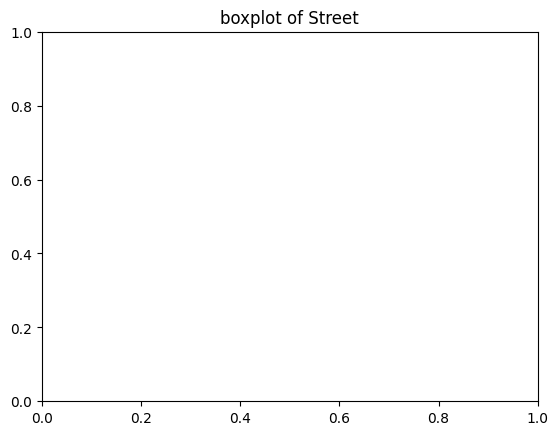

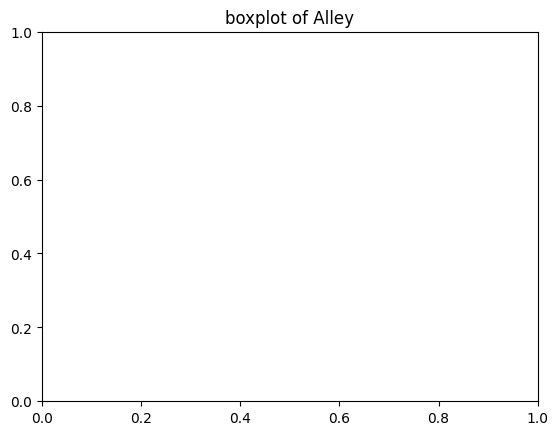

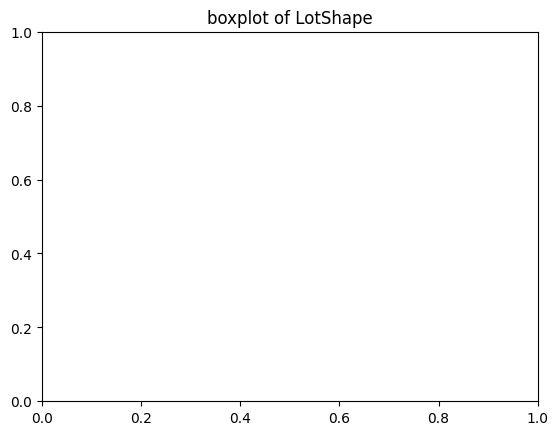

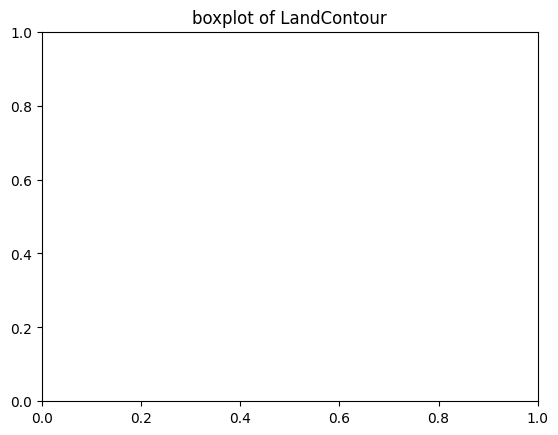

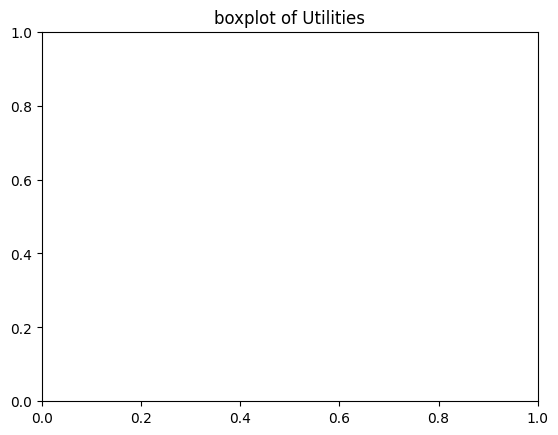

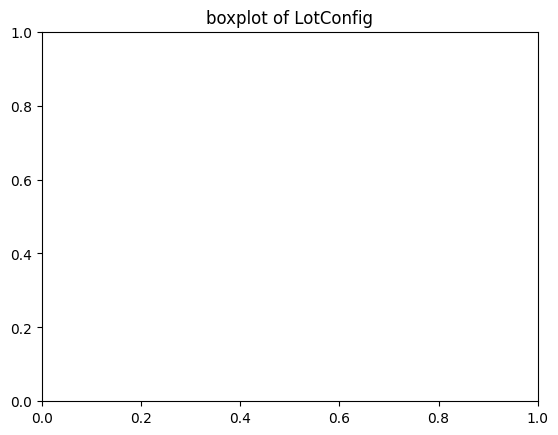

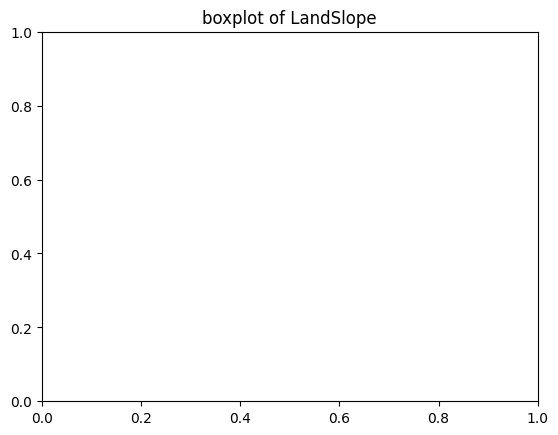

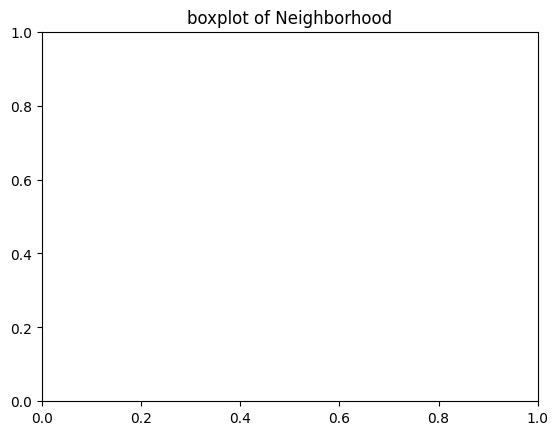

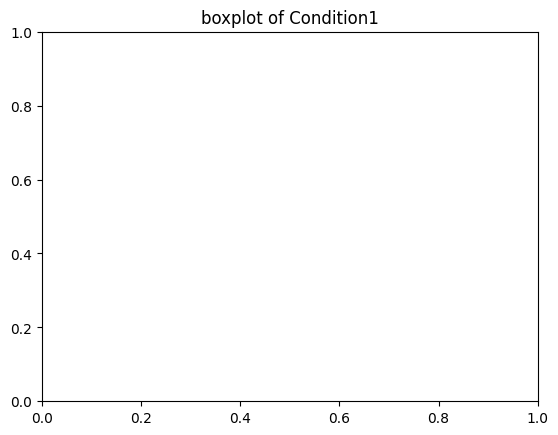

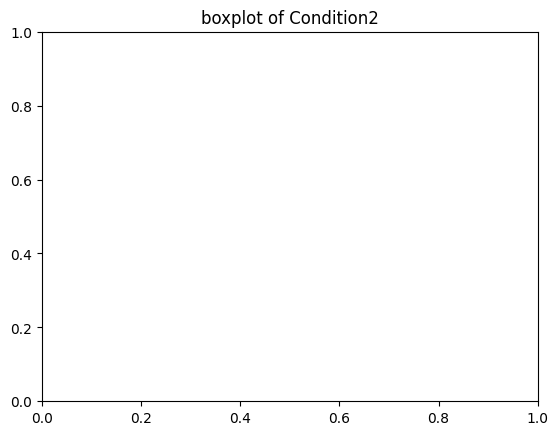

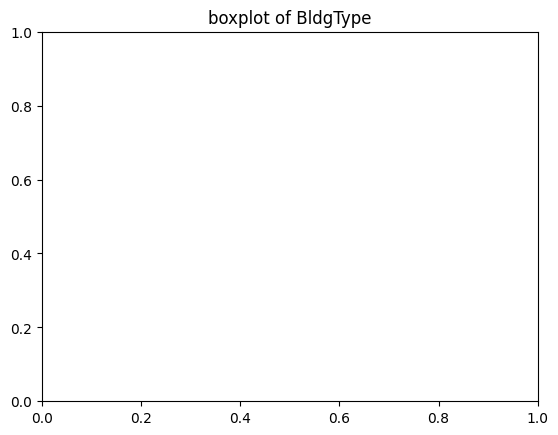

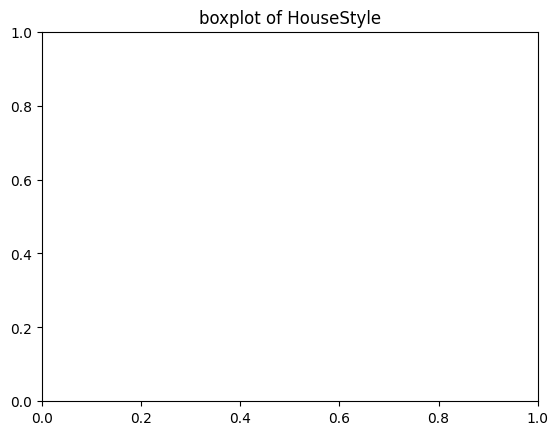

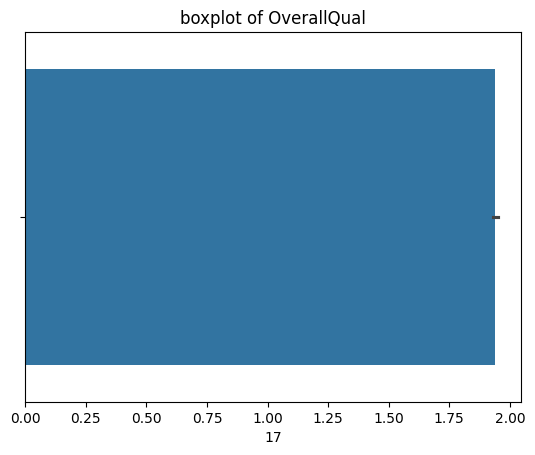

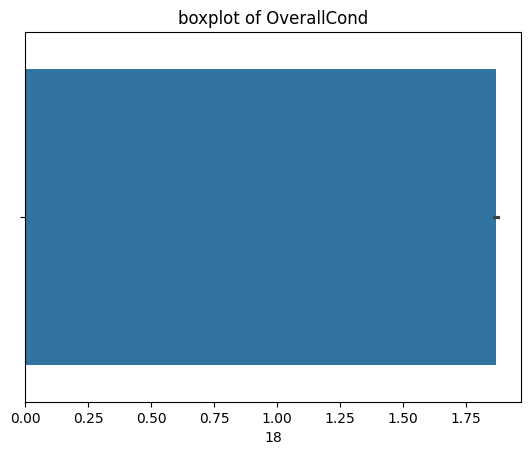

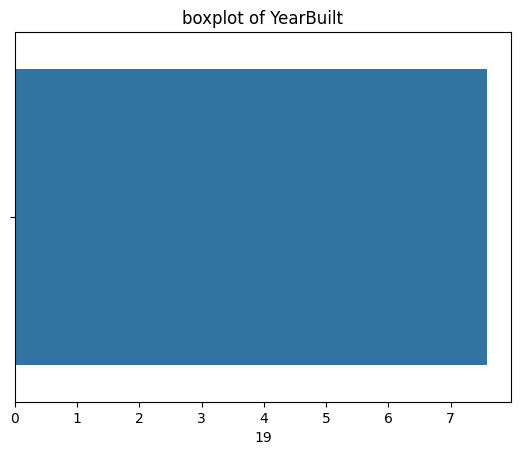

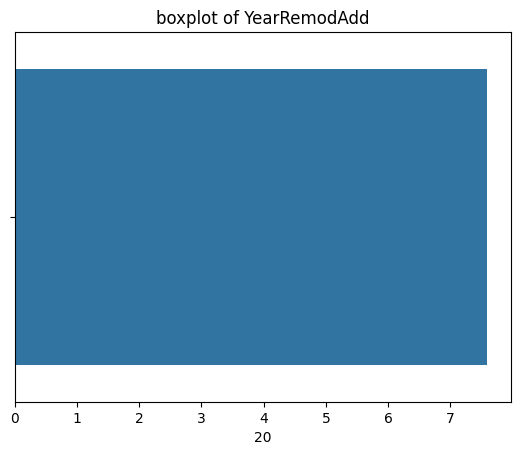

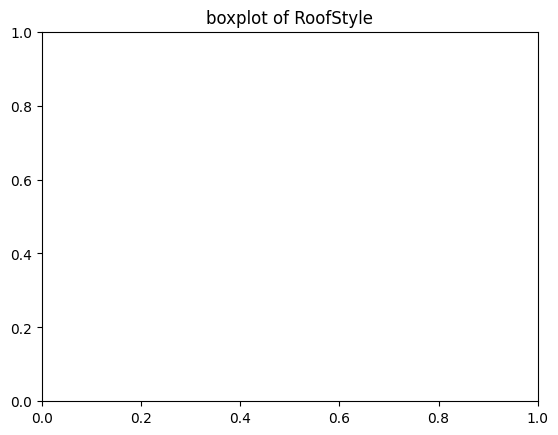

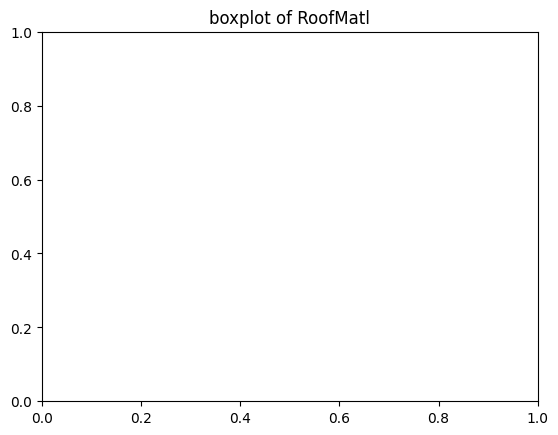

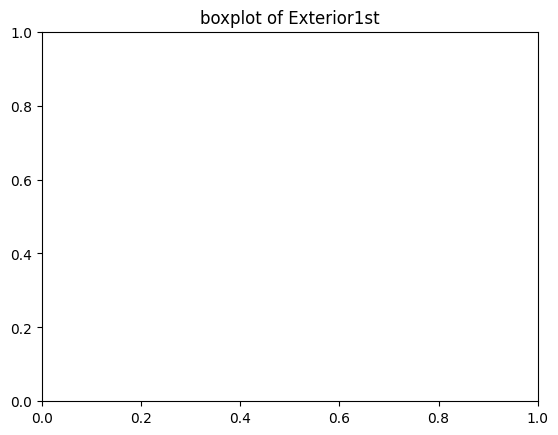

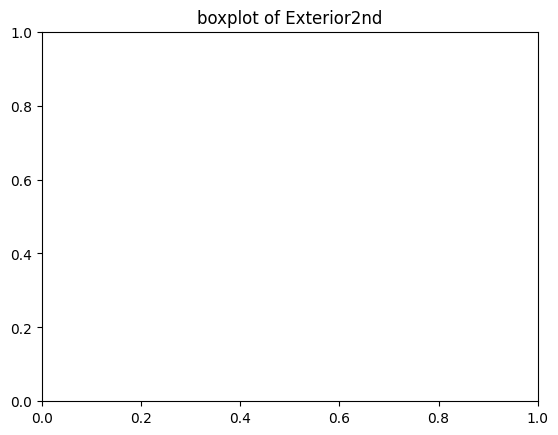

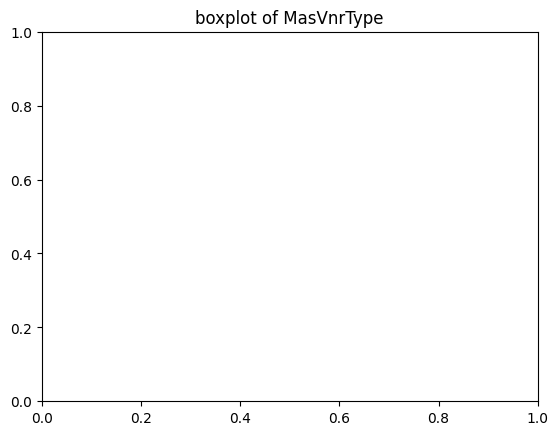

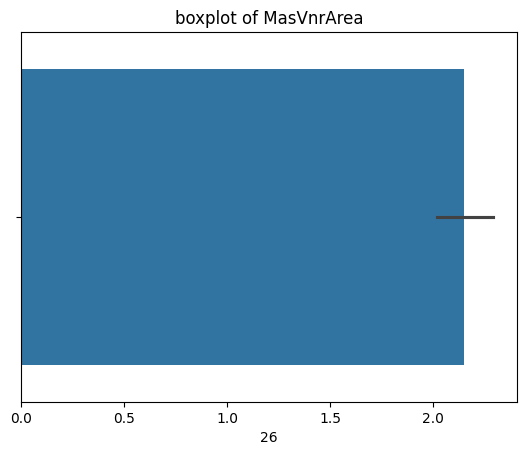

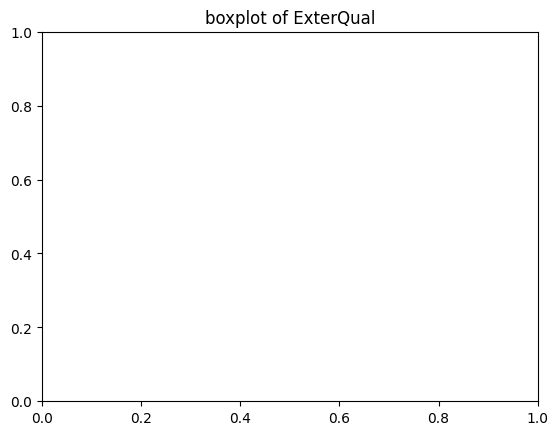

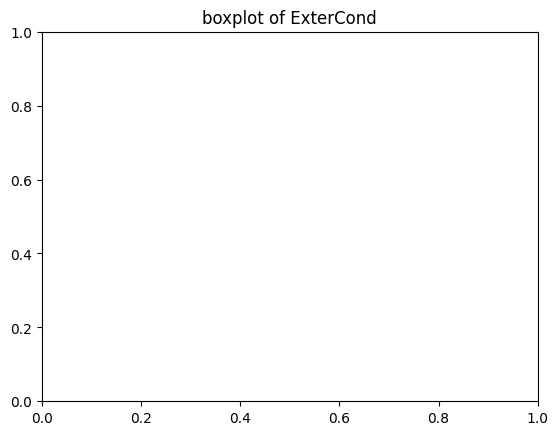

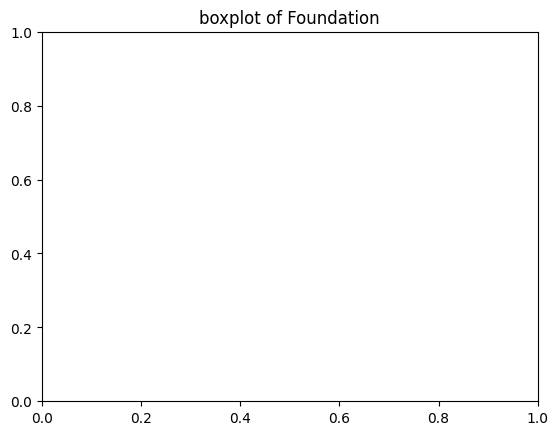

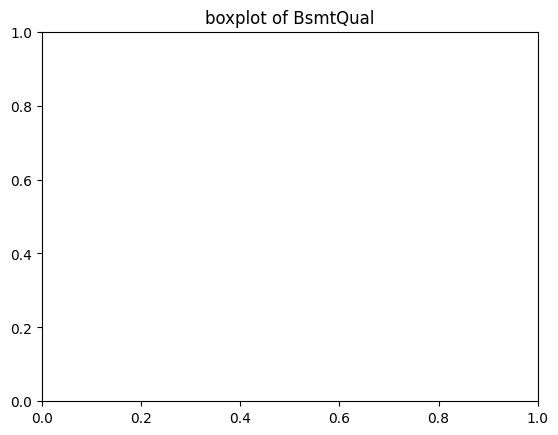

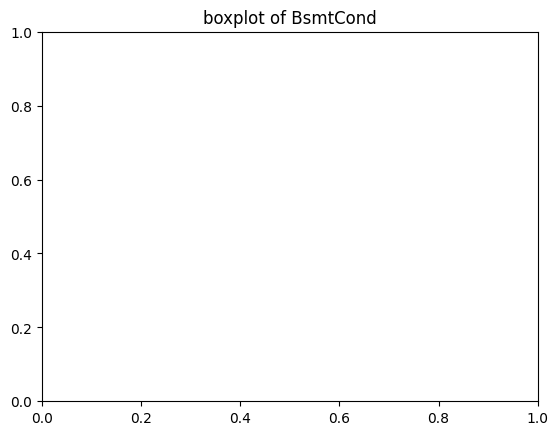

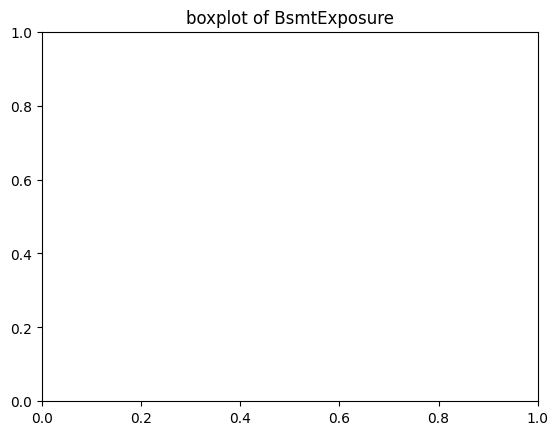

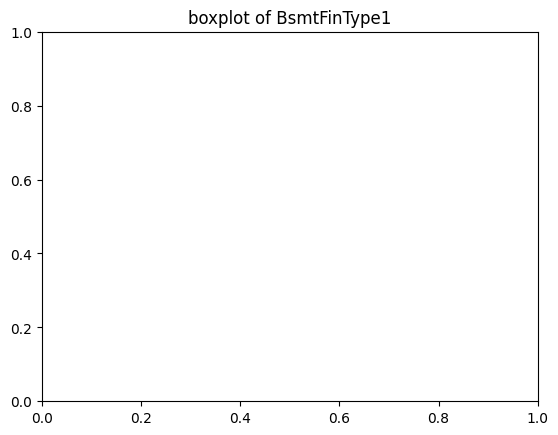

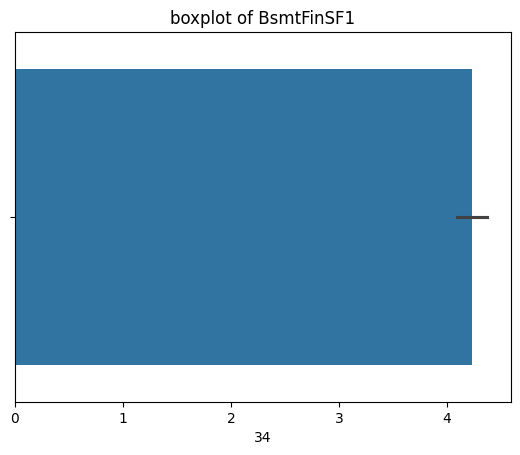

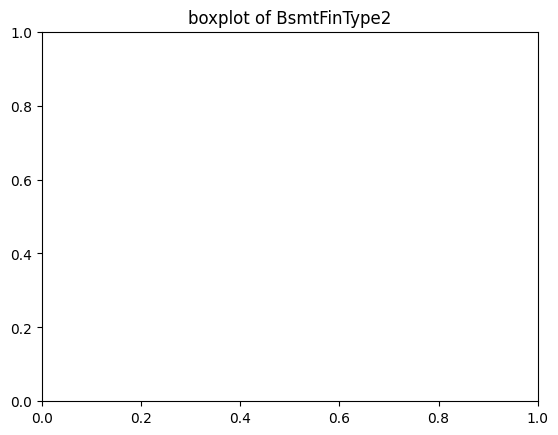

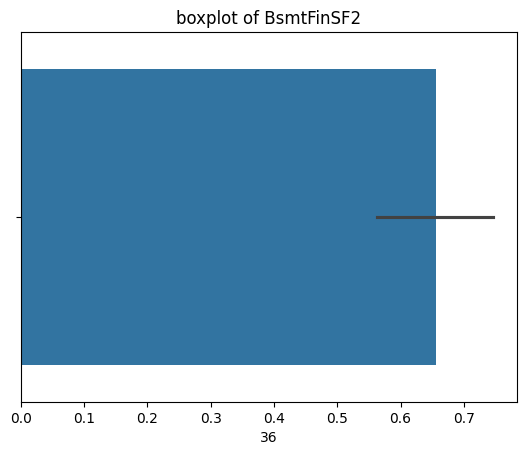

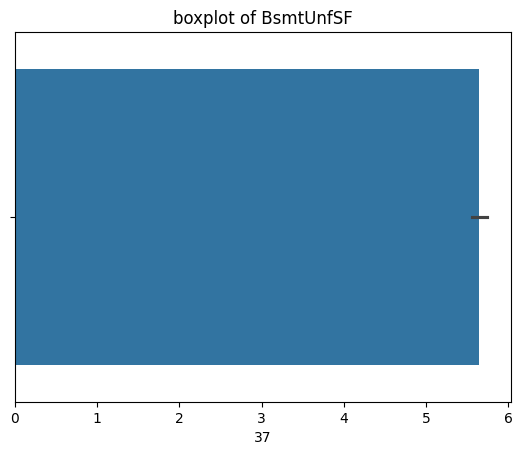

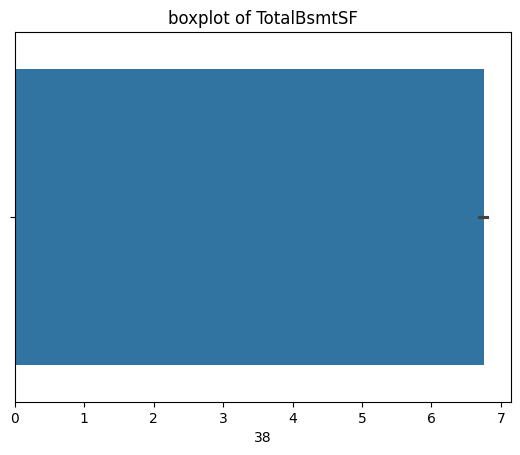

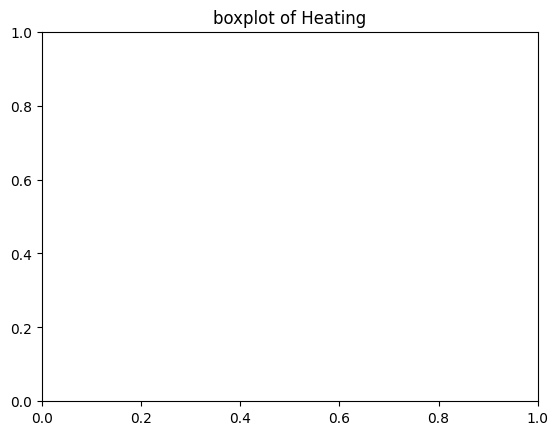

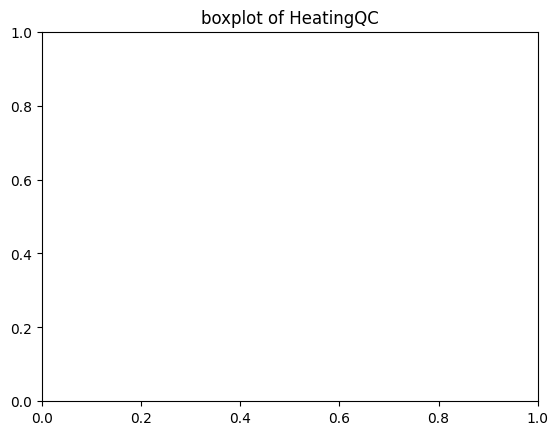

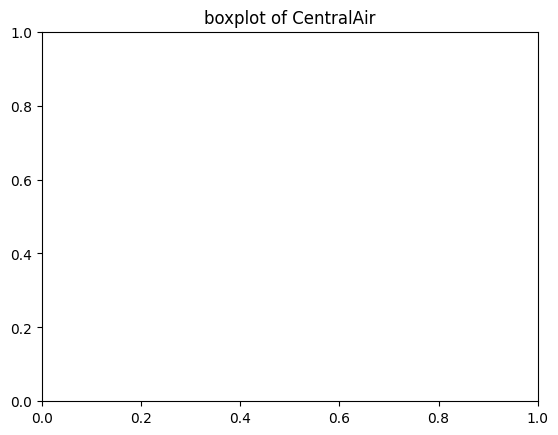

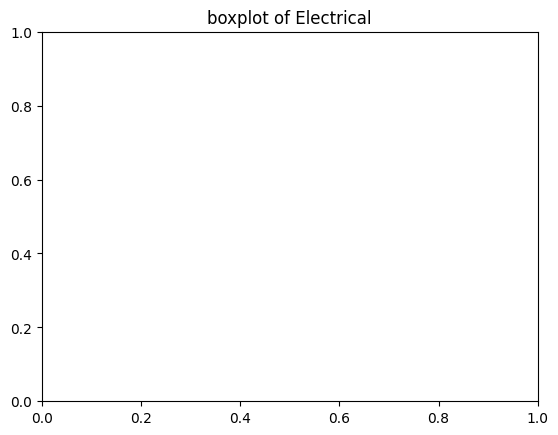

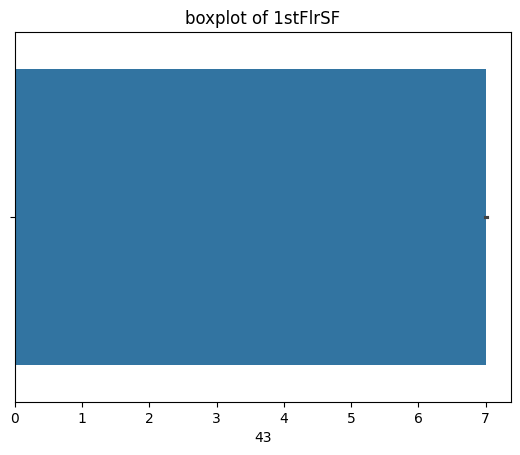

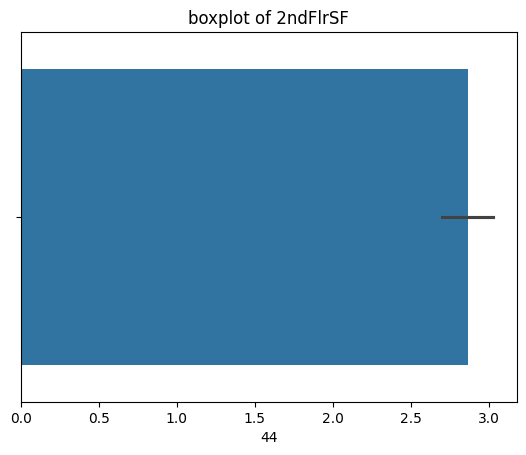

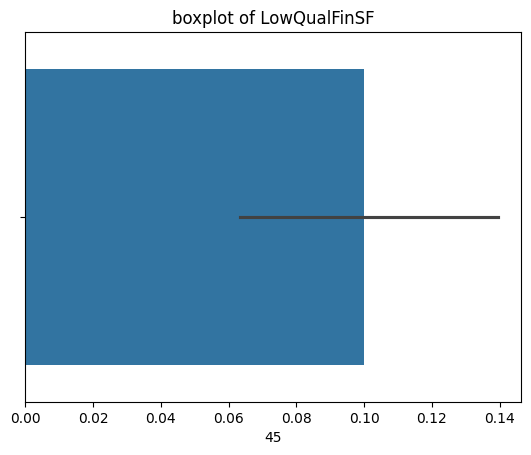

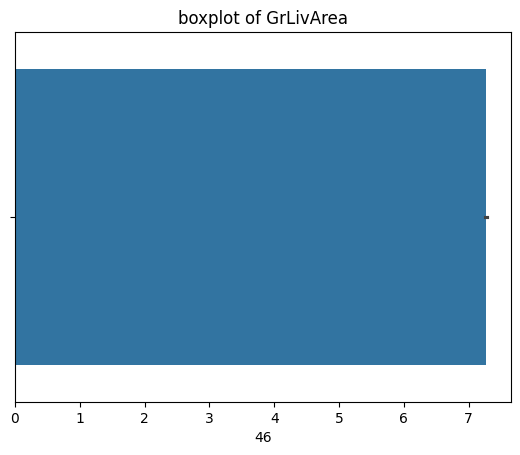

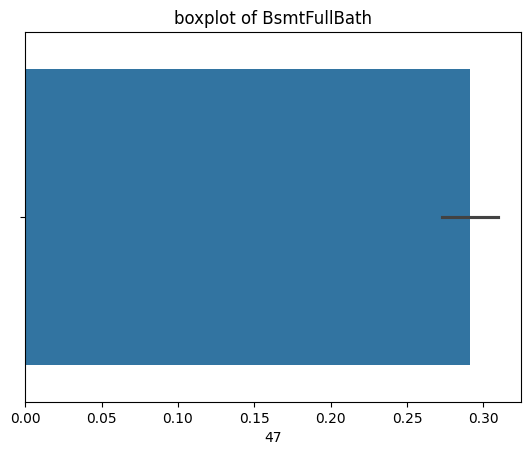

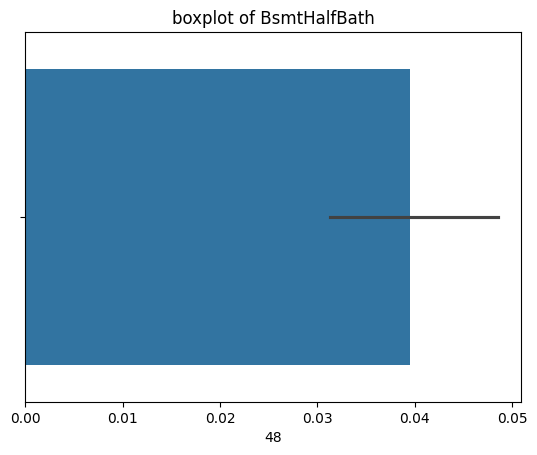

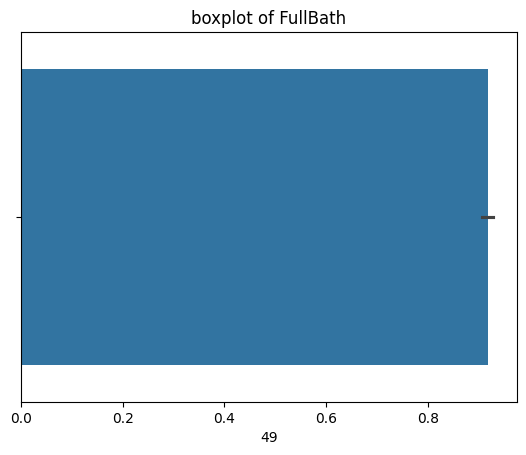

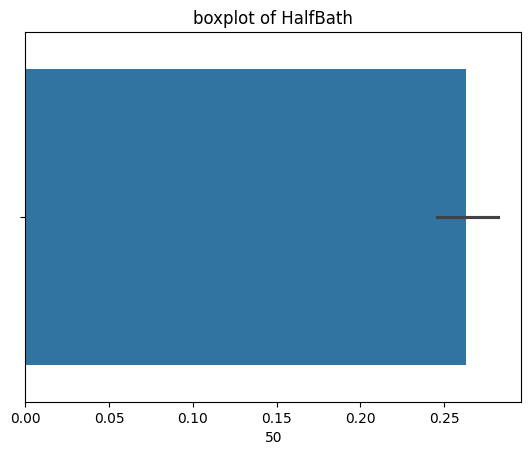

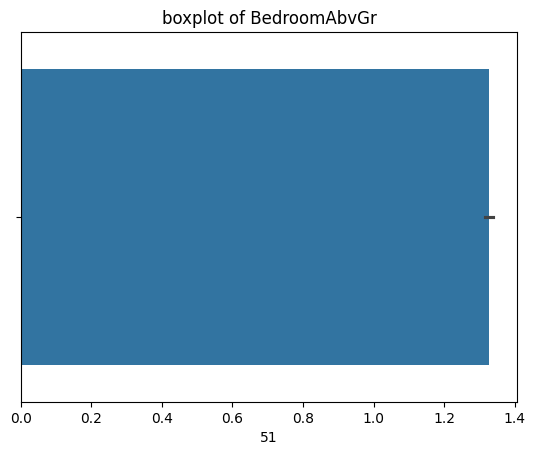

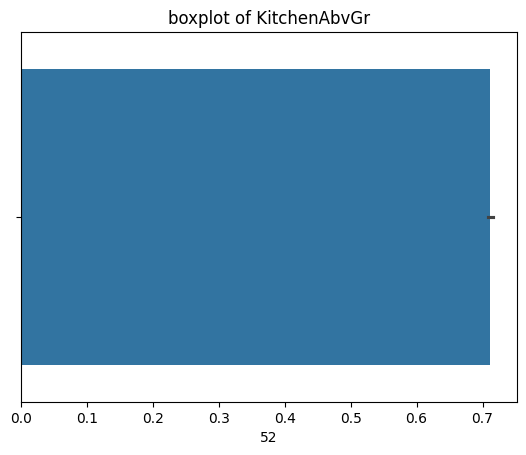

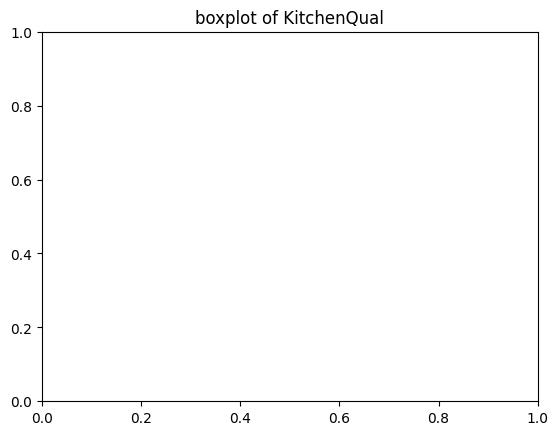

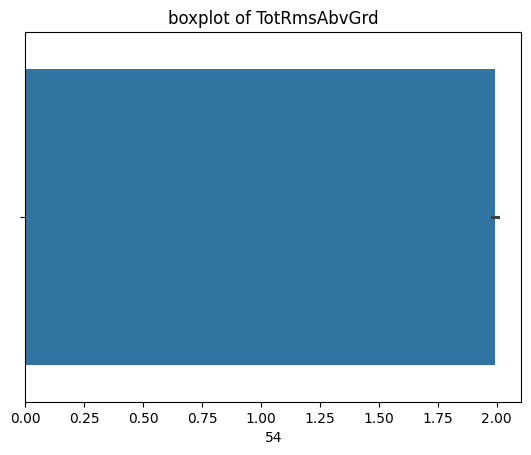

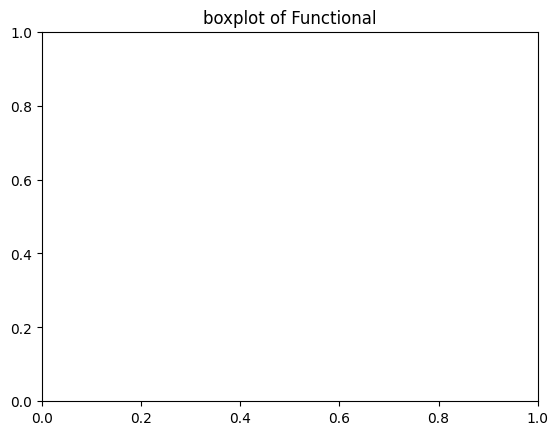

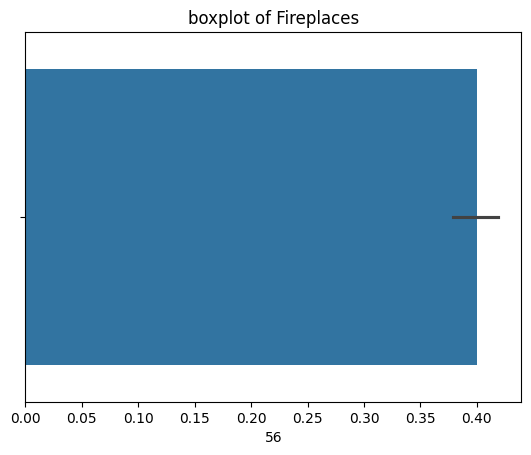

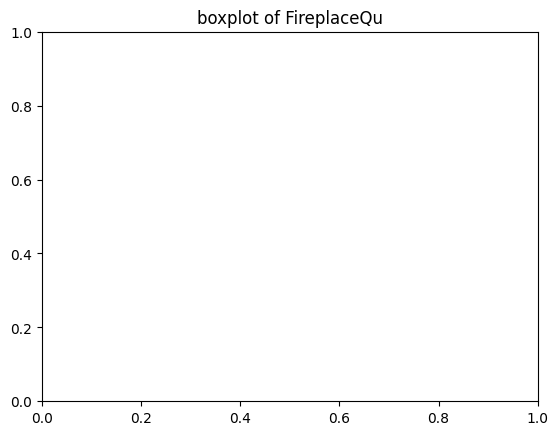

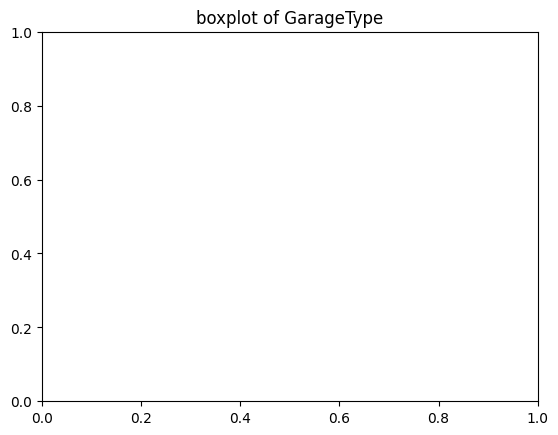

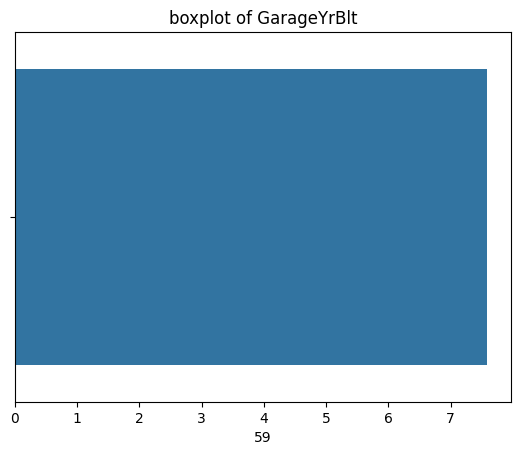

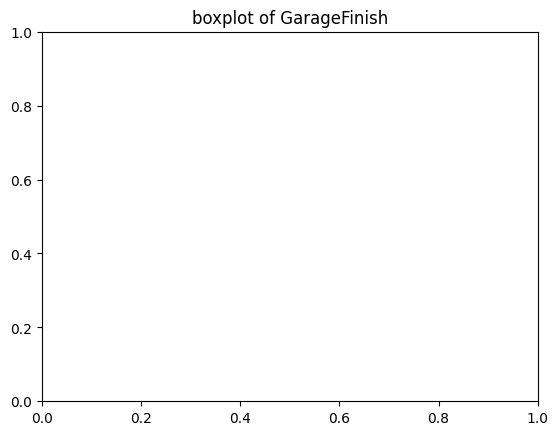

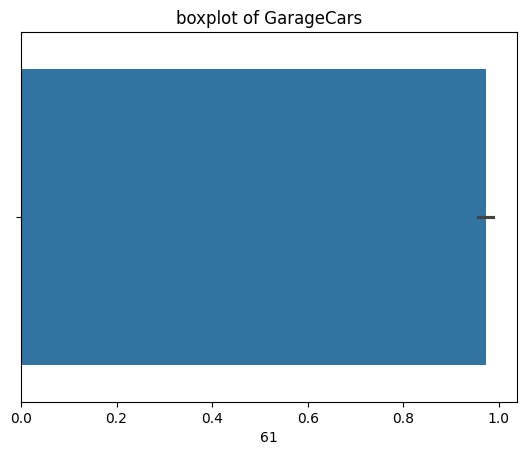

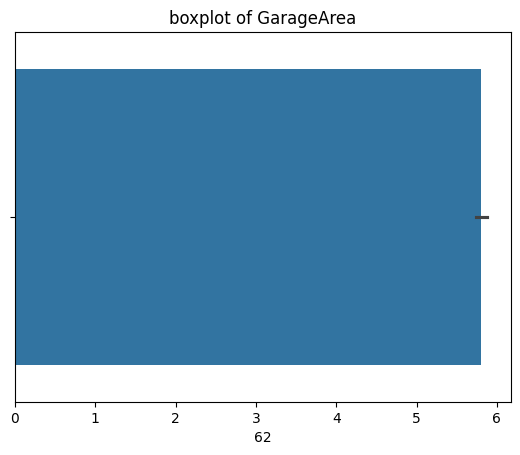

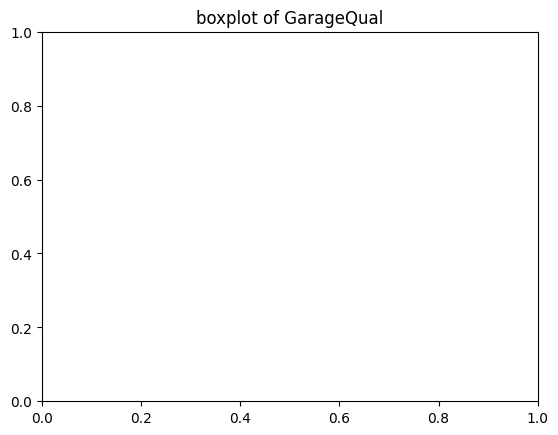

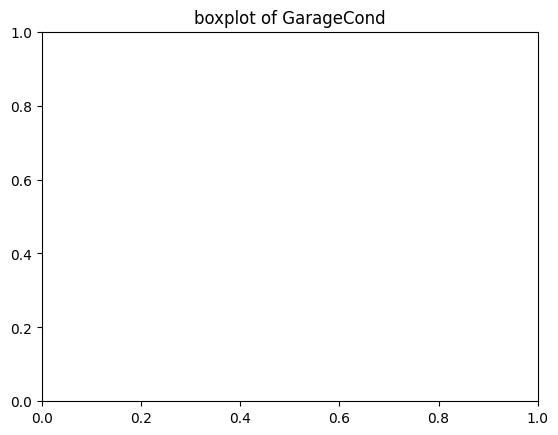

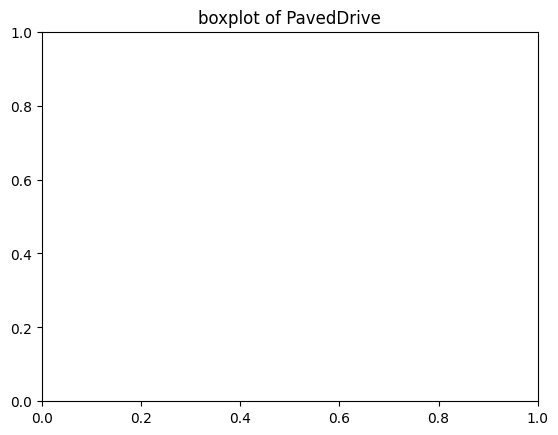

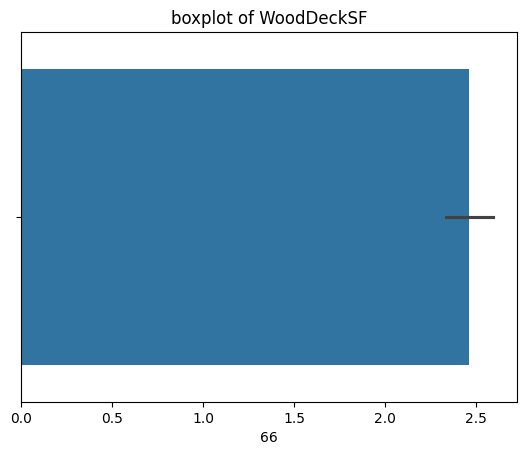

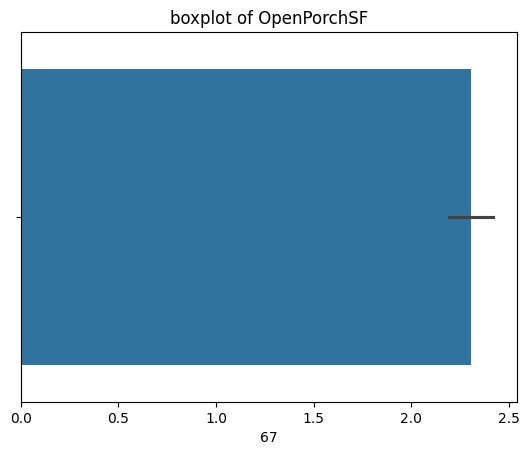

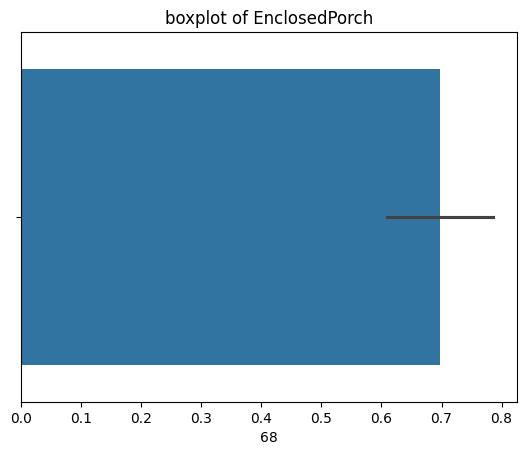

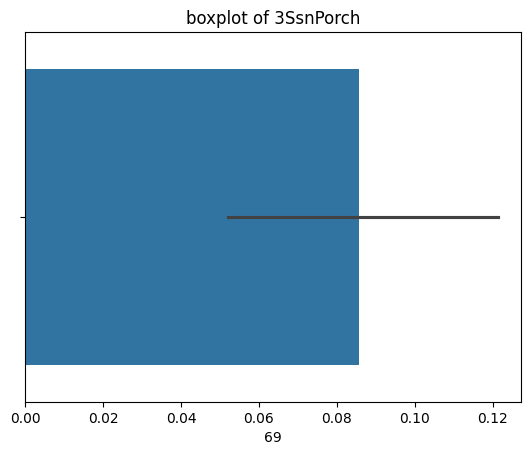

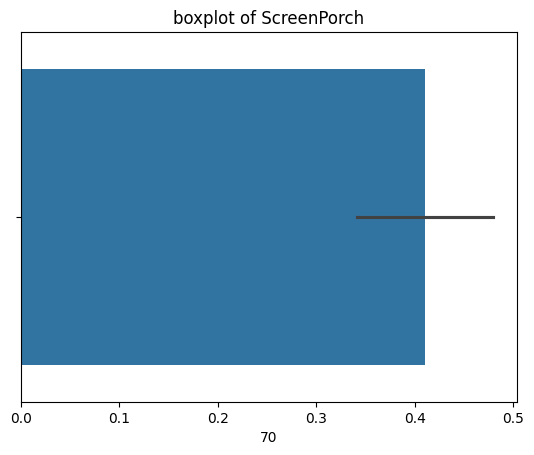

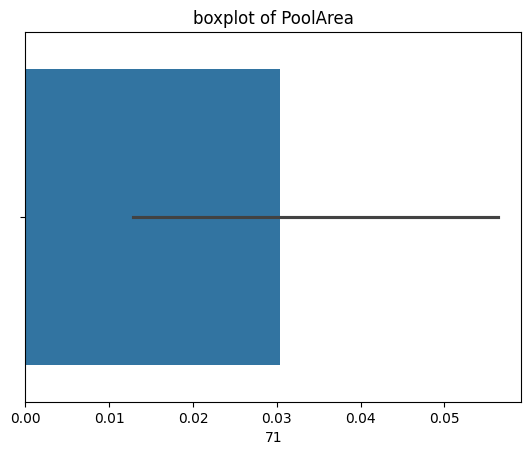

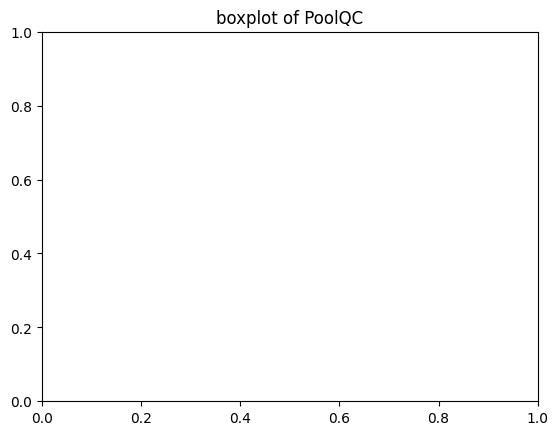

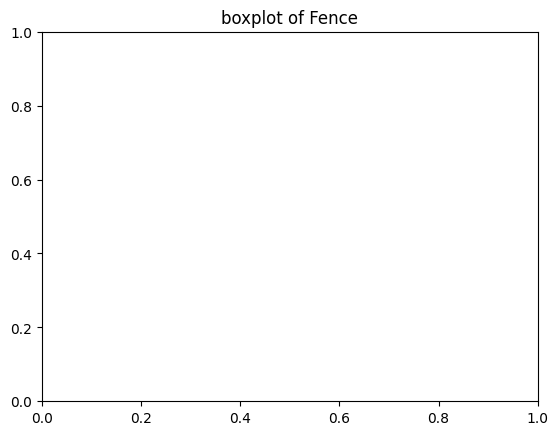

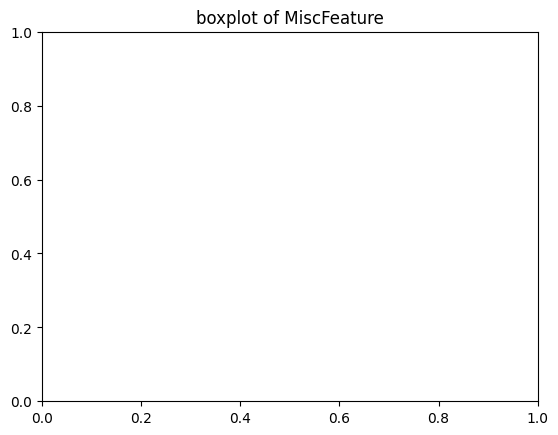

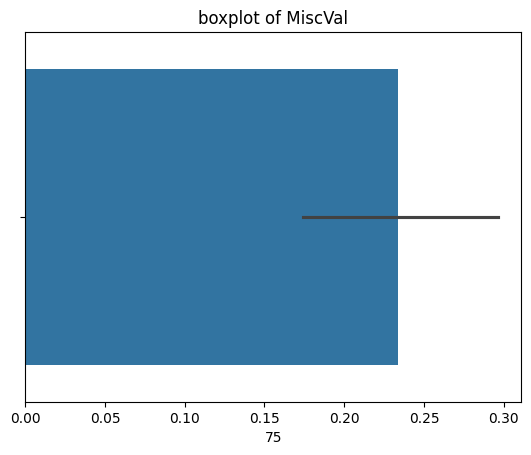

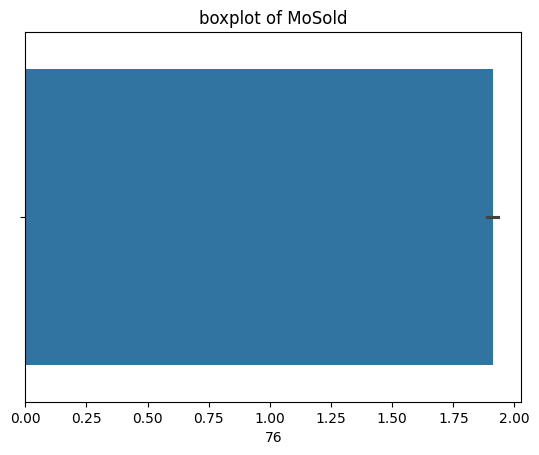

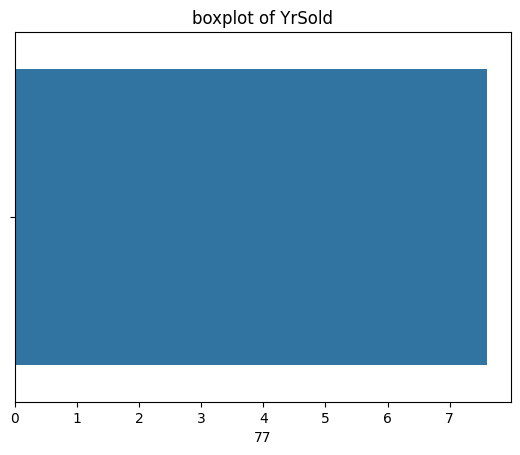

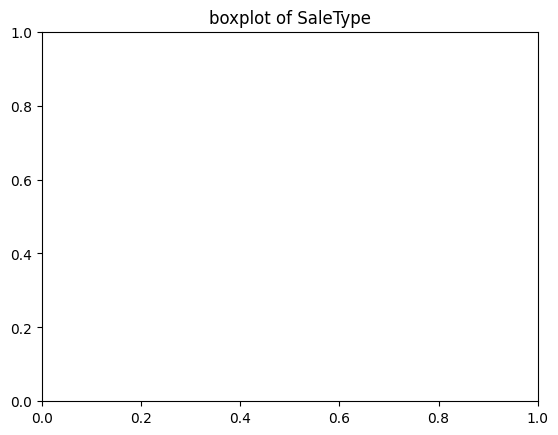

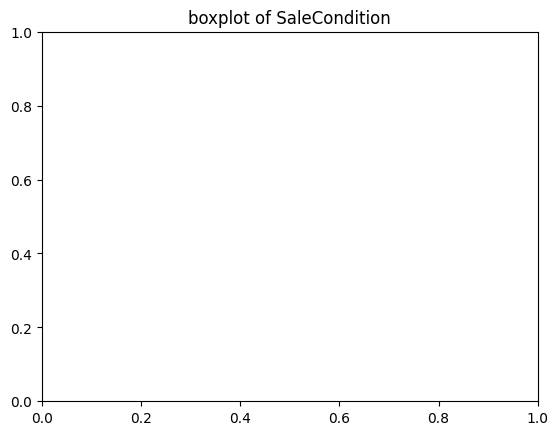

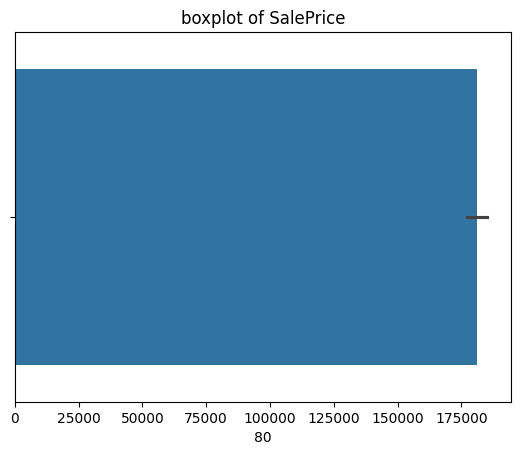

In [19]:
display_boxplot(train_log_transformed)

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


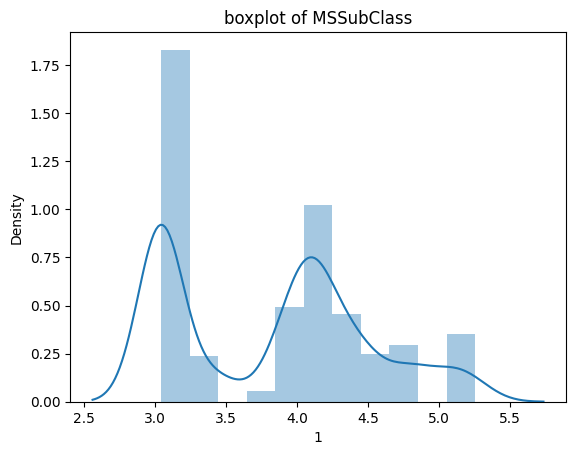

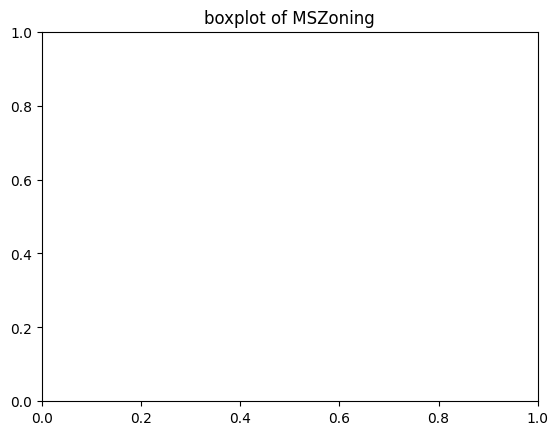

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


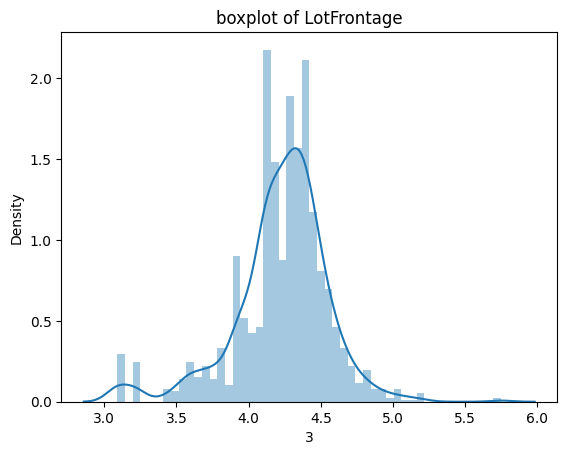

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


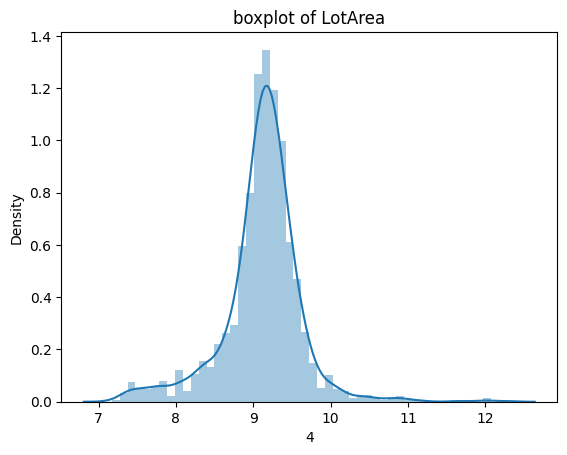

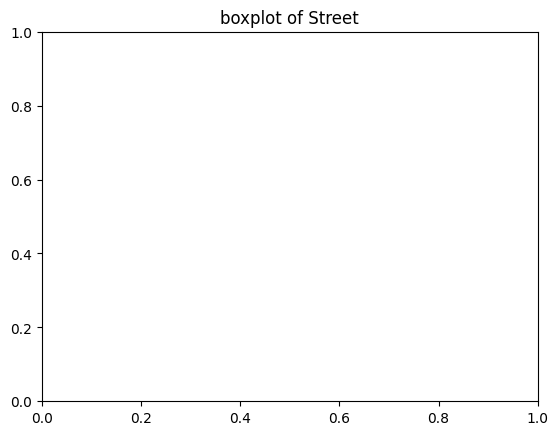

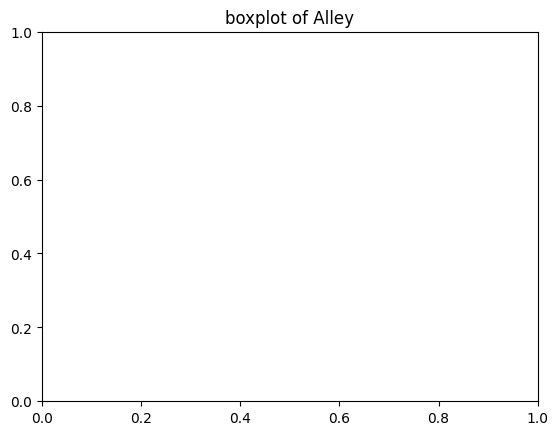

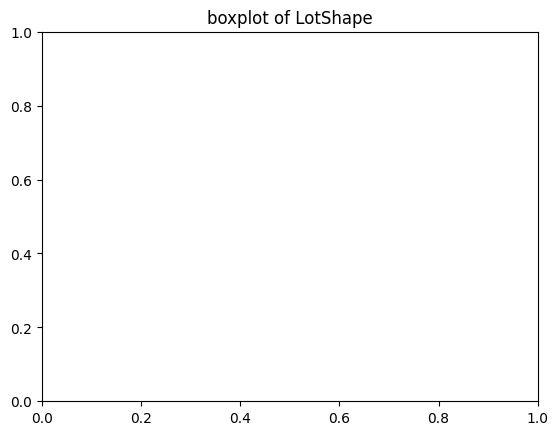

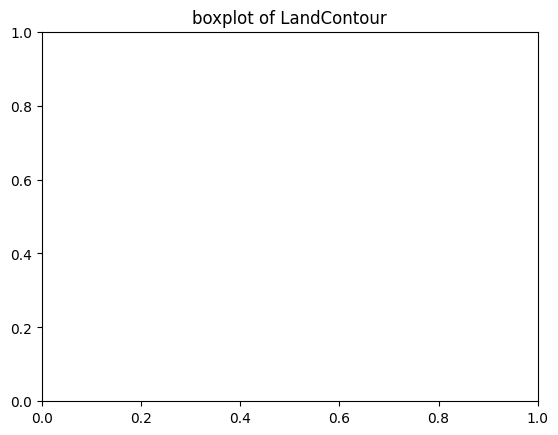

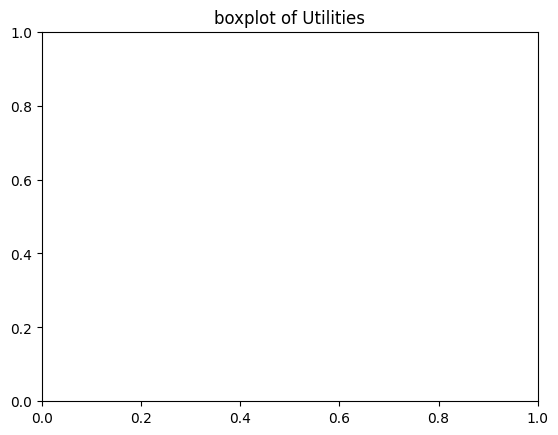

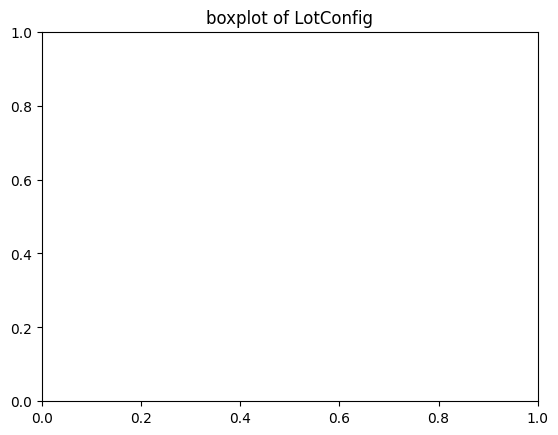

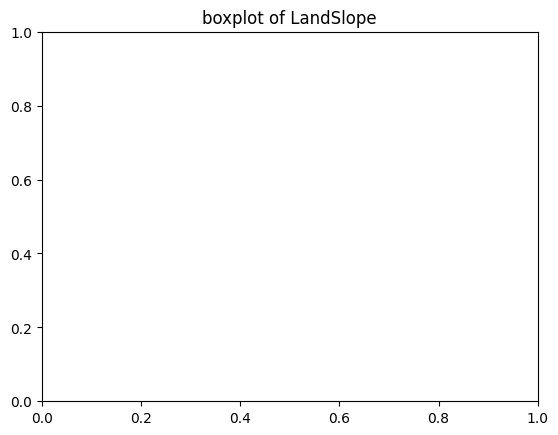

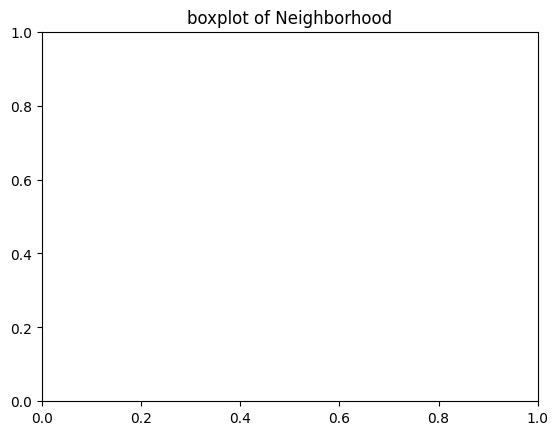

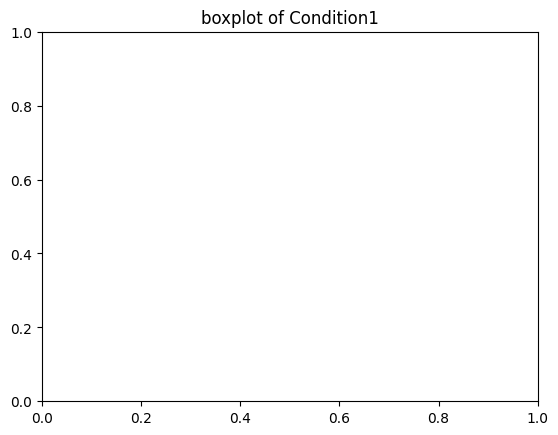

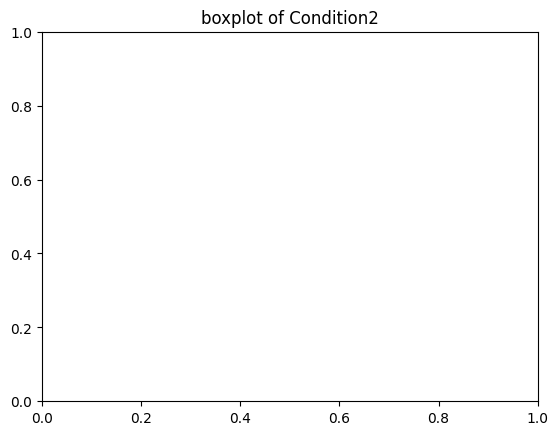

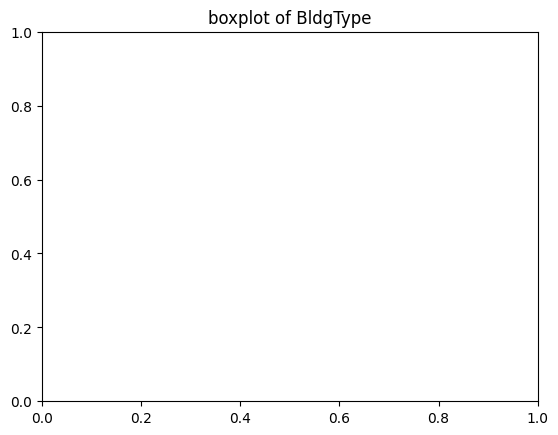

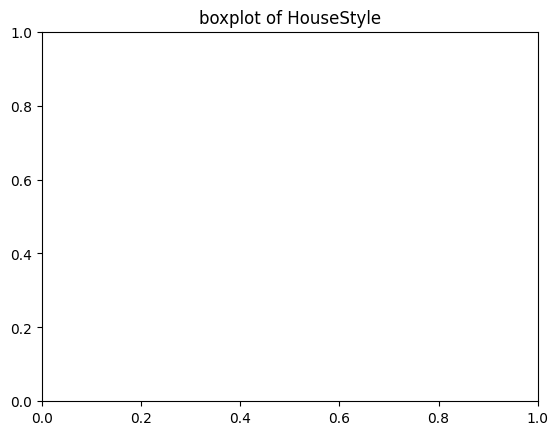

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


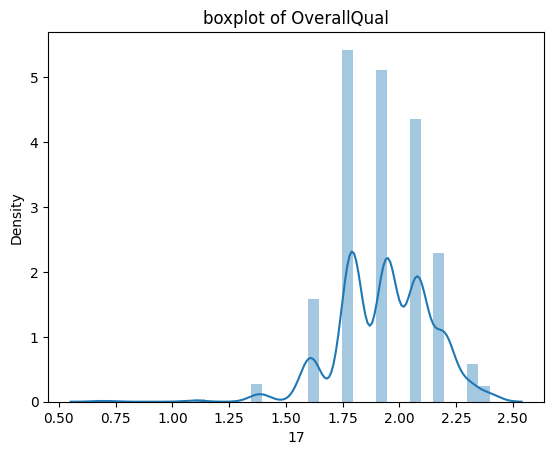

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


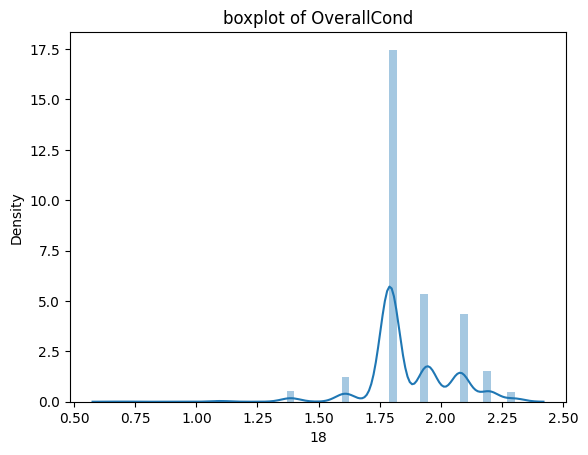

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


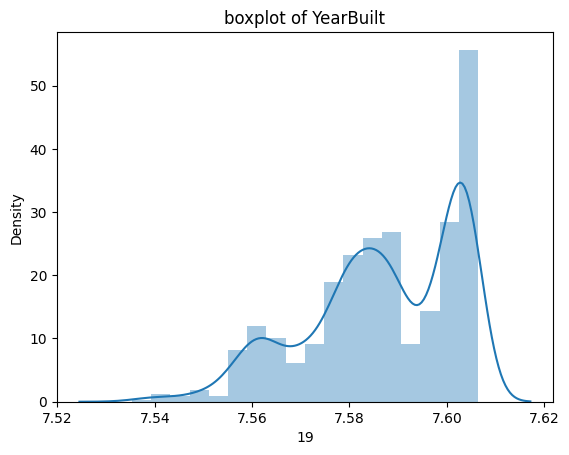

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


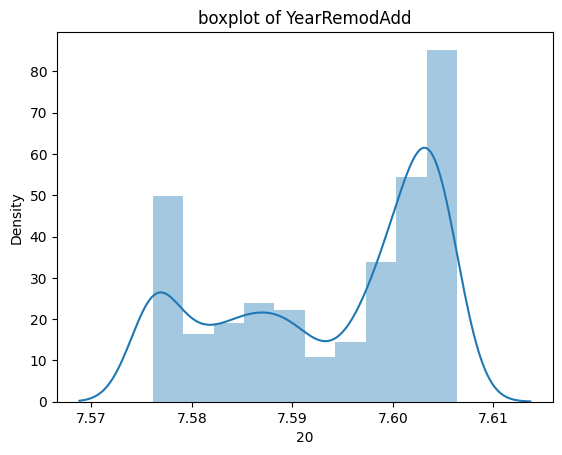

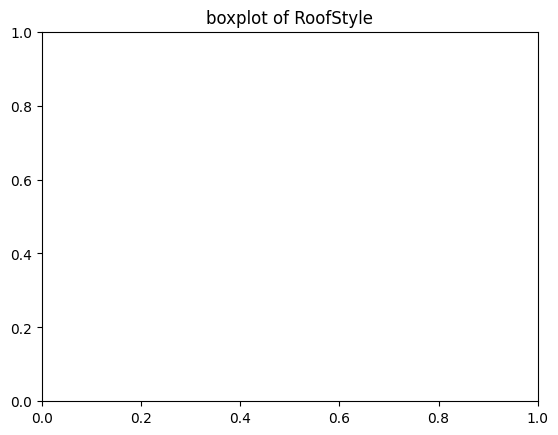

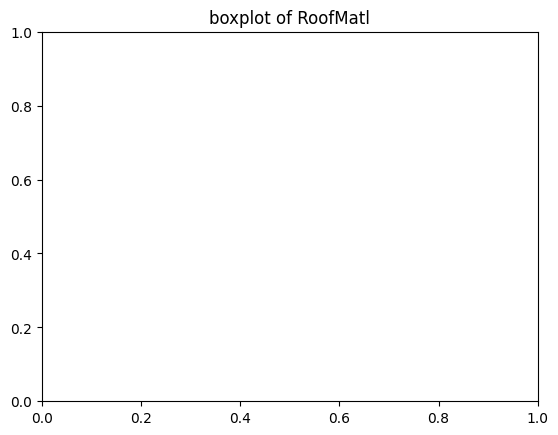

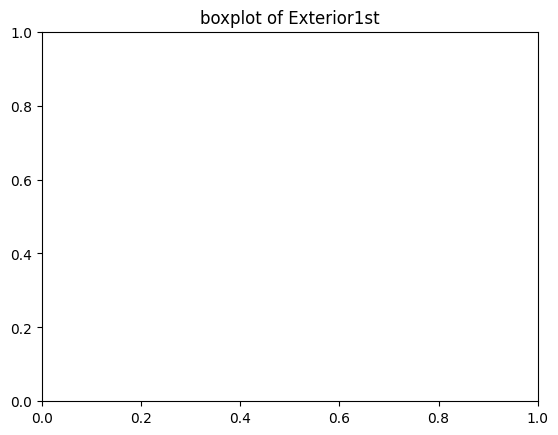

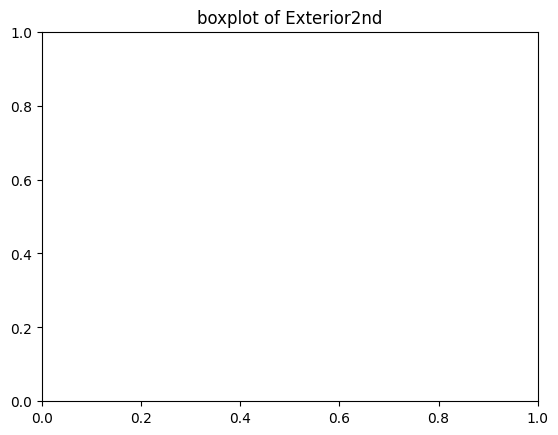

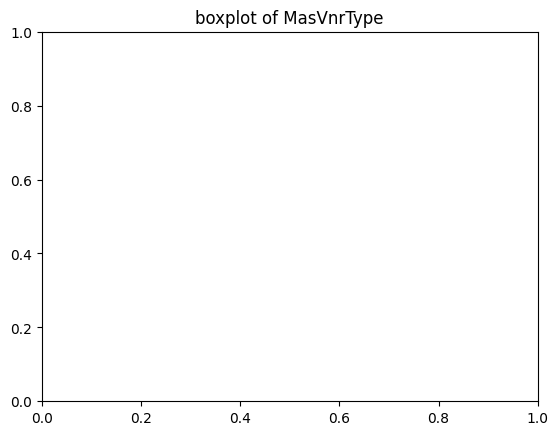

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


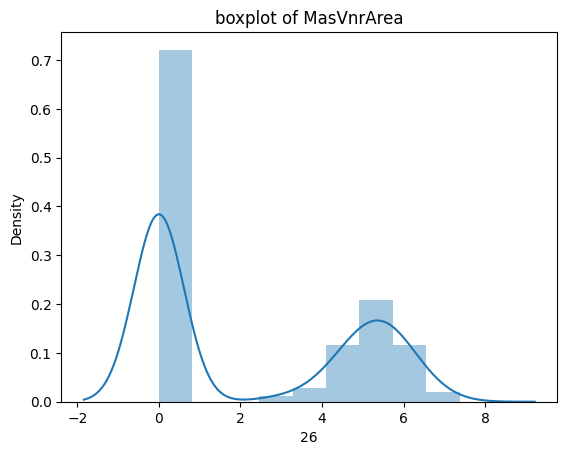

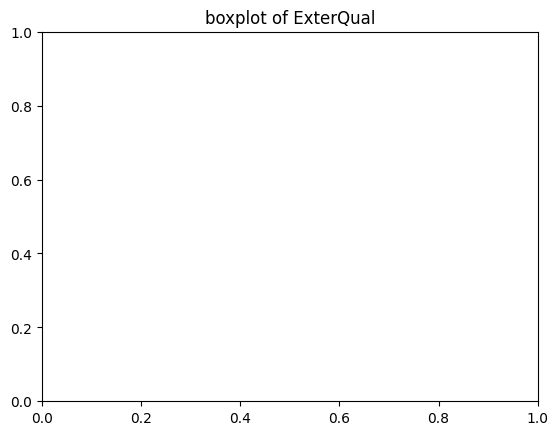

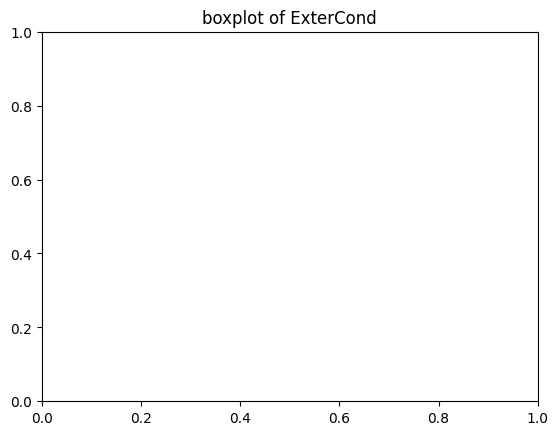

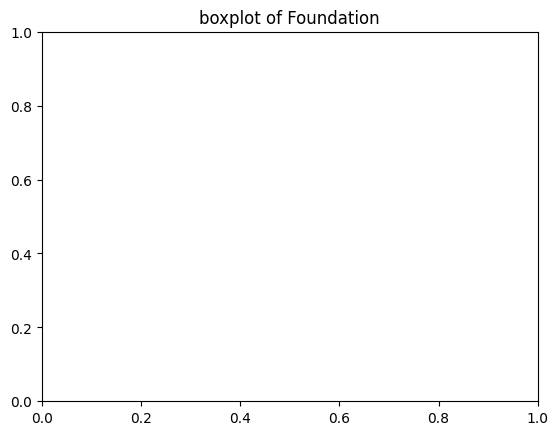

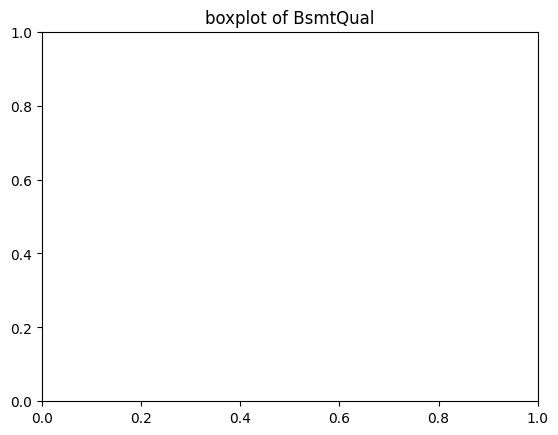

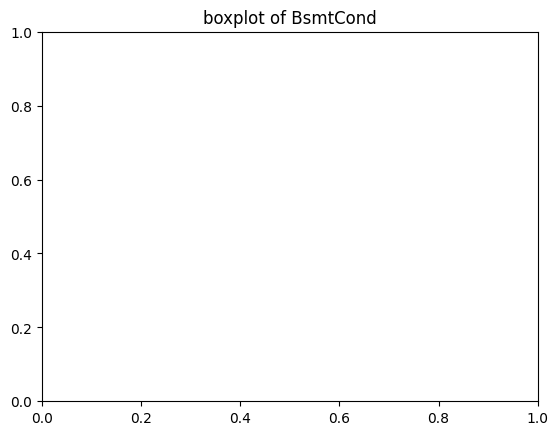

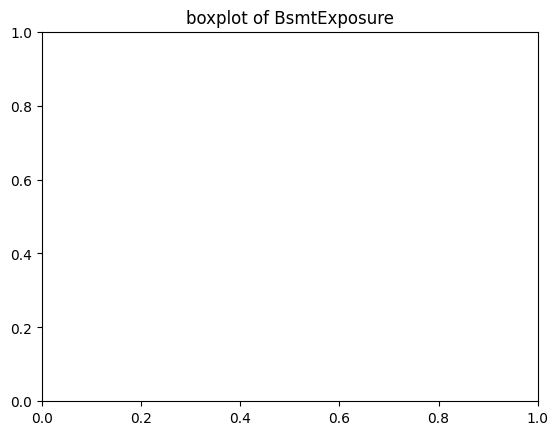

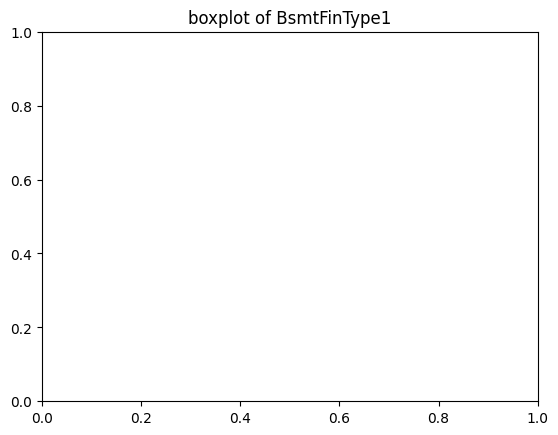

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


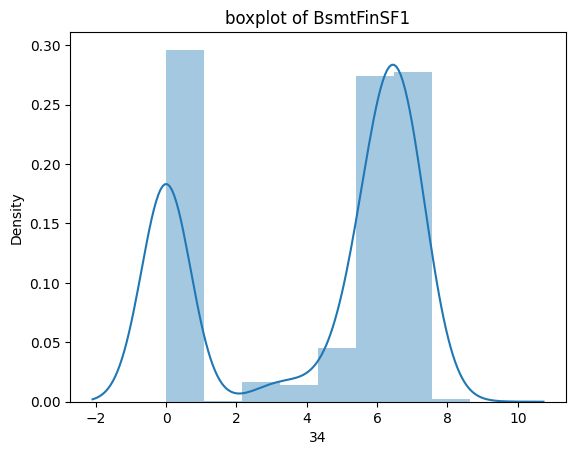

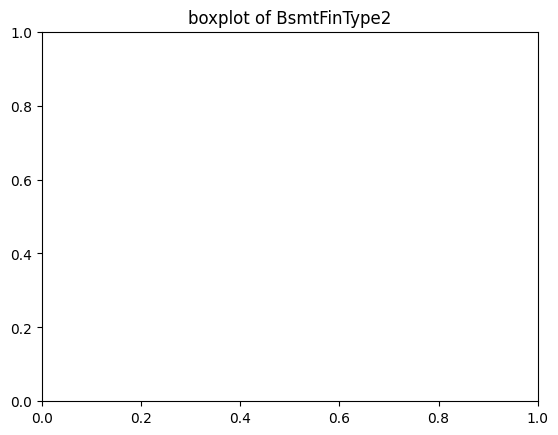

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


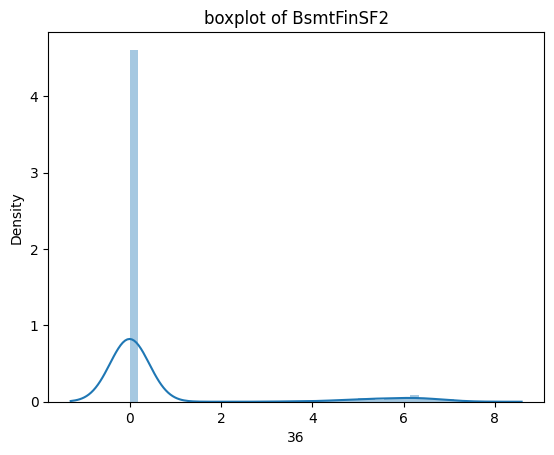

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


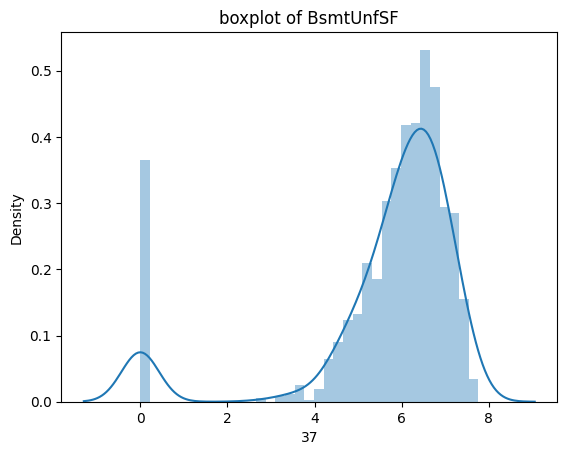

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


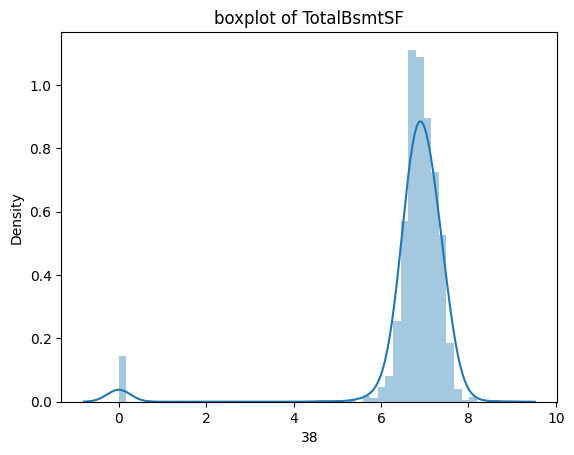

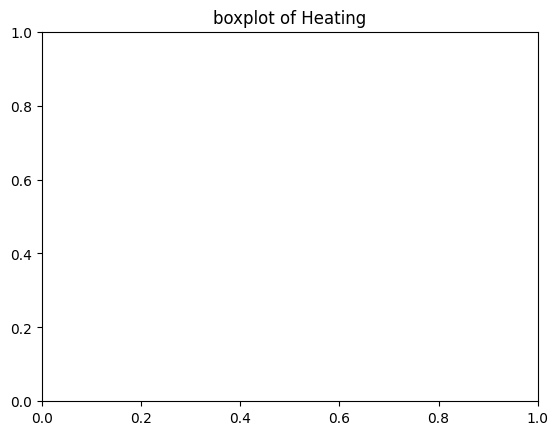

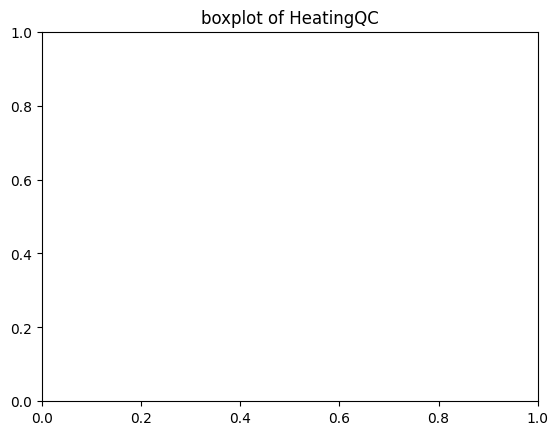

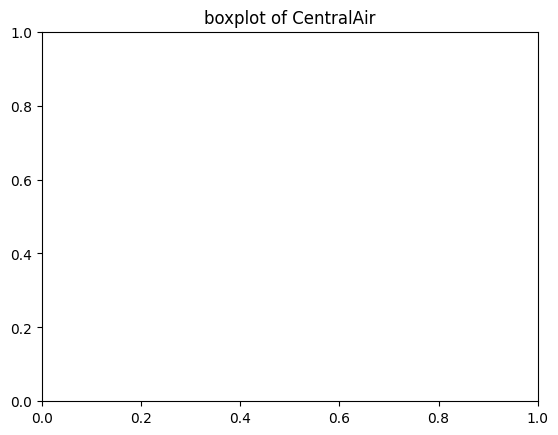

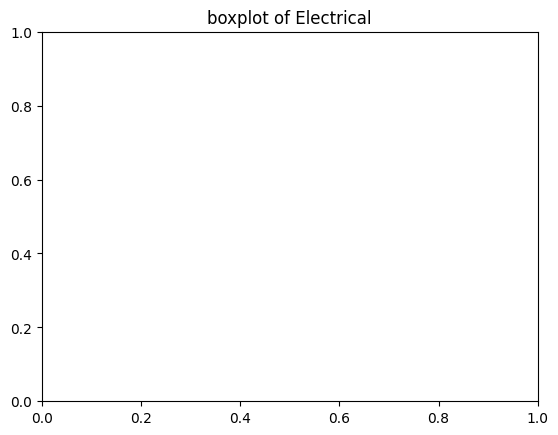

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


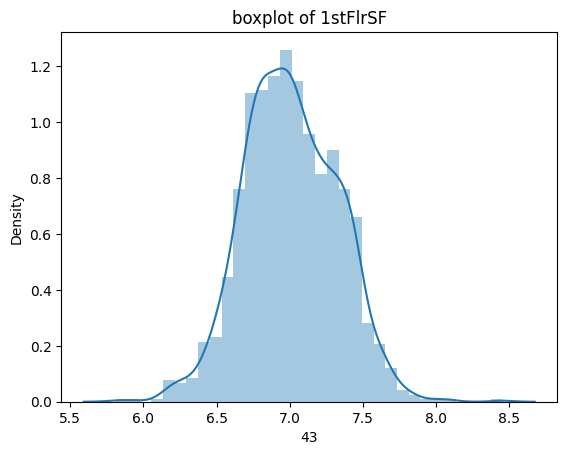

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


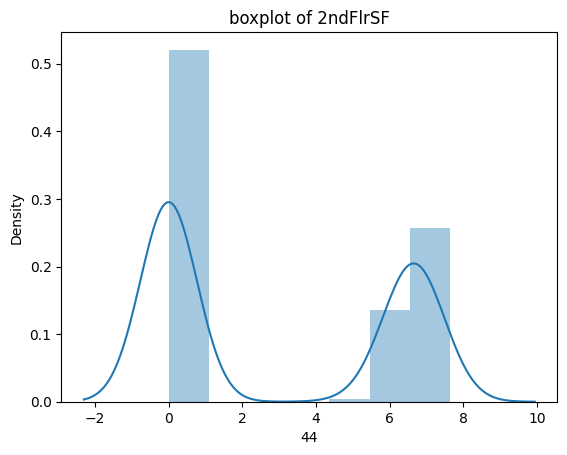

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


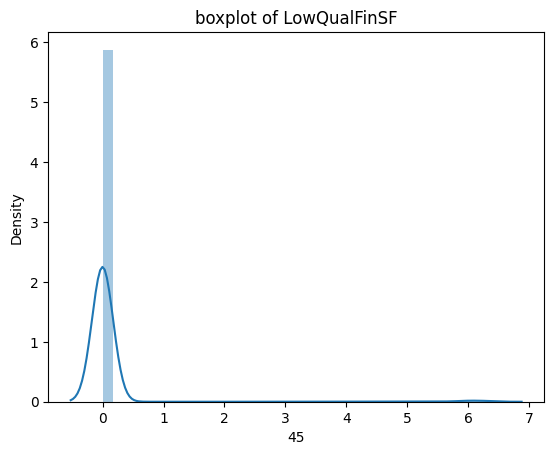

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


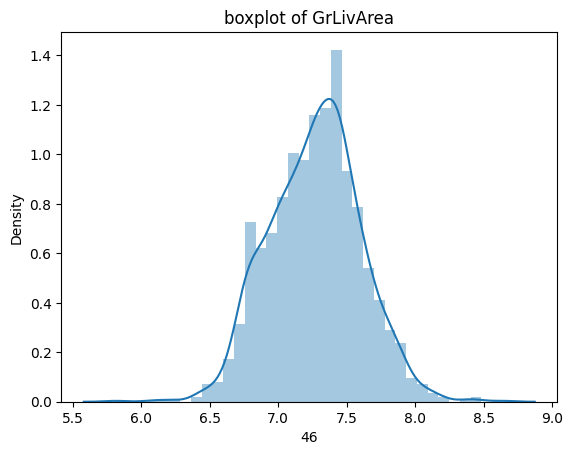

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


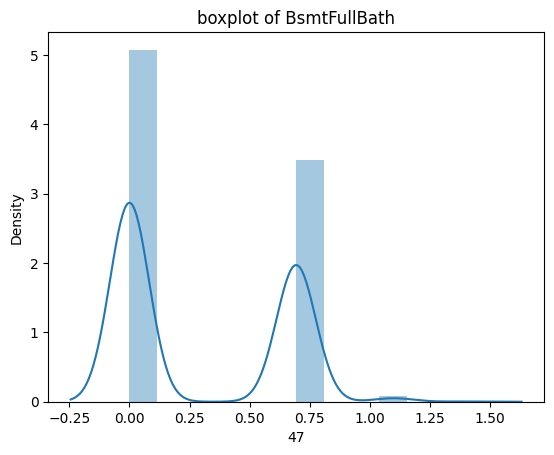

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


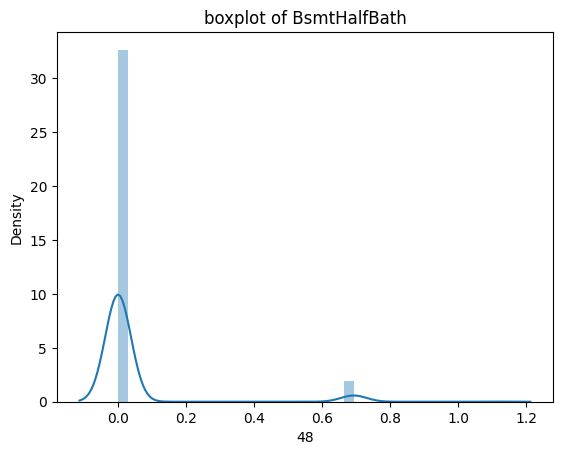

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


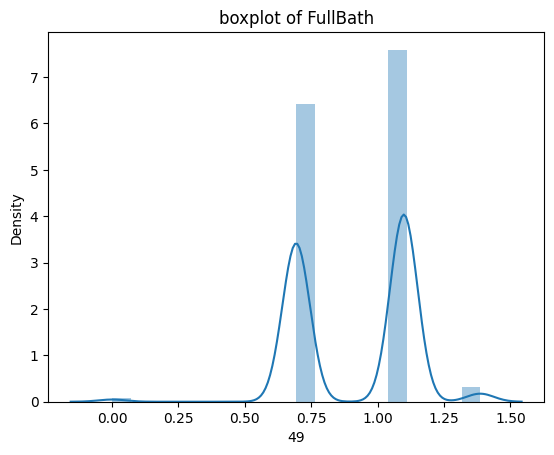

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


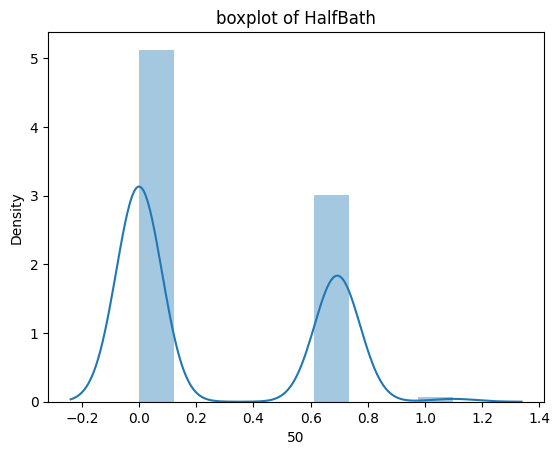

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


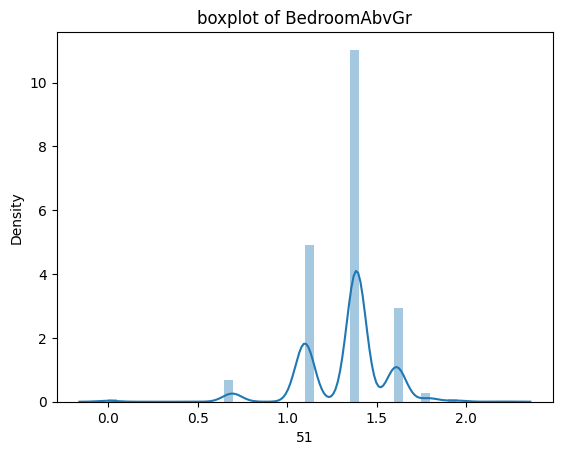

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


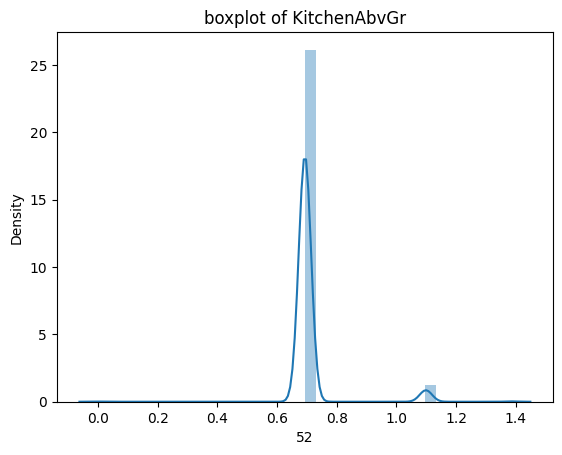

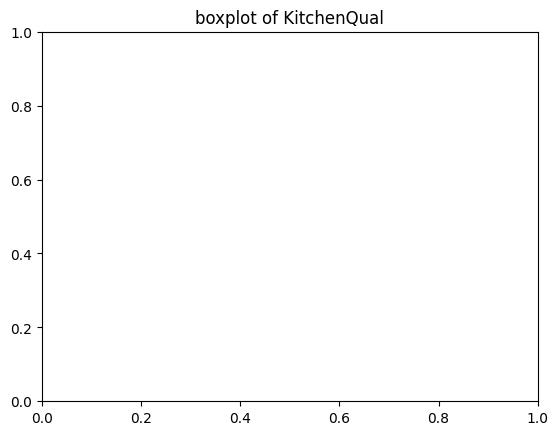

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


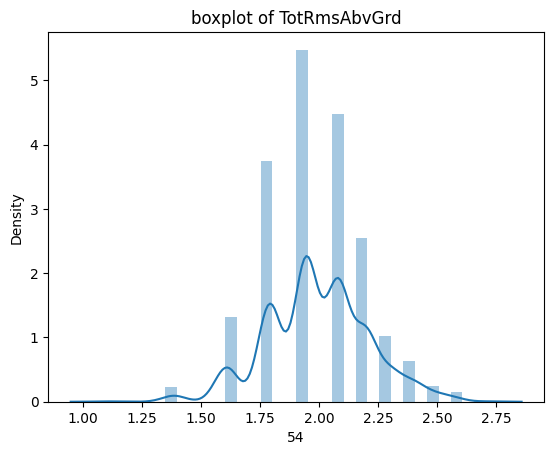

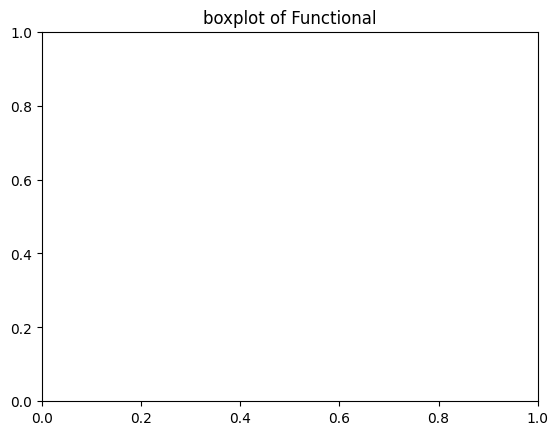

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


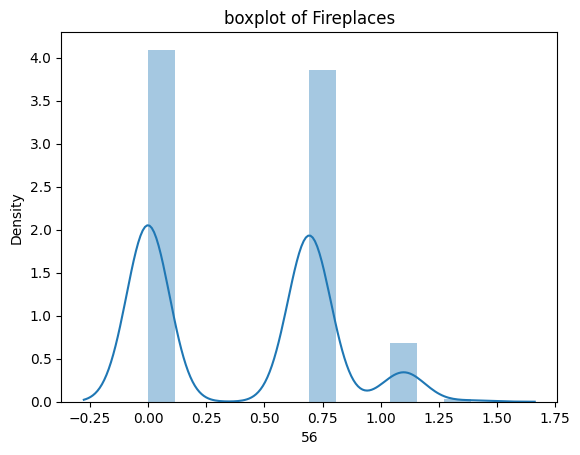

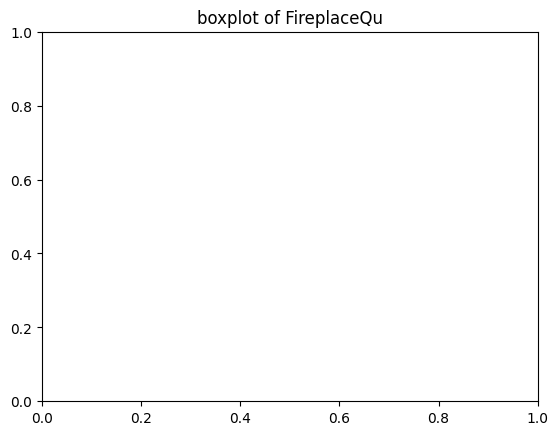

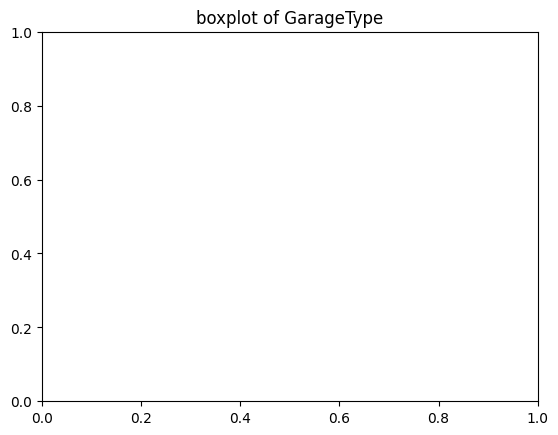

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


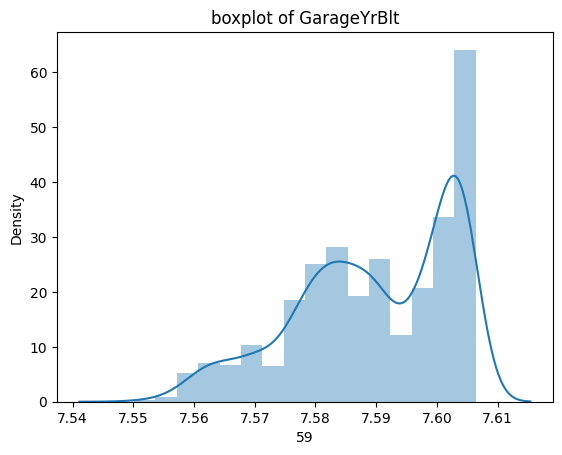

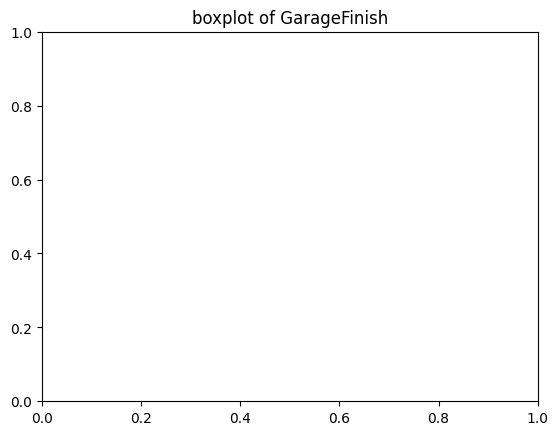

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


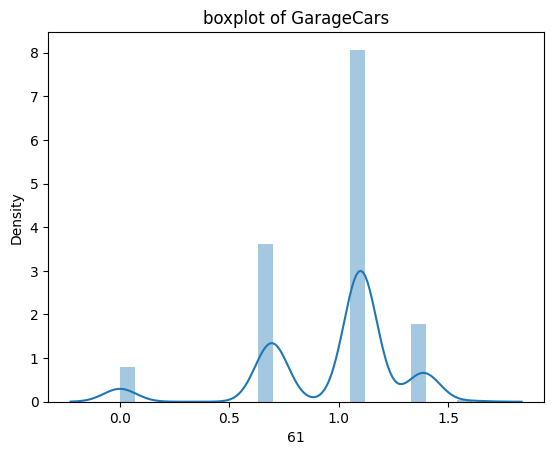

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


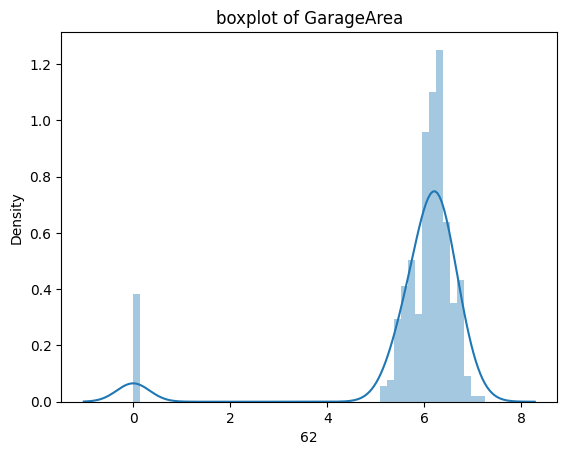

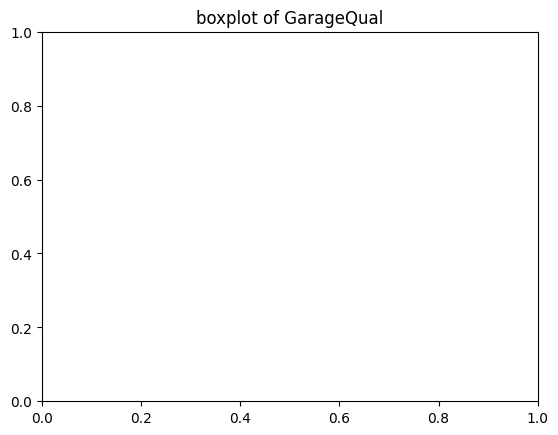

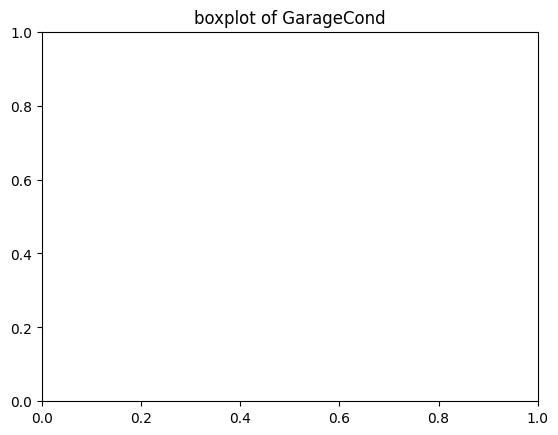

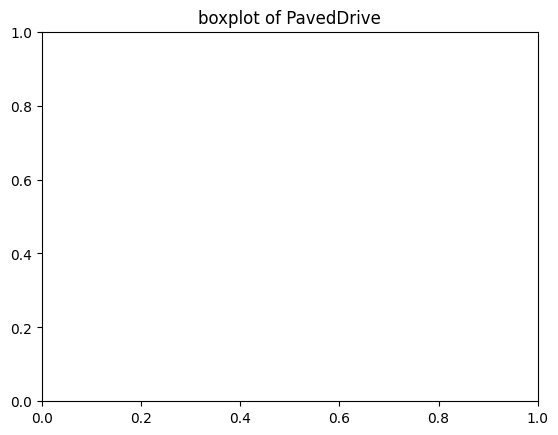

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


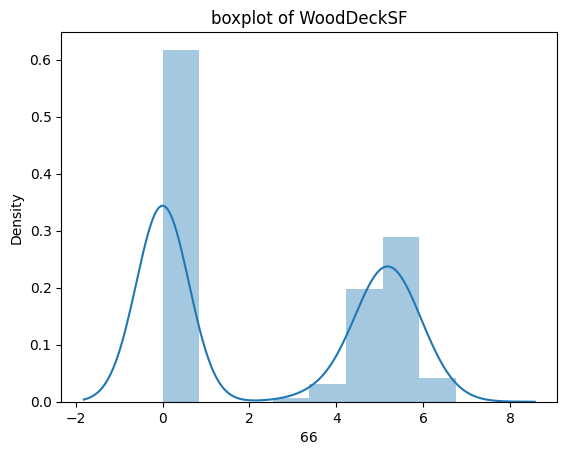

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


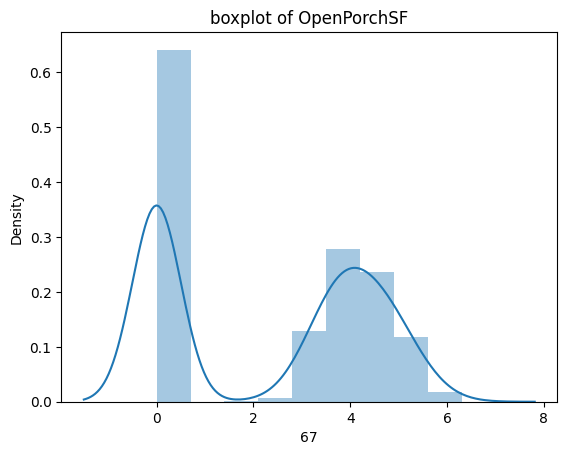

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


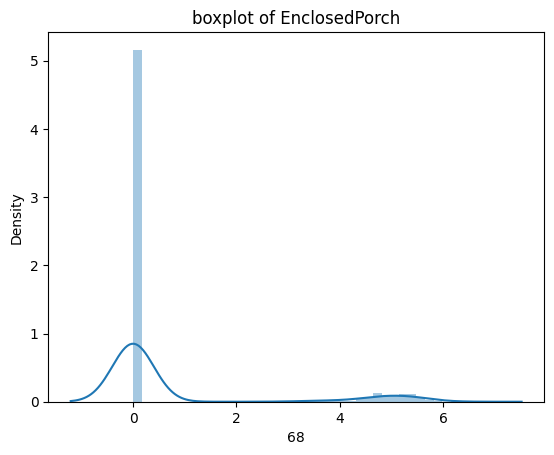

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


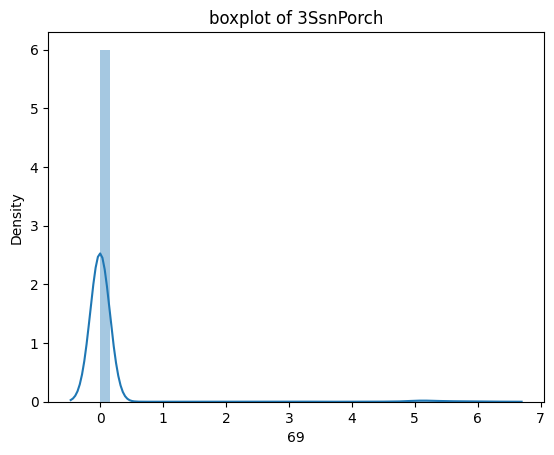

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


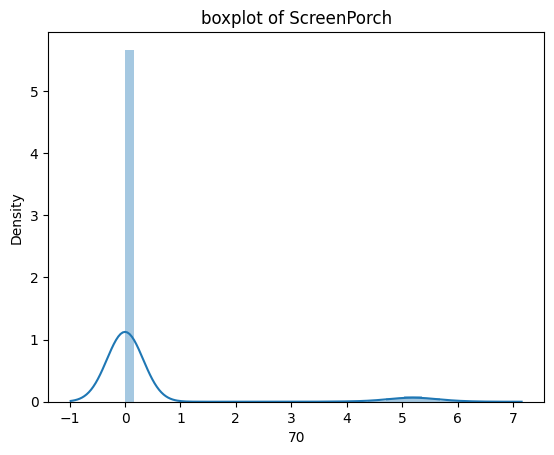

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


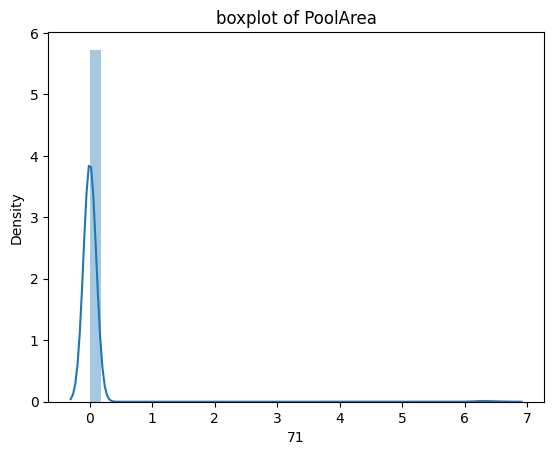

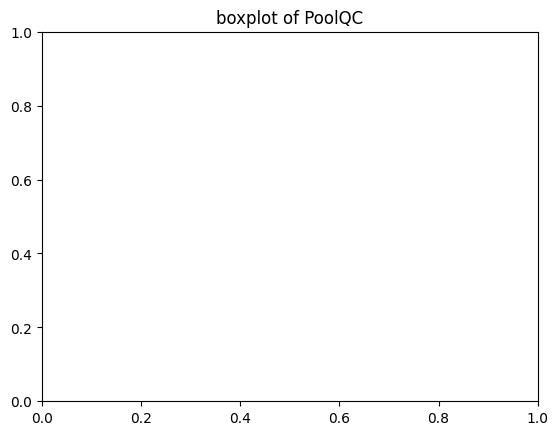

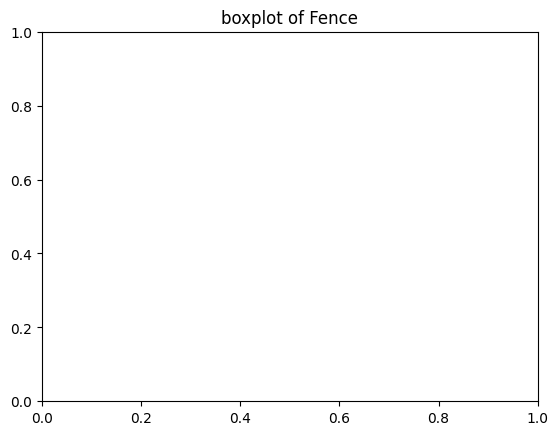

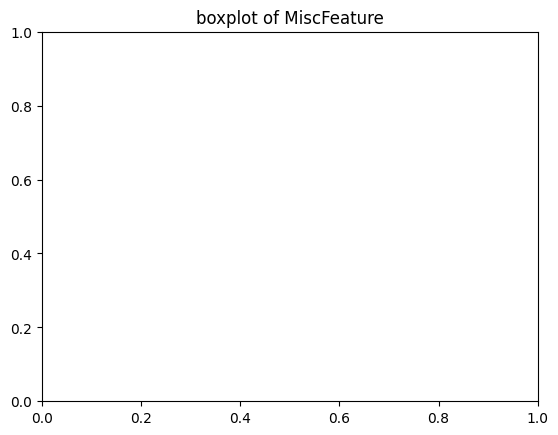

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


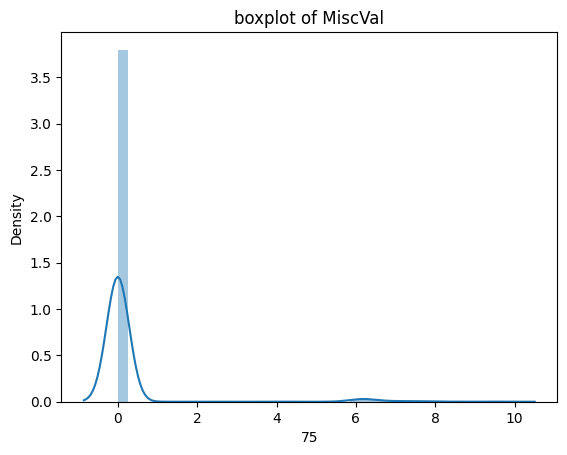

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


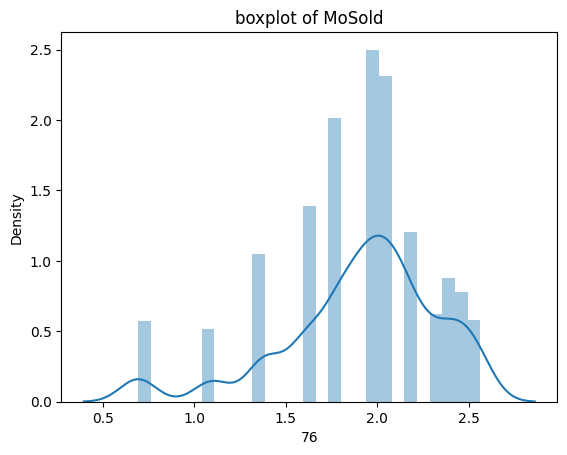

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


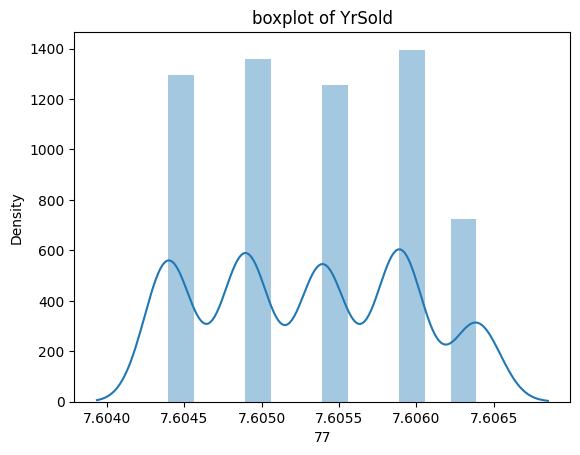

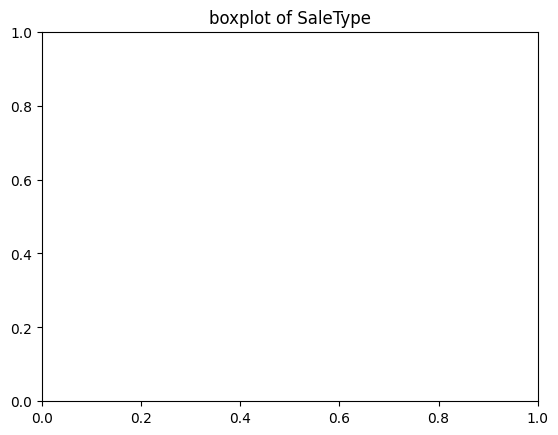

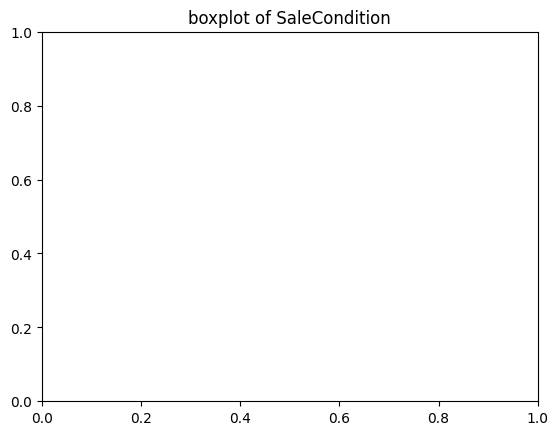

C:\Users\yixin\AppData\Local\Temp\ipykernel_20400\2435517220.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col_nr])


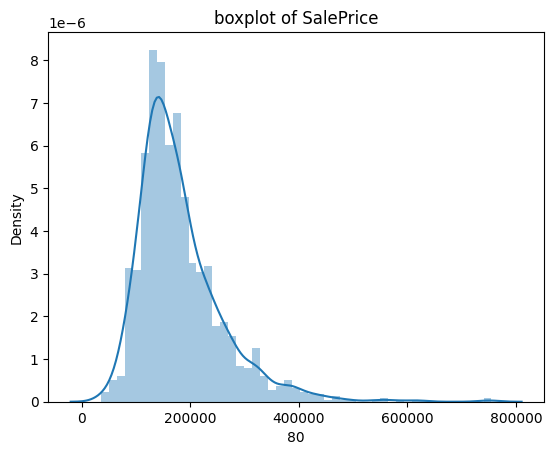

In [20]:
display_distplot(train_log_transformed)

In [21]:
# Remove outliers statistically 
# We remove datapoints that stand 3 IQR further than the Q1-Q3 range
# 3 IQR is considered ideal because 1.5 will make too many outliers. 

def detect_outliers(column, df):

    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)

    iqr = q3-q1
    
    outliers = df[(df[column] < (q1-5*iqr)) | (df[column] > (q3+5*iqr))]

    return outliers



#### Original dataset

In [22]:
# Find the index of rows with outliers and drop them
outlier_index_original = set()

for feature in train_csv.columns[1:-1]:
    if datatype[feature] != "object":

        for row_index in detect_outliers(feature, train_log_transformed).index:
            outlier_index_original.add(row_index)

In [23]:
outlier_index_original

{1,
 3,
 5,
 7,
 8,
 9,
 12,
 14,
 16,
 17,
 21,
 24,
 26,
 29,
 30,
 33,
 37,
 39,
 41,
 42,
 43,
 44,
 46,
 48,
 50,
 51,
 52,
 55,
 58,
 61,
 63,
 69,
 72,
 73,
 74,
 77,
 78,
 79,
 80,
 84,
 88,
 89,
 90,
 92,
 93,
 95,
 98,
 99,
 102,
 104,
 106,
 107,
 108,
 112,
 113,
 114,
 116,
 120,
 121,
 122,
 125,
 127,
 129,
 134,
 137,
 140,
 144,
 148,
 153,
 154,
 155,
 156,
 159,
 163,
 164,
 165,
 166,
 170,
 172,
 173,
 174,
 175,
 176,
 177,
 179,
 181,
 182,
 185,
 187,
 188,
 189,
 196,
 197,
 198,
 199,
 201,
 202,
 205,
 207,
 208,
 210,
 213,
 214,
 215,
 217,
 218,
 223,
 230,
 231,
 233,
 237,
 241,
 242,
 245,
 246,
 249,
 250,
 251,
 253,
 258,
 259,
 260,
 263,
 265,
 267,
 268,
 271,
 273,
 275,
 278,
 280,
 284,
 286,
 287,
 289,
 291,
 292,
 297,
 298,
 299,
 306,
 307,
 312,
 313,
 314,
 318,
 322,
 325,
 328,
 329,
 330,
 332,
 335,
 338,
 339,
 341,
 342,
 344,
 346,
 351,
 352,
 354,
 355,
 358,
 359,
 360,
 362,
 365,
 366,
 367,
 369,
 371,
 372,
 373,
 375,
 380

In [24]:
for feature in train_csv.columns[1:-1]:
    if datatype[feature] != "object":
        print(f"Number of outliers in feature {feature}: {len(detect_outliers(feature,train_csv))}")

Number of outliers in feature 1: 0
Number of outliers in feature 3: 2
Number of outliers in feature 4: 21
Number of outliers in feature 17: 0
Number of outliers in feature 18: 0
Number of outliers in feature 19: 0
Number of outliers in feature 20: 0
Number of outliers in feature 26: 7
Number of outliers in feature 34: 1
Number of outliers in feature 36: 167
Number of outliers in feature 37: 0
Number of outliers in feature 38: 1
Number of outliers in feature 43: 1
Number of outliers in feature 44: 0
Number of outliers in feature 45: 26
Number of outliers in feature 46: 1
Number of outliers in feature 47: 0
Number of outliers in feature 48: 82
Number of outliers in feature 49: 0
Number of outliers in feature 50: 0
Number of outliers in feature 51: 0
Number of outliers in feature 52: 68
Number of outliers in feature 54: 0
Number of outliers in feature 56: 0
Number of outliers in feature 59: 0
Number of outliers in feature 61: 0
Number of outliers in feature 62: 0
Number of outliers in fea

In [25]:
train_csv = train_csv.drop(outlier_index_original).drop(columns=0)

In [26]:
train_csv

1    2     3        4    5    6    7    8    9    10  ...   71   72  \
0      60.0  3.0  65.0   8450.0  1.0  2.0  3.0  3.0  0.0  4.0  ...  0.0  3.0   
2      60.0  3.0  68.0  11250.0  1.0  2.0  0.0  3.0  0.0  4.0  ...  0.0  3.0   
4      60.0  3.0  84.0  14260.0  1.0  2.0  0.0  3.0  0.0  2.0  ...  0.0  3.0   
6      20.0  3.0  75.0  10084.0  1.0  2.0  3.0  3.0  0.0  4.0  ...  0.0  3.0   
10     20.0  3.0  70.0  11200.0  1.0  2.0  3.0  3.0  0.0  4.0  ...  0.0  3.0   
...     ...  ...   ...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1448   50.0  3.0  70.0  11767.0  1.0  2.0  3.0  3.0  0.0  4.0  ...  0.0  3.0   
1451   20.0  3.0  78.0   9262.0  1.0  2.0  3.0  3.0  0.0  4.0  ...  0.0  3.0   
1452  180.0  4.0  35.0   3675.0  1.0  2.0  3.0  3.0  0.0  4.0  ...  0.0  3.0   
1454   20.0  1.0  62.0   7500.0  1.0  1.0  3.0  3.0  0.0  4.0  ...  0.0  3.0   
1455   60.0  3.0  62.0   7917.0  1.0  2.0  3.0  3.0  0.0  4.0  ...  0.0  3.0   

       73   74   75    76      77   78   79        80  
0     4.0  4.0  0.0   2.0  2008.0  8.0  4.0  208500.0  
2     4.0  4.0  0.0   9.0  2008.0  8.0  4.0  223500.0  
4     4.0  4.0  0.0  12.0  2008.0  8.0  4.0  250000.0  
6     4.0  4.0  0.0   8.0  2007.0  8.0  4.0  307000.0  
10    4.0  4.0  0.0   2.0  2008.0  8.0  4.0  129500.0  
...   ...  ...  ...   ...     ...  ...  ...       ...  
1448  1.0  4.0  0.0   5.0  2007.0  8.0  4.0  112000.0  
1451  4.0  4.0  0.0   5.0  2009.0  6.0  5.0  287090.0  
1452  4.0  4.0  0.0   5.0  2006.0  8.0  4.0  145000.0  
1454  4.0  4.0  0.0  10.0  2009.0  8.0  4.0  185000.0  
1455  4.0  4.0  0.0   8.0  2007.0  8.0  4.0  175000.0  

[815 rows x 80 columns]

#### Transformed Dataset

In [27]:
# Find the index of rows with outliers and drop them
outlier_index_transformed = set()

for feature in train_log_transformed.columns[1:-1]:
    if datatype[feature] != "object":

        for row_index in detect_outliers(feature, train_log_transformed).index:
            outlier_index_transformed.add(row_index)


In [28]:
outlier_index_transformed

{1,
 3,
 5,
 7,
 8,
 9,
 12,
 14,
 16,
 17,
 21,
 24,
 26,
 29,
 30,
 33,
 37,
 39,
 41,
 42,
 43,
 44,
 46,
 48,
 50,
 51,
 52,
 55,
 58,
 61,
 63,
 69,
 72,
 73,
 74,
 77,
 78,
 79,
 80,
 84,
 88,
 89,
 90,
 92,
 93,
 95,
 98,
 99,
 102,
 104,
 106,
 107,
 108,
 112,
 113,
 114,
 116,
 120,
 121,
 122,
 125,
 127,
 129,
 134,
 137,
 140,
 144,
 148,
 153,
 154,
 155,
 156,
 159,
 163,
 164,
 165,
 166,
 170,
 172,
 173,
 174,
 175,
 176,
 177,
 179,
 181,
 182,
 185,
 187,
 188,
 189,
 196,
 197,
 198,
 199,
 201,
 202,
 205,
 207,
 208,
 210,
 213,
 214,
 215,
 217,
 218,
 223,
 230,
 231,
 233,
 237,
 241,
 242,
 245,
 246,
 249,
 250,
 251,
 253,
 258,
 259,
 260,
 263,
 265,
 267,
 268,
 271,
 273,
 275,
 278,
 280,
 284,
 286,
 287,
 289,
 291,
 292,
 297,
 298,
 299,
 306,
 307,
 312,
 313,
 314,
 318,
 322,
 325,
 328,
 329,
 330,
 332,
 335,
 338,
 339,
 341,
 342,
 344,
 346,
 351,
 352,
 354,
 355,
 358,
 359,
 360,
 362,
 365,
 366,
 367,
 369,
 371,
 372,
 373,
 375,
 380

In [29]:
outlier_index_original == outlier_index_transformed

True

In [30]:
train_log_transformed = train_log_transformed.drop(outlier_index_transformed).drop(columns=0)

In [31]:
train_log_transformed

1         2         3         4         5         6         7   \
0     4.110874  1.386294  4.189655  9.042040  0.693147  1.098612  1.386294   
2     4.110874  1.386294  4.234107  9.328212  0.693147  1.098612  0.000000   
4     4.110874  1.386294  4.442651  9.565284  0.693147  1.098612  0.000000   
6     3.044522  1.386294  4.330733  9.218804  0.693147  1.098612  1.386294   
10    3.044522  1.386294  4.262680  9.323758  0.693147  1.098612  1.386294   
...        ...       ...       ...       ...       ...       ...       ...   
1448  3.931826  1.386294  4.262680  9.373139  0.693147  1.098612  1.386294   
1451  3.044522  1.386294  4.369448  9.133783  0.693147  1.098612  1.386294   
1452  5.198497  1.609438  3.583519  8.209580  0.693147  1.098612  1.386294   
1454  3.044522  0.693147  4.143135  8.922792  0.693147  0.693147  1.386294   
1455  4.110874  1.386294  4.143135  8.976894  0.693147  1.098612  1.386294   

            8    9         10  ...   71        72        73        74   75  \
0     1.386294  0.0  1.609438  ...  0.0  1.386294  1.609438  1.609438  0.0   
2     1.386294  0.0  1.609438  ...  0.0  1.386294  1.609438  1.609438  0.0   
4     1.386294  0.0  1.098612  ...  0.0  1.386294  1.609438  1.609438  0.0   
6     1.386294  0.0  1.609438  ...  0.0  1.386294  1.609438  1.609438  0.0   
10    1.386294  0.0  1.609438  ...  0.0  1.386294  1.609438  1.609438  0.0   
...        ...  ...       ...  ...  ...       ...       ...       ...  ...   
1448  1.386294  0.0  1.609438  ...  0.0  1.386294  0.693147  1.609438  0.0   
1451  1.386294  0.0  1.609438  ...  0.0  1.386294  1.609438  1.609438  0.0   
1452  1.386294  0.0  1.609438  ...  0.0  1.386294  1.609438  1.609438  0.0   
1454  1.386294  0.0  1.609438  ...  0.0  1.386294  1.609438  1.609438  0.0   
1455  1.386294  0.0  1.609438  ...  0.0  1.386294  1.609438  1.609438  0.0   

            76        77        78        79        80  
0     1.098612  7.605392  2.197225  1.609438  208500.0  
2     2.302585  7.605392  2.197225  1.609438  223500.0  
4     2.564949  7.605392  2.197225  1.609438  250000.0  
6     2.197225  7.604894  2.197225  1.609438  307000.0  
10    1.098612  7.605392  2.197225  1.609438  129500.0  
...        ...       ...       ...       ...       ...  
1448  1.791759  7.604894  2.197225  1.609438  112000.0  
1451  1.791759  7.605890  1.945910  1.791759  287090.0  
1452  1.791759  7.604396  2.197225  1.609438  145000.0  
1454  2.397895  7.605890  2.197225  1.609438  185000.0  
1455  2.197225  7.604894  2.197225  1.609438  175000.0  

[815 rows x 80 columns]

## LASSO Model
Train the model on data without outliers

Train model with multiple alpha 

In [32]:
def run_model(df):
    X = df.iloc[:,:-1]
    Y = df.iloc[:,-1:]

    alphas = np.logspace(-4, 0, 50)
    
    result_mean = []
    result_std = []
    result_alpha= []
    
    for alpha in alphas:
    
        model = Lasso(alpha=alpha)  
    
        cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
        # evaluate model
        scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    
        print(f'Mean MAE: {mean(scores):.3f} STD: {std(scores):.3f} alpha={alpha}')
    
        result_mean.append(mean(scores))
        result_std.append(std(scores))
        result_alpha.append(alpha)
    
    print(" ")
    
    print(f"Maximum MAE: {max(result_mean)}, alpha={result_alpha[result_mean.index(max(result_mean))]}")
    print(f"Minimum MAE: {min(result_mean)}, alpha={result_alpha[result_mean.index(min(result_mean))]}")

In [33]:
run_model(train_csv)

Mean MAE: -19397.950 STD: 2083.684 alpha=0.0001
Mean MAE: -19397.950 STD: 2083.684 alpha=0.00012067926406393288
Mean MAE: -19397.950 STD: 2083.684 alpha=0.00014563484775012445
Mean MAE: -19397.950 STD: 2083.684 alpha=0.00017575106248547912
Mean MAE: -19397.949 STD: 2083.684 alpha=0.00021209508879201905
Mean MAE: -19397.949 STD: 2083.684 alpha=0.0002559547922699536
Mean MAE: -19397.949 STD: 2083.684 alpha=0.00030888435964774815
Mean MAE: -19397.949 STD: 2083.684 alpha=0.0003727593720314938
Mean MAE: -19397.948 STD: 2083.684 alpha=0.0004498432668969444
Mean MAE: -19397.948 STD: 2083.684 alpha=0.0005428675439323859
Mean MAE: -19397.947 STD: 2083.684 alpha=0.0006551285568595509
Mean MAE: -19397.947 STD: 2083.683 alpha=0.0007906043210907702
Mean MAE: -19397.946 STD: 2083.683 alpha=0.0009540954763499944
Mean MAE: -19397.945 STD: 2083.683 alpha=0.0011513953993264468
Mean MAE: -19397.944 STD: 2083.683 alpha=0.0013894954943731374
Mean MAE: -19397.942 STD: 2083.682 alpha=0.0016768329368110067
Me

In [34]:
run_model(train_log_transformed)

Mean MAE: -21625.754 STD: 2324.899 alpha=0.0001
Mean MAE: -21625.753 STD: 2324.900 alpha=0.00012067926406393288
Mean MAE: -21625.751 STD: 2324.901 alpha=0.00014563484775012445
Mean MAE: -21625.749 STD: 2324.902 alpha=0.00017575106248547912
Mean MAE: -21625.747 STD: 2324.903 alpha=0.00021209508879201905
Mean MAE: -21625.744 STD: 2324.904 alpha=0.0002559547922699536
Mean MAE: -21625.740 STD: 2324.906 alpha=0.00030888435964774815
Mean MAE: -21625.736 STD: 2324.908 alpha=0.0003727593720314938
Mean MAE: -21625.731 STD: 2324.911 alpha=0.0004498432668969444
Mean MAE: -21625.725 STD: 2324.914 alpha=0.0005428675439323859
Mean MAE: -21625.717 STD: 2324.918 alpha=0.0006551285568595509
Mean MAE: -21625.708 STD: 2324.922 alpha=0.0007906043210907702
Mean MAE: -21625.697 STD: 2324.927 alpha=0.0009540954763499944
Mean MAE: -21625.684 STD: 2324.934 alpha=0.0011513953993264468
Mean MAE: -21625.669 STD: 2324.942 alpha=0.0013894954943731374
Mean MAE: -21625.650 STD: 2324.951 alpha=0.0016768329368110067
Me

## Check the residuals
When $\alpha=1.0$, the model performs the best. We use this model to check the residuals

In [35]:
def check_residuals(data, alpha, savefig=""):
    X = data.iloc[:,:-1]
    Y = data.iloc[:,-1:]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=15)
    
    model_residual = Lasso(alpha=alpha)
    model_residual.fit(X_train, Y_train)
    
    # Make predictions on the test set
    Y_pred = model_residual.predict(X_test)

    Y_pred = Y_pred.reshape(-1,1)

    # Calculate the residuals
    residuals = Y_test - Y_pred
    
    plt.figure(figsize=(8, 6))
    plt.scatter(Y_pred, residuals, color='blue', edgecolor='k')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot for LASSO Regression (alpha={alpha})')
    
    if savefig:
        plt.savefig(path)
        
    plt.show()

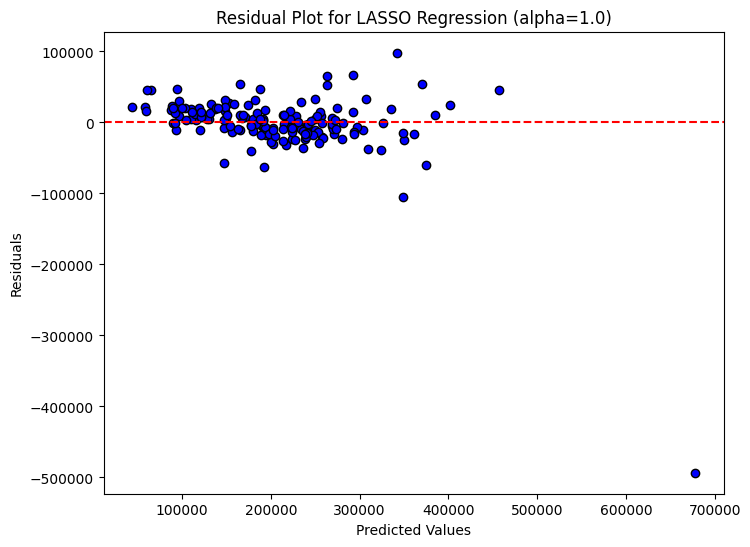

In [36]:
check_residuals(train_csv, 1.0)

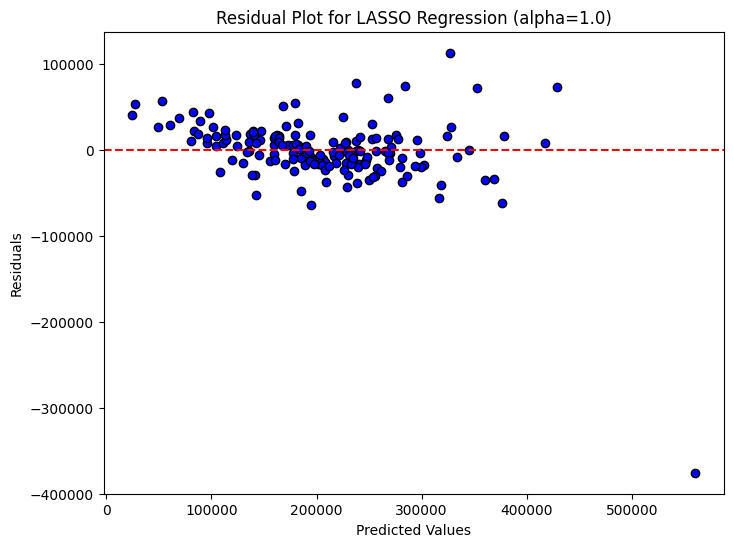

In [37]:
check_residuals(train_log_transformed, 1.0)

## Result
###### Removing outliers by 3 IQR: 
The result shows that the performance was increased significantly compared to uncleaned dataset; however, 40% of the datapoints were considered outliers and were removed from the dataset. <br>
It is not sure if the model will perform equally well on the test_csv.
**Outlier removal caused significant data loss, the reason is that some outliers formed a different distribution and need to be treated differently.**


### Next:
1. Use Winsorization technique to 

In [39]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 815 entries, 0 to 1455
Data columns (total 80 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       815 non-null    float64
 1   2       815 non-null    float64
 2   3       815 non-null    float64
 3   4       815 non-null    float64
 4   5       815 non-null    float64
 5   6       815 non-null    float64
 6   7       815 non-null    float64
 7   8       815 non-null    float64
 8   9       815 non-null    float64
 9   10      815 non-null    float64
 10  11      815 non-null    float64
 11  12      815 non-null    float64
 12  13      815 non-null    float64
 13  14      815 non-null    float64
 14  15      815 non-null    float64
 15  16      815 non-null    float64
 16  17      815 non-null    float64
 17  18      815 non-null    float64
 18  19      815 non-null    float64
 19  20      815 non-null    float64
 20  21      815 non-null    float64
 21  22      815 non-null    float64
 22  23    